# LIBRARIES

In [13]:
#IMPORTING LIBRARIES FOR PREPROCESSING

import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler

#IMPORTING LIBRARIES FOR TRAINING

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score,f1_score,average_precision_score,confusion_matrix,make_scorer

import mlflow
import mlflow.sklearn
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git

# PREPROCESSING PIPELINE
- LOAD DATA
- ---------------------------------------------------------------------------------------------------------------------------
- PERFORM TRAIN TEST SPLIT
    - 80:20 SPLIT
- --------------------------------------------------------------------------------------------------------------------------- 
- HANDLE  NULL VALUES IN THE TRAINING DATASET
    - DROP POLICY NUMBER
    - DROP DUPLICATE RECORDS
    - FILL NULL CLAIM COUNTS WITH 0
    - CHANGE THE DEPENDENT FEATURE TO CLAIM OR NO CLIAM
    - HANDLE FEATURES: HYPO_PARTY & PREV_INSURER
-  --------------------------------------------------------------------------------------------------------------------------- 
- PERFORM OVERSAMPLING
    - REMOVE BIAS OF THE DATA WITH DUPLICATE RECORDS

In [14]:
#FUNCTION TO LOAD DATA
def load_data(path):
    data=pd.read_excel(path)
    return data

In [ ]:
df = load_data('C:/Users/Shiv.tikoo/Downloads/Project/Data/tmp_auto_poicies_202306261442.xlsx')
df.head() 

In [16]:
df.shape

(642737, 19)

In [17]:
df.describe()

office_code  policy_period      imd_code        veh_age  \
count  642737.000000  642737.000000  6.427370e+05  642737.000000   
mean    12159.947689     359.205397  1.031687e+06       3.158275   
std       909.528350      40.633790  2.873280e+04       3.089130   
min     10101.000000       0.000000  1.000011e+06       0.000000   
25%     10903.000000     364.000000  1.003198e+06       0.000000   
50%     12702.000000     364.000000  1.027794e+06       3.000000   
75%     12710.000000     364.000000  1.051203e+06       5.000000   
max     13702.000000     393.000000  1.141688e+06      38.000000   

            prev_ncb    net_premium    sum_insured       clm_cnt  
count  642737.000000  642737.000000  642737.000000  23058.000000  
mean        4.172010    6741.425330  117568.314531      1.056770  
std        11.203379     943.366746   43416.797693      0.250661  
min         0.000000     818.960000       0.000000      1.000000  
25%         0.000000    6477.370000   88000.000000      1.000000  
50%         0.000000    6784.000000  114000.000000      1.000000  
75%         0.000000    7011.000000  144780.000000      1.000000  
max        55.000000   13904.960000  475771.000000      6.000000

- TRAIN TEST SPLIT

In [18]:
def train_test(df_new):
    features = df_new.drop('clm_cnt',axis=1)   # Features
    label = df_new['clm_cnt']  # Target variable

    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size=0.2, random_state=42)
    
    return X_train, X_test, Y_train, Y_test

# TRAINING DATAFRAME prePROCESSING PIPELINE

- HANDLING NULL RECORDS

In [19]:
def handling_null(df):
    # NULL VALUES
    print("na values available in data \n")
    print(df.isna().sum())
    
    # POLICY NUMBER WILL BE IRRELEVANT IN PREDICTION SO DROPPING
    df=df.drop('policy_number',axis=1)
    
    # DROPPING IRRELEVANT RECORDS
    df.drop_duplicates(keep='last',inplace=True)
    
    # DROPPING THE OUTLIERs 
    # df=df.drop(df[df['clm_cnt']>6].index)

    # FILLING NA VALUES OF VEHICLE_SUBTYPE WITH THE MODE OF THAT VEHICLE_MAKE
    df['vehicle_subtype']=df.groupby('vehicle_make')['vehicle_subtype'].transform(lambda x:x.fillna(x.mode().iloc[0]))
    
    # ASSUMING NAN CLAIM COUNT MEANING NO CLAIM HASNT BEEN TAKEN
    df['clm_cnt']=df['clm_cnt'].fillna(0)
    df.loc[df['clm_cnt']>1,'clm_cnt']=1
    
    # ASSUMING NO 
    df['hypo_party']=df['hypo_party'].fillna("self")
    
    #CONSIDERING THERE WAS NO PREVIOUS INSURER AND DIGIT IS THE CUSTOMER'S FIRST INSURER
    df['prev_insurer']=df['prev_insurer'].fillna("new")
    
    df['veh_permit']=df.groupby('rto_location')['veh_permit'].transform(lambda x:x.fillna(x.mode().iloc[0]))
    
    # NULL VALUES
    print("\n na values POST PROCESING in data \n")
    print(df.isna().sum())
    
    return df

- HANDLING THE BIAS

In [20]:
def sampling(df):
    X = df.drop('clm_cnt', axis=1)  
    Y = df['clm_cnt'] 
    
    oversample = RandomOverSampler(sampling_strategy='auto')
    X,Y = oversample.fit_resample(X,Y)
    
    df_new = pd.concat([X, Y], axis=1)

    # Print the value counts of the target variable before and after oversampling
    print("Before oversampling:")
    print(df['clm_cnt'].value_counts())

    print("\nAfter oversampling:")
    print(df_new['clm_cnt'].value_counts())
    
    print("\nShape PRE oversampling:")
    print(df.shape)
    
    print("\nShape POST oversampling:")
    print(df_new.shape)
    
    return df_new
        

# TESTING DATAFRAME prePROCESSING PIPELINE

- HANDLING NULL RECORDS

In [21]:
def handling_null_test(data):
    
    # DROP POLICY NUMBER
    data=data.drop('policy_number',axis=1)
    
    # ASSUMING NO HYPO_PARTY MEANS THAT THE VEHICLE WAS SELF FINANCED
    data['hypo_party']=data['hypo_party'].fillna("self")
    
    #CONSIDERING THERE WAS NO PREVIOUS INSURER AND DIGIT IS THE CUSTOMER'S FIRST INSURER
    data['prev_insurer']=data['prev_insurer'].fillna("new")
        
    return data

- TRANSFORMING TESTING DATAFRAME TO CLAIM OR NO CLAIM

In [22]:
def transform_true(data):
    
    # Fill NULL values withd efault value of zero
    # Suggesting zero claims made
    data=data.fillna(0)
    
    # Transform the feature into a binary class
    data=data.apply(lambda x:1 if x>1 else x)
    
    return data


# MODEL METRICS

In [23]:
def predict_test(model,X_test):
    
    Y_pred = model.predict(X_test)
    Y_pred= np.round(Y_pred).astype(int)

    # CHECKER FOR NEGATOVE VALUES
    for i in range(len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    
    return Y_pred

In [24]:
def get_metrics(Y_test, Y_pred):
    
    # Evaluate the model
    mse = accuracy_score(Y_test, Y_pred)
    print("ACCURACY OF THE MODEL:", mse)

    rmse = recall_score(Y_test, Y_pred)
    print("RECALL OF THE MODEL:", rmse)

    r2=precision_score(Y_test,Y_pred)
    print("PRECISION OF THE MODEL:",r2)

    mae=f1_score(Y_test,Y_pred)
    print('F1 SCORE OF THE MODEL: ',mae)
    
    r3=average_precision_score(Y_test,Y_pred)
    print("AVERAGE PRECISION OF THE MODEL:",r2)
    
    print(confusion_matrix(Y_test,Y_pred))
    
    return {'ACCURACY OF THE MODEL': round(mse, 4), 'RECALL OF THE MODEL': round(rmse,4), 'PRECISION OF THE MODEL': round(r2, 4), 'F1 SCORE OF THE MODEL': round(mae, 4),'AVERAGE PRECISION OF THE MODEL': round(r3, 4)}


# TRAINING PIPELINE
- TRAIN TEST SPLIT
- -----------------------------------------------------------------------------------------------------------------------------
- HANDLE NULL VALUES OF X_TRAIN
- -----------------------------------------------------------------------------------------------------------------------------
- REMOVE BIAS OF THE DATAFRAME


In [25]:
# TRAIN TEST SPLIT
X_train, X_test, Y_train, Y_test = train_test(df)

In [26]:
df_new= pd.concat([X_train,Y_train],axis=1)

In [ ]:
df_new = handling_null(df_new)

In [28]:
df_new=sampling(df_new)

Before oversampling:
clm_cnt
0.0    394203
1.0     17296
Name: count, dtype: int64

After oversampling:
clm_cnt
0.0    394203
1.0    394203
Name: count, dtype: int64

Shape PRE oversampling:
(411499, 18)

Shape POST oversampling:
(788406, 18)


In [29]:
X_train = df_new.drop('clm_cnt',axis=1)   
Y_train = df_new['clm_cnt'] 

# TESTING PIPELINE
- HANDLE NULL VALUES OF X_TEST
- ----------------------------------------------------------------------------------------------------------------------------
- HANDLE NULL VALUES OF Y_TEST
- TRANSFORM IT TO CLAIM OR NO CLAIM 

In [30]:
X_test=handling_null_test(X_test)

In [31]:
Y_test=transform_true(Y_test)

# MLFLOW EXPERIMENT LOGGING

In [21]:
# MLFLOW

def create_experiment(experiment_name,run_name,run_metrics,model,run_params=None):
    
    import mlflow
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params==None:
            for param in run_params:
                mlflow.log_param(param,run_params[param])
                
        for metric in run_metrics:
            mlflow.log_metric(metric,run_metrics[metric])
            
            mlflow.sklearn.log_model(model,"model")
            
            print("Run - %s is logged to experiment- %s" %(run_name,experiment_name))

# MODEL TRAINING
- PERFORM HYPERPARAMETER TUNING FOR CATBOOST CLASSIFIER
    - MAKING IT A COST SENSITIVE MODEL
    - PERFORM FEATURE IMPORTANCE
- REPERFORM HYPERPARAMETER TUNING FOR CATBOOST CLASSIFIER
    - COMPARE METRICS
    - WRAPPER METHOD
        - PERFORM RECURSIVE FEATURE ELIMINATION
        - PLAY AROUND WITH FEATURE SELECTION
- CREATE EXPERIMENT CATBOOST IN MLFLOW
    - TRACK THE MODELS
    - ADD BEST MODEL TO REGISTRY AND CREATE VERSIONS WITH DIFFERENT PAARMETERS OF IT
- ------------------------------------------------------------------------------------------------------------------------------
- PERFORM HYPERPARAMETER TUNING FOR RANDOM FOREST CLASSIFIER
    - PERFORM FEATURE IMPORTANCE
- REPERFORM HYPERPARAMETER TUNING FOR RANDOM FOREST CLASSIFIER
    - COMPARE METRICS
    - WRAPPER METHOD
        - PERFORM RECURSIVE FEATURE ELIMINATION
        - PLAY AROUND WITH FEATURE SELECTION
- CREATE EXPERIMENT RF IN MLFLOW
    - TRACK THE MODELS
    - ADD BEST MODEL TO REGISTRY AND CREATE VERSIONS WITH DIFFERENT PAARMETERS OF IT
- ------------------------------------------------------------------------------------------------------------------------------
- PROBLEM THAT WILL BE FACED WHILE CHOOSING THE BEST MODEL FROM THE MODEL REGISTRY HAVE TO PERFORM DIFFERENT PREPROCESSING ON THE TESTING DATA; AS DIFFERENT FEATURE SELECTION FOR DIFFERENT MODELS
- ------------------------------------------------------------------------------------------------------------------------------

# CATBOOST CLASSFIER

In [43]:
def training_cb(X_train,Y_train,cat_features):
    param_grid = {
        'iterations': [150, 100, 250,300],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.1, 0.01, 0.05, 0.001]
    }
    
    # Cost sensitive training
    class_counts=Y_train.value_counts()
    total_samples = len(Y_train)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Create an instance
    model = cb.CatBoostClassifier(class_weights=class_weights)
    score=make_scorer(f1_score)

    grid_search=RandomizedSearchCV(model,param_grid,cv=5,scoring=score,verbose=1)
    
    # Fit the model to the training data
    grid_search.fit(X_train, Y_train, cat_features=cat_features)
    
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Return the best estimator
    return grid_search.best_estimator_ , grid_search.best_params_

In [44]:
cat_features=[3,4,5,6,7,8,9,11,13,16]
model,run_params=training_cb(X_train,Y_train,cat_features)
Y_pred = predict_test(model,X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6930126	total: 625ms	remaining: 3m 6s
1:	learn: 0.6928647	total: 1.13s	remaining: 2m 47s
2:	learn: 0.6927194	total: 1.6s	remaining: 2m 38s
3:	learn: 0.6925713	total: 1.95s	remaining: 2m 24s
4:	learn: 0.6924252	total: 2.35s	remaining: 2m 18s
5:	learn: 0.6922817	total: 2.77s	remaining: 2m 15s
6:	learn: 0.6921383	total: 3.19s	remaining: 2m 13s
7:	learn: 0.6919846	total: 3.59s	remaining: 2m 11s
8:	learn: 0.6918441	total: 4.05s	remaining: 2m 10s
9:	learn: 0.6917116	total: 4.41s	remaining: 2m 7s
10:	learn: 0.6915739	total: 4.78s	remaining: 2m 5s
11:	learn: 0.6914260	total: 5.26s	remaining: 2m 6s
12:	learn: 0.6912837	total: 5.66s	remaining: 2m 5s
13:	learn: 0.6911376	total: 6.06s	remaining: 2m 3s
14:	learn: 0.6909988	total: 6.52s	remaining: 2m 3s
15:	learn: 0.6908583	total: 6.98s	remaining: 2m 3s
16:	learn: 0.6907211	total: 7.42s	remaining: 2m 3s
17:	learn: 0.6905713	total: 7.97s	remaining: 2m 4s
18:	learn: 0.6904337	tot

157:	learn: 0.6732418	total: 1m 11s	remaining: 1m 4s
158:	learn: 0.6731349	total: 1m 11s	remaining: 1m 3s
159:	learn: 0.6730217	total: 1m 12s	remaining: 1m 3s
160:	learn: 0.6729321	total: 1m 12s	remaining: 1m 2s
161:	learn: 0.6728279	total: 1m 13s	remaining: 1m 2s
162:	learn: 0.6727221	total: 1m 13s	remaining: 1m 1s
163:	learn: 0.6726231	total: 1m 14s	remaining: 1m 1s
164:	learn: 0.6725170	total: 1m 14s	remaining: 1m
165:	learn: 0.6724141	total: 1m 14s	remaining: 1m
166:	learn: 0.6723032	total: 1m 15s	remaining: 59.9s
167:	learn: 0.6721908	total: 1m 15s	remaining: 59.4s
168:	learn: 0.6720897	total: 1m 16s	remaining: 58.9s
169:	learn: 0.6719863	total: 1m 16s	remaining: 58.5s
170:	learn: 0.6718860	total: 1m 16s	remaining: 58s
171:	learn: 0.6717779	total: 1m 17s	remaining: 57.6s
172:	learn: 0.6716701	total: 1m 17s	remaining: 57.1s
173:	learn: 0.6715549	total: 1m 18s	remaining: 56.6s
174:	learn: 0.6714629	total: 1m 18s	remaining: 56.1s
175:	learn: 0.6713595	total: 1m 19s	remaining: 55.7s
1

14:	learn: 0.6909831	total: 6.97s	remaining: 2m 12s
15:	learn: 0.6908370	total: 7.41s	remaining: 2m 11s
16:	learn: 0.6907046	total: 7.84s	remaining: 2m 10s
17:	learn: 0.6905639	total: 8.27s	remaining: 2m 9s
18:	learn: 0.6904333	total: 8.68s	remaining: 2m 8s
19:	learn: 0.6903000	total: 9.14s	remaining: 2m 7s
20:	learn: 0.6901651	total: 9.61s	remaining: 2m 7s
21:	learn: 0.6900149	total: 10.1s	remaining: 2m 7s
22:	learn: 0.6898785	total: 10.5s	remaining: 2m 6s
23:	learn: 0.6897258	total: 11s	remaining: 2m 5s
24:	learn: 0.6895938	total: 11.3s	remaining: 2m 4s
25:	learn: 0.6894546	total: 11.7s	remaining: 2m 3s
26:	learn: 0.6893405	total: 12.1s	remaining: 2m 2s
27:	learn: 0.6892036	total: 12.5s	remaining: 2m 1s
28:	learn: 0.6890544	total: 13s	remaining: 2m 1s
29:	learn: 0.6889184	total: 13.4s	remaining: 2m
30:	learn: 0.6887683	total: 13.8s	remaining: 1m 59s
31:	learn: 0.6886380	total: 14.2s	remaining: 1m 59s
32:	learn: 0.6884920	total: 14.7s	remaining: 1m 58s
33:	learn: 0.6883584	total: 15.2

172:	learn: 0.6717644	total: 1m 16s	remaining: 56.2s
173:	learn: 0.6716587	total: 1m 16s	remaining: 55.7s
174:	learn: 0.6715466	total: 1m 17s	remaining: 55.3s
175:	learn: 0.6714510	total: 1m 17s	remaining: 54.9s
176:	learn: 0.6713550	total: 1m 18s	remaining: 54.5s
177:	learn: 0.6712491	total: 1m 18s	remaining: 54s
178:	learn: 0.6711292	total: 1m 19s	remaining: 53.6s
179:	learn: 0.6710129	total: 1m 19s	remaining: 53.1s
180:	learn: 0.6709101	total: 1m 20s	remaining: 52.7s
181:	learn: 0.6708028	total: 1m 20s	remaining: 52.2s
182:	learn: 0.6706982	total: 1m 20s	remaining: 51.7s
183:	learn: 0.6706001	total: 1m 21s	remaining: 51.3s
184:	learn: 0.6704954	total: 1m 21s	remaining: 50.9s
185:	learn: 0.6703900	total: 1m 22s	remaining: 50.5s
186:	learn: 0.6702847	total: 1m 22s	remaining: 50s
187:	learn: 0.6701861	total: 1m 23s	remaining: 49.5s
188:	learn: 0.6700867	total: 1m 23s	remaining: 49.1s
189:	learn: 0.6699909	total: 1m 24s	remaining: 48.7s
190:	learn: 0.6698923	total: 1m 24s	remaining: 48.

29:	learn: 0.6887274	total: 12.8s	remaining: 1m 55s
30:	learn: 0.6885913	total: 13.2s	remaining: 1m 54s
31:	learn: 0.6884510	total: 13.7s	remaining: 1m 54s
32:	learn: 0.6883184	total: 14.2s	remaining: 1m 54s
33:	learn: 0.6881617	total: 14.7s	remaining: 1m 55s
34:	learn: 0.6880218	total: 15.1s	remaining: 1m 54s
35:	learn: 0.6878838	total: 15.5s	remaining: 1m 53s
36:	learn: 0.6877553	total: 15.9s	remaining: 1m 53s
37:	learn: 0.6876124	total: 16.2s	remaining: 1m 51s
38:	learn: 0.6874680	total: 16.7s	remaining: 1m 51s
39:	learn: 0.6873300	total: 17.1s	remaining: 1m 51s
40:	learn: 0.6871988	total: 17.6s	remaining: 1m 50s
41:	learn: 0.6870603	total: 18s	remaining: 1m 50s
42:	learn: 0.6869208	total: 18.4s	remaining: 1m 49s
43:	learn: 0.6867855	total: 18.8s	remaining: 1m 49s
44:	learn: 0.6866328	total: 19.2s	remaining: 1m 48s
45:	learn: 0.6864972	total: 19.6s	remaining: 1m 48s
46:	learn: 0.6863546	total: 20s	remaining: 1m 47s
47:	learn: 0.6862377	total: 20.5s	remaining: 1m 47s
48:	learn: 0.686

187:	learn: 0.6695343	total: 1m 22s	remaining: 49s
188:	learn: 0.6694150	total: 1m 22s	remaining: 48.6s
189:	learn: 0.6693110	total: 1m 23s	remaining: 48.2s
190:	learn: 0.6691909	total: 1m 23s	remaining: 47.7s
191:	learn: 0.6690688	total: 1m 24s	remaining: 47.3s
192:	learn: 0.6689611	total: 1m 24s	remaining: 46.8s
193:	learn: 0.6688511	total: 1m 24s	remaining: 46.4s
194:	learn: 0.6687536	total: 1m 25s	remaining: 46s
195:	learn: 0.6686369	total: 1m 25s	remaining: 45.6s
196:	learn: 0.6685295	total: 1m 26s	remaining: 45.1s
197:	learn: 0.6684235	total: 1m 26s	remaining: 44.7s
198:	learn: 0.6683230	total: 1m 27s	remaining: 44.3s
199:	learn: 0.6682063	total: 1m 27s	remaining: 43.9s
200:	learn: 0.6681054	total: 1m 28s	remaining: 43.5s
201:	learn: 0.6680059	total: 1m 28s	remaining: 43.1s
202:	learn: 0.6679104	total: 1m 29s	remaining: 42.6s
203:	learn: 0.6678079	total: 1m 29s	remaining: 42.2s
204:	learn: 0.6677088	total: 1m 30s	remaining: 41.7s
205:	learn: 0.6675889	total: 1m 30s	remaining: 41.

45:	learn: 0.6867581	total: 19.7s	remaining: 1m 49s
46:	learn: 0.6866339	total: 20.1s	remaining: 1m 48s
47:	learn: 0.6865027	total: 20.6s	remaining: 1m 47s
48:	learn: 0.6863689	total: 21s	remaining: 1m 47s
49:	learn: 0.6862435	total: 21.4s	remaining: 1m 47s
50:	learn: 0.6861117	total: 21.8s	remaining: 1m 46s
51:	learn: 0.6859855	total: 22.2s	remaining: 1m 45s
52:	learn: 0.6858393	total: 22.6s	remaining: 1m 45s
53:	learn: 0.6857015	total: 23s	remaining: 1m 45s
54:	learn: 0.6855673	total: 23.5s	remaining: 1m 44s
55:	learn: 0.6854334	total: 24s	remaining: 1m 44s
56:	learn: 0.6853019	total: 24.4s	remaining: 1m 43s
57:	learn: 0.6851701	total: 24.8s	remaining: 1m 43s
58:	learn: 0.6850413	total: 25.3s	remaining: 1m 43s
59:	learn: 0.6849052	total: 25.7s	remaining: 1m 42s
60:	learn: 0.6847731	total: 26.1s	remaining: 1m 42s
61:	learn: 0.6846414	total: 26.5s	remaining: 1m 41s
62:	learn: 0.6845085	total: 26.9s	remaining: 1m 41s
63:	learn: 0.6843877	total: 27.4s	remaining: 1m 40s
64:	learn: 0.68425

202:	learn: 0.6684540	total: 1m 27s	remaining: 41.9s
203:	learn: 0.6683574	total: 1m 28s	remaining: 41.4s
204:	learn: 0.6682552	total: 1m 28s	remaining: 41s
205:	learn: 0.6681588	total: 1m 28s	remaining: 40.6s
206:	learn: 0.6680540	total: 1m 29s	remaining: 40.1s
207:	learn: 0.6679417	total: 1m 29s	remaining: 39.7s
208:	learn: 0.6678334	total: 1m 30s	remaining: 39.2s
209:	learn: 0.6677344	total: 1m 30s	remaining: 38.8s
210:	learn: 0.6676356	total: 1m 31s	remaining: 38.4s
211:	learn: 0.6675355	total: 1m 31s	remaining: 38s
212:	learn: 0.6674270	total: 1m 31s	remaining: 37.6s
213:	learn: 0.6673171	total: 1m 32s	remaining: 37.1s
214:	learn: 0.6672145	total: 1m 32s	remaining: 36.7s
215:	learn: 0.6671156	total: 1m 33s	remaining: 36.2s
216:	learn: 0.6670195	total: 1m 33s	remaining: 35.8s
217:	learn: 0.6669332	total: 1m 34s	remaining: 35.4s
218:	learn: 0.6668291	total: 1m 34s	remaining: 35s
219:	learn: 0.6667307	total: 1m 34s	remaining: 34.5s
220:	learn: 0.6666281	total: 1m 35s	remaining: 34.1s

60:	learn: 0.6845673	total: 27.1s	remaining: 1m 46s
61:	learn: 0.6844430	total: 27.6s	remaining: 1m 45s
62:	learn: 0.6843238	total: 28s	remaining: 1m 45s
63:	learn: 0.6842079	total: 28.4s	remaining: 1m 44s
64:	learn: 0.6840810	total: 28.8s	remaining: 1m 44s
65:	learn: 0.6839456	total: 29.2s	remaining: 1m 43s
66:	learn: 0.6838154	total: 29.7s	remaining: 1m 43s
67:	learn: 0.6836822	total: 30.2s	remaining: 1m 42s
68:	learn: 0.6835596	total: 30.6s	remaining: 1m 42s
69:	learn: 0.6834296	total: 31.1s	remaining: 1m 42s
70:	learn: 0.6832927	total: 31.5s	remaining: 1m 41s
71:	learn: 0.6831596	total: 32s	remaining: 1m 41s
72:	learn: 0.6830298	total: 32.4s	remaining: 1m 40s
73:	learn: 0.6829028	total: 32.9s	remaining: 1m 40s
74:	learn: 0.6827721	total: 33.4s	remaining: 1m 40s
75:	learn: 0.6826346	total: 33.8s	remaining: 1m 39s
76:	learn: 0.6824969	total: 34.3s	remaining: 1m 39s
77:	learn: 0.6823637	total: 34.7s	remaining: 1m 38s
78:	learn: 0.6822342	total: 35.1s	remaining: 1m 38s
79:	learn: 0.682

217:	learn: 0.6665365	total: 1m 36s	remaining: 36.4s
218:	learn: 0.6664326	total: 1m 37s	remaining: 35.9s
219:	learn: 0.6663365	total: 1m 37s	remaining: 35.5s
220:	learn: 0.6662500	total: 1m 38s	remaining: 35s
221:	learn: 0.6661530	total: 1m 38s	remaining: 34.6s
222:	learn: 0.6660466	total: 1m 38s	remaining: 34.2s
223:	learn: 0.6659622	total: 1m 39s	remaining: 33.7s
224:	learn: 0.6658452	total: 1m 39s	remaining: 33.3s
225:	learn: 0.6657567	total: 1m 40s	remaining: 32.8s
226:	learn: 0.6656585	total: 1m 40s	remaining: 32.4s
227:	learn: 0.6655602	total: 1m 41s	remaining: 31.9s
228:	learn: 0.6654561	total: 1m 41s	remaining: 31.5s
229:	learn: 0.6653569	total: 1m 42s	remaining: 31.1s
230:	learn: 0.6652645	total: 1m 42s	remaining: 30.6s
231:	learn: 0.6651683	total: 1m 42s	remaining: 30.2s
232:	learn: 0.6650619	total: 1m 43s	remaining: 29.7s
233:	learn: 0.6649542	total: 1m 43s	remaining: 29.3s
234:	learn: 0.6648520	total: 1m 44s	remaining: 28.8s
235:	learn: 0.6647609	total: 1m 44s	remaining: 2

75:	learn: 0.5610671	total: 1m 7s	remaining: 3m 18s
76:	learn: 0.5607443	total: 1m 8s	remaining: 3m 18s
77:	learn: 0.5607434	total: 1m 8s	remaining: 3m 15s
78:	learn: 0.5600018	total: 1m 9s	remaining: 3m 14s
79:	learn: 0.5596488	total: 1m 10s	remaining: 3m 13s
80:	learn: 0.5592613	total: 1m 11s	remaining: 3m 13s
81:	learn: 0.5592575	total: 1m 11s	remaining: 3m 10s
82:	learn: 0.5592047	total: 1m 12s	remaining: 3m 8s
83:	learn: 0.5592047	total: 1m 12s	remaining: 3m 5s
84:	learn: 0.5588343	total: 1m 13s	remaining: 3m 4s
85:	learn: 0.5588141	total: 1m 13s	remaining: 3m 2s
86:	learn: 0.5580626	total: 1m 14s	remaining: 3m 2s
87:	learn: 0.5575937	total: 1m 15s	remaining: 3m 2s
88:	learn: 0.5572882	total: 1m 16s	remaining: 3m 2s
89:	learn: 0.5572827	total: 1m 17s	remaining: 2m 59s
90:	learn: 0.5569336	total: 1m 17s	remaining: 2m 59s
91:	learn: 0.5565761	total: 1m 18s	remaining: 2m 58s
92:	learn: 0.5565403	total: 1m 19s	remaining: 2m 56s
93:	learn: 0.5564140	total: 1m 20s	remaining: 2m 55s
94:	

229:	learn: 0.4827510	total: 3m 24s	remaining: 1m 2s
230:	learn: 0.4821166	total: 3m 25s	remaining: 1m 1s
231:	learn: 0.4816770	total: 3m 26s	remaining: 1m
232:	learn: 0.4814538	total: 3m 28s	remaining: 59.9s
233:	learn: 0.4811379	total: 3m 29s	remaining: 59s
234:	learn: 0.4806809	total: 3m 30s	remaining: 58.1s
235:	learn: 0.4802380	total: 3m 31s	remaining: 57.3s
236:	learn: 0.4796030	total: 3m 32s	remaining: 56.4s
237:	learn: 0.4790922	total: 3m 33s	remaining: 55.6s
238:	learn: 0.4776437	total: 3m 34s	remaining: 54.8s
239:	learn: 0.4772156	total: 3m 35s	remaining: 54s
240:	learn: 0.4768222	total: 3m 37s	remaining: 53.2s
241:	learn: 0.4762702	total: 3m 38s	remaining: 52.3s
242:	learn: 0.4755901	total: 3m 39s	remaining: 51.4s
243:	learn: 0.4752661	total: 3m 40s	remaining: 50.5s
244:	learn: 0.4747630	total: 3m 41s	remaining: 49.6s
245:	learn: 0.4744480	total: 3m 41s	remaining: 48.7s
246:	learn: 0.4740748	total: 3m 42s	remaining: 47.8s
247:	learn: 0.4736071	total: 3m 43s	remaining: 46.9s


87:	learn: 0.5540213	total: 1m 18s	remaining: 3m 8s
88:	learn: 0.5535551	total: 1m 19s	remaining: 3m 8s
89:	learn: 0.5535505	total: 1m 19s	remaining: 3m 5s
90:	learn: 0.5531913	total: 1m 20s	remaining: 3m 5s
91:	learn: 0.5531827	total: 1m 21s	remaining: 3m 3s
92:	learn: 0.5528380	total: 1m 22s	remaining: 3m 2s
93:	learn: 0.5528308	total: 1m 22s	remaining: 3m
94:	learn: 0.5527690	total: 1m 22s	remaining: 2m 58s
95:	learn: 0.5527251	total: 1m 23s	remaining: 2m 56s
96:	learn: 0.5525961	total: 1m 23s	remaining: 2m 55s
97:	learn: 0.5524060	total: 1m 25s	remaining: 2m 55s
98:	learn: 0.5516849	total: 1m 26s	remaining: 2m 54s
99:	learn: 0.5516849	total: 1m 26s	remaining: 2m 52s
100:	learn: 0.5516796	total: 1m 26s	remaining: 2m 49s
101:	learn: 0.5514473	total: 1m 27s	remaining: 2m 49s
102:	learn: 0.5509360	total: 1m 28s	remaining: 2m 48s
103:	learn: 0.5508587	total: 1m 28s	remaining: 2m 47s
104:	learn: 0.5503952	total: 1m 29s	remaining: 2m 46s
105:	learn: 0.5498597	total: 1m 30s	remaining: 2m 4

241:	learn: 0.4706398	total: 3m 47s	remaining: 54.6s
242:	learn: 0.4702953	total: 3m 48s	remaining: 53.7s
243:	learn: 0.4697856	total: 3m 49s	remaining: 52.7s
244:	learn: 0.4695224	total: 3m 50s	remaining: 51.8s
245:	learn: 0.4691218	total: 3m 51s	remaining: 50.9s
246:	learn: 0.4688038	total: 3m 52s	remaining: 49.9s
247:	learn: 0.4683442	total: 3m 53s	remaining: 49s
248:	learn: 0.4675394	total: 3m 54s	remaining: 48s
249:	learn: 0.4671688	total: 3m 55s	remaining: 47.1s
250:	learn: 0.4665290	total: 3m 56s	remaining: 46.1s
251:	learn: 0.4659534	total: 3m 57s	remaining: 45.2s
252:	learn: 0.4653706	total: 3m 58s	remaining: 44.3s
253:	learn: 0.4650037	total: 3m 59s	remaining: 43.3s
254:	learn: 0.4645955	total: 3m 59s	remaining: 42.3s
255:	learn: 0.4641216	total: 4m	remaining: 41.4s
256:	learn: 0.4635775	total: 4m 1s	remaining: 40.4s
257:	learn: 0.4630554	total: 4m 2s	remaining: 39.5s
258:	learn: 0.4628260	total: 4m 3s	remaining: 38.5s
259:	learn: 0.4624308	total: 4m 4s	remaining: 37.6s
260:	

99:	learn: 0.5513557	total: 1m 23s	remaining: 2m 46s
100:	learn: 0.5513557	total: 1m 23s	remaining: 2m 44s
101:	learn: 0.5511642	total: 1m 24s	remaining: 2m 43s
102:	learn: 0.5511570	total: 1m 24s	remaining: 2m 41s
103:	learn: 0.5507056	total: 1m 25s	remaining: 2m 41s
104:	learn: 0.5499000	total: 1m 26s	remaining: 2m 40s
105:	learn: 0.5496949	total: 1m 27s	remaining: 2m 40s
106:	learn: 0.5490013	total: 1m 28s	remaining: 2m 40s
107:	learn: 0.5489770	total: 1m 29s	remaining: 2m 38s
108:	learn: 0.5489352	total: 1m 29s	remaining: 2m 36s
109:	learn: 0.5487425	total: 1m 30s	remaining: 2m 36s
110:	learn: 0.5486875	total: 1m 31s	remaining: 2m 35s
111:	learn: 0.5486875	total: 1m 31s	remaining: 2m 33s
112:	learn: 0.5481373	total: 1m 32s	remaining: 2m 32s
113:	learn: 0.5479030	total: 1m 33s	remaining: 2m 32s
114:	learn: 0.5476600	total: 1m 34s	remaining: 2m 31s
115:	learn: 0.5473391	total: 1m 35s	remaining: 2m 30s
116:	learn: 0.5471720	total: 1m 36s	remaining: 2m 30s
117:	learn: 0.5471452	total: 

253:	learn: 0.4688189	total: 3m 41s	remaining: 40.1s
254:	learn: 0.4684426	total: 3m 42s	remaining: 39.2s
255:	learn: 0.4678726	total: 3m 43s	remaining: 38.4s
256:	learn: 0.4676976	total: 3m 44s	remaining: 37.5s
257:	learn: 0.4672657	total: 3m 45s	remaining: 36.7s
258:	learn: 0.4670034	total: 3m 46s	remaining: 35.8s
259:	learn: 0.4666980	total: 3m 47s	remaining: 35s
260:	learn: 0.4662690	total: 3m 48s	remaining: 34.1s
261:	learn: 0.4657618	total: 3m 49s	remaining: 33.2s
262:	learn: 0.4649751	total: 3m 50s	remaining: 32.4s
263:	learn: 0.4644697	total: 3m 50s	remaining: 31.5s
264:	learn: 0.4638054	total: 3m 51s	remaining: 30.6s
265:	learn: 0.4630716	total: 3m 52s	remaining: 29.8s
266:	learn: 0.4625027	total: 3m 53s	remaining: 28.9s
267:	learn: 0.4618445	total: 3m 54s	remaining: 28s
268:	learn: 0.4614854	total: 3m 55s	remaining: 27.2s
269:	learn: 0.4608374	total: 3m 56s	remaining: 26.3s
270:	learn: 0.4601176	total: 3m 57s	remaining: 25.4s
271:	learn: 0.4596449	total: 3m 58s	remaining: 24.

111:	learn: 0.5515431	total: 1m 27s	remaining: 2m 27s
112:	learn: 0.5511602	total: 1m 28s	remaining: 2m 26s
113:	learn: 0.5503970	total: 1m 29s	remaining: 2m 26s
114:	learn: 0.5500610	total: 1m 30s	remaining: 2m 25s
115:	learn: 0.5498196	total: 1m 31s	remaining: 2m 25s
116:	learn: 0.5489747	total: 1m 32s	remaining: 2m 24s
117:	learn: 0.5489724	total: 1m 32s	remaining: 2m 23s
118:	learn: 0.5485108	total: 1m 33s	remaining: 2m 22s
119:	learn: 0.5478913	total: 1m 34s	remaining: 2m 22s
120:	learn: 0.5477062	total: 1m 35s	remaining: 2m 21s
121:	learn: 0.5467051	total: 1m 36s	remaining: 2m 21s
122:	learn: 0.5465655	total: 1m 37s	remaining: 2m 20s
123:	learn: 0.5458390	total: 1m 38s	remaining: 2m 19s
124:	learn: 0.5454592	total: 1m 39s	remaining: 2m 19s
125:	learn: 0.5448521	total: 1m 40s	remaining: 2m 18s
126:	learn: 0.5441028	total: 1m 41s	remaining: 2m 18s
127:	learn: 0.5439908	total: 1m 42s	remaining: 2m 17s
128:	learn: 0.5428709	total: 1m 43s	remaining: 2m 17s
129:	learn: 0.5417286	total:

265:	learn: 0.4653809	total: 3m 57s	remaining: 30.4s
266:	learn: 0.4647665	total: 3m 58s	remaining: 29.5s
267:	learn: 0.4643255	total: 3m 59s	remaining: 28.6s
268:	learn: 0.4639593	total: 4m	remaining: 27.7s
269:	learn: 0.4633079	total: 4m 1s	remaining: 26.9s
270:	learn: 0.4629960	total: 4m 2s	remaining: 26s
271:	learn: 0.4628529	total: 4m 3s	remaining: 25.1s
272:	learn: 0.4624292	total: 4m 4s	remaining: 24.2s
273:	learn: 0.4623900	total: 4m 5s	remaining: 23.3s
274:	learn: 0.4620311	total: 4m 6s	remaining: 22.4s
275:	learn: 0.4615718	total: 4m 7s	remaining: 21.5s
276:	learn: 0.4611259	total: 4m 8s	remaining: 20.7s
277:	learn: 0.4609649	total: 4m 10s	remaining: 19.8s
278:	learn: 0.4607936	total: 4m 11s	remaining: 18.9s
279:	learn: 0.4606221	total: 4m 12s	remaining: 18s
280:	learn: 0.4602621	total: 4m 13s	remaining: 17.1s
281:	learn: 0.4596507	total: 4m 14s	remaining: 16.2s
282:	learn: 0.4592468	total: 4m 15s	remaining: 15.3s
283:	learn: 0.4584807	total: 4m 16s	remaining: 14.4s
284:	lear

123:	learn: 0.5444501	total: 1m 44s	remaining: 2m 27s
124:	learn: 0.5442986	total: 1m 45s	remaining: 2m 27s
125:	learn: 0.5434625	total: 1m 46s	remaining: 2m 26s
126:	learn: 0.5429616	total: 1m 47s	remaining: 2m 25s
127:	learn: 0.5423136	total: 1m 48s	remaining: 2m 25s
128:	learn: 0.5422972	total: 1m 48s	remaining: 2m 23s
129:	learn: 0.5415096	total: 1m 49s	remaining: 2m 22s
130:	learn: 0.5404608	total: 1m 50s	remaining: 2m 22s
131:	learn: 0.5395914	total: 1m 51s	remaining: 2m 21s
132:	learn: 0.5388593	total: 1m 52s	remaining: 2m 20s
133:	learn: 0.5379954	total: 1m 53s	remaining: 2m 20s
134:	learn: 0.5365634	total: 1m 54s	remaining: 2m 19s
135:	learn: 0.5360457	total: 1m 55s	remaining: 2m 19s
136:	learn: 0.5351696	total: 1m 56s	remaining: 2m 18s
137:	learn: 0.5345098	total: 1m 57s	remaining: 2m 17s
138:	learn: 0.5343064	total: 1m 58s	remaining: 2m 17s
139:	learn: 0.5340758	total: 1m 59s	remaining: 2m 17s
140:	learn: 0.5333776	total: 2m 1s	remaining: 2m 16s
141:	learn: 0.5328712	total: 

278:	learn: 0.4544217	total: 4m 11s	remaining: 19s
279:	learn: 0.4540614	total: 4m 13s	remaining: 18.1s
280:	learn: 0.4537330	total: 4m 14s	remaining: 17.2s
281:	learn: 0.4534236	total: 4m 15s	remaining: 16.3s
282:	learn: 0.4530656	total: 4m 16s	remaining: 15.4s
283:	learn: 0.4524971	total: 4m 17s	remaining: 14.5s
284:	learn: 0.4521812	total: 4m 18s	remaining: 13.6s
285:	learn: 0.4516551	total: 4m 19s	remaining: 12.7s
286:	learn: 0.4510691	total: 4m 20s	remaining: 11.8s
287:	learn: 0.4502430	total: 4m 21s	remaining: 10.9s
288:	learn: 0.4498301	total: 4m 22s	remaining: 9.99s
289:	learn: 0.4496051	total: 4m 23s	remaining: 9.09s
290:	learn: 0.4491644	total: 4m 24s	remaining: 8.18s
291:	learn: 0.4484232	total: 4m 25s	remaining: 7.28s
292:	learn: 0.4480160	total: 4m 26s	remaining: 6.37s
293:	learn: 0.4477361	total: 4m 27s	remaining: 5.46s
294:	learn: 0.4470394	total: 4m 28s	remaining: 4.55s
295:	learn: 0.4467551	total: 4m 29s	remaining: 3.64s
296:	learn: 0.4464382	total: 4m 30s	remaining: 2

40:	learn: 0.6549156	total: 5.68s	remaining: 8.18s
41:	learn: 0.6542980	total: 5.8s	remaining: 8.01s
42:	learn: 0.6537630	total: 5.94s	remaining: 7.87s
43:	learn: 0.6531033	total: 6.06s	remaining: 7.71s
44:	learn: 0.6525268	total: 6.19s	remaining: 7.56s
45:	learn: 0.6518964	total: 6.31s	remaining: 7.41s
46:	learn: 0.6513369	total: 6.44s	remaining: 7.26s
47:	learn: 0.6508264	total: 6.57s	remaining: 7.11s
48:	learn: 0.6501792	total: 6.7s	remaining: 6.97s
49:	learn: 0.6495464	total: 6.83s	remaining: 6.83s
50:	learn: 0.6489770	total: 6.97s	remaining: 6.7s
51:	learn: 0.6483935	total: 7.09s	remaining: 6.55s
52:	learn: 0.6478783	total: 7.23s	remaining: 6.42s
53:	learn: 0.6473266	total: 7.37s	remaining: 6.27s
54:	learn: 0.6467926	total: 7.5s	remaining: 6.14s
55:	learn: 0.6463045	total: 7.62s	remaining: 5.99s
56:	learn: 0.6457798	total: 7.75s	remaining: 5.85s
57:	learn: 0.6452617	total: 7.88s	remaining: 5.71s
58:	learn: 0.6447446	total: 8.02s	remaining: 5.57s
59:	learn: 0.6442749	total: 8.14s	r

2:	learn: 0.6892872	total: 536ms	remaining: 17.3s
3:	learn: 0.6881019	total: 700ms	remaining: 16.8s
4:	learn: 0.6868460	total: 858ms	remaining: 16.3s
5:	learn: 0.6855888	total: 1.03s	remaining: 16.2s
6:	learn: 0.6844370	total: 1.21s	remaining: 16.1s
7:	learn: 0.6833292	total: 1.36s	remaining: 15.6s
8:	learn: 0.6821969	total: 1.48s	remaining: 14.9s
9:	learn: 0.6811741	total: 1.6s	remaining: 14.4s
10:	learn: 0.6800960	total: 1.73s	remaining: 14s
11:	learn: 0.6789986	total: 1.85s	remaining: 13.5s
12:	learn: 0.6779959	total: 1.99s	remaining: 13.3s
13:	learn: 0.6769286	total: 2.15s	remaining: 13.2s
14:	learn: 0.6759068	total: 2.31s	remaining: 13.1s
15:	learn: 0.6749356	total: 2.47s	remaining: 13s
16:	learn: 0.6738936	total: 2.62s	remaining: 12.8s
17:	learn: 0.6729177	total: 2.74s	remaining: 12.5s
18:	learn: 0.6719311	total: 2.9s	remaining: 12.4s
19:	learn: 0.6709937	total: 3.04s	remaining: 12.2s
20:	learn: 0.6700593	total: 3.2s	remaining: 12s
21:	learn: 0.6691450	total: 3.34s	remaining: 11.

64:	learn: 0.6408614	total: 8.26s	remaining: 4.45s
65:	learn: 0.6404210	total: 8.38s	remaining: 4.32s
66:	learn: 0.6399496	total: 8.51s	remaining: 4.19s
67:	learn: 0.6395540	total: 8.63s	remaining: 4.06s
68:	learn: 0.6391571	total: 8.75s	remaining: 3.93s
69:	learn: 0.6387225	total: 8.87s	remaining: 3.8s
70:	learn: 0.6382907	total: 8.99s	remaining: 3.67s
71:	learn: 0.6379060	total: 9.1s	remaining: 3.54s
72:	learn: 0.6375088	total: 9.24s	remaining: 3.42s
73:	learn: 0.6371252	total: 9.36s	remaining: 3.29s
74:	learn: 0.6367130	total: 9.48s	remaining: 3.16s
75:	learn: 0.6363336	total: 9.6s	remaining: 3.03s
76:	learn: 0.6359557	total: 9.72s	remaining: 2.9s
77:	learn: 0.6355378	total: 9.83s	remaining: 2.77s
78:	learn: 0.6351551	total: 9.96s	remaining: 2.65s
79:	learn: 0.6348029	total: 10.1s	remaining: 2.52s
80:	learn: 0.6343852	total: 10.2s	remaining: 2.4s
81:	learn: 0.6340209	total: 10.3s	remaining: 2.27s
82:	learn: 0.6336004	total: 10.5s	remaining: 2.14s
83:	learn: 0.6332743	total: 10.6s	re

126:	learn: 0.5606876	total: 23.5s	remaining: 4.26s
127:	learn: 0.5604396	total: 23.7s	remaining: 4.08s
128:	learn: 0.5602837	total: 23.9s	remaining: 3.89s
129:	learn: 0.5600960	total: 24.1s	remaining: 3.71s
130:	learn: 0.5596923	total: 24.3s	remaining: 3.53s
131:	learn: 0.5593862	total: 24.5s	remaining: 3.34s
132:	learn: 0.5589305	total: 24.7s	remaining: 3.16s
133:	learn: 0.5589295	total: 24.8s	remaining: 2.96s
134:	learn: 0.5587252	total: 25s	remaining: 2.78s
135:	learn: 0.5587201	total: 25.1s	remaining: 2.58s
136:	learn: 0.5582168	total: 25.3s	remaining: 2.4s
137:	learn: 0.5580206	total: 25.5s	remaining: 2.22s
138:	learn: 0.5577542	total: 25.8s	remaining: 2.04s
139:	learn: 0.5575208	total: 26s	remaining: 1.85s
140:	learn: 0.5570994	total: 26.2s	remaining: 1.67s
141:	learn: 0.5564375	total: 26.4s	remaining: 1.49s
142:	learn: 0.5562066	total: 26.6s	remaining: 1.3s
143:	learn: 0.5556826	total: 26.8s	remaining: 1.12s
144:	learn: 0.5552239	total: 27s	remaining: 932ms
145:	learn: 0.554949

137:	learn: 0.5593905	total: 25s	remaining: 2.17s
138:	learn: 0.5591644	total: 25.2s	remaining: 2s
139:	learn: 0.5588626	total: 25.4s	remaining: 1.81s
140:	learn: 0.5585368	total: 25.6s	remaining: 1.64s
141:	learn: 0.5583197	total: 25.8s	remaining: 1.46s
142:	learn: 0.5578207	total: 26s	remaining: 1.27s
143:	learn: 0.5575374	total: 26.3s	remaining: 1.09s
144:	learn: 0.5567789	total: 26.5s	remaining: 912ms
145:	learn: 0.5565270	total: 26.7s	remaining: 730ms
146:	learn: 0.5562670	total: 26.8s	remaining: 548ms
147:	learn: 0.5558987	total: 27.1s	remaining: 366ms
148:	learn: 0.5554301	total: 27.3s	remaining: 183ms
149:	learn: 0.5543934	total: 27.5s	remaining: 0us
0:	learn: 0.6796523	total: 184ms	remaining: 27.4s
1:	learn: 0.6681022	total: 425ms	remaining: 31.5s
2:	learn: 0.6579011	total: 641ms	remaining: 31.4s
3:	learn: 0.6493870	total: 868ms	remaining: 31.7s
4:	learn: 0.6421826	total: 1.09s	remaining: 31.5s
5:	learn: 0.6370348	total: 1.29s	remaining: 31s
6:	learn: 0.6315117	total: 1.48s	re

148:	learn: 0.5543182	total: 26.9s	remaining: 180ms
149:	learn: 0.5541703	total: 27.1s	remaining: 0us
0:	learn: 0.6808258	total: 202ms	remaining: 30s
1:	learn: 0.6682607	total: 476ms	remaining: 35.2s
2:	learn: 0.6584889	total: 716ms	remaining: 35.1s
3:	learn: 0.6500580	total: 949ms	remaining: 34.6s
4:	learn: 0.6429125	total: 1.16s	remaining: 33.7s
5:	learn: 0.6382155	total: 1.29s	remaining: 31s
6:	learn: 0.6326365	total: 1.5s	remaining: 30.7s
7:	learn: 0.6279348	total: 1.71s	remaining: 30.3s
8:	learn: 0.6236220	total: 1.93s	remaining: 30.2s
9:	learn: 0.6199746	total: 2.13s	remaining: 29.8s
10:	learn: 0.6164058	total: 2.33s	remaining: 29.5s
11:	learn: 0.6142988	total: 2.5s	remaining: 28.7s
12:	learn: 0.6113502	total: 2.7s	remaining: 28.4s
13:	learn: 0.6089857	total: 2.9s	remaining: 28.2s
14:	learn: 0.6070469	total: 3.12s	remaining: 28.1s
15:	learn: 0.6062188	total: 3.21s	remaining: 26.9s
16:	learn: 0.6034822	total: 3.43s	remaining: 26.8s
17:	learn: 0.6021945	total: 3.59s	remaining: 26.3

10:	learn: 0.6159318	total: 2.15s	remaining: 27.2s
11:	learn: 0.6142602	total: 2.25s	remaining: 25.9s
12:	learn: 0.6114052	total: 2.46s	remaining: 25.9s
13:	learn: 0.6093851	total: 2.6s	remaining: 25.2s
14:	learn: 0.6069609	total: 2.84s	remaining: 25.6s
15:	learn: 0.6047866	total: 3.06s	remaining: 25.6s
16:	learn: 0.6036003	total: 3.2s	remaining: 25s
17:	learn: 0.6019481	total: 3.43s	remaining: 25.1s
18:	learn: 0.5998662	total: 3.67s	remaining: 25.3s
19:	learn: 0.5980068	total: 3.89s	remaining: 25.3s
20:	learn: 0.5960135	total: 4.13s	remaining: 25.3s
21:	learn: 0.5945577	total: 4.34s	remaining: 25.3s
22:	learn: 0.5933027	total: 4.53s	remaining: 25s
23:	learn: 0.5922835	total: 4.75s	remaining: 24.9s
24:	learn: 0.5914394	total: 4.95s	remaining: 24.8s
25:	learn: 0.5906686	total: 5.15s	remaining: 24.6s
26:	learn: 0.5897695	total: 5.35s	remaining: 24.4s
27:	learn: 0.5889154	total: 5.54s	remaining: 24.2s
28:	learn: 0.5880977	total: 5.75s	remaining: 24s
29:	learn: 0.5875957	total: 5.94s	remai

23:	learn: 0.6135864	total: 2.21s	remaining: 11.6s
24:	learn: 0.6129435	total: 2.29s	remaining: 11.5s
25:	learn: 0.6121331	total: 2.38s	remaining: 11.3s
26:	learn: 0.6115303	total: 2.48s	remaining: 11.3s
27:	learn: 0.6108794	total: 2.58s	remaining: 11.3s
28:	learn: 0.6103186	total: 2.68s	remaining: 11.2s
29:	learn: 0.6097347	total: 2.77s	remaining: 11.1s
30:	learn: 0.6091306	total: 2.85s	remaining: 10.9s
31:	learn: 0.6084834	total: 2.93s	remaining: 10.8s
32:	learn: 0.6080320	total: 3.02s	remaining: 10.7s
33:	learn: 0.6077335	total: 3.1s	remaining: 10.6s
34:	learn: 0.6072739	total: 3.18s	remaining: 10.5s
35:	learn: 0.6067954	total: 3.27s	remaining: 10.4s
36:	learn: 0.6063857	total: 3.35s	remaining: 10.2s
37:	learn: 0.6061005	total: 3.44s	remaining: 10.1s
38:	learn: 0.6056660	total: 3.53s	remaining: 10s
39:	learn: 0.6053593	total: 3.61s	remaining: 9.93s
40:	learn: 0.6050433	total: 3.69s	remaining: 9.82s
41:	learn: 0.6046867	total: 3.78s	remaining: 9.73s
42:	learn: 0.6043828	total: 3.86s	

36:	learn: 0.6057075	total: 3.51s	remaining: 10.7s
37:	learn: 0.6054099	total: 3.6s	remaining: 10.6s
38:	learn: 0.6051108	total: 3.7s	remaining: 10.5s
39:	learn: 0.6048843	total: 3.8s	remaining: 10.4s
40:	learn: 0.6045494	total: 3.88s	remaining: 10.3s
41:	learn: 0.6043139	total: 3.97s	remaining: 10.2s
42:	learn: 0.6039279	total: 4.06s	remaining: 10.1s
43:	learn: 0.6036755	total: 4.14s	remaining: 9.98s
44:	learn: 0.6034543	total: 4.22s	remaining: 9.85s
45:	learn: 0.6028138	total: 4.31s	remaining: 9.75s
46:	learn: 0.6024873	total: 4.4s	remaining: 9.64s
47:	learn: 0.6022399	total: 4.48s	remaining: 9.52s
48:	learn: 0.6017292	total: 4.58s	remaining: 9.44s
49:	learn: 0.6014954	total: 4.67s	remaining: 9.34s
50:	learn: 0.6011641	total: 4.76s	remaining: 9.23s
51:	learn: 0.6009972	total: 4.86s	remaining: 9.15s
52:	learn: 0.6008572	total: 4.95s	remaining: 9.05s
53:	learn: 0.6005459	total: 5.03s	remaining: 8.94s
54:	learn: 0.6004113	total: 5.12s	remaining: 8.85s
55:	learn: 0.6001914	total: 5.21s	r

49:	learn: 0.5997340	total: 5.08s	remaining: 10.2s
50:	learn: 0.5994997	total: 5.17s	remaining: 10s
51:	learn: 0.5991591	total: 5.26s	remaining: 9.92s
52:	learn: 0.5989730	total: 5.36s	remaining: 9.81s
53:	learn: 0.5987445	total: 5.45s	remaining: 9.69s
54:	learn: 0.5985387	total: 5.53s	remaining: 9.55s
55:	learn: 0.5984156	total: 5.62s	remaining: 9.44s
56:	learn: 0.5983066	total: 5.71s	remaining: 9.32s
57:	learn: 0.5981097	total: 5.79s	remaining: 9.19s
58:	learn: 0.5978606	total: 5.88s	remaining: 9.07s
59:	learn: 0.5977432	total: 5.96s	remaining: 8.95s
60:	learn: 0.5976624	total: 6.04s	remaining: 8.81s
61:	learn: 0.5974788	total: 6.14s	remaining: 8.71s
62:	learn: 0.5973622	total: 6.23s	remaining: 8.61s
63:	learn: 0.5969845	total: 6.32s	remaining: 8.49s
64:	learn: 0.5969307	total: 6.37s	remaining: 8.33s
65:	learn: 0.5967635	total: 6.46s	remaining: 8.23s
66:	learn: 0.5966711	total: 6.56s	remaining: 8.12s
67:	learn: 0.5964979	total: 6.66s	remaining: 8.03s
68:	learn: 0.5963983	total: 6.75s

61:	learn: 0.5997820	total: 6.81s	remaining: 9.66s
62:	learn: 0.5995130	total: 6.93s	remaining: 9.57s
63:	learn: 0.5994142	total: 7.01s	remaining: 9.42s
64:	learn: 0.5990433	total: 7.13s	remaining: 9.33s
65:	learn: 0.5988644	total: 7.25s	remaining: 9.22s
66:	learn: 0.5986793	total: 7.35s	remaining: 9.11s
67:	learn: 0.5983504	total: 7.46s	remaining: 8.99s
68:	learn: 0.5981668	total: 7.57s	remaining: 8.88s
69:	learn: 0.5979997	total: 7.68s	remaining: 8.77s
70:	learn: 0.5978885	total: 7.79s	remaining: 8.67s
71:	learn: 0.5976370	total: 7.92s	remaining: 8.59s
72:	learn: 0.5974955	total: 8.04s	remaining: 8.49s
73:	learn: 0.5974677	total: 8.13s	remaining: 8.35s
74:	learn: 0.5973821	total: 8.26s	remaining: 8.26s
75:	learn: 0.5972960	total: 8.4s	remaining: 8.18s
76:	learn: 0.5971886	total: 8.53s	remaining: 8.09s
77:	learn: 0.5971096	total: 8.66s	remaining: 8s
78:	learn: 0.5970183	total: 8.79s	remaining: 7.9s
79:	learn: 0.5969197	total: 8.9s	remaining: 7.79s
80:	learn: 0.5968073	total: 9.02s	rem

72:	learn: 0.5963314	total: 6.73s	remaining: 7.1s
73:	learn: 0.5962272	total: 6.83s	remaining: 7.01s
74:	learn: 0.5958559	total: 6.92s	remaining: 6.92s
75:	learn: 0.5956993	total: 7.01s	remaining: 6.83s
76:	learn: 0.5955974	total: 7.09s	remaining: 6.72s
77:	learn: 0.5954616	total: 7.18s	remaining: 6.62s
78:	learn: 0.5953969	total: 7.27s	remaining: 6.53s
79:	learn: 0.5950922	total: 7.35s	remaining: 6.43s
80:	learn: 0.5949026	total: 7.43s	remaining: 6.33s
81:	learn: 0.5948829	total: 7.48s	remaining: 6.21s
82:	learn: 0.5948210	total: 7.56s	remaining: 6.1s
83:	learn: 0.5946548	total: 7.64s	remaining: 6.01s
84:	learn: 0.5945911	total: 7.72s	remaining: 5.91s
85:	learn: 0.5943767	total: 7.82s	remaining: 5.82s
86:	learn: 0.5943121	total: 7.9s	remaining: 5.72s
87:	learn: 0.5942107	total: 7.99s	remaining: 5.63s
88:	learn: 0.5939449	total: 8.08s	remaining: 5.54s
89:	learn: 0.5937779	total: 8.17s	remaining: 5.45s
90:	learn: 0.5935431	total: 8.25s	remaining: 5.35s
91:	learn: 0.5933594	total: 8.34s	

83:	learn: 0.6829828	total: 10.8s	remaining: 2.05s
84:	learn: 0.6828694	total: 10.9s	remaining: 1.93s
85:	learn: 0.6827620	total: 11.1s	remaining: 1.8s
86:	learn: 0.6826527	total: 11.2s	remaining: 1.67s
87:	learn: 0.6825406	total: 11.3s	remaining: 1.54s
88:	learn: 0.6824272	total: 11.4s	remaining: 1.42s
89:	learn: 0.6823208	total: 11.6s	remaining: 1.29s
90:	learn: 0.6822068	total: 11.7s	remaining: 1.16s
91:	learn: 0.6820978	total: 11.8s	remaining: 1.03s
92:	learn: 0.6819870	total: 11.9s	remaining: 899ms
93:	learn: 0.6818862	total: 12.1s	remaining: 770ms
94:	learn: 0.6817835	total: 12.2s	remaining: 641ms
95:	learn: 0.6816791	total: 12.3s	remaining: 512ms
96:	learn: 0.6815726	total: 12.4s	remaining: 384ms
97:	learn: 0.6814620	total: 12.5s	remaining: 256ms
98:	learn: 0.6813512	total: 12.7s	remaining: 128ms
99:	learn: 0.6812536	total: 12.8s	remaining: 0us
0:	learn: 0.6930126	total: 174ms	remaining: 17.2s
1:	learn: 0.6928791	total: 332ms	remaining: 16.3s
2:	learn: 0.6927488	total: 465ms	rem

46:	learn: 0.6871442	total: 6.11s	remaining: 6.89s
47:	learn: 0.6870225	total: 6.25s	remaining: 6.77s
48:	learn: 0.6868947	total: 6.38s	remaining: 6.65s
49:	learn: 0.6867813	total: 6.51s	remaining: 6.51s
50:	learn: 0.6866710	total: 6.64s	remaining: 6.38s
51:	learn: 0.6865471	total: 6.77s	remaining: 6.25s
52:	learn: 0.6864393	total: 6.91s	remaining: 6.12s
53:	learn: 0.6863226	total: 7.03s	remaining: 5.99s
54:	learn: 0.6862013	total: 7.17s	remaining: 5.87s
55:	learn: 0.6860912	total: 7.29s	remaining: 5.73s
56:	learn: 0.6859698	total: 7.43s	remaining: 5.6s
57:	learn: 0.6858489	total: 7.55s	remaining: 5.47s
58:	learn: 0.6857344	total: 7.68s	remaining: 5.34s
59:	learn: 0.6856260	total: 7.8s	remaining: 5.2s
60:	learn: 0.6855050	total: 7.92s	remaining: 5.07s
61:	learn: 0.6853790	total: 8.04s	remaining: 4.93s
62:	learn: 0.6852567	total: 8.16s	remaining: 4.79s
63:	learn: 0.6851420	total: 8.28s	remaining: 4.66s
64:	learn: 0.6850267	total: 8.42s	remaining: 4.53s
65:	learn: 0.6849114	total: 8.53s	

8:	learn: 0.6919281	total: 1.26s	remaining: 12.7s
9:	learn: 0.6918003	total: 1.39s	remaining: 12.5s
10:	learn: 0.6916729	total: 1.53s	remaining: 12.4s
11:	learn: 0.6915369	total: 1.66s	remaining: 12.2s
12:	learn: 0.6914108	total: 1.8s	remaining: 12.1s
13:	learn: 0.6912787	total: 1.95s	remaining: 12s
14:	learn: 0.6911487	total: 2.07s	remaining: 11.8s
15:	learn: 0.6910293	total: 2.19s	remaining: 11.5s
16:	learn: 0.6908977	total: 2.32s	remaining: 11.3s
17:	learn: 0.6907694	total: 2.46s	remaining: 11.2s
18:	learn: 0.6906414	total: 2.58s	remaining: 11s
19:	learn: 0.6905145	total: 2.69s	remaining: 10.8s
20:	learn: 0.6903889	total: 2.82s	remaining: 10.6s
21:	learn: 0.6902693	total: 2.94s	remaining: 10.4s
22:	learn: 0.6901445	total: 3.06s	remaining: 10.2s
23:	learn: 0.6900161	total: 3.19s	remaining: 10.1s
24:	learn: 0.6898847	total: 3.31s	remaining: 9.92s
25:	learn: 0.6897585	total: 3.42s	remaining: 9.75s
26:	learn: 0.6896326	total: 3.56s	remaining: 9.62s
27:	learn: 0.6895040	total: 3.68s	rema

70:	learn: 0.5943771	total: 20.9s	remaining: 52.8s
71:	learn: 0.5941846	total: 21.2s	remaining: 52.5s
72:	learn: 0.5940894	total: 21.5s	remaining: 52.2s
73:	learn: 0.5939508	total: 21.8s	remaining: 51.8s
74:	learn: 0.5939073	total: 22.1s	remaining: 51.7s
75:	learn: 0.5935989	total: 22.4s	remaining: 51.4s
76:	learn: 0.5933276	total: 22.7s	remaining: 51.1s
77:	learn: 0.5931797	total: 23.1s	remaining: 50.9s
78:	learn: 0.5931168	total: 23.3s	remaining: 50.5s
79:	learn: 0.5929775	total: 23.6s	remaining: 50.2s
80:	learn: 0.5927065	total: 23.9s	remaining: 49.8s
81:	learn: 0.5925931	total: 24.1s	remaining: 49.4s
82:	learn: 0.5924003	total: 24.4s	remaining: 49.1s
83:	learn: 0.5923775	total: 24.7s	remaining: 48.8s
84:	learn: 0.5922430	total: 25s	remaining: 48.6s
85:	learn: 0.5920526	total: 25.4s	remaining: 48.4s
86:	learn: 0.5920184	total: 25.6s	remaining: 48s
87:	learn: 0.5918638	total: 25.9s	remaining: 47.8s
88:	learn: 0.5917878	total: 26.2s	remaining: 47.4s
89:	learn: 0.5917524	total: 26.5s	r

230:	learn: 0.5786347	total: 1m 7s	remaining: 5.56s
231:	learn: 0.5785585	total: 1m 7s	remaining: 5.26s
232:	learn: 0.5785272	total: 1m 8s	remaining: 4.97s
233:	learn: 0.5784480	total: 1m 8s	remaining: 4.68s
234:	learn: 0.5783840	total: 1m 8s	remaining: 4.38s
235:	learn: 0.5782646	total: 1m 8s	remaining: 4.09s
236:	learn: 0.5782423	total: 1m 9s	remaining: 3.8s
237:	learn: 0.5782263	total: 1m 9s	remaining: 3.51s
238:	learn: 0.5781546	total: 1m 9s	remaining: 3.21s
239:	learn: 0.5780524	total: 1m 10s	remaining: 2.92s
240:	learn: 0.5779933	total: 1m 10s	remaining: 2.63s
241:	learn: 0.5779450	total: 1m 10s	remaining: 2.34s
242:	learn: 0.5778737	total: 1m 11s	remaining: 2.05s
243:	learn: 0.5778022	total: 1m 11s	remaining: 1.76s
244:	learn: 0.5777130	total: 1m 11s	remaining: 1.46s
245:	learn: 0.5776612	total: 1m 12s	remaining: 1.17s
246:	learn: 0.5776242	total: 1m 12s	remaining: 879ms
247:	learn: 0.5775944	total: 1m 12s	remaining: 586ms
248:	learn: 0.5775640	total: 1m 12s	remaining: 293ms
249

141:	learn: 0.5854572	total: 40.7s	remaining: 31s
142:	learn: 0.5853293	total: 41s	remaining: 30.7s
143:	learn: 0.5851935	total: 41.3s	remaining: 30.4s
144:	learn: 0.5850982	total: 41.7s	remaining: 30.2s
145:	learn: 0.5849707	total: 41.9s	remaining: 29.9s
146:	learn: 0.5848429	total: 42.2s	remaining: 29.6s
147:	learn: 0.5847285	total: 42.4s	remaining: 29.2s
148:	learn: 0.5845619	total: 42.7s	remaining: 28.9s
149:	learn: 0.5844426	total: 42.9s	remaining: 28.6s
150:	learn: 0.5843629	total: 43.2s	remaining: 28.3s
151:	learn: 0.5842402	total: 43.5s	remaining: 28s
152:	learn: 0.5840843	total: 43.8s	remaining: 27.8s
153:	learn: 0.5839721	total: 44.1s	remaining: 27.5s
154:	learn: 0.5839427	total: 44.4s	remaining: 27.2s
155:	learn: 0.5838409	total: 44.7s	remaining: 26.9s
156:	learn: 0.5838024	total: 45s	remaining: 26.6s
157:	learn: 0.5836500	total: 45.2s	remaining: 26.3s
158:	learn: 0.5835642	total: 45.5s	remaining: 26.1s
159:	learn: 0.5834586	total: 45.8s	remaining: 25.8s
160:	learn: 0.583316

51:	learn: 0.5966068	total: 15s	remaining: 57.1s
52:	learn: 0.5963441	total: 15.2s	remaining: 56.6s
53:	learn: 0.5961032	total: 15.5s	remaining: 56.4s
54:	learn: 0.5957964	total: 15.9s	remaining: 56.3s
55:	learn: 0.5954438	total: 16.1s	remaining: 55.9s
56:	learn: 0.5952627	total: 16.5s	remaining: 55.7s
57:	learn: 0.5950696	total: 16.8s	remaining: 55.5s
58:	learn: 0.5948693	total: 17.1s	remaining: 55.3s
59:	learn: 0.5946389	total: 17.4s	remaining: 55s
60:	learn: 0.5945411	total: 17.7s	remaining: 54.7s
61:	learn: 0.5943757	total: 18s	remaining: 54.5s
62:	learn: 0.5940131	total: 18.3s	remaining: 54.2s
63:	learn: 0.5939802	total: 18.4s	remaining: 53.5s
64:	learn: 0.5938486	total: 18.7s	remaining: 53.2s
65:	learn: 0.5936158	total: 19s	remaining: 52.9s
66:	learn: 0.5935087	total: 19.3s	remaining: 52.8s
67:	learn: 0.5932143	total: 19.6s	remaining: 52.4s
68:	learn: 0.5931426	total: 19.9s	remaining: 52.1s
69:	learn: 0.5930100	total: 20.2s	remaining: 51.9s
70:	learn: 0.5927576	total: 20.5s	remai

212:	learn: 0.5786414	total: 1m 1s	remaining: 10.7s
213:	learn: 0.5785716	total: 1m 2s	remaining: 10.4s
214:	learn: 0.5784975	total: 1m 2s	remaining: 10.2s
215:	learn: 0.5784708	total: 1m 2s	remaining: 9.87s
216:	learn: 0.5784182	total: 1m 3s	remaining: 9.59s
217:	learn: 0.5783368	total: 1m 3s	remaining: 9.3s
218:	learn: 0.5782839	total: 1m 3s	remaining: 9s
219:	learn: 0.5781821	total: 1m 3s	remaining: 8.71s
220:	learn: 0.5780823	total: 1m 4s	remaining: 8.42s
221:	learn: 0.5780318	total: 1m 4s	remaining: 8.13s
222:	learn: 0.5779748	total: 1m 4s	remaining: 7.85s
223:	learn: 0.5779283	total: 1m 5s	remaining: 7.55s
224:	learn: 0.5779115	total: 1m 5s	remaining: 7.26s
225:	learn: 0.5778651	total: 1m 5s	remaining: 6.97s
226:	learn: 0.5777236	total: 1m 5s	remaining: 6.68s
227:	learn: 0.5777055	total: 1m 6s	remaining: 6.4s
228:	learn: 0.5776633	total: 1m 6s	remaining: 6.1s
229:	learn: 0.5776109	total: 1m 6s	remaining: 5.81s
230:	learn: 0.5774875	total: 1m 7s	remaining: 5.52s
231:	learn: 0.5773

123:	learn: 0.5882806	total: 35.2s	remaining: 35.8s
124:	learn: 0.5882245	total: 35.5s	remaining: 35.5s
125:	learn: 0.5881456	total: 35.8s	remaining: 35.2s
126:	learn: 0.5880508	total: 36.1s	remaining: 35s
127:	learn: 0.5878535	total: 36.4s	remaining: 34.7s
128:	learn: 0.5877977	total: 36.7s	remaining: 34.4s
129:	learn: 0.5877128	total: 37s	remaining: 34.1s
130:	learn: 0.5875645	total: 37.3s	remaining: 33.8s
131:	learn: 0.5874943	total: 37.5s	remaining: 33.5s
132:	learn: 0.5874518	total: 37.8s	remaining: 33.2s
133:	learn: 0.5873292	total: 38s	remaining: 32.9s
134:	learn: 0.5872024	total: 38.3s	remaining: 32.6s
135:	learn: 0.5871571	total: 38.6s	remaining: 32.3s
136:	learn: 0.5870008	total: 38.9s	remaining: 32.1s
137:	learn: 0.5868811	total: 39.3s	remaining: 31.9s
138:	learn: 0.5868210	total: 39.7s	remaining: 31.7s
139:	learn: 0.5867691	total: 40.1s	remaining: 31.5s
140:	learn: 0.5866401	total: 40.4s	remaining: 31.2s
141:	learn: 0.5865984	total: 40.8s	remaining: 31s
142:	learn: 0.586518

32:	learn: 0.6020425	total: 10.3s	remaining: 1m 7s
33:	learn: 0.6015092	total: 10.6s	remaining: 1m 7s
34:	learn: 0.6010492	total: 11s	remaining: 1m 7s
35:	learn: 0.6005859	total: 11.3s	remaining: 1m 7s
36:	learn: 0.6001529	total: 11.6s	remaining: 1m 6s
37:	learn: 0.6000596	total: 11.7s	remaining: 1m 5s
38:	learn: 0.5999574	total: 11.9s	remaining: 1m 4s
39:	learn: 0.5995720	total: 12.2s	remaining: 1m 4s
40:	learn: 0.5992708	total: 12.6s	remaining: 1m 4s
41:	learn: 0.5990669	total: 12.9s	remaining: 1m 3s
42:	learn: 0.5988050	total: 13.2s	remaining: 1m 3s
43:	learn: 0.5983758	total: 13.4s	remaining: 1m 2s
44:	learn: 0.5982126	total: 13.7s	remaining: 1m 2s
45:	learn: 0.5979643	total: 14s	remaining: 1m 2s
46:	learn: 0.5976480	total: 14.3s	remaining: 1m 1s
47:	learn: 0.5972929	total: 14.6s	remaining: 1m 1s
48:	learn: 0.5971199	total: 14.8s	remaining: 1m
49:	learn: 0.5968894	total: 15.1s	remaining: 1m
50:	learn: 0.5966198	total: 15.3s	remaining: 59.8s
51:	learn: 0.5964468	total: 15.7s	remaini

192:	learn: 0.5797783	total: 57s	remaining: 16.8s
193:	learn: 0.5796548	total: 57.2s	remaining: 16.5s
194:	learn: 0.5795638	total: 57.5s	remaining: 16.2s
195:	learn: 0.5794735	total: 57.8s	remaining: 15.9s
196:	learn: 0.5794363	total: 58.1s	remaining: 15.6s
197:	learn: 0.5793863	total: 58.4s	remaining: 15.3s
198:	learn: 0.5793539	total: 58.7s	remaining: 15s
199:	learn: 0.5792146	total: 58.9s	remaining: 14.7s
200:	learn: 0.5791367	total: 59.2s	remaining: 14.4s
201:	learn: 0.5790950	total: 59.5s	remaining: 14.1s
202:	learn: 0.5790160	total: 59.8s	remaining: 13.9s
203:	learn: 0.5789535	total: 1m	remaining: 13.6s
204:	learn: 0.5788474	total: 1m	remaining: 13.3s
205:	learn: 0.5788112	total: 1m	remaining: 13s
206:	learn: 0.5786560	total: 1m 1s	remaining: 12.7s
207:	learn: 0.5785840	total: 1m 1s	remaining: 12.4s
208:	learn: 0.5785542	total: 1m 1s	remaining: 12.1s
209:	learn: 0.5784315	total: 1m 1s	remaining: 11.8s
210:	learn: 0.5783742	total: 1m 2s	remaining: 11.5s
211:	learn: 0.5783366	total

103:	learn: 0.6206862	total: 19.5s	remaining: 8.61s
104:	learn: 0.6203045	total: 19.7s	remaining: 8.42s
105:	learn: 0.6199308	total: 19.9s	remaining: 8.24s
106:	learn: 0.6196319	total: 20s	remaining: 8.06s
107:	learn: 0.6192772	total: 20.3s	remaining: 7.88s
108:	learn: 0.6189784	total: 20.5s	remaining: 7.7s
109:	learn: 0.6186897	total: 20.7s	remaining: 7.52s
110:	learn: 0.6183475	total: 20.9s	remaining: 7.33s
111:	learn: 0.6180371	total: 21.1s	remaining: 7.15s
112:	learn: 0.6178546	total: 21.2s	remaining: 6.93s
113:	learn: 0.6175512	total: 21.4s	remaining: 6.75s
114:	learn: 0.6171606	total: 21.6s	remaining: 6.57s
115:	learn: 0.6169141	total: 21.8s	remaining: 6.39s
116:	learn: 0.6167628	total: 21.9s	remaining: 6.18s
117:	learn: 0.6163944	total: 22.1s	remaining: 6.01s
118:	learn: 0.6161220	total: 22.4s	remaining: 5.83s
119:	learn: 0.6158024	total: 22.6s	remaining: 5.65s
120:	learn: 0.6155349	total: 22.8s	remaining: 5.47s
121:	learn: 0.6152209	total: 23.1s	remaining: 5.29s
122:	learn: 0.6

114:	learn: 0.6162241	total: 22.7s	remaining: 6.9s
115:	learn: 0.6159659	total: 22.9s	remaining: 6.71s
116:	learn: 0.6156538	total: 23.1s	remaining: 6.53s
117:	learn: 0.6153567	total: 23.3s	remaining: 6.33s
118:	learn: 0.6151179	total: 23.5s	remaining: 6.13s
119:	learn: 0.6148226	total: 23.7s	remaining: 5.94s
120:	learn: 0.6145165	total: 23.9s	remaining: 5.74s
121:	learn: 0.6142624	total: 24.1s	remaining: 5.54s
122:	learn: 0.6139694	total: 24.3s	remaining: 5.34s
123:	learn: 0.6137529	total: 24.5s	remaining: 5.14s
124:	learn: 0.6134341	total: 24.8s	remaining: 4.95s
125:	learn: 0.6132139	total: 24.9s	remaining: 4.75s
126:	learn: 0.6129509	total: 25.2s	remaining: 4.56s
127:	learn: 0.6127461	total: 25.4s	remaining: 4.36s
128:	learn: 0.6124267	total: 25.6s	remaining: 4.16s
129:	learn: 0.6122992	total: 25.7s	remaining: 3.95s
130:	learn: 0.6120057	total: 25.9s	remaining: 3.75s
131:	learn: 0.6119235	total: 25.9s	remaining: 3.54s
132:	learn: 0.6116635	total: 26.1s	remaining: 3.34s
133:	learn: 0

126:	learn: 0.6116129	total: 26.2s	remaining: 4.75s
127:	learn: 0.6113696	total: 26.4s	remaining: 4.54s
128:	learn: 0.6110593	total: 26.6s	remaining: 4.34s
129:	learn: 0.6107794	total: 26.9s	remaining: 4.13s
130:	learn: 0.6104746	total: 27.1s	remaining: 3.93s
131:	learn: 0.6102109	total: 27.3s	remaining: 3.72s
132:	learn: 0.6099664	total: 27.5s	remaining: 3.51s
133:	learn: 0.6096819	total: 27.7s	remaining: 3.31s
134:	learn: 0.6094164	total: 27.9s	remaining: 3.1s
135:	learn: 0.6090860	total: 28.1s	remaining: 2.89s
136:	learn: 0.6087859	total: 28.3s	remaining: 2.69s
137:	learn: 0.6084981	total: 28.5s	remaining: 2.48s
138:	learn: 0.6083412	total: 28.6s	remaining: 2.27s
139:	learn: 0.6081188	total: 28.9s	remaining: 2.06s
140:	learn: 0.6078901	total: 29.1s	remaining: 1.85s
141:	learn: 0.6077468	total: 29.2s	remaining: 1.65s
142:	learn: 0.6074872	total: 29.5s	remaining: 1.44s
143:	learn: 0.6073156	total: 29.7s	remaining: 1.24s
144:	learn: 0.6071877	total: 29.8s	remaining: 1.03s
145:	learn: 0

137:	learn: 0.6096945	total: 28.6s	remaining: 2.49s
138:	learn: 0.6095079	total: 28.8s	remaining: 2.28s
139:	learn: 0.6093368	total: 29s	remaining: 2.07s
140:	learn: 0.6090932	total: 29.2s	remaining: 1.87s
141:	learn: 0.6089000	total: 29.5s	remaining: 1.66s
142:	learn: 0.6086478	total: 29.7s	remaining: 1.46s
143:	learn: 0.6084237	total: 29.9s	remaining: 1.25s
144:	learn: 0.6083221	total: 30.1s	remaining: 1.04s
145:	learn: 0.6080906	total: 30.3s	remaining: 829ms
146:	learn: 0.6078285	total: 30.6s	remaining: 624ms
147:	learn: 0.6076394	total: 30.8s	remaining: 417ms
148:	learn: 0.6074233	total: 31.1s	remaining: 209ms
149:	learn: 0.6072140	total: 31.3s	remaining: 0us
0:	learn: 0.6917644	total: 312ms	remaining: 46.4s
1:	learn: 0.6903806	total: 457ms	remaining: 33.8s
2:	learn: 0.6890899	total: 602ms	remaining: 29.5s
3:	learn: 0.6877092	total: 820ms	remaining: 29.9s
4:	learn: 0.6863522	total: 1.03s	remaining: 30s
5:	learn: 0.6850383	total: 1.25s	remaining: 30s
6:	learn: 0.6836932	total: 1.46s

149:	learn: 0.6063051	total: 32.9s	remaining: 0us
0:	learn: 0.6930192	total: 320ms	remaining: 1m 35s
1:	learn: 0.6928988	total: 631ms	remaining: 1m 34s
2:	learn: 0.6927675	total: 953ms	remaining: 1m 34s
3:	learn: 0.6926523	total: 1.27s	remaining: 1m 33s
4:	learn: 0.6925370	total: 1.54s	remaining: 1m 30s
5:	learn: 0.6924149	total: 1.75s	remaining: 1m 25s
6:	learn: 0.6922913	total: 2.04s	remaining: 1m 25s
7:	learn: 0.6921622	total: 2.37s	remaining: 1m 26s
8:	learn: 0.6920309	total: 2.67s	remaining: 1m 26s
9:	learn: 0.6919128	total: 3s	remaining: 1m 26s
10:	learn: 0.6917952	total: 3.34s	remaining: 1m 27s
11:	learn: 0.6916675	total: 3.6s	remaining: 1m 26s
12:	learn: 0.6915557	total: 3.84s	remaining: 1m 24s
13:	learn: 0.6914340	total: 4.15s	remaining: 1m 24s
14:	learn: 0.6913183	total: 4.42s	remaining: 1m 23s
15:	learn: 0.6912015	total: 4.68s	remaining: 1m 23s
16:	learn: 0.6910832	total: 4.98s	remaining: 1m 22s
17:	learn: 0.6909560	total: 5.36s	remaining: 1m 23s
18:	learn: 0.6908359	total: 

159:	learn: 0.6757108	total: 45.4s	remaining: 39.7s
160:	learn: 0.6756124	total: 45.7s	remaining: 39.4s
161:	learn: 0.6755183	total: 45.9s	remaining: 39.1s
162:	learn: 0.6754335	total: 46.2s	remaining: 38.9s
163:	learn: 0.6753305	total: 46.5s	remaining: 38.6s
164:	learn: 0.6752407	total: 46.8s	remaining: 38.3s
165:	learn: 0.6751374	total: 47s	remaining: 38s
166:	learn: 0.6750587	total: 47.3s	remaining: 37.7s
167:	learn: 0.6749621	total: 47.6s	remaining: 37.4s
168:	learn: 0.6748626	total: 47.8s	remaining: 37s
169:	learn: 0.6747843	total: 48.1s	remaining: 36.8s
170:	learn: 0.6746927	total: 48.4s	remaining: 36.5s
171:	learn: 0.6746054	total: 48.7s	remaining: 36.3s
172:	learn: 0.6745173	total: 48.9s	remaining: 35.9s
173:	learn: 0.6744194	total: 49.2s	remaining: 35.6s
174:	learn: 0.6743190	total: 49.4s	remaining: 35.3s
175:	learn: 0.6742348	total: 49.7s	remaining: 35s
176:	learn: 0.6741469	total: 50s	remaining: 34.8s
177:	learn: 0.6740533	total: 50.3s	remaining: 34.5s
178:	learn: 0.6739683	

17:	learn: 0.6909782	total: 4.94s	remaining: 1m 17s
18:	learn: 0.6908623	total: 5.12s	remaining: 1m 15s
19:	learn: 0.6907519	total: 5.45s	remaining: 1m 16s
20:	learn: 0.6906248	total: 5.7s	remaining: 1m 15s
21:	learn: 0.6904984	total: 5.94s	remaining: 1m 15s
22:	learn: 0.6903682	total: 6.25s	remaining: 1m 15s
23:	learn: 0.6902553	total: 6.56s	remaining: 1m 15s
24:	learn: 0.6901394	total: 6.91s	remaining: 1m 16s
25:	learn: 0.6900164	total: 7.12s	remaining: 1m 15s
26:	learn: 0.6899019	total: 7.42s	remaining: 1m 15s
27:	learn: 0.6897902	total: 7.69s	remaining: 1m 14s
28:	learn: 0.6896706	total: 7.95s	remaining: 1m 14s
29:	learn: 0.6895520	total: 8.23s	remaining: 1m 14s
30:	learn: 0.6894397	total: 8.51s	remaining: 1m 13s
31:	learn: 0.6893190	total: 8.79s	remaining: 1m 13s
32:	learn: 0.6892080	total: 9.09s	remaining: 1m 13s
33:	learn: 0.6890875	total: 9.34s	remaining: 1m 13s
34:	learn: 0.6889601	total: 9.52s	remaining: 1m 12s
35:	learn: 0.6888397	total: 9.77s	remaining: 1m 11s
36:	learn: 0.

177:	learn: 0.6745125	total: 49.8s	remaining: 34.1s
178:	learn: 0.6744177	total: 50s	remaining: 33.8s
179:	learn: 0.6743337	total: 50.3s	remaining: 33.5s
180:	learn: 0.6742340	total: 50.5s	remaining: 33.2s
181:	learn: 0.6741516	total: 50.8s	remaining: 33s
182:	learn: 0.6740725	total: 51.1s	remaining: 32.7s
183:	learn: 0.6739917	total: 51.4s	remaining: 32.4s
184:	learn: 0.6738877	total: 51.7s	remaining: 32.1s
185:	learn: 0.6738029	total: 51.9s	remaining: 31.8s
186:	learn: 0.6737163	total: 52.3s	remaining: 31.6s
187:	learn: 0.6736322	total: 52.6s	remaining: 31.3s
188:	learn: 0.6735476	total: 52.9s	remaining: 31.1s
189:	learn: 0.6734580	total: 53.2s	remaining: 30.8s
190:	learn: 0.6733611	total: 53.4s	remaining: 30.5s
191:	learn: 0.6732788	total: 53.7s	remaining: 30.2s
192:	learn: 0.6731904	total: 54s	remaining: 30s
193:	learn: 0.6730965	total: 54.3s	remaining: 29.7s
194:	learn: 0.6730106	total: 54.6s	remaining: 29.4s
195:	learn: 0.6729085	total: 54.9s	remaining: 29.1s
196:	learn: 0.672834

35:	learn: 0.6887758	total: 10s	remaining: 1m 13s
36:	learn: 0.6886576	total: 10.4s	remaining: 1m 13s
37:	learn: 0.6885324	total: 10.7s	remaining: 1m 13s
38:	learn: 0.6884226	total: 11s	remaining: 1m 13s
39:	learn: 0.6883132	total: 11.4s	remaining: 1m 13s
40:	learn: 0.6882106	total: 11.7s	remaining: 1m 13s
41:	learn: 0.6880841	total: 12s	remaining: 1m 13s
42:	learn: 0.6879568	total: 12.2s	remaining: 1m 12s
43:	learn: 0.6878336	total: 12.5s	remaining: 1m 12s
44:	learn: 0.6877045	total: 12.8s	remaining: 1m 12s
45:	learn: 0.6875764	total: 13s	remaining: 1m 11s
46:	learn: 0.6874544	total: 13.2s	remaining: 1m 11s
47:	learn: 0.6873437	total: 13.5s	remaining: 1m 10s
48:	learn: 0.6872206	total: 13.7s	remaining: 1m 10s
49:	learn: 0.6871073	total: 14s	remaining: 1m 10s
50:	learn: 0.6869977	total: 14.3s	remaining: 1m 9s
51:	learn: 0.6868848	total: 14.7s	remaining: 1m 9s
52:	learn: 0.6867643	total: 14.9s	remaining: 1m 9s
53:	learn: 0.6866492	total: 15.2s	remaining: 1m 9s
54:	learn: 0.6865403	total

196:	learn: 0.6719988	total: 55.1s	remaining: 28.8s
197:	learn: 0.6719129	total: 55.4s	remaining: 28.6s
198:	learn: 0.6718162	total: 55.8s	remaining: 28.3s
199:	learn: 0.6717329	total: 56.1s	remaining: 28s
200:	learn: 0.6716281	total: 56.3s	remaining: 27.7s
201:	learn: 0.6715320	total: 56.6s	remaining: 27.5s
202:	learn: 0.6714519	total: 56.8s	remaining: 27.2s
203:	learn: 0.6713740	total: 57.1s	remaining: 26.9s
204:	learn: 0.6712894	total: 57.4s	remaining: 26.6s
205:	learn: 0.6712002	total: 57.6s	remaining: 26.3s
206:	learn: 0.6710977	total: 57.9s	remaining: 26s
207:	learn: 0.6710156	total: 58.2s	remaining: 25.7s
208:	learn: 0.6709309	total: 58.4s	remaining: 25.4s
209:	learn: 0.6708346	total: 58.7s	remaining: 25.1s
210:	learn: 0.6707453	total: 58.9s	remaining: 24.9s
211:	learn: 0.6706565	total: 59.2s	remaining: 24.6s
212:	learn: 0.6705622	total: 59.4s	remaining: 24.3s
213:	learn: 0.6704647	total: 59.6s	remaining: 23.9s
214:	learn: 0.6703745	total: 59.9s	remaining: 23.7s
215:	learn: 0.67

54:	learn: 0.6866962	total: 15.4s	remaining: 1m 8s
55:	learn: 0.6865820	total: 15.7s	remaining: 1m 8s
56:	learn: 0.6864756	total: 16.1s	remaining: 1m 8s
57:	learn: 0.6863624	total: 16.3s	remaining: 1m 8s
58:	learn: 0.6862505	total: 16.6s	remaining: 1m 7s
59:	learn: 0.6861544	total: 16.9s	remaining: 1m 7s
60:	learn: 0.6860522	total: 17.3s	remaining: 1m 7s
61:	learn: 0.6859350	total: 17.6s	remaining: 1m 7s
62:	learn: 0.6858235	total: 18s	remaining: 1m 7s
63:	learn: 0.6857161	total: 18.3s	remaining: 1m 7s
64:	learn: 0.6855999	total: 18.5s	remaining: 1m 6s
65:	learn: 0.6854813	total: 18.9s	remaining: 1m 7s
66:	learn: 0.6853764	total: 19.3s	remaining: 1m 7s
67:	learn: 0.6852757	total: 19.6s	remaining: 1m 6s
68:	learn: 0.6851603	total: 20s	remaining: 1m 6s
69:	learn: 0.6850536	total: 20.3s	remaining: 1m 6s
70:	learn: 0.6849516	total: 20.8s	remaining: 1m 6s
71:	learn: 0.6848324	total: 21s	remaining: 1m 6s
72:	learn: 0.6847203	total: 21.4s	remaining: 1m 6s
73:	learn: 0.6846070	total: 21.8s	rem

215:	learn: 0.6707397	total: 1m 2s	remaining: 24.2s
216:	learn: 0.6706597	total: 1m 2s	remaining: 23.9s
217:	learn: 0.6705789	total: 1m 2s	remaining: 23.6s
218:	learn: 0.6704937	total: 1m 2s	remaining: 23.3s
219:	learn: 0.6704119	total: 1m 3s	remaining: 23s
220:	learn: 0.6703250	total: 1m 3s	remaining: 22.7s
221:	learn: 0.6702444	total: 1m 3s	remaining: 22.4s
222:	learn: 0.6701618	total: 1m 4s	remaining: 22.1s
223:	learn: 0.6700725	total: 1m 4s	remaining: 21.8s
224:	learn: 0.6699761	total: 1m 4s	remaining: 21.5s
225:	learn: 0.6698779	total: 1m 4s	remaining: 21.2s
226:	learn: 0.6697998	total: 1m 5s	remaining: 20.9s
227:	learn: 0.6697083	total: 1m 5s	remaining: 20.6s
228:	learn: 0.6696233	total: 1m 5s	remaining: 20.4s
229:	learn: 0.6695319	total: 1m 5s	remaining: 20.1s
230:	learn: 0.6694469	total: 1m 6s	remaining: 19.8s
231:	learn: 0.6693561	total: 1m 6s	remaining: 19.5s
232:	learn: 0.6692660	total: 1m 6s	remaining: 19.2s
233:	learn: 0.6691836	total: 1m 6s	remaining: 18.9s
234:	learn: 0.

73:	learn: 0.6844372	total: 21s	remaining: 1m 4s
74:	learn: 0.6843328	total: 21.3s	remaining: 1m 3s
75:	learn: 0.6842151	total: 21.6s	remaining: 1m 3s
76:	learn: 0.6840962	total: 21.9s	remaining: 1m 3s
77:	learn: 0.6839867	total: 22.1s	remaining: 1m 3s
78:	learn: 0.6838839	total: 22.5s	remaining: 1m 2s
79:	learn: 0.6837732	total: 22.8s	remaining: 1m 2s
80:	learn: 0.6836596	total: 23.1s	remaining: 1m 2s
81:	learn: 0.6835672	total: 23.3s	remaining: 1m 1s
82:	learn: 0.6834507	total: 23.6s	remaining: 1m 1s
83:	learn: 0.6833479	total: 23.8s	remaining: 1m 1s
84:	learn: 0.6832448	total: 24.1s	remaining: 1m 1s
85:	learn: 0.6831293	total: 24.5s	remaining: 1m
86:	learn: 0.6830185	total: 24.7s	remaining: 1m
87:	learn: 0.6829123	total: 25s	remaining: 1m
88:	learn: 0.6828050	total: 25.3s	remaining: 1m
89:	learn: 0.6826877	total: 25.5s	remaining: 59.6s
90:	learn: 0.6825746	total: 25.9s	remaining: 59.5s
91:	learn: 0.6824613	total: 26.3s	remaining: 59.5s
92:	learn: 0.6823551	total: 26.6s	remaining: 59

232:	learn: 0.6689251	total: 1m 31s	remaining: 26.5s
233:	learn: 0.6688326	total: 1m 32s	remaining: 26.2s
234:	learn: 0.6687465	total: 1m 32s	remaining: 25.8s
235:	learn: 0.6686617	total: 1m 33s	remaining: 25.4s
236:	learn: 0.6685933	total: 1m 33s	remaining: 25.1s
237:	learn: 0.6685087	total: 1m 34s	remaining: 24.7s
238:	learn: 0.6684277	total: 1m 34s	remaining: 24.3s
239:	learn: 0.6683514	total: 1m 35s	remaining: 23.9s
240:	learn: 0.6682747	total: 1m 35s	remaining: 23.5s
241:	learn: 0.6681922	total: 1m 36s	remaining: 23.1s
242:	learn: 0.6681061	total: 1m 36s	remaining: 22.7s
243:	learn: 0.6680288	total: 1m 36s	remaining: 22.3s
244:	learn: 0.6679511	total: 1m 37s	remaining: 22s
245:	learn: 0.6678636	total: 1m 38s	remaining: 21.6s
246:	learn: 0.6677869	total: 1m 38s	remaining: 21.2s
247:	learn: 0.6677049	total: 1m 39s	remaining: 20.9s
248:	learn: 0.6676058	total: 1m 39s	remaining: 20.5s
249:	learn: 0.6675280	total: 1m 40s	remaining: 20.1s
250:	learn: 0.6674487	total: 1m 40s	remaining: 1

90:	learn: 0.6809905	total: 1m	remaining: 1m 45s
91:	learn: 0.6808658	total: 1m 1s	remaining: 1m 45s
92:	learn: 0.6807314	total: 1m 1s	remaining: 1m 44s
93:	learn: 0.6806057	total: 1m 2s	remaining: 1m 43s
94:	learn: 0.6804859	total: 1m 3s	remaining: 1m 43s
95:	learn: 0.6803700	total: 1m 3s	remaining: 1m 42s
96:	learn: 0.6802371	total: 1m 4s	remaining: 1m 41s
97:	learn: 0.6801217	total: 1m 5s	remaining: 1m 41s
98:	learn: 0.6800062	total: 1m 5s	remaining: 1m 40s
99:	learn: 0.6798905	total: 1m 6s	remaining: 1m 40s
100:	learn: 0.6797666	total: 1m 7s	remaining: 1m 39s
101:	learn: 0.6796511	total: 1m 8s	remaining: 1m 38s
102:	learn: 0.6795330	total: 1m 8s	remaining: 1m 38s
103:	learn: 0.6794165	total: 1m 9s	remaining: 1m 37s
104:	learn: 0.6793100	total: 1m 10s	remaining: 1m 37s
105:	learn: 0.6791919	total: 1m 10s	remaining: 1m 36s
106:	learn: 0.6790721	total: 1m 11s	remaining: 1m 35s
107:	learn: 0.6789482	total: 1m 12s	remaining: 1m 35s
108:	learn: 0.6788273	total: 1m 12s	remaining: 1m 34s
1

245:	learn: 0.6644351	total: 2m 44s	remaining: 2.67s
246:	learn: 0.6643491	total: 2m 45s	remaining: 2s
247:	learn: 0.6642423	total: 2m 45s	remaining: 1.34s
248:	learn: 0.6641503	total: 2m 46s	remaining: 668ms
249:	learn: 0.6640628	total: 2m 47s	remaining: 0us
0:	learn: 0.6930099	total: 745ms	remaining: 3m 5s
1:	learn: 0.6928466	total: 1.44s	remaining: 2m 58s
2:	learn: 0.6926965	total: 2.15s	remaining: 2m 57s
3:	learn: 0.6925529	total: 2.81s	remaining: 2m 52s
4:	learn: 0.6924060	total: 3.5s	remaining: 2m 51s
5:	learn: 0.6922650	total: 4.14s	remaining: 2m 48s
6:	learn: 0.6921119	total: 4.71s	remaining: 2m 43s
7:	learn: 0.6919588	total: 5.44s	remaining: 2m 44s
8:	learn: 0.6918004	total: 6.02s	remaining: 2m 41s
9:	learn: 0.6916600	total: 6.7s	remaining: 2m 40s
10:	learn: 0.6915203	total: 7.42s	remaining: 2m 41s
11:	learn: 0.6913831	total: 8.14s	remaining: 2m 41s
12:	learn: 0.6912511	total: 8.81s	remaining: 2m 40s
13:	learn: 0.6911230	total: 9.39s	remaining: 2m 38s
14:	learn: 0.6909831	tota

152:	learn: 0.6739614	total: 1m 43s	remaining: 1m 5s
153:	learn: 0.6738534	total: 1m 44s	remaining: 1m 4s
154:	learn: 0.6737359	total: 1m 44s	remaining: 1m 4s
155:	learn: 0.6736063	total: 1m 45s	remaining: 1m 3s
156:	learn: 0.6734934	total: 1m 46s	remaining: 1m 2s
157:	learn: 0.6733864	total: 1m 46s	remaining: 1m 2s
158:	learn: 0.6732742	total: 1m 47s	remaining: 1m 1s
159:	learn: 0.6731660	total: 1m 48s	remaining: 1m
160:	learn: 0.6730569	total: 1m 48s	remaining: 1m
161:	learn: 0.6729588	total: 1m 49s	remaining: 59.4s
162:	learn: 0.6728388	total: 1m 49s	remaining: 58.6s
163:	learn: 0.6727261	total: 1m 50s	remaining: 58s
164:	learn: 0.6726205	total: 1m 51s	remaining: 57.4s
165:	learn: 0.6725107	total: 1m 52s	remaining: 56.7s
166:	learn: 0.6724106	total: 1m 52s	remaining: 56s
167:	learn: 0.6723086	total: 1m 53s	remaining: 55.4s
168:	learn: 0.6721923	total: 1m 54s	remaining: 54.7s
169:	learn: 0.6720763	total: 1m 54s	remaining: 54s
170:	learn: 0.6719712	total: 1m 55s	remaining: 53.3s
171:	

60:	learn: 0.6844700	total: 41.4s	remaining: 2m 8s
61:	learn: 0.6843378	total: 42.2s	remaining: 2m 7s
62:	learn: 0.6842132	total: 43s	remaining: 2m 7s
63:	learn: 0.6840879	total: 43.7s	remaining: 2m 6s
64:	learn: 0.6839418	total: 44.2s	remaining: 2m 5s
65:	learn: 0.6837936	total: 45s	remaining: 2m 5s
66:	learn: 0.6836529	total: 45.7s	remaining: 2m 4s
67:	learn: 0.6835258	total: 46.4s	remaining: 2m 4s
68:	learn: 0.6833973	total: 47s	remaining: 2m 3s
69:	learn: 0.6832666	total: 47.8s	remaining: 2m 2s
70:	learn: 0.6831538	total: 48.4s	remaining: 2m 2s
71:	learn: 0.6830163	total: 49.1s	remaining: 2m 1s
72:	learn: 0.6828791	total: 49.7s	remaining: 2m
73:	learn: 0.6827451	total: 50.4s	remaining: 1m 59s
74:	learn: 0.6826113	total: 51s	remaining: 1m 59s
75:	learn: 0.6824797	total: 51.8s	remaining: 1m 58s
76:	learn: 0.6823615	total: 52.6s	remaining: 1m 58s
77:	learn: 0.6822324	total: 53.3s	remaining: 1m 57s
78:	learn: 0.6820872	total: 54s	remaining: 1m 56s
79:	learn: 0.6819502	total: 54.7s	rema

216:	learn: 0.6664812	total: 2m 28s	remaining: 22.6s
217:	learn: 0.6663795	total: 2m 29s	remaining: 21.9s
218:	learn: 0.6662845	total: 2m 29s	remaining: 21.2s
219:	learn: 0.6661838	total: 2m 30s	remaining: 20.5s
220:	learn: 0.6660708	total: 2m 31s	remaining: 19.8s
221:	learn: 0.6659896	total: 2m 31s	remaining: 19.1s
222:	learn: 0.6658872	total: 2m 32s	remaining: 18.5s
223:	learn: 0.6657912	total: 2m 33s	remaining: 17.8s
224:	learn: 0.6656945	total: 2m 33s	remaining: 17.1s
225:	learn: 0.6655999	total: 2m 34s	remaining: 16.4s
226:	learn: 0.6655043	total: 2m 35s	remaining: 15.7s
227:	learn: 0.6654007	total: 2m 35s	remaining: 15s
228:	learn: 0.6653158	total: 2m 36s	remaining: 14.3s
229:	learn: 0.6652248	total: 2m 37s	remaining: 13.7s
230:	learn: 0.6651242	total: 2m 37s	remaining: 13s
231:	learn: 0.6650288	total: 2m 38s	remaining: 12.3s
232:	learn: 0.6649318	total: 2m 39s	remaining: 11.6s
233:	learn: 0.6648293	total: 2m 39s	remaining: 10.9s
234:	learn: 0.6647275	total: 2m 40s	remaining: 10.

124:	learn: 0.6768509	total: 1m 23s	remaining: 1m 23s
125:	learn: 0.6767376	total: 1m 23s	remaining: 1m 22s
126:	learn: 0.6766273	total: 1m 24s	remaining: 1m 21s
127:	learn: 0.6765123	total: 1m 25s	remaining: 1m 21s
128:	learn: 0.6764062	total: 1m 25s	remaining: 1m 20s
129:	learn: 0.6762906	total: 1m 26s	remaining: 1m 19s
130:	learn: 0.6761716	total: 1m 27s	remaining: 1m 19s
131:	learn: 0.6760602	total: 1m 27s	remaining: 1m 18s
132:	learn: 0.6759518	total: 1m 28s	remaining: 1m 17s
133:	learn: 0.6758316	total: 1m 29s	remaining: 1m 17s
134:	learn: 0.6757272	total: 1m 30s	remaining: 1m 16s
135:	learn: 0.6756189	total: 1m 30s	remaining: 1m 16s
136:	learn: 0.6755020	total: 1m 31s	remaining: 1m 15s
137:	learn: 0.6753866	total: 1m 32s	remaining: 1m 14s
138:	learn: 0.6752649	total: 1m 32s	remaining: 1m 13s
139:	learn: 0.6751684	total: 1m 33s	remaining: 1m 13s
140:	learn: 0.6750542	total: 1m 34s	remaining: 1m 12s
141:	learn: 0.6749399	total: 1m 34s	remaining: 1m 12s
142:	learn: 0.6748174	total:

30:	learn: 0.6886837	total: 20.7s	remaining: 2m 26s
31:	learn: 0.6885507	total: 21.4s	remaining: 2m 26s
32:	learn: 0.6884228	total: 22.1s	remaining: 2m 25s
33:	learn: 0.6882950	total: 22.8s	remaining: 2m 24s
34:	learn: 0.6881527	total: 23.5s	remaining: 2m 24s
35:	learn: 0.6880100	total: 24.2s	remaining: 2m 23s
36:	learn: 0.6878700	total: 24.8s	remaining: 2m 23s
37:	learn: 0.6877315	total: 25.5s	remaining: 2m 22s
38:	learn: 0.6875959	total: 26.2s	remaining: 2m 21s
39:	learn: 0.6874452	total: 26.7s	remaining: 2m 20s
40:	learn: 0.6873097	total: 27.4s	remaining: 2m 19s
41:	learn: 0.6871769	total: 28.2s	remaining: 2m 19s
42:	learn: 0.6870651	total: 28.9s	remaining: 2m 18s
43:	learn: 0.6869323	total: 29.5s	remaining: 2m 18s
44:	learn: 0.6867926	total: 30.2s	remaining: 2m 17s
45:	learn: 0.6866456	total: 30.8s	remaining: 2m 16s
46:	learn: 0.6865023	total: 31.4s	remaining: 2m 15s
47:	learn: 0.6863615	total: 32.1s	remaining: 2m 15s
48:	learn: 0.6862184	total: 32.7s	remaining: 2m 14s
49:	learn: 0

187:	learn: 0.6696059	total: 2m 6s	remaining: 41.7s
188:	learn: 0.6694944	total: 2m 6s	remaining: 41s
189:	learn: 0.6693867	total: 2m 7s	remaining: 40.3s
190:	learn: 0.6692773	total: 2m 8s	remaining: 39.7s
191:	learn: 0.6691658	total: 2m 9s	remaining: 39s
192:	learn: 0.6690581	total: 2m 9s	remaining: 38.4s
193:	learn: 0.6689388	total: 2m 10s	remaining: 37.7s
194:	learn: 0.6688416	total: 2m 11s	remaining: 37s
195:	learn: 0.6687413	total: 2m 11s	remaining: 36.3s
196:	learn: 0.6686370	total: 2m 12s	remaining: 35.6s
197:	learn: 0.6685417	total: 2m 13s	remaining: 35s
198:	learn: 0.6684473	total: 2m 13s	remaining: 34.3s
199:	learn: 0.6683477	total: 2m 14s	remaining: 33.7s
200:	learn: 0.6682405	total: 2m 15s	remaining: 33s
201:	learn: 0.6681300	total: 2m 16s	remaining: 32.3s
202:	learn: 0.6680326	total: 2m 16s	remaining: 31.7s
203:	learn: 0.6679268	total: 2m 17s	remaining: 31s
204:	learn: 0.6678112	total: 2m 18s	remaining: 30.3s
205:	learn: 0.6677126	total: 2m 18s	remaining: 29.7s
206:	learn:

94:	learn: 0.5562869	total: 2m 35s	remaining: 5m 34s
95:	learn: 0.5561758	total: 2m 36s	remaining: 5m 33s
96:	learn: 0.5557209	total: 2m 38s	remaining: 5m 32s
97:	learn: 0.5554791	total: 2m 40s	remaining: 5m 31s
98:	learn: 0.5550785	total: 2m 42s	remaining: 5m 30s
99:	learn: 0.5550657	total: 2m 43s	remaining: 5m 26s
100:	learn: 0.5550453	total: 2m 43s	remaining: 5m 22s
101:	learn: 0.5550451	total: 2m 43s	remaining: 5m 18s
102:	learn: 0.5548774	total: 2m 46s	remaining: 5m 17s
103:	learn: 0.5548496	total: 2m 46s	remaining: 5m 14s
104:	learn: 0.5543363	total: 2m 48s	remaining: 5m 12s
105:	learn: 0.5541369	total: 2m 50s	remaining: 5m 11s
106:	learn: 0.5537487	total: 2m 52s	remaining: 5m 10s
107:	learn: 0.5530004	total: 2m 54s	remaining: 5m 9s
108:	learn: 0.5528707	total: 2m 56s	remaining: 5m 8s
109:	learn: 0.5528552	total: 2m 56s	remaining: 5m 5s
110:	learn: 0.5524729	total: 2m 58s	remaining: 5m 4s
111:	learn: 0.5522699	total: 3m	remaining: 5m 3s
112:	learn: 0.5516522	total: 3m 2s	remainin

248:	learn: 0.4839431	total: 7m 5s	remaining: 1m 27s
249:	learn: 0.4835053	total: 7m 6s	remaining: 1m 25s
250:	learn: 0.4833422	total: 7m 8s	remaining: 1m 23s
251:	learn: 0.4831267	total: 7m 10s	remaining: 1m 22s
252:	learn: 0.4828306	total: 7m 12s	remaining: 1m 20s
253:	learn: 0.4825882	total: 7m 14s	remaining: 1m 18s
254:	learn: 0.4821033	total: 7m 16s	remaining: 1m 17s
255:	learn: 0.4814278	total: 7m 18s	remaining: 1m 15s
256:	learn: 0.4808405	total: 7m 20s	remaining: 1m 13s
257:	learn: 0.4805318	total: 7m 21s	remaining: 1m 11s
258:	learn: 0.4803820	total: 7m 23s	remaining: 1m 10s
259:	learn: 0.4800261	total: 7m 25s	remaining: 1m 8s
260:	learn: 0.4796503	total: 7m 27s	remaining: 1m 6s
261:	learn: 0.4795003	total: 7m 29s	remaining: 1m 5s
262:	learn: 0.4792349	total: 7m 31s	remaining: 1m 3s
263:	learn: 0.4788223	total: 7m 33s	remaining: 1m 1s
264:	learn: 0.4784317	total: 7m 35s	remaining: 1m
265:	learn: 0.4779719	total: 7m 36s	remaining: 58.4s
266:	learn: 0.4774552	total: 7m 38s	remai

In [45]:
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6528300712574291
RECALL OF THE MODEL: 0.6665209790209791
PRECISION OF THE MODEL: 0.06608597677240423
F1 SCORE OF THE MODEL:  0.12024917205488093
AVERAGE PRECISION OF THE MODEL: 0.06608597677240423
[[80870 43102]
 [ 1526  3050]]


- FEATURE IMPORTANCE

In [46]:
feature_importance = model.get_feature_importance()

# Create a DataFrame to better visualize the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

            Feature  Importance
8      rto_location   10.598927
15      sum_insured   10.238832
2          imd_code   10.138623
14      net_premium    9.834506
10          veh_age    8.308416
0       office_code    8.264464
16       hypo_party    7.357494
6   vehicle_subtype    5.937015
5     vehicle_model    5.616759
1     policy_period    5.300262
11     prev_insurer    4.448788
3       imd_channel    3.581565
9        veh_permit    2.648209
7         fuel_type    2.528401
12         prev_ncb    2.266786
4      vehicle_make    2.168347
13      policy_type    0.762605


- DROP FEATURES
    - RETRAIN THE MODEL 
    - COMPARE THE METRICS

In [47]:
# Dropping columns

# Dropping 5 most irrelevant features

cols_to_drop=['veh_permit','prev_ncb','fuel_type','vehicle_make','policy_type']
X_trainer=X_train.drop(columns=cols_to_drop,axis=1)
X_tester=X_test.drop(columns=cols_to_drop,axis=1)

In [48]:
X_trainer.dtypes

office_code          int64
policy_period        int64
imd_code             int64
imd_channel         object
vehicle_model       object
vehicle_subtype     object
rto_location        object
veh_age              int64
prev_insurer        object
net_premium        float64
sum_insured          int64
hypo_party          object
dtype: object

- RETRAINING & METRICS

In [49]:
# Retraining of the model
cat_features=[3,4,5,6,8,11]
model,run_params=training_cb(X_trainer,Y_train,cat_features)
Y_pred = predict_test(model,X_tester)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6820911	total: 487ms	remaining: 2m 25s
1:	learn: 0.6722574	total: 877ms	remaining: 2m 10s
2:	learn: 0.6635297	total: 1.16s	remaining: 1m 54s
3:	learn: 0.6560272	total: 1.48s	remaining: 1m 49s
4:	learn: 0.6503747	total: 1.84s	remaining: 1m 48s
5:	learn: 0.6445338	total: 2.21s	remaining: 1m 48s
6:	learn: 0.6402716	total: 2.63s	remaining: 1m 50s
7:	learn: 0.6369782	total: 3.02s	remaining: 1m 50s
8:	learn: 0.6328965	total: 3.38s	remaining: 1m 49s
9:	learn: 0.6294142	total: 3.66s	remaining: 1m 46s
10:	learn: 0.6265937	total: 3.99s	remaining: 1m 44s
11:	learn: 0.6239156	total: 4.3s	remaining: 1m 43s
12:	learn: 0.6219626	total: 4.72s	remaining: 1m 44s
13:	learn: 0.6203990	total: 5.17s	remaining: 1m 45s
14:	learn: 0.6185952	total: 5.58s	remaining: 1m 45s
15:	learn: 0.6170322	total: 5.9s	remaining: 1m 44s
16:	learn: 0.6152205	total: 6.19s	remaining: 1m 43s
17:	learn: 0.6138931	total: 6.61s	remaining: 1m 43s
18:	learn: 0.61

158:	learn: 0.5864156	total: 56.3s	remaining: 50s
159:	learn: 0.5863350	total: 56.7s	remaining: 49.6s
160:	learn: 0.5862252	total: 57.1s	remaining: 49.3s
161:	learn: 0.5861549	total: 57.5s	remaining: 49s
162:	learn: 0.5860730	total: 57.8s	remaining: 48.6s
163:	learn: 0.5860420	total: 58.2s	remaining: 48.3s
164:	learn: 0.5859169	total: 58.6s	remaining: 47.9s
165:	learn: 0.5858507	total: 59s	remaining: 47.6s
166:	learn: 0.5856469	total: 59.4s	remaining: 47.3s
167:	learn: 0.5855840	total: 59.7s	remaining: 46.9s
168:	learn: 0.5854470	total: 60s	remaining: 46.5s
169:	learn: 0.5853723	total: 1m	remaining: 46.1s
170:	learn: 0.5853259	total: 1m	remaining: 45.8s
171:	learn: 0.5852916	total: 1m 1s	remaining: 45.5s
172:	learn: 0.5852465	total: 1m 1s	remaining: 45.1s
173:	learn: 0.5851472	total: 1m 1s	remaining: 44.7s
174:	learn: 0.5849465	total: 1m 2s	remaining: 44.4s
175:	learn: 0.5847886	total: 1m 2s	remaining: 44s
176:	learn: 0.5846784	total: 1m 2s	remaining: 43.6s
177:	learn: 0.5845894	total:

15:	learn: 0.6182168	total: 5.87s	remaining: 1m 44s
16:	learn: 0.6167341	total: 6.23s	remaining: 1m 43s
17:	learn: 0.6154259	total: 6.58s	remaining: 1m 43s
18:	learn: 0.6133850	total: 6.98s	remaining: 1m 43s
19:	learn: 0.6120628	total: 7.35s	remaining: 1m 42s
20:	learn: 0.6113140	total: 7.66s	remaining: 1m 41s
21:	learn: 0.6103087	total: 7.99s	remaining: 1m 40s
22:	learn: 0.6095061	total: 8.39s	remaining: 1m 41s
23:	learn: 0.6086254	total: 8.77s	remaining: 1m 40s
24:	learn: 0.6078826	total: 9.13s	remaining: 1m 40s
25:	learn: 0.6073247	total: 9.58s	remaining: 1m 40s
26:	learn: 0.6068317	total: 9.96s	remaining: 1m 40s
27:	learn: 0.6063593	total: 10.3s	remaining: 1m 39s
28:	learn: 0.6058320	total: 10.7s	remaining: 1m 39s
29:	learn: 0.6054349	total: 11s	remaining: 1m 39s
30:	learn: 0.6048785	total: 11.3s	remaining: 1m 38s
31:	learn: 0.6045316	total: 11.7s	remaining: 1m 37s
32:	learn: 0.6040723	total: 12.1s	remaining: 1m 37s
33:	learn: 0.6036985	total: 12.4s	remaining: 1m 36s
34:	learn: 0.6

174:	learn: 0.5847664	total: 1m 2s	remaining: 44.9s
175:	learn: 0.5846307	total: 1m 3s	remaining: 44.5s
176:	learn: 0.5845394	total: 1m 3s	remaining: 44.2s
177:	learn: 0.5844565	total: 1m 3s	remaining: 43.8s
178:	learn: 0.5843691	total: 1m 4s	remaining: 43.5s
179:	learn: 0.5843259	total: 1m 4s	remaining: 43.1s
180:	learn: 0.5842724	total: 1m 5s	remaining: 42.8s
181:	learn: 0.5842262	total: 1m 5s	remaining: 42.4s
182:	learn: 0.5841585	total: 1m 5s	remaining: 42.1s
183:	learn: 0.5840893	total: 1m 6s	remaining: 41.7s
184:	learn: 0.5840443	total: 1m 6s	remaining: 41.4s
185:	learn: 0.5839466	total: 1m 6s	remaining: 41s
186:	learn: 0.5839062	total: 1m 7s	remaining: 40.7s
187:	learn: 0.5838473	total: 1m 7s	remaining: 40.4s
188:	learn: 0.5838128	total: 1m 8s	remaining: 40s
189:	learn: 0.5837309	total: 1m 8s	remaining: 39.6s
190:	learn: 0.5836660	total: 1m 8s	remaining: 39.3s
191:	learn: 0.5835703	total: 1m 9s	remaining: 38.9s
192:	learn: 0.5834813	total: 1m 9s	remaining: 38.6s
193:	learn: 0.58

31:	learn: 0.6016832	total: 11.7s	remaining: 1m 37s
32:	learn: 0.6013315	total: 12s	remaining: 1m 37s
33:	learn: 0.6010087	total: 12.4s	remaining: 1m 37s
34:	learn: 0.6007158	total: 12.8s	remaining: 1m 36s
35:	learn: 0.6004053	total: 13.2s	remaining: 1m 36s
36:	learn: 0.6001508	total: 13.6s	remaining: 1m 36s
37:	learn: 0.5998850	total: 13.9s	remaining: 1m 36s
38:	learn: 0.5996629	total: 14.3s	remaining: 1m 36s
39:	learn: 0.5994740	total: 14.7s	remaining: 1m 35s
40:	learn: 0.5991055	total: 15.1s	remaining: 1m 35s
41:	learn: 0.5989832	total: 15.5s	remaining: 1m 35s
42:	learn: 0.5988113	total: 15.9s	remaining: 1m 34s
43:	learn: 0.5985647	total: 16.2s	remaining: 1m 34s
44:	learn: 0.5984477	total: 16.6s	remaining: 1m 34s
45:	learn: 0.5980391	total: 17s	remaining: 1m 33s
46:	learn: 0.5977824	total: 17.3s	remaining: 1m 33s
47:	learn: 0.5976732	total: 17.6s	remaining: 1m 32s
48:	learn: 0.5973956	total: 17.9s	remaining: 1m 31s
49:	learn: 0.5972513	total: 18.2s	remaining: 1m 30s
50:	learn: 0.597

190:	learn: 0.5821509	total: 1m 6s	remaining: 38s
191:	learn: 0.5821112	total: 1m 6s	remaining: 37.7s
192:	learn: 0.5820166	total: 1m 7s	remaining: 37.3s
193:	learn: 0.5819049	total: 1m 7s	remaining: 37s
194:	learn: 0.5818690	total: 1m 7s	remaining: 36.6s
195:	learn: 0.5817534	total: 1m 8s	remaining: 36.3s
196:	learn: 0.5816545	total: 1m 8s	remaining: 35.9s
197:	learn: 0.5815627	total: 1m 8s	remaining: 35.5s
198:	learn: 0.5815327	total: 1m 9s	remaining: 35.2s
199:	learn: 0.5814725	total: 1m 9s	remaining: 34.9s
200:	learn: 0.5813893	total: 1m 10s	remaining: 34.5s
201:	learn: 0.5813375	total: 1m 10s	remaining: 34.2s
202:	learn: 0.5812943	total: 1m 10s	remaining: 33.9s
203:	learn: 0.5812103	total: 1m 11s	remaining: 33.6s
204:	learn: 0.5811368	total: 1m 11s	remaining: 33.2s
205:	learn: 0.5810897	total: 1m 12s	remaining: 32.9s
206:	learn: 0.5810139	total: 1m 12s	remaining: 32.5s
207:	learn: 0.5809937	total: 1m 12s	remaining: 32.2s
208:	learn: 0.5809217	total: 1m 13s	remaining: 31.9s
209:	le

47:	learn: 0.5994843	total: 16.9s	remaining: 1m 28s
48:	learn: 0.5992426	total: 17.2s	remaining: 1m 27s
49:	learn: 0.5990652	total: 17.5s	remaining: 1m 27s
50:	learn: 0.5989784	total: 17.7s	remaining: 1m 26s
51:	learn: 0.5988432	total: 18.1s	remaining: 1m 26s
52:	learn: 0.5986168	total: 18.4s	remaining: 1m 25s
53:	learn: 0.5983591	total: 18.8s	remaining: 1m 25s
54:	learn: 0.5982056	total: 19.2s	remaining: 1m 25s
55:	learn: 0.5980708	total: 19.6s	remaining: 1m 25s
56:	learn: 0.5979120	total: 20s	remaining: 1m 25s
57:	learn: 0.5977367	total: 20.3s	remaining: 1m 24s
58:	learn: 0.5975651	total: 20.7s	remaining: 1m 24s
59:	learn: 0.5974514	total: 21s	remaining: 1m 24s
60:	learn: 0.5971140	total: 21.4s	remaining: 1m 23s
61:	learn: 0.5968817	total: 21.7s	remaining: 1m 23s
62:	learn: 0.5967031	total: 22s	remaining: 1m 22s
63:	learn: 0.5964573	total: 22.4s	remaining: 1m 22s
64:	learn: 0.5963502	total: 22.8s	remaining: 1m 22s
65:	learn: 0.5961279	total: 23.1s	remaining: 1m 21s
66:	learn: 0.59595

206:	learn: 0.5831451	total: 1m 10s	remaining: 31.8s
207:	learn: 0.5830982	total: 1m 11s	remaining: 31.5s
208:	learn: 0.5830586	total: 1m 11s	remaining: 31.1s
209:	learn: 0.5830143	total: 1m 11s	remaining: 30.8s
210:	learn: 0.5829814	total: 1m 12s	remaining: 30.4s
211:	learn: 0.5828437	total: 1m 12s	remaining: 30.1s
212:	learn: 0.5827578	total: 1m 12s	remaining: 29.8s
213:	learn: 0.5827109	total: 1m 13s	remaining: 29.4s
214:	learn: 0.5826350	total: 1m 13s	remaining: 29.1s
215:	learn: 0.5825879	total: 1m 13s	remaining: 28.8s
216:	learn: 0.5825469	total: 1m 14s	remaining: 28.4s
217:	learn: 0.5824782	total: 1m 14s	remaining: 28.1s
218:	learn: 0.5824124	total: 1m 15s	remaining: 27.8s
219:	learn: 0.5823300	total: 1m 15s	remaining: 27.4s
220:	learn: 0.5822475	total: 1m 15s	remaining: 27.1s
221:	learn: 0.5821568	total: 1m 16s	remaining: 26.7s
222:	learn: 0.5821425	total: 1m 16s	remaining: 26.4s
223:	learn: 0.5820686	total: 1m 16s	remaining: 26s
224:	learn: 0.5819694	total: 1m 17s	remaining: 2

63:	learn: 0.5946635	total: 23.1s	remaining: 1m 25s
64:	learn: 0.5945552	total: 23.4s	remaining: 1m 24s
65:	learn: 0.5944734	total: 23.8s	remaining: 1m 24s
66:	learn: 0.5942491	total: 24.1s	remaining: 1m 23s
67:	learn: 0.5940376	total: 24.4s	remaining: 1m 23s
68:	learn: 0.5939560	total: 24.8s	remaining: 1m 22s
69:	learn: 0.5938486	total: 25.2s	remaining: 1m 22s
70:	learn: 0.5936682	total: 25.5s	remaining: 1m 22s
71:	learn: 0.5935771	total: 25.8s	remaining: 1m 21s
72:	learn: 0.5934795	total: 26.2s	remaining: 1m 21s
73:	learn: 0.5934497	total: 26.6s	remaining: 1m 21s
74:	learn: 0.5932222	total: 27s	remaining: 1m 20s
75:	learn: 0.5931379	total: 27.3s	remaining: 1m 20s
76:	learn: 0.5929928	total: 27.7s	remaining: 1m 20s
77:	learn: 0.5928852	total: 28.1s	remaining: 1m 19s
78:	learn: 0.5926532	total: 28.4s	remaining: 1m 19s
79:	learn: 0.5924439	total: 28.8s	remaining: 1m 19s
80:	learn: 0.5922600	total: 29.2s	remaining: 1m 18s
81:	learn: 0.5921464	total: 29.5s	remaining: 1m 18s
82:	learn: 0.5

222:	learn: 0.5794694	total: 1m 19s	remaining: 27.3s
223:	learn: 0.5794391	total: 1m 19s	remaining: 27s
224:	learn: 0.5793981	total: 1m 19s	remaining: 26.6s
225:	learn: 0.5793501	total: 1m 20s	remaining: 26.3s
226:	learn: 0.5792558	total: 1m 20s	remaining: 25.9s
227:	learn: 0.5792066	total: 1m 20s	remaining: 25.5s
228:	learn: 0.5791402	total: 1m 21s	remaining: 25.2s
229:	learn: 0.5790302	total: 1m 21s	remaining: 24.8s
230:	learn: 0.5789476	total: 1m 21s	remaining: 24.5s
231:	learn: 0.5789294	total: 1m 22s	remaining: 24.1s
232:	learn: 0.5789010	total: 1m 22s	remaining: 23.8s
233:	learn: 0.5788316	total: 1m 23s	remaining: 23.4s
234:	learn: 0.5787537	total: 1m 23s	remaining: 23.1s
235:	learn: 0.5787306	total: 1m 23s	remaining: 22.7s
236:	learn: 0.5787093	total: 1m 24s	remaining: 22.4s
237:	learn: 0.5786764	total: 1m 24s	remaining: 22s
238:	learn: 0.5785848	total: 1m 24s	remaining: 21.6s
239:	learn: 0.5784949	total: 1m 25s	remaining: 21.3s
240:	learn: 0.5784485	total: 1m 25s	remaining: 20.

79:	learn: 0.5595043	total: 1m 19s	remaining: 3m 39s
80:	learn: 0.5593228	total: 1m 20s	remaining: 3m 38s
81:	learn: 0.5589175	total: 1m 21s	remaining: 3m 37s
82:	learn: 0.5587874	total: 1m 22s	remaining: 3m 36s
83:	learn: 0.5584543	total: 1m 24s	remaining: 3m 36s
84:	learn: 0.5580152	total: 1m 25s	remaining: 3m 35s
85:	learn: 0.5577919	total: 1m 26s	remaining: 3m 34s
86:	learn: 0.5577904	total: 1m 26s	remaining: 3m 31s
87:	learn: 0.5570264	total: 1m 27s	remaining: 3m 30s
88:	learn: 0.5568346	total: 1m 28s	remaining: 3m 30s
89:	learn: 0.5568093	total: 1m 29s	remaining: 3m 27s
90:	learn: 0.5563590	total: 1m 29s	remaining: 3m 26s
91:	learn: 0.5560156	total: 1m 31s	remaining: 3m 25s
92:	learn: 0.5560064	total: 1m 31s	remaining: 3m 23s
93:	learn: 0.5558569	total: 1m 32s	remaining: 3m 22s
94:	learn: 0.5557165	total: 1m 33s	remaining: 3m 21s
95:	learn: 0.5553413	total: 1m 34s	remaining: 3m 20s
96:	learn: 0.5553211	total: 1m 35s	remaining: 3m 18s
97:	learn: 0.5552550	total: 1m 36s	remaining: 

233:	learn: 0.4786225	total: 3m 59s	remaining: 1m 7s
234:	learn: 0.4784782	total: 4m	remaining: 1m 6s
235:	learn: 0.4778982	total: 4m 1s	remaining: 1m 5s
236:	learn: 0.4775222	total: 4m 3s	remaining: 1m 4s
237:	learn: 0.4768648	total: 4m 4s	remaining: 1m 3s
238:	learn: 0.4765500	total: 4m 5s	remaining: 1m 2s
239:	learn: 0.4762384	total: 4m 6s	remaining: 1m 1s
240:	learn: 0.4754197	total: 4m 7s	remaining: 1m
241:	learn: 0.4748403	total: 4m 8s	remaining: 59.5s
242:	learn: 0.4744520	total: 4m 9s	remaining: 58.5s
243:	learn: 0.4739606	total: 4m 10s	remaining: 57.5s
244:	learn: 0.4734512	total: 4m 11s	remaining: 56.5s
245:	learn: 0.4732452	total: 4m 12s	remaining: 55.5s
246:	learn: 0.4726558	total: 4m 13s	remaining: 54.5s
247:	learn: 0.4719520	total: 4m 14s	remaining: 53.4s
248:	learn: 0.4711377	total: 4m 15s	remaining: 52.4s
249:	learn: 0.4706999	total: 4m 17s	remaining: 51.4s
250:	learn: 0.4700584	total: 4m 18s	remaining: 50.4s
251:	learn: 0.4692436	total: 4m 19s	remaining: 49.4s
252:	lea

91:	learn: 0.5542028	total: 1m 24s	remaining: 3m 12s
92:	learn: 0.5537486	total: 1m 25s	remaining: 3m 11s
93:	learn: 0.5536012	total: 1m 26s	remaining: 3m 10s
94:	learn: 0.5535921	total: 1m 27s	remaining: 3m 7s
95:	learn: 0.5535613	total: 1m 27s	remaining: 3m 6s
96:	learn: 0.5534212	total: 1m 28s	remaining: 3m 4s
97:	learn: 0.5529477	total: 1m 29s	remaining: 3m 4s
98:	learn: 0.5524468	total: 1m 30s	remaining: 3m 3s
99:	learn: 0.5519998	total: 1m 31s	remaining: 3m 3s
100:	learn: 0.5513204	total: 1m 32s	remaining: 3m 2s
101:	learn: 0.5510530	total: 1m 33s	remaining: 3m 1s
102:	learn: 0.5509240	total: 1m 34s	remaining: 3m 1s
103:	learn: 0.5505863	total: 1m 35s	remaining: 3m
104:	learn: 0.5501948	total: 1m 36s	remaining: 2m 59s
105:	learn: 0.5501817	total: 1m 36s	remaining: 2m 56s
106:	learn: 0.5499428	total: 1m 37s	remaining: 2m 56s
107:	learn: 0.5493703	total: 1m 38s	remaining: 2m 55s
108:	learn: 0.5490263	total: 1m 39s	remaining: 2m 54s
109:	learn: 0.5487262	total: 1m 41s	remaining: 2m 

245:	learn: 0.4685052	total: 4m 5s	remaining: 53.9s
246:	learn: 0.4679848	total: 4m 6s	remaining: 53s
247:	learn: 0.4675135	total: 4m 7s	remaining: 52s
248:	learn: 0.4670916	total: 4m 8s	remaining: 51s
249:	learn: 0.4667712	total: 4m 10s	remaining: 50s
250:	learn: 0.4665131	total: 4m 11s	remaining: 49s
251:	learn: 0.4661829	total: 4m 12s	remaining: 48.1s
252:	learn: 0.4656001	total: 4m 13s	remaining: 47.1s
253:	learn: 0.4653953	total: 4m 14s	remaining: 46.1s
254:	learn: 0.4646288	total: 4m 15s	remaining: 45.1s
255:	learn: 0.4641777	total: 4m 16s	remaining: 44.1s
256:	learn: 0.4634491	total: 4m 17s	remaining: 43.1s
257:	learn: 0.4629118	total: 4m 18s	remaining: 42.2s
258:	learn: 0.4625205	total: 4m 20s	remaining: 41.2s
259:	learn: 0.4621258	total: 4m 21s	remaining: 40.2s
260:	learn: 0.4615056	total: 4m 21s	remaining: 39.1s
261:	learn: 0.4612281	total: 4m 23s	remaining: 38.2s
262:	learn: 0.4609231	total: 4m 24s	remaining: 37.2s
263:	learn: 0.4605963	total: 4m 25s	remaining: 36.2s
264:	le

103:	learn: 0.5526586	total: 1m 34s	remaining: 2m 57s
104:	learn: 0.5516594	total: 1m 35s	remaining: 2m 57s
105:	learn: 0.5512713	total: 1m 36s	remaining: 2m 56s
106:	learn: 0.5510141	total: 1m 37s	remaining: 2m 56s
107:	learn: 0.5510121	total: 1m 37s	remaining: 2m 54s
108:	learn: 0.5508584	total: 1m 39s	remaining: 2m 53s
109:	learn: 0.5501142	total: 1m 40s	remaining: 2m 53s
110:	learn: 0.5496246	total: 1m 41s	remaining: 2m 52s
111:	learn: 0.5488407	total: 1m 42s	remaining: 2m 52s
112:	learn: 0.5488407	total: 1m 42s	remaining: 2m 49s
113:	learn: 0.5488407	total: 1m 42s	remaining: 2m 47s
114:	learn: 0.5484801	total: 1m 43s	remaining: 2m 47s
115:	learn: 0.5478716	total: 1m 44s	remaining: 2m 46s
116:	learn: 0.5476665	total: 1m 46s	remaining: 2m 45s
117:	learn: 0.5468040	total: 1m 47s	remaining: 2m 45s
118:	learn: 0.5468040	total: 1m 47s	remaining: 2m 43s
119:	learn: 0.5468040	total: 1m 47s	remaining: 2m 41s
120:	learn: 0.5462985	total: 1m 48s	remaining: 2m 40s
121:	learn: 0.5457653	total:

257:	learn: 0.4644743	total: 4m 16s	remaining: 41.8s
258:	learn: 0.4640624	total: 4m 17s	remaining: 40.8s
259:	learn: 0.4637208	total: 4m 19s	remaining: 39.9s
260:	learn: 0.4634810	total: 4m 20s	remaining: 38.9s
261:	learn: 0.4630729	total: 4m 21s	remaining: 37.9s
262:	learn: 0.4623306	total: 4m 22s	remaining: 36.9s
263:	learn: 0.4622677	total: 4m 23s	remaining: 35.9s
264:	learn: 0.4618694	total: 4m 24s	remaining: 34.9s
265:	learn: 0.4615702	total: 4m 25s	remaining: 34s
266:	learn: 0.4612389	total: 4m 26s	remaining: 33s
267:	learn: 0.4609044	total: 4m 27s	remaining: 32s
268:	learn: 0.4604636	total: 4m 28s	remaining: 31s
269:	learn: 0.4599233	total: 4m 29s	remaining: 30s
270:	learn: 0.4595664	total: 4m 31s	remaining: 29s
271:	learn: 0.4592962	total: 4m 32s	remaining: 28s
272:	learn: 0.4585746	total: 4m 33s	remaining: 27s
273:	learn: 0.4582651	total: 4m 34s	remaining: 26s
274:	learn: 0.4580152	total: 4m 35s	remaining: 25.1s
275:	learn: 0.4575697	total: 4m 36s	remaining: 24.1s
276:	learn:

115:	learn: 0.5446799	total: 1m 51s	remaining: 2m 57s
116:	learn: 0.5439491	total: 1m 53s	remaining: 2m 57s
117:	learn: 0.5435700	total: 1m 54s	remaining: 2m 56s
118:	learn: 0.5428925	total: 1m 55s	remaining: 2m 55s
119:	learn: 0.5423694	total: 1m 56s	remaining: 2m 54s
120:	learn: 0.5415357	total: 1m 57s	remaining: 2m 53s
121:	learn: 0.5414553	total: 1m 58s	remaining: 2m 53s
122:	learn: 0.5412020	total: 1m 59s	remaining: 2m 52s
123:	learn: 0.5402680	total: 2m	remaining: 2m 51s
124:	learn: 0.5393754	total: 2m 1s	remaining: 2m 50s
125:	learn: 0.5387444	total: 2m 3s	remaining: 2m 50s
126:	learn: 0.5387441	total: 2m 3s	remaining: 2m 48s
127:	learn: 0.5379686	total: 2m 4s	remaining: 2m 47s
128:	learn: 0.5372705	total: 2m 5s	remaining: 2m 46s
129:	learn: 0.5369886	total: 2m 6s	remaining: 2m 45s
130:	learn: 0.5361711	total: 2m 7s	remaining: 2m 44s
131:	learn: 0.5355584	total: 2m 8s	remaining: 2m 43s
132:	learn: 0.5353153	total: 2m 9s	remaining: 2m 42s
133:	learn: 0.5346561	total: 2m 10s	remai

269:	learn: 0.4584173	total: 4m 39s	remaining: 31.1s
270:	learn: 0.4579780	total: 4m 40s	remaining: 30.1s
271:	learn: 0.4576142	total: 4m 42s	remaining: 29s
272:	learn: 0.4571971	total: 4m 43s	remaining: 28s
273:	learn: 0.4567420	total: 4m 44s	remaining: 27s
274:	learn: 0.4564229	total: 4m 45s	remaining: 26s
275:	learn: 0.4562450	total: 4m 46s	remaining: 24.9s
276:	learn: 0.4559266	total: 4m 47s	remaining: 23.9s
277:	learn: 0.4553784	total: 4m 49s	remaining: 22.9s
278:	learn: 0.4549383	total: 4m 50s	remaining: 21.8s
279:	learn: 0.4547207	total: 4m 51s	remaining: 20.8s
280:	learn: 0.4543426	total: 4m 52s	remaining: 19.8s
281:	learn: 0.4537729	total: 4m 53s	remaining: 18.7s
282:	learn: 0.4535206	total: 4m 54s	remaining: 17.7s
283:	learn: 0.4529212	total: 4m 55s	remaining: 16.6s
284:	learn: 0.4525601	total: 4m 56s	remaining: 15.6s
285:	learn: 0.4521046	total: 4m 57s	remaining: 14.6s
286:	learn: 0.4516892	total: 4m 58s	remaining: 13.5s
287:	learn: 0.4513921	total: 5m	remaining: 12.5s
288:	

127:	learn: 0.5414416	total: 1m 56s	remaining: 2m 36s
128:	learn: 0.5412651	total: 1m 57s	remaining: 2m 36s
129:	learn: 0.5410116	total: 1m 58s	remaining: 2m 35s
130:	learn: 0.5400791	total: 2m	remaining: 2m 34s
131:	learn: 0.5399583	total: 2m	remaining: 2m 33s
132:	learn: 0.5392157	total: 2m 1s	remaining: 2m 32s
133:	learn: 0.5383969	total: 2m 2s	remaining: 2m 31s
134:	learn: 0.5368159	total: 2m 3s	remaining: 2m 31s
135:	learn: 0.5360015	total: 2m 4s	remaining: 2m 30s
136:	learn: 0.5355168	total: 2m 5s	remaining: 2m 29s
137:	learn: 0.5351084	total: 2m 6s	remaining: 2m 28s
138:	learn: 0.5344733	total: 2m 8s	remaining: 2m 28s
139:	learn: 0.5339693	total: 2m 9s	remaining: 2m 27s
140:	learn: 0.5323279	total: 2m 10s	remaining: 2m 26s
141:	learn: 0.5311031	total: 2m 11s	remaining: 2m 25s
142:	learn: 0.5300679	total: 2m 12s	remaining: 2m 25s
143:	learn: 0.5298408	total: 2m 13s	remaining: 2m 24s
144:	learn: 0.5288382	total: 2m 14s	remaining: 2m 23s
145:	learn: 0.5276584	total: 2m 15s	remainin

282:	learn: 0.4506249	total: 4m 45s	remaining: 17.1s
283:	learn: 0.4503619	total: 4m 46s	remaining: 16.1s
284:	learn: 0.4501717	total: 4m 47s	remaining: 15.1s
285:	learn: 0.4497577	total: 4m 48s	remaining: 14.1s
286:	learn: 0.4492910	total: 4m 49s	remaining: 13.1s
287:	learn: 0.4489094	total: 4m 51s	remaining: 12.1s
288:	learn: 0.4485350	total: 4m 52s	remaining: 11.1s
289:	learn: 0.4478906	total: 4m 53s	remaining: 10.1s
290:	learn: 0.4474576	total: 4m 54s	remaining: 9.1s
291:	learn: 0.4470470	total: 4m 55s	remaining: 8.09s
292:	learn: 0.4463062	total: 4m 56s	remaining: 7.08s
293:	learn: 0.4457173	total: 4m 57s	remaining: 6.07s
294:	learn: 0.4453255	total: 4m 58s	remaining: 5.06s
295:	learn: 0.4449524	total: 4m 59s	remaining: 4.05s
296:	learn: 0.4443801	total: 5m	remaining: 3.04s
297:	learn: 0.4438790	total: 5m 1s	remaining: 2.02s
298:	learn: 0.4432491	total: 5m 2s	remaining: 1.01s
299:	learn: 0.4424370	total: 5m 3s	remaining: 0us
0:	learn: 0.6874584	total: 456ms	remaining: 2m 16s
1:	le

140:	learn: 0.5954885	total: 50.6s	remaining: 57.1s
141:	learn: 0.5954383	total: 51s	remaining: 56.8s
142:	learn: 0.5954041	total: 51.4s	remaining: 56.4s
143:	learn: 0.5953746	total: 51.7s	remaining: 56s
144:	learn: 0.5953053	total: 52.1s	remaining: 55.6s
145:	learn: 0.5952163	total: 52.4s	remaining: 55.3s
146:	learn: 0.5951636	total: 52.8s	remaining: 55s
147:	learn: 0.5951025	total: 53.2s	remaining: 54.6s
148:	learn: 0.5949979	total: 53.6s	remaining: 54.3s
149:	learn: 0.5949221	total: 54s	remaining: 54s
150:	learn: 0.5948895	total: 54.4s	remaining: 53.7s
151:	learn: 0.5948572	total: 54.8s	remaining: 53.3s
152:	learn: 0.5947946	total: 55.2s	remaining: 53s
153:	learn: 0.5946786	total: 55.6s	remaining: 52.7s
154:	learn: 0.5946520	total: 55.9s	remaining: 52.3s
155:	learn: 0.5946436	total: 56.3s	remaining: 51.9s
156:	learn: 0.5945043	total: 56.6s	remaining: 51.6s
157:	learn: 0.5943855	total: 57s	remaining: 51.2s
158:	learn: 0.5943455	total: 57.4s	remaining: 50.9s
159:	learn: 0.5942959	tota

297:	learn: 0.5874187	total: 1m 47s	remaining: 719ms
298:	learn: 0.5873913	total: 1m 47s	remaining: 359ms
299:	learn: 0.5873146	total: 1m 47s	remaining: 0us
0:	learn: 0.6875818	total: 437ms	remaining: 2m 10s
1:	learn: 0.6820947	total: 821ms	remaining: 2m 2s
2:	learn: 0.6766439	total: 1.16s	remaining: 1m 55s
3:	learn: 0.6719950	total: 1.51s	remaining: 1m 51s
4:	learn: 0.6674883	total: 1.77s	remaining: 1m 44s
5:	learn: 0.6635753	total: 2.16s	remaining: 1m 45s
6:	learn: 0.6598858	total: 2.48s	remaining: 1m 43s
7:	learn: 0.6567544	total: 2.81s	remaining: 1m 42s
8:	learn: 0.6538032	total: 3.21s	remaining: 1m 43s
9:	learn: 0.6509629	total: 3.56s	remaining: 1m 43s
10:	learn: 0.6483256	total: 3.78s	remaining: 1m 39s
11:	learn: 0.6458300	total: 4.15s	remaining: 1m 39s
12:	learn: 0.6436106	total: 4.56s	remaining: 1m 40s
13:	learn: 0.6416358	total: 4.91s	remaining: 1m 40s
14:	learn: 0.6400504	total: 5.27s	remaining: 1m 40s
15:	learn: 0.6381599	total: 5.62s	remaining: 1m 39s
16:	learn: 0.6364785	t

156:	learn: 0.5944499	total: 56.5s	remaining: 51.5s
157:	learn: 0.5944114	total: 57s	remaining: 51.2s
158:	learn: 0.5942982	total: 57.3s	remaining: 50.8s
159:	learn: 0.5942489	total: 57.7s	remaining: 50.5s
160:	learn: 0.5941188	total: 58.1s	remaining: 50.2s
161:	learn: 0.5940237	total: 58.5s	remaining: 49.8s
162:	learn: 0.5939443	total: 58.9s	remaining: 49.5s
163:	learn: 0.5938327	total: 59.2s	remaining: 49.1s
164:	learn: 0.5938130	total: 59.6s	remaining: 48.8s
165:	learn: 0.5937658	total: 1m	remaining: 48.4s
166:	learn: 0.5937293	total: 1m	remaining: 48.1s
167:	learn: 0.5937119	total: 1m	remaining: 47.8s
168:	learn: 0.5936617	total: 1m 1s	remaining: 47.4s
169:	learn: 0.5936371	total: 1m 1s	remaining: 47.1s
170:	learn: 0.5936015	total: 1m 1s	remaining: 46.7s
171:	learn: 0.5935691	total: 1m 2s	remaining: 46.2s
172:	learn: 0.5934967	total: 1m 2s	remaining: 45.8s
173:	learn: 0.5934116	total: 1m 2s	remaining: 45.4s
174:	learn: 0.5932987	total: 1m 3s	remaining: 45s
175:	learn: 0.5932917	tot

13:	learn: 0.6395039	total: 4.92s	remaining: 1m 40s
14:	learn: 0.6376557	total: 5.24s	remaining: 1m 39s
15:	learn: 0.6358023	total: 5.59s	remaining: 1m 39s
16:	learn: 0.6341123	total: 5.87s	remaining: 1m 37s
17:	learn: 0.6322183	total: 6.28s	remaining: 1m 38s
18:	learn: 0.6305052	total: 6.63s	remaining: 1m 38s
19:	learn: 0.6290114	total: 7.09s	remaining: 1m 39s
20:	learn: 0.6276743	total: 7.55s	remaining: 1m 40s
21:	learn: 0.6261889	total: 7.84s	remaining: 1m 39s
22:	learn: 0.6250482	total: 8.08s	remaining: 1m 37s
23:	learn: 0.6237752	total: 8.42s	remaining: 1m 36s
24:	learn: 0.6225578	total: 8.81s	remaining: 1m 36s
25:	learn: 0.6216754	total: 9.12s	remaining: 1m 36s
26:	learn: 0.6208715	total: 9.48s	remaining: 1m 35s
27:	learn: 0.6200038	total: 9.89s	remaining: 1m 36s
28:	learn: 0.6188817	total: 10.2s	remaining: 1m 35s
29:	learn: 0.6179762	total: 10.6s	remaining: 1m 34s
30:	learn: 0.6170194	total: 10.9s	remaining: 1m 34s
31:	learn: 0.6163322	total: 11.3s	remaining: 1m 34s
32:	learn: 0

172:	learn: 0.5922402	total: 1m	remaining: 44.7s
173:	learn: 0.5921690	total: 1m 1s	remaining: 44.3s
174:	learn: 0.5920526	total: 1m 1s	remaining: 43.9s
175:	learn: 0.5919945	total: 1m 1s	remaining: 43.5s
176:	learn: 0.5919259	total: 1m 2s	remaining: 43.2s
177:	learn: 0.5918642	total: 1m 2s	remaining: 42.8s
178:	learn: 0.5918247	total: 1m 2s	remaining: 42.5s
179:	learn: 0.5918043	total: 1m 3s	remaining: 42.2s
180:	learn: 0.5917810	total: 1m 3s	remaining: 41.9s
181:	learn: 0.5917120	total: 1m 4s	remaining: 41.6s
182:	learn: 0.5916864	total: 1m 4s	remaining: 41.2s
183:	learn: 0.5916657	total: 1m 4s	remaining: 40.8s
184:	learn: 0.5916524	total: 1m 4s	remaining: 40.4s
185:	learn: 0.5916238	total: 1m 5s	remaining: 40.1s
186:	learn: 0.5915272	total: 1m 5s	remaining: 39.7s
187:	learn: 0.5914974	total: 1m 6s	remaining: 39.4s
188:	learn: 0.5914616	total: 1m 6s	remaining: 39.1s
189:	learn: 0.5914186	total: 1m 6s	remaining: 38.7s
190:	learn: 0.5913604	total: 1m 7s	remaining: 38.4s
191:	learn: 0.5

29:	learn: 0.6194438	total: 11.1s	remaining: 1m 39s
30:	learn: 0.6187606	total: 11.4s	remaining: 1m 38s
31:	learn: 0.6179525	total: 11.8s	remaining: 1m 38s
32:	learn: 0.6169930	total: 12.2s	remaining: 1m 38s
33:	learn: 0.6162326	total: 12.6s	remaining: 1m 38s
34:	learn: 0.6154664	total: 13s	remaining: 1m 38s
35:	learn: 0.6148154	total: 13.4s	remaining: 1m 38s
36:	learn: 0.6141347	total: 13.7s	remaining: 1m 37s
37:	learn: 0.6137507	total: 14.1s	remaining: 1m 37s
38:	learn: 0.6132229	total: 14.5s	remaining: 1m 37s
39:	learn: 0.6127491	total: 14.8s	remaining: 1m 36s
40:	learn: 0.6124086	total: 15.2s	remaining: 1m 36s
41:	learn: 0.6116092	total: 15.6s	remaining: 1m 35s
42:	learn: 0.6111074	total: 16s	remaining: 1m 35s
43:	learn: 0.6104740	total: 16.3s	remaining: 1m 34s
44:	learn: 0.6100577	total: 16.7s	remaining: 1m 34s
45:	learn: 0.6097788	total: 17.1s	remaining: 1m 34s
46:	learn: 0.6091168	total: 17.5s	remaining: 1m 34s
47:	learn: 0.6086276	total: 17.8s	remaining: 1m 33s
48:	learn: 0.608

188:	learn: 0.5929574	total: 1m 5s	remaining: 38.7s
189:	learn: 0.5929099	total: 1m 6s	remaining: 38.3s
190:	learn: 0.5928227	total: 1m 6s	remaining: 38s
191:	learn: 0.5927909	total: 1m 6s	remaining: 37.6s
192:	learn: 0.5927501	total: 1m 7s	remaining: 37.3s
193:	learn: 0.5926821	total: 1m 7s	remaining: 36.9s
194:	learn: 0.5926549	total: 1m 7s	remaining: 36.6s
195:	learn: 0.5925559	total: 1m 8s	remaining: 36.2s
196:	learn: 0.5925429	total: 1m 8s	remaining: 35.9s
197:	learn: 0.5924865	total: 1m 8s	remaining: 35.5s
198:	learn: 0.5924682	total: 1m 9s	remaining: 35.2s
199:	learn: 0.5924336	total: 1m 9s	remaining: 34.9s
200:	learn: 0.5923748	total: 1m 10s	remaining: 34.5s
201:	learn: 0.5923296	total: 1m 10s	remaining: 34.1s
202:	learn: 0.5922750	total: 1m 10s	remaining: 33.8s
203:	learn: 0.5922476	total: 1m 11s	remaining: 33.5s
204:	learn: 0.5921888	total: 1m 11s	remaining: 33.1s
205:	learn: 0.5921557	total: 1m 11s	remaining: 32.8s
206:	learn: 0.5921234	total: 1m 12s	remaining: 32.4s
207:	le

45:	learn: 0.6089437	total: 16.1s	remaining: 1m 28s
46:	learn: 0.6085031	total: 16.5s	remaining: 1m 28s
47:	learn: 0.6080099	total: 16.8s	remaining: 1m 28s
48:	learn: 0.6076415	total: 17.1s	remaining: 1m 27s
49:	learn: 0.6073126	total: 17.5s	remaining: 1m 27s
50:	learn: 0.6066973	total: 17.9s	remaining: 1m 27s
51:	learn: 0.6063741	total: 18.2s	remaining: 1m 27s
52:	learn: 0.6058768	total: 18.6s	remaining: 1m 26s
53:	learn: 0.6056936	total: 18.9s	remaining: 1m 26s
54:	learn: 0.6053819	total: 19.3s	remaining: 1m 26s
55:	learn: 0.6049494	total: 19.7s	remaining: 1m 25s
56:	learn: 0.6045938	total: 20.1s	remaining: 1m 25s
57:	learn: 0.6042747	total: 20.5s	remaining: 1m 25s
58:	learn: 0.6039846	total: 20.8s	remaining: 1m 24s
59:	learn: 0.6036946	total: 21.2s	remaining: 1m 24s
60:	learn: 0.6034424	total: 21.6s	remaining: 1m 24s
61:	learn: 0.6030287	total: 22s	remaining: 1m 24s
62:	learn: 0.6027838	total: 22.3s	remaining: 1m 23s
63:	learn: 0.6024509	total: 22.6s	remaining: 1m 23s
64:	learn: 0.6

204:	learn: 0.5900136	total: 1m 10s	remaining: 32.9s
205:	learn: 0.5899582	total: 1m 11s	remaining: 32.6s
206:	learn: 0.5899178	total: 1m 11s	remaining: 32.2s
207:	learn: 0.5898956	total: 1m 12s	remaining: 31.9s
208:	learn: 0.5898466	total: 1m 12s	remaining: 31.5s
209:	learn: 0.5897923	total: 1m 12s	remaining: 31.2s
210:	learn: 0.5897688	total: 1m 13s	remaining: 30.8s
211:	learn: 0.5897338	total: 1m 13s	remaining: 30.5s
212:	learn: 0.5897104	total: 1m 13s	remaining: 30.2s
213:	learn: 0.5896547	total: 1m 14s	remaining: 29.8s
214:	learn: 0.5895822	total: 1m 14s	remaining: 29.5s
215:	learn: 0.5895731	total: 1m 14s	remaining: 29.1s
216:	learn: 0.5895143	total: 1m 15s	remaining: 28.8s
217:	learn: 0.5894932	total: 1m 15s	remaining: 28.5s
218:	learn: 0.5894454	total: 1m 16s	remaining: 28.1s
219:	learn: 0.5894023	total: 1m 16s	remaining: 27.8s
220:	learn: 0.5893741	total: 1m 16s	remaining: 27.4s
221:	learn: 0.5893171	total: 1m 16s	remaining: 27s
222:	learn: 0.5892821	total: 1m 17s	remaining: 2

61:	learn: 0.6313746	total: 1m	remaining: 3m 3s
62:	learn: 0.6307006	total: 1m 1s	remaining: 3m 2s
63:	learn: 0.6300687	total: 1m 2s	remaining: 3m 1s
64:	learn: 0.6294628	total: 1m 3s	remaining: 3m 1s
65:	learn: 0.6289036	total: 1m 4s	remaining: 3m
66:	learn: 0.6283551	total: 1m 5s	remaining: 2m 59s
67:	learn: 0.6278235	total: 1m 6s	remaining: 2m 58s
68:	learn: 0.6273035	total: 1m 8s	remaining: 2m 58s
69:	learn: 0.6266701	total: 1m 9s	remaining: 2m 57s
70:	learn: 0.6261409	total: 1m 10s	remaining: 2m 56s
71:	learn: 0.6256957	total: 1m 10s	remaining: 2m 54s
72:	learn: 0.6254028	total: 1m 11s	remaining: 2m 53s
73:	learn: 0.6249397	total: 1m 12s	remaining: 2m 52s
74:	learn: 0.6243636	total: 1m 13s	remaining: 2m 52s
75:	learn: 0.6238605	total: 1m 14s	remaining: 2m 51s
76:	learn: 0.6234735	total: 1m 15s	remaining: 2m 50s
77:	learn: 0.6230747	total: 1m 16s	remaining: 2m 48s
78:	learn: 0.6225381	total: 1m 17s	remaining: 2m 48s
79:	learn: 0.6220859	total: 1m 18s	remaining: 2m 47s
80:	learn: 0.

216:	learn: 0.5876811	total: 3m 42s	remaining: 33.8s
217:	learn: 0.5874714	total: 3m 43s	remaining: 32.8s
218:	learn: 0.5872986	total: 3m 44s	remaining: 31.8s
219:	learn: 0.5872208	total: 3m 45s	remaining: 30.7s
220:	learn: 0.5871213	total: 3m 46s	remaining: 29.7s
221:	learn: 0.5869763	total: 3m 47s	remaining: 28.7s
222:	learn: 0.5868184	total: 3m 48s	remaining: 27.7s
223:	learn: 0.5867853	total: 3m 49s	remaining: 26.6s
224:	learn: 0.5866549	total: 3m 50s	remaining: 25.6s
225:	learn: 0.5864680	total: 3m 51s	remaining: 24.6s
226:	learn: 0.5863092	total: 3m 52s	remaining: 23.6s
227:	learn: 0.5862736	total: 3m 53s	remaining: 22.5s
228:	learn: 0.5861436	total: 3m 54s	remaining: 21.5s
229:	learn: 0.5859561	total: 3m 55s	remaining: 20.5s
230:	learn: 0.5858082	total: 3m 56s	remaining: 19.4s
231:	learn: 0.5856490	total: 3m 57s	remaining: 18.4s
232:	learn: 0.5855647	total: 3m 58s	remaining: 17.4s
233:	learn: 0.5854335	total: 3m 59s	remaining: 16.4s
234:	learn: 0.5852856	total: 4m	remaining: 15.

123:	learn: 0.6050460	total: 2m 7s	remaining: 2m 9s
124:	learn: 0.6047688	total: 2m 8s	remaining: 2m 8s
125:	learn: 0.6044437	total: 2m 9s	remaining: 2m 7s
126:	learn: 0.6043135	total: 2m 10s	remaining: 2m 5s
127:	learn: 0.6040645	total: 2m 11s	remaining: 2m 5s
128:	learn: 0.6037270	total: 2m 12s	remaining: 2m 4s
129:	learn: 0.6033779	total: 2m 13s	remaining: 2m 3s
130:	learn: 0.6030586	total: 2m 15s	remaining: 2m 2s
131:	learn: 0.6029562	total: 2m 15s	remaining: 2m 1s
132:	learn: 0.6026155	total: 2m 16s	remaining: 2m
133:	learn: 0.6023759	total: 2m 17s	remaining: 1m 59s
134:	learn: 0.6020976	total: 2m 18s	remaining: 1m 58s
135:	learn: 0.6019571	total: 2m 19s	remaining: 1m 57s
136:	learn: 0.6016553	total: 2m 20s	remaining: 1m 56s
137:	learn: 0.6013904	total: 2m 22s	remaining: 1m 55s
138:	learn: 0.6011924	total: 2m 23s	remaining: 1m 54s
139:	learn: 0.6008689	total: 2m 24s	remaining: 1m 53s
140:	learn: 0.6007437	total: 2m 25s	remaining: 1m 52s
141:	learn: 0.6004750	total: 2m 26s	remainin

29:	learn: 0.6538668	total: 29.7s	remaining: 3m 37s
30:	learn: 0.6527878	total: 30.7s	remaining: 3m 36s
31:	learn: 0.6516686	total: 31.7s	remaining: 3m 36s
32:	learn: 0.6506658	total: 32.7s	remaining: 3m 35s
33:	learn: 0.6497391	total: 33.9s	remaining: 3m 35s
34:	learn: 0.6486991	total: 34.7s	remaining: 3m 32s
35:	learn: 0.6478217	total: 35.8s	remaining: 3m 33s
36:	learn: 0.6469556	total: 36.9s	remaining: 3m 32s
37:	learn: 0.6460204	total: 38s	remaining: 3m 32s
38:	learn: 0.6450825	total: 39.1s	remaining: 3m 31s
39:	learn: 0.6442271	total: 40.2s	remaining: 3m 30s
40:	learn: 0.6433828	total: 41.3s	remaining: 3m 30s
41:	learn: 0.6425699	total: 42.4s	remaining: 3m 29s
42:	learn: 0.6416781	total: 43.6s	remaining: 3m 29s
43:	learn: 0.6408396	total: 44.6s	remaining: 3m 28s
44:	learn: 0.6403238	total: 45.1s	remaining: 3m 25s
45:	learn: 0.6395925	total: 46s	remaining: 3m 23s
46:	learn: 0.6387386	total: 47s	remaining: 3m 22s
47:	learn: 0.6379592	total: 48s	remaining: 3m 22s
48:	learn: 0.6372178

184:	learn: 0.5918719	total: 3m 6s	remaining: 1m 5s
185:	learn: 0.5916886	total: 3m 7s	remaining: 1m 4s
186:	learn: 0.5915949	total: 3m 8s	remaining: 1m 3s
187:	learn: 0.5914204	total: 3m 9s	remaining: 1m 2s
188:	learn: 0.5913744	total: 3m 9s	remaining: 1m 1s
189:	learn: 0.5911916	total: 3m 10s	remaining: 1m
190:	learn: 0.5909823	total: 3m 12s	remaining: 59.3s
191:	learn: 0.5908006	total: 3m 13s	remaining: 58.3s
192:	learn: 0.5905864	total: 3m 14s	remaining: 57.4s
193:	learn: 0.5904263	total: 3m 15s	remaining: 56.4s
194:	learn: 0.5903717	total: 3m 15s	remaining: 55.2s
195:	learn: 0.5902224	total: 3m 16s	remaining: 54.2s
196:	learn: 0.5901797	total: 3m 17s	remaining: 53s
197:	learn: 0.5900311	total: 3m 17s	remaining: 52s
198:	learn: 0.5899119	total: 3m 19s	remaining: 51s
199:	learn: 0.5896841	total: 3m 20s	remaining: 50s
200:	learn: 0.5895350	total: 3m 21s	remaining: 49s
201:	learn: 0.5894345	total: 3m 22s	remaining: 48.1s
202:	learn: 0.5893049	total: 3m 23s	remaining: 47.1s
203:	learn:

92:	learn: 0.6162620	total: 1m 34s	remaining: 2m 38s
93:	learn: 0.6158281	total: 1m 35s	remaining: 2m 38s
94:	learn: 0.6153985	total: 1m 36s	remaining: 2m 36s
95:	learn: 0.6150101	total: 1m 37s	remaining: 2m 36s
96:	learn: 0.6146195	total: 1m 38s	remaining: 2m 35s
97:	learn: 0.6144175	total: 1m 38s	remaining: 2m 33s
98:	learn: 0.6143009	total: 1m 39s	remaining: 2m 31s
99:	learn: 0.6139436	total: 1m 40s	remaining: 2m 30s
100:	learn: 0.6136229	total: 1m 41s	remaining: 2m 29s
101:	learn: 0.6133117	total: 1m 42s	remaining: 2m 28s
102:	learn: 0.6128528	total: 1m 43s	remaining: 2m 28s
103:	learn: 0.6125238	total: 1m 44s	remaining: 2m 27s
104:	learn: 0.6122331	total: 1m 46s	remaining: 2m 26s
105:	learn: 0.6117776	total: 1m 47s	remaining: 2m 25s
106:	learn: 0.6114558	total: 1m 48s	remaining: 2m 24s
107:	learn: 0.6110881	total: 1m 49s	remaining: 2m 24s
108:	learn: 0.6108055	total: 1m 50s	remaining: 2m 23s
109:	learn: 0.6106342	total: 1m 51s	remaining: 2m 21s
110:	learn: 0.6102569	total: 1m 52s	

247:	learn: 0.5860038	total: 4m 11s	remaining: 2.03s
248:	learn: 0.5859094	total: 4m 12s	remaining: 1.01s
249:	learn: 0.5858182	total: 4m 13s	remaining: 0us
0:	learn: 0.6912884	total: 1.09s	remaining: 4m 32s
1:	learn: 0.6895432	total: 2.26s	remaining: 4m 39s
2:	learn: 0.6879013	total: 3.37s	remaining: 4m 37s
3:	learn: 0.6862931	total: 4.49s	remaining: 4m 36s
4:	learn: 0.6846297	total: 5.6s	remaining: 4m 34s
5:	learn: 0.6829628	total: 6.65s	remaining: 4m 30s
6:	learn: 0.6815865	total: 7.76s	remaining: 4m 29s
7:	learn: 0.6800325	total: 8.88s	remaining: 4m 28s
8:	learn: 0.6786266	total: 9.98s	remaining: 4m 27s
9:	learn: 0.6771024	total: 11s	remaining: 4m 23s
10:	learn: 0.6756793	total: 12.1s	remaining: 4m 22s
11:	learn: 0.6742654	total: 13.1s	remaining: 4m 19s
12:	learn: 0.6728021	total: 14.1s	remaining: 4m 17s
13:	learn: 0.6716175	total: 15.1s	remaining: 4m 13s
14:	learn: 0.6704577	total: 16.2s	remaining: 4m 14s
15:	learn: 0.6692865	total: 17.2s	remaining: 4m 12s
16:	learn: 0.6681762	tot

154:	learn: 0.5984668	total: 2m 37s	remaining: 1m 36s
155:	learn: 0.5982406	total: 2m 38s	remaining: 1m 35s
156:	learn: 0.5980447	total: 2m 39s	remaining: 1m 34s
157:	learn: 0.5978634	total: 2m 40s	remaining: 1m 33s
158:	learn: 0.5976624	total: 2m 41s	remaining: 1m 32s
159:	learn: 0.5974303	total: 2m 42s	remaining: 1m 31s
160:	learn: 0.5972094	total: 2m 43s	remaining: 1m 30s
161:	learn: 0.5969725	total: 2m 44s	remaining: 1m 29s
162:	learn: 0.5968298	total: 2m 46s	remaining: 1m 28s
163:	learn: 0.5966011	total: 2m 47s	remaining: 1m 27s
164:	learn: 0.5963956	total: 2m 48s	remaining: 1m 26s
165:	learn: 0.5961706	total: 2m 49s	remaining: 1m 25s
166:	learn: 0.5959899	total: 2m 50s	remaining: 1m 24s
167:	learn: 0.5957729	total: 2m 52s	remaining: 1m 23s
168:	learn: 0.5956019	total: 2m 53s	remaining: 1m 22s
169:	learn: 0.5954611	total: 2m 54s	remaining: 1m 22s
170:	learn: 0.5952843	total: 2m 55s	remaining: 1m 20s
171:	learn: 0.5950555	total: 2m 56s	remaining: 1m 19s
172:	learn: 0.5949135	total:

61:	learn: 0.6835207	total: 1m	remaining: 3m 3s
62:	learn: 0.6833762	total: 1m 1s	remaining: 3m 2s
63:	learn: 0.6832299	total: 1m 2s	remaining: 3m 2s
64:	learn: 0.6830746	total: 1m 3s	remaining: 3m 2s
65:	learn: 0.6829187	total: 1m 5s	remaining: 3m 1s
66:	learn: 0.6827601	total: 1m 6s	remaining: 3m 1s
67:	learn: 0.6826005	total: 1m 7s	remaining: 3m
68:	learn: 0.6824560	total: 1m 8s	remaining: 2m 59s
69:	learn: 0.6823078	total: 1m 9s	remaining: 2m 58s
70:	learn: 0.6821560	total: 1m 10s	remaining: 2m 57s
71:	learn: 0.6819963	total: 1m 11s	remaining: 2m 56s
72:	learn: 0.6818409	total: 1m 12s	remaining: 2m 56s
73:	learn: 0.6816959	total: 1m 13s	remaining: 2m 55s
74:	learn: 0.6815649	total: 1m 14s	remaining: 2m 54s
75:	learn: 0.6814042	total: 1m 16s	remaining: 2m 54s
76:	learn: 0.6812525	total: 1m 17s	remaining: 2m 53s
77:	learn: 0.6811052	total: 1m 18s	remaining: 2m 52s
78:	learn: 0.6809588	total: 1m 18s	remaining: 2m 50s
79:	learn: 0.6808101	total: 1m 19s	remaining: 2m 49s
80:	learn: 0.68

216:	learn: 0.6636195	total: 3m 36s	remaining: 32.9s
217:	learn: 0.6635257	total: 3m 37s	remaining: 31.9s
218:	learn: 0.6633890	total: 3m 38s	remaining: 30.9s
219:	learn: 0.6632778	total: 3m 39s	remaining: 29.9s
220:	learn: 0.6631968	total: 3m 40s	remaining: 28.9s
221:	learn: 0.6630936	total: 3m 41s	remaining: 27.9s
222:	learn: 0.6629939	total: 3m 42s	remaining: 26.9s
223:	learn: 0.6628936	total: 3m 43s	remaining: 25.9s
224:	learn: 0.6627578	total: 3m 44s	remaining: 24.9s
225:	learn: 0.6626501	total: 3m 45s	remaining: 23.9s
226:	learn: 0.6625441	total: 3m 46s	remaining: 22.9s
227:	learn: 0.6624329	total: 3m 47s	remaining: 21.9s
228:	learn: 0.6623248	total: 3m 48s	remaining: 20.9s
229:	learn: 0.6622068	total: 3m 49s	remaining: 19.9s
230:	learn: 0.6620856	total: 3m 50s	remaining: 18.9s
231:	learn: 0.6619781	total: 3m 51s	remaining: 17.9s
232:	learn: 0.6618674	total: 3m 52s	remaining: 17s
233:	learn: 0.6617626	total: 3m 53s	remaining: 16s
234:	learn: 0.6616558	total: 3m 54s	remaining: 15s

123:	learn: 0.6748375	total: 2m 4s	remaining: 2m 6s
124:	learn: 0.6746861	total: 2m 5s	remaining: 2m 5s
125:	learn: 0.6745466	total: 2m 6s	remaining: 2m 4s
126:	learn: 0.6744273	total: 2m 7s	remaining: 2m 3s
127:	learn: 0.6742985	total: 2m 8s	remaining: 2m 2s
128:	learn: 0.6741674	total: 2m 9s	remaining: 2m 1s
129:	learn: 0.6740196	total: 2m 10s	remaining: 2m
130:	learn: 0.6738737	total: 2m 11s	remaining: 1m 59s
131:	learn: 0.6737537	total: 2m 12s	remaining: 1m 58s
132:	learn: 0.6736148	total: 2m 13s	remaining: 1m 57s
133:	learn: 0.6734737	total: 2m 14s	remaining: 1m 56s
134:	learn: 0.6733460	total: 2m 15s	remaining: 1m 55s
135:	learn: 0.6732092	total: 2m 16s	remaining: 1m 54s
136:	learn: 0.6730884	total: 2m 17s	remaining: 1m 53s
137:	learn: 0.6729603	total: 2m 18s	remaining: 1m 52s
138:	learn: 0.6728511	total: 2m 19s	remaining: 1m 51s
139:	learn: 0.6727033	total: 2m 20s	remaining: 1m 50s
140:	learn: 0.6725789	total: 2m 21s	remaining: 1m 49s
141:	learn: 0.6724462	total: 2m 22s	remainin

29:	learn: 0.6881447	total: 29.8s	remaining: 3m 38s
30:	learn: 0.6879979	total: 30.9s	remaining: 3m 38s
31:	learn: 0.6878240	total: 32s	remaining: 3m 38s
32:	learn: 0.6876585	total: 33.1s	remaining: 3m 37s
33:	learn: 0.6874925	total: 34s	remaining: 3m 35s
34:	learn: 0.6873449	total: 35s	remaining: 3m 35s
35:	learn: 0.6872008	total: 35.8s	remaining: 3m 32s
36:	learn: 0.6870504	total: 36.8s	remaining: 3m 31s
37:	learn: 0.6868945	total: 37.9s	remaining: 3m 31s
38:	learn: 0.6867456	total: 38.9s	remaining: 3m 30s
39:	learn: 0.6866155	total: 39.4s	remaining: 3m 27s
40:	learn: 0.6864589	total: 40.6s	remaining: 3m 26s
41:	learn: 0.6862929	total: 41.7s	remaining: 3m 26s
42:	learn: 0.6861245	total: 42.8s	remaining: 3m 26s
43:	learn: 0.6859589	total: 43.9s	remaining: 3m 25s
44:	learn: 0.6858106	total: 44.8s	remaining: 3m 24s
45:	learn: 0.6856448	total: 45.8s	remaining: 3m 23s
46:	learn: 0.6854738	total: 47s	remaining: 3m 22s
47:	learn: 0.6853117	total: 48s	remaining: 3m 21s
48:	learn: 0.6851513	t

185:	learn: 0.6664940	total: 3m 7s	remaining: 1m 4s
186:	learn: 0.6663854	total: 3m 8s	remaining: 1m 3s
187:	learn: 0.6662607	total: 3m 9s	remaining: 1m 2s
188:	learn: 0.6661411	total: 3m 10s	remaining: 1m 1s
189:	learn: 0.6660277	total: 3m 11s	remaining: 1m
190:	learn: 0.6659168	total: 3m 12s	remaining: 59.6s
191:	learn: 0.6658015	total: 3m 13s	remaining: 58.6s
192:	learn: 0.6656975	total: 3m 14s	remaining: 57.4s
193:	learn: 0.6655782	total: 3m 15s	remaining: 56.5s
194:	learn: 0.6654675	total: 3m 16s	remaining: 55.4s
195:	learn: 0.6653486	total: 3m 17s	remaining: 54.4s
196:	learn: 0.6652523	total: 3m 18s	remaining: 53.3s
197:	learn: 0.6651361	total: 3m 19s	remaining: 52.3s
198:	learn: 0.6650140	total: 3m 20s	remaining: 51.3s
199:	learn: 0.6649083	total: 3m 21s	remaining: 50.3s
200:	learn: 0.6647844	total: 3m 22s	remaining: 49.4s
201:	learn: 0.6646676	total: 3m 23s	remaining: 48.4s
202:	learn: 0.6645456	total: 3m 24s	remaining: 47.4s
203:	learn: 0.6644296	total: 3m 25s	remaining: 46.4s

93:	learn: 0.6790622	total: 1m 31s	remaining: 2m 32s
94:	learn: 0.6789513	total: 1m 32s	remaining: 2m 30s
95:	learn: 0.6788168	total: 1m 33s	remaining: 2m 29s
96:	learn: 0.6786748	total: 1m 34s	remaining: 2m 28s
97:	learn: 0.6785335	total: 1m 35s	remaining: 2m 27s
98:	learn: 0.6784094	total: 1m 36s	remaining: 2m 26s
99:	learn: 0.6782651	total: 1m 37s	remaining: 2m 25s
100:	learn: 0.6781306	total: 1m 38s	remaining: 2m 25s
101:	learn: 0.6779923	total: 1m 39s	remaining: 2m 24s
102:	learn: 0.6778795	total: 1m 39s	remaining: 2m 22s
103:	learn: 0.6777434	total: 1m 40s	remaining: 2m 21s
104:	learn: 0.6775942	total: 1m 42s	remaining: 2m 20s
105:	learn: 0.6774533	total: 1m 43s	remaining: 2m 20s
106:	learn: 0.6773177	total: 1m 44s	remaining: 2m 19s
107:	learn: 0.6771823	total: 1m 45s	remaining: 2m 18s
108:	learn: 0.6770485	total: 1m 46s	remaining: 2m 17s
109:	learn: 0.6769100	total: 1m 47s	remaining: 2m 16s
110:	learn: 0.6767857	total: 1m 48s	remaining: 2m 15s
111:	learn: 0.6766608	total: 1m 49s

248:	learn: 0.6601285	total: 4m 10s	remaining: 1s
249:	learn: 0.6600179	total: 4m 11s	remaining: 0us
0:	learn: 0.6929602	total: 1.14s	remaining: 4m 45s
1:	learn: 0.6927703	total: 2.26s	remaining: 4m 40s
2:	learn: 0.6926033	total: 3.4s	remaining: 4m 39s
3:	learn: 0.6924219	total: 4.49s	remaining: 4m 36s
4:	learn: 0.6922598	total: 5.22s	remaining: 4m 15s
5:	learn: 0.6920815	total: 6.27s	remaining: 4m 14s
6:	learn: 0.6918963	total: 7.23s	remaining: 4m 11s
7:	learn: 0.6917378	total: 8.2s	remaining: 4m 7s
8:	learn: 0.6915721	total: 9.22s	remaining: 4m 6s
9:	learn: 0.6913922	total: 10.2s	remaining: 4m 5s
10:	learn: 0.6912340	total: 11.3s	remaining: 4m 5s
11:	learn: 0.6911031	total: 11.7s	remaining: 3m 52s
12:	learn: 0.6909297	total: 12.7s	remaining: 3m 52s
13:	learn: 0.6907575	total: 13.8s	remaining: 3m 52s
14:	learn: 0.6905826	total: 14.8s	remaining: 3m 52s
15:	learn: 0.6904089	total: 15.7s	remaining: 3m 49s
16:	learn: 0.6902339	total: 16.7s	remaining: 3m 49s
17:	learn: 0.6900971	total: 17.

155:	learn: 0.6706314	total: 2m 32s	remaining: 1m 31s
156:	learn: 0.6705209	total: 2m 32s	remaining: 1m 30s
157:	learn: 0.6703860	total: 2m 33s	remaining: 1m 29s
158:	learn: 0.6702563	total: 2m 34s	remaining: 1m 28s
159:	learn: 0.6701205	total: 2m 35s	remaining: 1m 27s
160:	learn: 0.6699976	total: 2m 36s	remaining: 1m 26s
161:	learn: 0.6698864	total: 2m 37s	remaining: 1m 25s
162:	learn: 0.6697608	total: 2m 38s	remaining: 1m 24s
163:	learn: 0.6696608	total: 2m 38s	remaining: 1m 23s
164:	learn: 0.6695357	total: 2m 39s	remaining: 1m 22s
165:	learn: 0.6693951	total: 2m 41s	remaining: 1m 21s
166:	learn: 0.6692621	total: 2m 42s	remaining: 1m 20s
167:	learn: 0.6691403	total: 2m 43s	remaining: 1m 19s
168:	learn: 0.6690135	total: 2m 44s	remaining: 1m 18s
169:	learn: 0.6688827	total: 2m 45s	remaining: 1m 17s
170:	learn: 0.6687711	total: 2m 46s	remaining: 1m 16s
171:	learn: 0.6686343	total: 2m 47s	remaining: 1m 15s
172:	learn: 0.6684924	total: 2m 48s	remaining: 1m 14s
173:	learn: 0.6683647	total:

65:	learn: 0.6848250	total: 13.7s	remaining: 7.05s
66:	learn: 0.6847035	total: 13.9s	remaining: 6.84s
67:	learn: 0.6845835	total: 14.1s	remaining: 6.63s
68:	learn: 0.6844561	total: 14.3s	remaining: 6.42s
69:	learn: 0.6843379	total: 14.5s	remaining: 6.22s
70:	learn: 0.6842252	total: 14.7s	remaining: 6.01s
71:	learn: 0.6841124	total: 14.9s	remaining: 5.81s
72:	learn: 0.6839887	total: 15.1s	remaining: 5.6s
73:	learn: 0.6838717	total: 15.4s	remaining: 5.4s
74:	learn: 0.6837681	total: 15.5s	remaining: 5.17s
75:	learn: 0.6836483	total: 15.7s	remaining: 4.97s
76:	learn: 0.6835268	total: 15.9s	remaining: 4.76s
77:	learn: 0.6834043	total: 16.1s	remaining: 4.55s
78:	learn: 0.6832854	total: 16.3s	remaining: 4.34s
79:	learn: 0.6831686	total: 16.6s	remaining: 4.14s
80:	learn: 0.6830531	total: 16.8s	remaining: 3.93s
81:	learn: 0.6829375	total: 17s	remaining: 3.72s
82:	learn: 0.6828137	total: 17.2s	remaining: 3.52s
83:	learn: 0.6826953	total: 17.4s	remaining: 3.31s
84:	learn: 0.6825751	total: 17.6s	r

28:	learn: 0.6892372	total: 6.06s	remaining: 14.8s
29:	learn: 0.6891104	total: 6.27s	remaining: 14.6s
30:	learn: 0.6889747	total: 6.47s	remaining: 14.4s
31:	learn: 0.6888364	total: 6.68s	remaining: 14.2s
32:	learn: 0.6887095	total: 6.91s	remaining: 14s
33:	learn: 0.6885785	total: 7.13s	remaining: 13.8s
34:	learn: 0.6884597	total: 7.3s	remaining: 13.6s
35:	learn: 0.6883386	total: 7.46s	remaining: 13.3s
36:	learn: 0.6882149	total: 7.67s	remaining: 13.1s
37:	learn: 0.6880866	total: 7.87s	remaining: 12.8s
38:	learn: 0.6879574	total: 8.07s	remaining: 12.6s
39:	learn: 0.6878283	total: 8.28s	remaining: 12.4s
40:	learn: 0.6876963	total: 8.48s	remaining: 12.2s
41:	learn: 0.6875730	total: 8.7s	remaining: 12s
42:	learn: 0.6874424	total: 8.9s	remaining: 11.8s
43:	learn: 0.6873164	total: 9.12s	remaining: 11.6s
44:	learn: 0.6871844	total: 9.35s	remaining: 11.4s
45:	learn: 0.6870664	total: 9.57s	remaining: 11.2s
46:	learn: 0.6869418	total: 9.79s	remaining: 11s
47:	learn: 0.6868150	total: 10s	remainin

90:	learn: 0.6819634	total: 18.5s	remaining: 1.83s
91:	learn: 0.6818456	total: 18.7s	remaining: 1.63s
92:	learn: 0.6817311	total: 18.9s	remaining: 1.42s
93:	learn: 0.6816162	total: 19.1s	remaining: 1.22s
94:	learn: 0.6814994	total: 19.3s	remaining: 1.02s
95:	learn: 0.6813811	total: 19.5s	remaining: 814ms
96:	learn: 0.6812694	total: 19.8s	remaining: 611ms
97:	learn: 0.6811578	total: 20s	remaining: 407ms
98:	learn: 0.6810475	total: 20.2s	remaining: 204ms
99:	learn: 0.6809382	total: 20.4s	remaining: 0us
0:	learn: 0.6930025	total: 312ms	remaining: 30.9s
1:	learn: 0.6928689	total: 540ms	remaining: 26.5s
2:	learn: 0.6927324	total: 744ms	remaining: 24.1s
3:	learn: 0.6926000	total: 1.01s	remaining: 24.2s
4:	learn: 0.6924720	total: 1.23s	remaining: 23.4s
5:	learn: 0.6923287	total: 1.46s	remaining: 22.8s
6:	learn: 0.6921937	total: 1.66s	remaining: 22.1s
7:	learn: 0.6920605	total: 1.87s	remaining: 21.5s
8:	learn: 0.6919269	total: 2.07s	remaining: 21s
9:	learn: 0.6917941	total: 2.28s	remaining: 20

51:	learn: 0.5981377	total: 19.5s	remaining: 1m 14s
52:	learn: 0.5979499	total: 19.9s	remaining: 1m 14s
53:	learn: 0.5978895	total: 20.3s	remaining: 1m 13s
54:	learn: 0.5977953	total: 20.6s	remaining: 1m 13s
55:	learn: 0.5975642	total: 21s	remaining: 1m 12s
56:	learn: 0.5974701	total: 21.4s	remaining: 1m 12s
57:	learn: 0.5974219	total: 21.7s	remaining: 1m 11s
58:	learn: 0.5973162	total: 22.1s	remaining: 1m 11s
59:	learn: 0.5972081	total: 22.4s	remaining: 1m 10s
60:	learn: 0.5969565	total: 22.7s	remaining: 1m 10s
61:	learn: 0.5967888	total: 23.1s	remaining: 1m 10s
62:	learn: 0.5965258	total: 23.5s	remaining: 1m 9s
63:	learn: 0.5963739	total: 23.8s	remaining: 1m 9s
64:	learn: 0.5962764	total: 24.2s	remaining: 1m 9s
65:	learn: 0.5961688	total: 24.5s	remaining: 1m 8s
66:	learn: 0.5960209	total: 24.8s	remaining: 1m 7s
67:	learn: 0.5959070	total: 25.1s	remaining: 1m 7s
68:	learn: 0.5957321	total: 25.4s	remaining: 1m 6s
69:	learn: 0.5955776	total: 25.8s	remaining: 1m 6s
70:	learn: 0.5955223	t

211:	learn: 0.5819683	total: 1m 16s	remaining: 13.8s
212:	learn: 0.5818560	total: 1m 17s	remaining: 13.4s
213:	learn: 0.5817852	total: 1m 17s	remaining: 13s
214:	learn: 0.5817029	total: 1m 17s	remaining: 12.7s
215:	learn: 0.5816315	total: 1m 18s	remaining: 12.3s
216:	learn: 0.5815978	total: 1m 18s	remaining: 12s
217:	learn: 0.5815119	total: 1m 19s	remaining: 11.6s
218:	learn: 0.5814803	total: 1m 19s	remaining: 11.2s
219:	learn: 0.5813393	total: 1m 19s	remaining: 10.9s
220:	learn: 0.5812447	total: 1m 20s	remaining: 10.5s
221:	learn: 0.5811869	total: 1m 20s	remaining: 10.2s
222:	learn: 0.5811571	total: 1m 20s	remaining: 9.8s
223:	learn: 0.5810524	total: 1m 21s	remaining: 9.44s
224:	learn: 0.5810086	total: 1m 21s	remaining: 9.08s
225:	learn: 0.5809686	total: 1m 22s	remaining: 8.71s
226:	learn: 0.5809430	total: 1m 22s	remaining: 8.35s
227:	learn: 0.5808627	total: 1m 22s	remaining: 7.99s
228:	learn: 0.5808430	total: 1m 23s	remaining: 7.62s
229:	learn: 0.5807485	total: 1m 23s	remaining: 7.26

120:	learn: 0.5907066	total: 43.6s	remaining: 46.5s
121:	learn: 0.5906367	total: 44s	remaining: 46.2s
122:	learn: 0.5905116	total: 44.4s	remaining: 45.8s
123:	learn: 0.5903826	total: 44.7s	remaining: 45.5s
124:	learn: 0.5903764	total: 45s	remaining: 45s
125:	learn: 0.5902495	total: 45.4s	remaining: 44.7s
126:	learn: 0.5902315	total: 45.8s	remaining: 44.4s
127:	learn: 0.5901575	total: 46.1s	remaining: 44s
128:	learn: 0.5901023	total: 46.6s	remaining: 43.7s
129:	learn: 0.5900060	total: 47s	remaining: 43.4s
130:	learn: 0.5899669	total: 47.4s	remaining: 43.1s
131:	learn: 0.5898431	total: 47.8s	remaining: 42.7s
132:	learn: 0.5897111	total: 48.2s	remaining: 42.4s
133:	learn: 0.5895242	total: 48.6s	remaining: 42s
134:	learn: 0.5894316	total: 48.9s	remaining: 41.7s
135:	learn: 0.5892694	total: 49.2s	remaining: 41.3s
136:	learn: 0.5891359	total: 49.6s	remaining: 40.9s
137:	learn: 0.5890932	total: 50s	remaining: 40.6s
138:	learn: 0.5889414	total: 50.3s	remaining: 40.2s
139:	learn: 0.5887625	tota

28:	learn: 0.6029638	total: 11.1s	remaining: 1m 24s
29:	learn: 0.6024813	total: 11.4s	remaining: 1m 23s
30:	learn: 0.6019403	total: 11.8s	remaining: 1m 23s
31:	learn: 0.6016832	total: 12.1s	remaining: 1m 22s
32:	learn: 0.6013315	total: 12.5s	remaining: 1m 22s
33:	learn: 0.6010087	total: 12.9s	remaining: 1m 22s
34:	learn: 0.6007158	total: 13.3s	remaining: 1m 21s
35:	learn: 0.6004053	total: 13.7s	remaining: 1m 21s
36:	learn: 0.6001508	total: 14.1s	remaining: 1m 21s
37:	learn: 0.5998850	total: 14.5s	remaining: 1m 20s
38:	learn: 0.5996629	total: 14.9s	remaining: 1m 20s
39:	learn: 0.5994740	total: 15.3s	remaining: 1m 20s
40:	learn: 0.5991055	total: 15.7s	remaining: 1m 19s
41:	learn: 0.5989832	total: 16.1s	remaining: 1m 19s
42:	learn: 0.5988113	total: 16.4s	remaining: 1m 19s
43:	learn: 0.5985647	total: 16.9s	remaining: 1m 18s
44:	learn: 0.5984477	total: 17.2s	remaining: 1m 18s
45:	learn: 0.5980391	total: 17.6s	remaining: 1m 17s
46:	learn: 0.5977824	total: 17.9s	remaining: 1m 17s
47:	learn: 0

188:	learn: 0.5822914	total: 1m 8s	remaining: 21.9s
189:	learn: 0.5821790	total: 1m 8s	remaining: 21.6s
190:	learn: 0.5821509	total: 1m 8s	remaining: 21.2s
191:	learn: 0.5821112	total: 1m 8s	remaining: 20.8s
192:	learn: 0.5820166	total: 1m 9s	remaining: 20.5s
193:	learn: 0.5819049	total: 1m 9s	remaining: 20.1s
194:	learn: 0.5818690	total: 1m 10s	remaining: 19.8s
195:	learn: 0.5817534	total: 1m 10s	remaining: 19.4s
196:	learn: 0.5816545	total: 1m 10s	remaining: 19.1s
197:	learn: 0.5815627	total: 1m 11s	remaining: 18.7s
198:	learn: 0.5815327	total: 1m 11s	remaining: 18.3s
199:	learn: 0.5814725	total: 1m 11s	remaining: 18s
200:	learn: 0.5813893	total: 1m 12s	remaining: 17.6s
201:	learn: 0.5813375	total: 1m 12s	remaining: 17.3s
202:	learn: 0.5812943	total: 1m 13s	remaining: 16.9s
203:	learn: 0.5812103	total: 1m 13s	remaining: 16.6s
204:	learn: 0.5811368	total: 1m 13s	remaining: 16.2s
205:	learn: 0.5810897	total: 1m 14s	remaining: 15.9s
206:	learn: 0.5810139	total: 1m 14s	remaining: 15.5s
2

97:	learn: 0.5928991	total: 34s	remaining: 52.8s
98:	learn: 0.5927531	total: 34.4s	remaining: 52.5s
99:	learn: 0.5927089	total: 34.8s	remaining: 52.2s
100:	learn: 0.5926972	total: 35s	remaining: 51.7s
101:	learn: 0.5925597	total: 35.3s	remaining: 51.3s
102:	learn: 0.5924351	total: 35.7s	remaining: 50.9s
103:	learn: 0.5924010	total: 36s	remaining: 50.5s
104:	learn: 0.5923077	total: 36.4s	remaining: 50.2s
105:	learn: 0.5922843	total: 36.7s	remaining: 49.9s
106:	learn: 0.5922185	total: 37.1s	remaining: 49.5s
107:	learn: 0.5919947	total: 37.4s	remaining: 49.2s
108:	learn: 0.5918583	total: 37.7s	remaining: 48.8s
109:	learn: 0.5917410	total: 38s	remaining: 48.4s
110:	learn: 0.5917410	total: 38.1s	remaining: 47.7s
111:	learn: 0.5916409	total: 38.4s	remaining: 47.3s
112:	learn: 0.5915367	total: 38.7s	remaining: 46.9s
113:	learn: 0.5915069	total: 39.1s	remaining: 46.7s
114:	learn: 0.5913672	total: 39.5s	remaining: 46.4s
115:	learn: 0.5913090	total: 39.9s	remaining: 46.1s
116:	learn: 0.5912101	t

5:	learn: 0.6447917	total: 2.44s	remaining: 1m 39s
6:	learn: 0.6393020	total: 2.83s	remaining: 1m 38s
7:	learn: 0.6357168	total: 3.13s	remaining: 1m 34s
8:	learn: 0.6323397	total: 3.51s	remaining: 1m 34s
9:	learn: 0.6295515	total: 3.89s	remaining: 1m 33s
10:	learn: 0.6253945	total: 4.32s	remaining: 1m 33s
11:	learn: 0.6228219	total: 4.66s	remaining: 1m 32s
12:	learn: 0.6204765	total: 5.02s	remaining: 1m 31s
13:	learn: 0.6186026	total: 5.36s	remaining: 1m 30s
14:	learn: 0.6171670	total: 5.75s	remaining: 1m 30s
15:	learn: 0.6158198	total: 6.19s	remaining: 1m 30s
16:	learn: 0.6140442	total: 6.5s	remaining: 1m 29s
17:	learn: 0.6130917	total: 6.84s	remaining: 1m 28s
18:	learn: 0.6122221	total: 7.29s	remaining: 1m 28s
19:	learn: 0.6110645	total: 7.62s	remaining: 1m 27s
20:	learn: 0.6104091	total: 8.1s	remaining: 1m 28s
21:	learn: 0.6091388	total: 8.46s	remaining: 1m 27s
22:	learn: 0.6080944	total: 8.82s	remaining: 1m 27s
23:	learn: 0.6075178	total: 9.13s	remaining: 1m 26s
24:	learn: 0.606881

165:	learn: 0.5836090	total: 59.6s	remaining: 30.1s
166:	learn: 0.5835134	total: 59.9s	remaining: 29.8s
167:	learn: 0.5833889	total: 1m	remaining: 29.4s
168:	learn: 0.5832220	total: 1m	remaining: 29s
169:	learn: 0.5831721	total: 1m	remaining: 28.7s
170:	learn: 0.5830938	total: 1m 1s	remaining: 28.4s
171:	learn: 0.5830227	total: 1m 1s	remaining: 28s
172:	learn: 0.5829915	total: 1m 2s	remaining: 27.7s
173:	learn: 0.5828990	total: 1m 2s	remaining: 27.3s
174:	learn: 0.5828379	total: 1m 2s	remaining: 27s
175:	learn: 0.5828127	total: 1m 3s	remaining: 26.6s
176:	learn: 0.5827548	total: 1m 3s	remaining: 26.3s
177:	learn: 0.5826646	total: 1m 4s	remaining: 25.9s
178:	learn: 0.5825496	total: 1m 4s	remaining: 25.6s
179:	learn: 0.5824274	total: 1m 4s	remaining: 25.2s
180:	learn: 0.5823623	total: 1m 5s	remaining: 24.9s
181:	learn: 0.5822466	total: 1m 5s	remaining: 24.5s
182:	learn: 0.5821608	total: 1m 5s	remaining: 24.2s
183:	learn: 0.5820720	total: 1m 6s	remaining: 23.8s
184:	learn: 0.5820395	total

73:	learn: 0.5878028	total: 37.4s	remaining: 1m 54s
74:	learn: 0.5876829	total: 38s	remaining: 1m 53s
75:	learn: 0.5876578	total: 38.1s	remaining: 1m 52s
76:	learn: 0.5875919	total: 38.6s	remaining: 1m 51s
77:	learn: 0.5875663	total: 38.8s	remaining: 1m 50s
78:	learn: 0.5875654	total: 39s	remaining: 1m 49s
79:	learn: 0.5874016	total: 39.5s	remaining: 1m 48s
80:	learn: 0.5872718	total: 39.9s	remaining: 1m 47s
81:	learn: 0.5870273	total: 40.4s	remaining: 1m 47s
82:	learn: 0.5869066	total: 40.9s	remaining: 1m 46s
83:	learn: 0.5867628	total: 41.4s	remaining: 1m 46s
84:	learn: 0.5867008	total: 42s	remaining: 1m 46s
85:	learn: 0.5864570	total: 42.4s	remaining: 1m 45s
86:	learn: 0.5863287	total: 42.9s	remaining: 1m 45s
87:	learn: 0.5861855	total: 43.5s	remaining: 1m 44s
88:	learn: 0.5860701	total: 44s	remaining: 1m 44s
89:	learn: 0.5858384	total: 44.6s	remaining: 1m 44s
90:	learn: 0.5858020	total: 45.2s	remaining: 1m 43s
91:	learn: 0.5857455	total: 45.8s	remaining: 1m 43s
92:	learn: 0.5855371

229:	learn: 0.5658085	total: 2m	remaining: 36.7s
230:	learn: 0.5657266	total: 2m 1s	remaining: 36.2s
231:	learn: 0.5656680	total: 2m 1s	remaining: 35.6s
232:	learn: 0.5655034	total: 2m 2s	remaining: 35.1s
233:	learn: 0.5653860	total: 2m 2s	remaining: 34.6s
234:	learn: 0.5652662	total: 2m 3s	remaining: 34.1s
235:	learn: 0.5651923	total: 2m 3s	remaining: 33.6s
236:	learn: 0.5650779	total: 2m 4s	remaining: 33.1s
237:	learn: 0.5649526	total: 2m 5s	remaining: 32.6s
238:	learn: 0.5648828	total: 2m 5s	remaining: 32.1s
239:	learn: 0.5648359	total: 2m 6s	remaining: 31.5s
240:	learn: 0.5647817	total: 2m 6s	remaining: 31s
241:	learn: 0.5646777	total: 2m 7s	remaining: 30.5s
242:	learn: 0.5646364	total: 2m 7s	remaining: 30s
243:	learn: 0.5645402	total: 2m 8s	remaining: 29.5s
244:	learn: 0.5643707	total: 2m 8s	remaining: 28.9s
245:	learn: 0.5643226	total: 2m 9s	remaining: 28.4s
246:	learn: 0.5642642	total: 2m 10s	remaining: 27.9s
247:	learn: 0.5641123	total: 2m 10s	remaining: 27.4s
248:	learn: 0.564

87:	learn: 0.5861636	total: 44.5s	remaining: 1m 47s
88:	learn: 0.5860430	total: 45s	remaining: 1m 46s
89:	learn: 0.5859454	total: 45.6s	remaining: 1m 46s
90:	learn: 0.5857158	total: 46s	remaining: 1m 45s
91:	learn: 0.5856647	total: 46.5s	remaining: 1m 45s
92:	learn: 0.5855300	total: 47s	remaining: 1m 44s
93:	learn: 0.5853493	total: 47.6s	remaining: 1m 44s
94:	learn: 0.5852759	total: 48.1s	remaining: 1m 43s
95:	learn: 0.5850942	total: 48.7s	remaining: 1m 43s
96:	learn: 0.5848988	total: 49.3s	remaining: 1m 43s
97:	learn: 0.5848512	total: 49.7s	remaining: 1m 42s
98:	learn: 0.5848087	total: 50.2s	remaining: 1m 41s
99:	learn: 0.5847916	total: 50.4s	remaining: 1m 40s
100:	learn: 0.5845343	total: 51s	remaining: 1m 40s
101:	learn: 0.5844809	total: 51.5s	remaining: 1m 39s
102:	learn: 0.5843487	total: 52s	remaining: 1m 39s
103:	learn: 0.5842522	total: 52.4s	remaining: 1m 38s
104:	learn: 0.5842116	total: 53s	remaining: 1m 38s
105:	learn: 0.5841857	total: 53.5s	remaining: 1m 37s
106:	learn: 0.5841

243:	learn: 0.5645925	total: 2m 7s	remaining: 29.3s
244:	learn: 0.5643848	total: 2m 8s	remaining: 28.8s
245:	learn: 0.5643244	total: 2m 8s	remaining: 28.2s
246:	learn: 0.5642673	total: 2m 9s	remaining: 27.7s
247:	learn: 0.5641683	total: 2m 9s	remaining: 27.2s
248:	learn: 0.5640166	total: 2m 10s	remaining: 26.7s
249:	learn: 0.5639535	total: 2m 10s	remaining: 26.1s
250:	learn: 0.5637634	total: 2m 11s	remaining: 25.6s
251:	learn: 0.5637114	total: 2m 11s	remaining: 25.1s
252:	learn: 0.5635922	total: 2m 12s	remaining: 24.6s
253:	learn: 0.5634760	total: 2m 12s	remaining: 24.1s
254:	learn: 0.5633633	total: 2m 13s	remaining: 23.6s
255:	learn: 0.5632436	total: 2m 14s	remaining: 23.1s
256:	learn: 0.5631215	total: 2m 14s	remaining: 22.5s
257:	learn: 0.5629881	total: 2m 15s	remaining: 22s
258:	learn: 0.5628979	total: 2m 15s	remaining: 21.5s
259:	learn: 0.5628006	total: 2m 16s	remaining: 21s
260:	learn: 0.5626428	total: 2m 16s	remaining: 20.4s
261:	learn: 0.5624367	total: 2m 17s	remaining: 19.9s
26

101:	learn: 0.5837507	total: 51.4s	remaining: 1m 39s
102:	learn: 0.5836112	total: 51.9s	remaining: 1m 39s
103:	learn: 0.5834966	total: 52.5s	remaining: 1m 38s
104:	learn: 0.5833940	total: 53s	remaining: 1m 38s
105:	learn: 0.5833816	total: 53.1s	remaining: 1m 37s
106:	learn: 0.5832216	total: 53.7s	remaining: 1m 36s
107:	learn: 0.5829939	total: 54.2s	remaining: 1m 36s
108:	learn: 0.5828721	total: 54.7s	remaining: 1m 35s
109:	learn: 0.5827525	total: 55.3s	remaining: 1m 35s
110:	learn: 0.5826731	total: 55.8s	remaining: 1m 34s
111:	learn: 0.5825553	total: 56.2s	remaining: 1m 34s
112:	learn: 0.5823020	total: 56.6s	remaining: 1m 33s
113:	learn: 0.5821810	total: 57.2s	remaining: 1m 33s
114:	learn: 0.5819983	total: 57.7s	remaining: 1m 32s
115:	learn: 0.5818437	total: 58.2s	remaining: 1m 32s
116:	learn: 0.5817209	total: 58.8s	remaining: 1m 31s
117:	learn: 0.5816336	total: 59.3s	remaining: 1m 31s
118:	learn: 0.5813966	total: 59.8s	remaining: 1m 30s
119:	learn: 0.5812097	total: 1m	remaining: 1m 30

257:	learn: 0.5617497	total: 2m 16s	remaining: 22.2s
258:	learn: 0.5616219	total: 2m 17s	remaining: 21.7s
259:	learn: 0.5614900	total: 2m 17s	remaining: 21.2s
260:	learn: 0.5613977	total: 2m 18s	remaining: 20.7s
261:	learn: 0.5612924	total: 2m 18s	remaining: 20.1s
262:	learn: 0.5612358	total: 2m 19s	remaining: 19.6s
263:	learn: 0.5610988	total: 2m 19s	remaining: 19.1s
264:	learn: 0.5610405	total: 2m 20s	remaining: 18.5s
265:	learn: 0.5608594	total: 2m 20s	remaining: 18s
266:	learn: 0.5607640	total: 2m 21s	remaining: 17.5s
267:	learn: 0.5606087	total: 2m 22s	remaining: 17s
268:	learn: 0.5605305	total: 2m 22s	remaining: 16.4s
269:	learn: 0.5604701	total: 2m 23s	remaining: 15.9s
270:	learn: 0.5602829	total: 2m 23s	remaining: 15.4s
271:	learn: 0.5601240	total: 2m 24s	remaining: 14.9s
272:	learn: 0.5600659	total: 2m 24s	remaining: 14.3s
273:	learn: 0.5598397	total: 2m 25s	remaining: 13.8s
274:	learn: 0.5597825	total: 2m 26s	remaining: 13.3s
275:	learn: 0.5597033	total: 2m 26s	remaining: 12.

115:	learn: 0.5830730	total: 58.7s	remaining: 1m 33s
116:	learn: 0.5828769	total: 59.1s	remaining: 1m 32s
117:	learn: 0.5826723	total: 59.7s	remaining: 1m 32s
118:	learn: 0.5826429	total: 1m	remaining: 1m 31s
119:	learn: 0.5826299	total: 1m	remaining: 1m 30s
120:	learn: 0.5824913	total: 1m 1s	remaining: 1m 30s
121:	learn: 0.5823714	total: 1m 1s	remaining: 1m 29s
122:	learn: 0.5820863	total: 1m 2s	remaining: 1m 29s
123:	learn: 0.5819251	total: 1m 2s	remaining: 1m 28s
124:	learn: 0.5817551	total: 1m 3s	remaining: 1m 28s
125:	learn: 0.5816431	total: 1m 3s	remaining: 1m 27s
126:	learn: 0.5813733	total: 1m 4s	remaining: 1m 27s
127:	learn: 0.5811593	total: 1m 4s	remaining: 1m 27s
128:	learn: 0.5809733	total: 1m 5s	remaining: 1m 26s
129:	learn: 0.5809317	total: 1m 5s	remaining: 1m 26s
130:	learn: 0.5808607	total: 1m 6s	remaining: 1m 25s
131:	learn: 0.5806346	total: 1m 6s	remaining: 1m 25s
132:	learn: 0.5804075	total: 1m 7s	remaining: 1m 24s
133:	learn: 0.5802796	total: 1m 7s	remaining: 1m 24s

271:	learn: 0.5616830	total: 2m 24s	remaining: 14.8s
272:	learn: 0.5615930	total: 2m 24s	remaining: 14.3s
273:	learn: 0.5614407	total: 2m 25s	remaining: 13.8s
274:	learn: 0.5613351	total: 2m 25s	remaining: 13.2s
275:	learn: 0.5612656	total: 2m 26s	remaining: 12.7s
276:	learn: 0.5610538	total: 2m 26s	remaining: 12.2s
277:	learn: 0.5608982	total: 2m 27s	remaining: 11.6s
278:	learn: 0.5607919	total: 2m 27s	remaining: 11.1s
279:	learn: 0.5606255	total: 2m 28s	remaining: 10.6s
280:	learn: 0.5605320	total: 2m 28s	remaining: 10.1s
281:	learn: 0.5604265	total: 2m 29s	remaining: 9.53s
282:	learn: 0.5602241	total: 2m 29s	remaining: 9s
283:	learn: 0.5601252	total: 2m 30s	remaining: 8.47s
284:	learn: 0.5600718	total: 2m 30s	remaining: 7.94s
285:	learn: 0.5599401	total: 2m 31s	remaining: 7.41s
286:	learn: 0.5598190	total: 2m 31s	remaining: 6.88s
287:	learn: 0.5597442	total: 2m 32s	remaining: 6.35s
288:	learn: 0.5596190	total: 2m 32s	remaining: 5.82s
289:	learn: 0.5595542	total: 2m 33s	remaining: 5.

129:	learn: 0.5788897	total: 1m 6s	remaining: 1m 27s
130:	learn: 0.5787685	total: 1m 7s	remaining: 1m 26s
131:	learn: 0.5784978	total: 1m 7s	remaining: 1m 26s
132:	learn: 0.5783077	total: 1m 8s	remaining: 1m 25s
133:	learn: 0.5781903	total: 1m 8s	remaining: 1m 25s
134:	learn: 0.5778337	total: 1m 9s	remaining: 1m 24s
135:	learn: 0.5775981	total: 1m 9s	remaining: 1m 24s
136:	learn: 0.5773010	total: 1m 10s	remaining: 1m 23s
137:	learn: 0.5771919	total: 1m 10s	remaining: 1m 23s
138:	learn: 0.5771386	total: 1m 11s	remaining: 1m 22s
139:	learn: 0.5769190	total: 1m 12s	remaining: 1m 22s
140:	learn: 0.5767841	total: 1m 12s	remaining: 1m 21s
141:	learn: 0.5765791	total: 1m 13s	remaining: 1m 21s
142:	learn: 0.5763933	total: 1m 13s	remaining: 1m 21s
143:	learn: 0.5761992	total: 1m 14s	remaining: 1m 20s
144:	learn: 0.5760308	total: 1m 14s	remaining: 1m 20s
145:	learn: 0.5758078	total: 1m 15s	remaining: 1m 19s
146:	learn: 0.5757162	total: 1m 16s	remaining: 1m 19s
147:	learn: 0.5754690	total: 1m 16s

284:	learn: 0.5574415	total: 2m 32s	remaining: 8.04s
285:	learn: 0.5573338	total: 2m 33s	remaining: 7.5s
286:	learn: 0.5572241	total: 2m 33s	remaining: 6.96s
287:	learn: 0.5571060	total: 2m 34s	remaining: 6.42s
288:	learn: 0.5569759	total: 2m 34s	remaining: 5.88s
289:	learn: 0.5568461	total: 2m 34s	remaining: 5.34s
290:	learn: 0.5566941	total: 2m 35s	remaining: 4.8s
291:	learn: 0.5565806	total: 2m 35s	remaining: 4.26s
292:	learn: 0.5564632	total: 2m 35s	remaining: 3.73s
293:	learn: 0.5563096	total: 2m 36s	remaining: 3.19s
294:	learn: 0.5561549	total: 2m 37s	remaining: 2.66s
295:	learn: 0.5561104	total: 2m 37s	remaining: 2.13s
296:	learn: 0.5560506	total: 2m 37s	remaining: 1.59s
297:	learn: 0.5559531	total: 2m 38s	remaining: 1.06s
298:	learn: 0.5558977	total: 2m 38s	remaining: 531ms
299:	learn: 0.5558003	total: 2m 39s	remaining: 0us
0:	learn: 0.6815447	total: 165ms	remaining: 16.3s
1:	learn: 0.6720469	total: 282ms	remaining: 13.8s
2:	learn: 0.6631077	total: 412ms	remaining: 13.3s
3:	lea

46:	learn: 0.5961249	total: 5.64s	remaining: 6.36s
47:	learn: 0.5959316	total: 5.73s	remaining: 6.21s
48:	learn: 0.5957423	total: 5.84s	remaining: 6.08s
49:	learn: 0.5952640	total: 5.96s	remaining: 5.96s
50:	learn: 0.5949983	total: 6.06s	remaining: 5.82s
51:	learn: 0.5947288	total: 6.16s	remaining: 5.69s
52:	learn: 0.5946198	total: 6.27s	remaining: 5.56s
53:	learn: 0.5943061	total: 6.37s	remaining: 5.43s
54:	learn: 0.5939872	total: 6.5s	remaining: 5.32s
55:	learn: 0.5939336	total: 6.57s	remaining: 5.16s
56:	learn: 0.5935712	total: 6.68s	remaining: 5.04s
57:	learn: 0.5935508	total: 6.74s	remaining: 4.88s
58:	learn: 0.5934082	total: 6.83s	remaining: 4.75s
59:	learn: 0.5933648	total: 6.88s	remaining: 4.59s
60:	learn: 0.5932406	total: 7s	remaining: 4.48s
61:	learn: 0.5929056	total: 7.13s	remaining: 4.37s
62:	learn: 0.5926674	total: 7.26s	remaining: 4.26s
63:	learn: 0.5924932	total: 7.38s	remaining: 4.15s
64:	learn: 0.5923304	total: 7.52s	remaining: 4.05s
65:	learn: 0.5921249	total: 7.63s	r

9:	learn: 0.6307862	total: 1.13s	remaining: 10.2s
10:	learn: 0.6276612	total: 1.24s	remaining: 10s
11:	learn: 0.6250766	total: 1.33s	remaining: 9.79s
12:	learn: 0.6221873	total: 1.45s	remaining: 9.73s
13:	learn: 0.6201287	total: 1.58s	remaining: 9.69s
14:	learn: 0.6184549	total: 1.7s	remaining: 9.66s
15:	learn: 0.6169261	total: 1.81s	remaining: 9.5s
16:	learn: 0.6154968	total: 1.91s	remaining: 9.34s
17:	learn: 0.6140410	total: 2.03s	remaining: 9.26s
18:	learn: 0.6125623	total: 2.14s	remaining: 9.12s
19:	learn: 0.6112942	total: 2.25s	remaining: 9.02s
20:	learn: 0.6101826	total: 2.39s	remaining: 8.99s
21:	learn: 0.6093042	total: 2.55s	remaining: 9.05s
22:	learn: 0.6084011	total: 2.7s	remaining: 9.04s
23:	learn: 0.6077628	total: 2.86s	remaining: 9.04s
24:	learn: 0.6066846	total: 3.02s	remaining: 9.06s
25:	learn: 0.6060720	total: 3.16s	remaining: 9.01s
26:	learn: 0.6054217	total: 3.31s	remaining: 8.96s
27:	learn: 0.6047092	total: 3.46s	remaining: 8.9s
28:	learn: 0.6038928	total: 3.61s	rema

71:	learn: 0.5910274	total: 8.1s	remaining: 3.15s
72:	learn: 0.5907339	total: 8.21s	remaining: 3.04s
73:	learn: 0.5905913	total: 8.33s	remaining: 2.93s
74:	learn: 0.5904063	total: 8.44s	remaining: 2.81s
75:	learn: 0.5902024	total: 8.56s	remaining: 2.7s
76:	learn: 0.5900722	total: 8.66s	remaining: 2.59s
77:	learn: 0.5898053	total: 8.8s	remaining: 2.48s
78:	learn: 0.5896527	total: 8.92s	remaining: 2.37s
79:	learn: 0.5896233	total: 8.97s	remaining: 2.24s
80:	learn: 0.5896086	total: 9.04s	remaining: 2.12s
81:	learn: 0.5892750	total: 9.16s	remaining: 2.01s
82:	learn: 0.5891998	total: 9.26s	remaining: 1.9s
83:	learn: 0.5891287	total: 9.37s	remaining: 1.78s
84:	learn: 0.5890700	total: 9.47s	remaining: 1.67s
85:	learn: 0.5889145	total: 9.58s	remaining: 1.56s
86:	learn: 0.5888604	total: 9.72s	remaining: 1.45s
87:	learn: 0.5887237	total: 9.83s	remaining: 1.34s
88:	learn: 0.5887237	total: 9.86s	remaining: 1.22s
89:	learn: 0.5885954	total: 9.97s	remaining: 1.11s
90:	learn: 0.5885374	total: 10.1s	r

34:	learn: 0.6035272	total: 6.09s	remaining: 11.3s
35:	learn: 0.6027961	total: 6.28s	remaining: 11.2s
36:	learn: 0.6018482	total: 6.46s	remaining: 11s
37:	learn: 0.6012181	total: 6.62s	remaining: 10.8s
38:	learn: 0.6005620	total: 6.81s	remaining: 10.7s
39:	learn: 0.5997665	total: 7s	remaining: 10.5s
40:	learn: 0.5991303	total: 7.18s	remaining: 10.3s
41:	learn: 0.5983442	total: 7.37s	remaining: 10.2s
42:	learn: 0.5980579	total: 7.46s	remaining: 9.89s
43:	learn: 0.5976889	total: 7.64s	remaining: 9.73s
44:	learn: 0.5970810	total: 7.83s	remaining: 9.56s
45:	learn: 0.5967963	total: 7.95s	remaining: 9.33s
46:	learn: 0.5959533	total: 8.14s	remaining: 9.18s
47:	learn: 0.5952413	total: 8.33s	remaining: 9.02s
48:	learn: 0.5948085	total: 8.53s	remaining: 8.87s
49:	learn: 0.5943371	total: 8.72s	remaining: 8.72s
50:	learn: 0.5940892	total: 8.9s	remaining: 8.55s
51:	learn: 0.5937067	total: 9.07s	remaining: 8.38s
52:	learn: 0.5934161	total: 9.25s	remaining: 8.2s
53:	learn: 0.5929164	total: 9.44s	rema

96:	learn: 0.5782505	total: 16.8s	remaining: 521ms
97:	learn: 0.5779559	total: 17s	remaining: 348ms
98:	learn: 0.5777752	total: 17.2s	remaining: 174ms
99:	learn: 0.5777504	total: 17.3s	remaining: 0us
0:	learn: 0.6861320	total: 246ms	remaining: 24.4s
1:	learn: 0.6795818	total: 451ms	remaining: 22.1s
2:	learn: 0.6746760	total: 561ms	remaining: 18.2s
3:	learn: 0.6704475	total: 642ms	remaining: 15.4s
4:	learn: 0.6662979	total: 757ms	remaining: 14.4s
5:	learn: 0.6615862	total: 945ms	remaining: 14.8s
6:	learn: 0.6574548	total: 1.14s	remaining: 15.1s
7:	learn: 0.6529903	total: 1.34s	remaining: 15.4s
8:	learn: 0.6492469	total: 1.53s	remaining: 15.5s
9:	learn: 0.6460275	total: 1.72s	remaining: 15.5s
10:	learn: 0.6429606	total: 1.91s	remaining: 15.4s
11:	learn: 0.6400367	total: 2.08s	remaining: 15.3s
12:	learn: 0.6373857	total: 2.25s	remaining: 15.1s
13:	learn: 0.6346356	total: 2.43s	remaining: 14.9s
14:	learn: 0.6318085	total: 2.61s	remaining: 14.8s
15:	learn: 0.6296294	total: 2.79s	remaining: 

60:	learn: 0.5889527	total: 10.6s	remaining: 6.75s
61:	learn: 0.5885347	total: 10.7s	remaining: 6.58s
62:	learn: 0.5878635	total: 10.9s	remaining: 6.41s
63:	learn: 0.5875822	total: 11.1s	remaining: 6.24s
64:	learn: 0.5870656	total: 11.3s	remaining: 6.08s
65:	learn: 0.5868489	total: 11.5s	remaining: 5.91s
66:	learn: 0.5868253	total: 11.5s	remaining: 5.68s
67:	learn: 0.5868012	total: 11.6s	remaining: 5.45s
68:	learn: 0.5866307	total: 11.8s	remaining: 5.28s
69:	learn: 0.5863689	total: 11.9s	remaining: 5.12s
70:	learn: 0.5863176	total: 12s	remaining: 4.91s
71:	learn: 0.5858661	total: 12.2s	remaining: 4.74s
72:	learn: 0.5854331	total: 12.4s	remaining: 4.57s
73:	learn: 0.5851394	total: 12.6s	remaining: 4.41s
74:	learn: 0.5850732	total: 12.7s	remaining: 4.22s
75:	learn: 0.5844065	total: 12.9s	remaining: 4.06s
76:	learn: 0.5842358	total: 13s	remaining: 3.9s
77:	learn: 0.5840117	total: 13.2s	remaining: 3.73s
78:	learn: 0.5837078	total: 13.4s	remaining: 3.57s
79:	learn: 0.5835340	total: 13.6s	re

119:	learn: 0.5505913	total: 1m 24s	remaining: 2m 6s
120:	learn: 0.5503861	total: 1m 25s	remaining: 2m 6s
121:	learn: 0.5502093	total: 1m 26s	remaining: 2m 5s
122:	learn: 0.5501942	total: 1m 26s	remaining: 2m 4s
123:	learn: 0.5497004	total: 1m 27s	remaining: 2m 3s
124:	learn: 0.5492279	total: 1m 28s	remaining: 2m 3s
125:	learn: 0.5491847	total: 1m 28s	remaining: 2m 2s
126:	learn: 0.5491847	total: 1m 28s	remaining: 2m 1s
127:	learn: 0.5484362	total: 1m 29s	remaining: 2m
128:	learn: 0.5483513	total: 1m 30s	remaining: 1m 59s
129:	learn: 0.5477188	total: 1m 31s	remaining: 1m 59s
130:	learn: 0.5468889	total: 1m 32s	remaining: 1m 58s
131:	learn: 0.5464636	total: 1m 33s	remaining: 1m 58s
132:	learn: 0.5451875	total: 1m 33s	remaining: 1m 57s
133:	learn: 0.5441517	total: 1m 34s	remaining: 1m 57s
134:	learn: 0.5434770	total: 1m 35s	remaining: 1m 56s
135:	learn: 0.5432399	total: 1m 36s	remaining: 1m 56s
136:	learn: 0.5427691	total: 1m 37s	remaining: 1m 55s
137:	learn: 0.5423618	total: 1m 37s	rema

273:	learn: 0.4766757	total: 3m 29s	remaining: 19.9s
274:	learn: 0.4763456	total: 3m 30s	remaining: 19.1s
275:	learn: 0.4758714	total: 3m 30s	remaining: 18.3s
276:	learn: 0.4755235	total: 3m 31s	remaining: 17.6s
277:	learn: 0.4751281	total: 3m 32s	remaining: 16.8s
278:	learn: 0.4749650	total: 3m 33s	remaining: 16.1s
279:	learn: 0.4743228	total: 3m 34s	remaining: 15.3s
280:	learn: 0.4741165	total: 3m 34s	remaining: 14.5s
281:	learn: 0.4738792	total: 3m 35s	remaining: 13.8s
282:	learn: 0.4734913	total: 3m 36s	remaining: 13s
283:	learn: 0.4732448	total: 3m 37s	remaining: 12.2s
284:	learn: 0.4728927	total: 3m 38s	remaining: 11.5s
285:	learn: 0.4726915	total: 3m 39s	remaining: 10.7s
286:	learn: 0.4724334	total: 3m 39s	remaining: 9.95s
287:	learn: 0.4722320	total: 3m 40s	remaining: 9.19s
288:	learn: 0.4718039	total: 3m 41s	remaining: 8.42s
289:	learn: 0.4714760	total: 3m 42s	remaining: 7.66s
290:	learn: 0.4708810	total: 3m 42s	remaining: 6.89s
291:	learn: 0.4706267	total: 3m 43s	remaining: 6

In [50]:
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6522077356318262
RECALL OF THE MODEL: 0.6724213286713286
PRECISION OF THE MODEL: 0.06647798470379812
F1 SCORE OF THE MODEL:  0.12099406236483032
AVERAGE PRECISION OF THE MODEL: 0.06647798470379812
[[80763 43209]
 [ 1499  3077]]


- FEATURE IMPORTANCE

In [51]:
feature_importance = model.get_feature_importance()

# Create a DataFrame to better visualize the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_trainer.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

            Feature  Importance
6      rto_location   13.219554
10      sum_insured   11.294357
2          imd_code   10.614096
9       net_premium    9.909345
0       office_code    8.992320
7           veh_age    8.667484
11       hypo_party    7.589130
5   vehicle_subtype    7.345484
1     policy_period    6.247927
4     vehicle_model    5.991807
8      prev_insurer    5.235128
3       imd_channel    4.893368


- DROP FEATURES
    - RETRAIN THE MODEL 
    - COMPARE THE METRICS

In [168]:
# Dropping columns

# Dropping 2 MORE irrelevant features

cols_to_drop=['prev_ncb','fuel_type','vehicle_make','policy_type','veh_permit','imd_channel']
X_trainer=X_train.drop(columns=cols_to_drop,axis=1)
X_tester=X_test.drop(columns=cols_to_drop,axis=1)

In [169]:
X_tester.dtypes

office_code          int64
policy_period        int64
imd_code             int64
vehicle_model       object
vehicle_subtype     object
rto_location        object
veh_age              int64
prev_insurer        object
net_premium        float64
sum_insured          int64
hypo_party          object
dtype: object

- RETRAINING & METRICS

In [61]:
# Retraining of the model
cat_features=[3,4,5,7,10]
model,run_params=training_cb(X_trainer,Y_train,cat_features)
Y_pred = predict_test(model,X_tester)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6917007	total: 672ms	remaining: 2m 47s
1:	learn: 0.6900425	total: 1.73s	remaining: 3m 35s
2:	learn: 0.6884688	total: 2.78s	remaining: 3m 49s
3:	learn: 0.6867989	total: 3.81s	remaining: 3m 54s
4:	learn: 0.6854456	total: 4.59s	remaining: 3m 45s
5:	learn: 0.6838704	total: 5.68s	remaining: 3m 51s
6:	learn: 0.6823830	total: 6.56s	remaining: 3m 47s
7:	learn: 0.6808000	total: 7.43s	remaining: 3m 44s
8:	learn: 0.6792711	total: 8.32s	remaining: 3m 42s
9:	learn: 0.6777746	total: 9.2s	remaining: 3m 40s
10:	learn: 0.6763142	total: 10.1s	remaining: 3m 39s
11:	learn: 0.6748103	total: 11.1s	remaining: 3m 39s
12:	learn: 0.6735964	total: 12.1s	remaining: 3m 41s
13:	learn: 0.6721815	total: 13.3s	remaining: 3m 43s
14:	learn: 0.6707983	total: 14.1s	remaining: 3m 40s
15:	learn: 0.6695916	total: 15s	remaining: 3m 38s
16:	learn: 0.6685050	total: 15.9s	remaining: 3m 38s
17:	learn: 0.6672827	total: 16.7s	remaining: 3m 35s
18:	learn: 0.666

156:	learn: 0.5983179	total: 2m 26s	remaining: 1m 26s
157:	learn: 0.5981246	total: 2m 27s	remaining: 1m 26s
158:	learn: 0.5978733	total: 2m 28s	remaining: 1m 25s
159:	learn: 0.5977516	total: 2m 29s	remaining: 1m 24s
160:	learn: 0.5975333	total: 2m 30s	remaining: 1m 23s
161:	learn: 0.5973746	total: 2m 31s	remaining: 1m 22s
162:	learn: 0.5971900	total: 2m 32s	remaining: 1m 21s
163:	learn: 0.5969916	total: 2m 33s	remaining: 1m 20s
164:	learn: 0.5968263	total: 2m 34s	remaining: 1m 19s
165:	learn: 0.5965879	total: 2m 35s	remaining: 1m 18s
166:	learn: 0.5964447	total: 2m 37s	remaining: 1m 18s
167:	learn: 0.5963138	total: 2m 37s	remaining: 1m 17s
168:	learn: 0.5960916	total: 2m 39s	remaining: 1m 16s
169:	learn: 0.5960549	total: 2m 39s	remaining: 1m 15s
170:	learn: 0.5959648	total: 2m 39s	remaining: 1m 13s
171:	learn: 0.5958048	total: 2m 40s	remaining: 1m 12s
172:	learn: 0.5956170	total: 2m 41s	remaining: 1m 12s
173:	learn: 0.5954198	total: 2m 42s	remaining: 1m 11s
174:	learn: 0.5951851	total:

63:	learn: 0.6295130	total: 59.2s	remaining: 2m 52s
64:	learn: 0.6289658	total: 1m	remaining: 2m 51s
65:	learn: 0.6284160	total: 1m 1s	remaining: 2m 50s
66:	learn: 0.6278432	total: 1m 1s	remaining: 2m 49s
67:	learn: 0.6272737	total: 1m 2s	remaining: 2m 48s
68:	learn: 0.6267985	total: 1m 4s	remaining: 2m 48s
69:	learn: 0.6263942	total: 1m 5s	remaining: 2m 47s
70:	learn: 0.6257027	total: 1m 6s	remaining: 2m 46s
71:	learn: 0.6251612	total: 1m 7s	remaining: 2m 45s
72:	learn: 0.6246936	total: 1m 8s	remaining: 2m 45s
73:	learn: 0.6242638	total: 1m 9s	remaining: 2m 44s
74:	learn: 0.6237675	total: 1m 10s	remaining: 2m 43s
75:	learn: 0.6235458	total: 1m 10s	remaining: 2m 41s
76:	learn: 0.6229706	total: 1m 11s	remaining: 2m 40s
77:	learn: 0.6223772	total: 1m 12s	remaining: 2m 39s
78:	learn: 0.6217814	total: 1m 13s	remaining: 2m 39s
79:	learn: 0.6213416	total: 1m 14s	remaining: 2m 38s
80:	learn: 0.6209005	total: 1m 15s	remaining: 2m 37s
81:	learn: 0.6204780	total: 1m 16s	remaining: 2m 36s
82:	lea

218:	learn: 0.5886964	total: 3m 25s	remaining: 29.1s
219:	learn: 0.5884649	total: 3m 26s	remaining: 28.2s
220:	learn: 0.5883086	total: 3m 27s	remaining: 27.3s
221:	learn: 0.5881734	total: 3m 28s	remaining: 26.3s
222:	learn: 0.5880717	total: 3m 29s	remaining: 25.4s
223:	learn: 0.5880332	total: 3m 30s	remaining: 24.4s
224:	learn: 0.5878653	total: 3m 31s	remaining: 23.5s
225:	learn: 0.5877738	total: 3m 32s	remaining: 22.6s
226:	learn: 0.5876298	total: 3m 33s	remaining: 21.6s
227:	learn: 0.5874598	total: 3m 34s	remaining: 20.7s
228:	learn: 0.5872747	total: 3m 35s	remaining: 19.8s
229:	learn: 0.5871243	total: 3m 36s	remaining: 18.8s
230:	learn: 0.5870171	total: 3m 37s	remaining: 17.9s
231:	learn: 0.5868791	total: 3m 38s	remaining: 16.9s
232:	learn: 0.5867291	total: 3m 39s	remaining: 16s
233:	learn: 0.5865490	total: 3m 40s	remaining: 15.1s
234:	learn: 0.5864787	total: 3m 41s	remaining: 14.1s
235:	learn: 0.5864125	total: 3m 42s	remaining: 13.2s
236:	learn: 0.5862214	total: 3m 42s	remaining: 1

125:	learn: 0.6036193	total: 1m 55s	remaining: 1m 53s
126:	learn: 0.6033318	total: 1m 56s	remaining: 1m 52s
127:	learn: 0.6031270	total: 1m 57s	remaining: 1m 51s
128:	learn: 0.6027783	total: 1m 58s	remaining: 1m 50s
129:	learn: 0.6025915	total: 1m 59s	remaining: 1m 49s
130:	learn: 0.6022534	total: 2m	remaining: 1m 49s
131:	learn: 0.6020301	total: 2m 1s	remaining: 1m 48s
132:	learn: 0.6017399	total: 2m 2s	remaining: 1m 47s
133:	learn: 0.6015516	total: 2m 3s	remaining: 1m 46s
134:	learn: 0.6012847	total: 2m 4s	remaining: 1m 45s
135:	learn: 0.6010694	total: 2m 4s	remaining: 1m 44s
136:	learn: 0.6008776	total: 2m 5s	remaining: 1m 43s
137:	learn: 0.6005624	total: 2m 6s	remaining: 1m 42s
138:	learn: 0.6003506	total: 2m 7s	remaining: 1m 41s
139:	learn: 0.6001448	total: 2m 8s	remaining: 1m 41s
140:	learn: 0.5998868	total: 2m 9s	remaining: 1m 40s
141:	learn: 0.5996676	total: 2m 10s	remaining: 1m 39s
142:	learn: 0.5994724	total: 2m 12s	remaining: 1m 38s
143:	learn: 0.5992269	total: 2m 13s	remain

31:	learn: 0.6526279	total: 27.9s	remaining: 3m 9s
32:	learn: 0.6517107	total: 28.9s	remaining: 3m 10s
33:	learn: 0.6507265	total: 29.8s	remaining: 3m 9s
34:	learn: 0.6501338	total: 30.3s	remaining: 3m 5s
35:	learn: 0.6491698	total: 31.2s	remaining: 3m 5s
36:	learn: 0.6481479	total: 32.2s	remaining: 3m 5s
37:	learn: 0.6473088	total: 33.3s	remaining: 3m 5s
38:	learn: 0.6463327	total: 34.2s	remaining: 3m 5s
39:	learn: 0.6455231	total: 35.2s	remaining: 3m 5s
40:	learn: 0.6445738	total: 36.1s	remaining: 3m 4s
41:	learn: 0.6437356	total: 37s	remaining: 3m 3s
42:	learn: 0.6429986	total: 38s	remaining: 3m 2s
43:	learn: 0.6422232	total: 38.8s	remaining: 3m 1s
44:	learn: 0.6415872	total: 39.8s	remaining: 3m 1s
45:	learn: 0.6407904	total: 40.8s	remaining: 3m
46:	learn: 0.6399804	total: 41.8s	remaining: 3m
47:	learn: 0.6391843	total: 42.8s	remaining: 3m
48:	learn: 0.6385350	total: 43.8s	remaining: 2m 59s
49:	learn: 0.6378348	total: 45s	remaining: 2m 59s
50:	learn: 0.6371296	total: 46.1s	remaining

187:	learn: 0.5929104	total: 2m 58s	remaining: 58.8s
188:	learn: 0.5926929	total: 2m 59s	remaining: 57.9s
189:	learn: 0.5925499	total: 3m	remaining: 57s
190:	learn: 0.5923958	total: 3m 1s	remaining: 56.1s
191:	learn: 0.5922797	total: 3m 2s	remaining: 55.2s
192:	learn: 0.5921982	total: 3m 3s	remaining: 54.3s
193:	learn: 0.5921426	total: 3m 4s	remaining: 53.2s
194:	learn: 0.5919395	total: 3m 5s	remaining: 52.3s
195:	learn: 0.5918336	total: 3m 6s	remaining: 51.3s
196:	learn: 0.5917258	total: 3m 7s	remaining: 50.5s
197:	learn: 0.5914918	total: 3m 8s	remaining: 49.6s
198:	learn: 0.5913978	total: 3m 9s	remaining: 48.6s
199:	learn: 0.5911990	total: 3m 10s	remaining: 47.7s
200:	learn: 0.5910648	total: 3m 11s	remaining: 46.8s
201:	learn: 0.5909481	total: 3m 12s	remaining: 45.8s
202:	learn: 0.5908534	total: 3m 14s	remaining: 44.9s
203:	learn: 0.5906680	total: 3m 15s	remaining: 44s
204:	learn: 0.5904257	total: 3m 16s	remaining: 43s
205:	learn: 0.5902946	total: 3m 17s	remaining: 42.1s
206:	learn: 

95:	learn: 0.6131472	total: 1m 31s	remaining: 2m 26s
96:	learn: 0.6128313	total: 1m 32s	remaining: 2m 25s
97:	learn: 0.6123510	total: 1m 33s	remaining: 2m 24s
98:	learn: 0.6118800	total: 1m 34s	remaining: 2m 23s
99:	learn: 0.6115227	total: 1m 35s	remaining: 2m 23s
100:	learn: 0.6111010	total: 1m 36s	remaining: 2m 22s
101:	learn: 0.6107589	total: 1m 37s	remaining: 2m 21s
102:	learn: 0.6103585	total: 1m 38s	remaining: 2m 20s
103:	learn: 0.6100174	total: 1m 39s	remaining: 2m 19s
104:	learn: 0.6096764	total: 1m 40s	remaining: 2m 18s
105:	learn: 0.6094314	total: 1m 41s	remaining: 2m 17s
106:	learn: 0.6090829	total: 1m 42s	remaining: 2m 16s
107:	learn: 0.6086816	total: 1m 43s	remaining: 2m 15s
108:	learn: 0.6083708	total: 1m 44s	remaining: 2m 14s
109:	learn: 0.6080310	total: 1m 45s	remaining: 2m 13s
110:	learn: 0.6077327	total: 1m 46s	remaining: 2m 13s
111:	learn: 0.6074854	total: 1m 47s	remaining: 2m 12s
112:	learn: 0.6072834	total: 1m 48s	remaining: 2m 11s
113:	learn: 0.6069027	total: 1m 4

0:	learn: 0.6930435	total: 157ms	remaining: 15.5s
1:	learn: 0.6929384	total: 289ms	remaining: 14.2s
2:	learn: 0.6928221	total: 406ms	remaining: 13.1s
3:	learn: 0.6927151	total: 573ms	remaining: 13.7s
4:	learn: 0.6925993	total: 688ms	remaining: 13.1s
5:	learn: 0.6924819	total: 808ms	remaining: 12.7s
6:	learn: 0.6923618	total: 926ms	remaining: 12.3s
7:	learn: 0.6922545	total: 1.04s	remaining: 11.9s
8:	learn: 0.6921363	total: 1.15s	remaining: 11.7s
9:	learn: 0.6920182	total: 1.27s	remaining: 11.4s
10:	learn: 0.6919043	total: 1.4s	remaining: 11.3s
11:	learn: 0.6917952	total: 1.51s	remaining: 11.1s
12:	learn: 0.6916766	total: 1.63s	remaining: 10.9s
13:	learn: 0.6915612	total: 1.74s	remaining: 10.7s
14:	learn: 0.6914487	total: 1.85s	remaining: 10.5s
15:	learn: 0.6913368	total: 1.96s	remaining: 10.3s
16:	learn: 0.6912235	total: 2.08s	remaining: 10.1s
17:	learn: 0.6911097	total: 2.19s	remaining: 9.98s
18:	learn: 0.6909984	total: 2.3s	remaining: 9.82s
19:	learn: 0.6908849	total: 2.41s	remaining

62:	learn: 0.6864424	total: 7.35s	remaining: 4.32s
63:	learn: 0.6863374	total: 7.47s	remaining: 4.2s
64:	learn: 0.6862296	total: 7.58s	remaining: 4.08s
65:	learn: 0.6861298	total: 7.7s	remaining: 3.96s
66:	learn: 0.6860322	total: 7.81s	remaining: 3.85s
67:	learn: 0.6859285	total: 7.92s	remaining: 3.73s
68:	learn: 0.6858351	total: 8.03s	remaining: 3.61s
69:	learn: 0.6857292	total: 8.14s	remaining: 3.49s
70:	learn: 0.6856263	total: 8.25s	remaining: 3.37s
71:	learn: 0.6855296	total: 8.37s	remaining: 3.25s
72:	learn: 0.6854242	total: 8.49s	remaining: 3.14s
73:	learn: 0.6853276	total: 8.61s	remaining: 3.03s
74:	learn: 0.6852277	total: 8.73s	remaining: 2.91s
75:	learn: 0.6851336	total: 8.84s	remaining: 2.79s
76:	learn: 0.6850441	total: 8.95s	remaining: 2.67s
77:	learn: 0.6849437	total: 9.06s	remaining: 2.56s
78:	learn: 0.6848559	total: 9.17s	remaining: 2.44s
79:	learn: 0.6847576	total: 9.28s	remaining: 2.32s
80:	learn: 0.6846632	total: 9.39s	remaining: 2.2s
81:	learn: 0.6845718	total: 9.51s	

24:	learn: 0.6903566	total: 2.95s	remaining: 8.86s
25:	learn: 0.6902613	total: 3.08s	remaining: 8.76s
26:	learn: 0.6901500	total: 3.19s	remaining: 8.62s
27:	learn: 0.6900395	total: 3.3s	remaining: 8.49s
28:	learn: 0.6899230	total: 3.41s	remaining: 8.36s
29:	learn: 0.6898132	total: 3.52s	remaining: 8.22s
30:	learn: 0.6897140	total: 3.63s	remaining: 8.09s
31:	learn: 0.6896011	total: 3.75s	remaining: 7.96s
32:	learn: 0.6895095	total: 3.86s	remaining: 7.83s
33:	learn: 0.6893985	total: 3.98s	remaining: 7.72s
34:	learn: 0.6892880	total: 4.1s	remaining: 7.61s
35:	learn: 0.6891759	total: 4.22s	remaining: 7.5s
36:	learn: 0.6890639	total: 4.34s	remaining: 7.39s
37:	learn: 0.6889568	total: 4.45s	remaining: 7.26s
38:	learn: 0.6888472	total: 4.56s	remaining: 7.14s
39:	learn: 0.6887380	total: 4.67s	remaining: 7.01s
40:	learn: 0.6886280	total: 4.79s	remaining: 6.89s
41:	learn: 0.6885352	total: 4.89s	remaining: 6.76s
42:	learn: 0.6884356	total: 5.01s	remaining: 6.64s
43:	learn: 0.6883404	total: 5.12s	

86:	learn: 0.6837875	total: 10s	remaining: 1.5s
87:	learn: 0.6836803	total: 10.1s	remaining: 1.38s
88:	learn: 0.6835864	total: 10.3s	remaining: 1.27s
89:	learn: 0.6834985	total: 10.4s	remaining: 1.15s
90:	learn: 0.6833924	total: 10.5s	remaining: 1.04s
91:	learn: 0.6832974	total: 10.6s	remaining: 921ms
92:	learn: 0.6832129	total: 10.7s	remaining: 806ms
93:	learn: 0.6831083	total: 10.8s	remaining: 691ms
94:	learn: 0.6830051	total: 10.9s	remaining: 575ms
95:	learn: 0.6829040	total: 11s	remaining: 460ms
96:	learn: 0.6828128	total: 11.2s	remaining: 345ms
97:	learn: 0.6827134	total: 11.3s	remaining: 230ms
98:	learn: 0.6826305	total: 11.4s	remaining: 115ms
99:	learn: 0.6825284	total: 11.5s	remaining: 0us
0:	learn: 0.6864507	total: 250ms	remaining: 24.8s
1:	learn: 0.6800806	total: 446ms	remaining: 21.9s
2:	learn: 0.6745650	total: 660ms	remaining: 21.4s
3:	learn: 0.6694880	total: 852ms	remaining: 20.5s
4:	learn: 0.6647112	total: 1.07s	remaining: 20.3s
5:	learn: 0.6604601	total: 1.28s	remaining:

49:	learn: 0.6003139	total: 9.85s	remaining: 9.85s
50:	learn: 0.5998910	total: 10.1s	remaining: 9.69s
51:	learn: 0.5997710	total: 10.2s	remaining: 9.45s
52:	learn: 0.5994548	total: 10.4s	remaining: 9.26s
53:	learn: 0.5992224	total: 10.7s	remaining: 9.07s
54:	learn: 0.5990214	total: 10.9s	remaining: 8.88s
55:	learn: 0.5987398	total: 11.1s	remaining: 8.69s
56:	learn: 0.5984409	total: 11.3s	remaining: 8.5s
57:	learn: 0.5980610	total: 11.5s	remaining: 8.3s
58:	learn: 0.5977038	total: 11.7s	remaining: 8.1s
59:	learn: 0.5974480	total: 11.8s	remaining: 7.89s
60:	learn: 0.5972624	total: 12s	remaining: 7.69s
61:	learn: 0.5968415	total: 12.2s	remaining: 7.49s
62:	learn: 0.5966283	total: 12.4s	remaining: 7.29s
63:	learn: 0.5963126	total: 12.6s	remaining: 7.09s
64:	learn: 0.5960048	total: 12.8s	remaining: 6.89s
65:	learn: 0.5956925	total: 13s	remaining: 6.69s
66:	learn: 0.5954287	total: 13.2s	remaining: 6.5s
67:	learn: 0.5953313	total: 13.3s	remaining: 6.28s
68:	learn: 0.5953067	total: 13.4s	remai

12:	learn: 0.6385921	total: 2.65s	remaining: 17.8s
13:	learn: 0.6361520	total: 2.85s	remaining: 17.5s
14:	learn: 0.6337363	total: 3.05s	remaining: 17.3s
15:	learn: 0.6316308	total: 3.27s	remaining: 17.1s
16:	learn: 0.6297755	total: 3.44s	remaining: 16.8s
17:	learn: 0.6278508	total: 3.63s	remaining: 16.6s
18:	learn: 0.6260968	total: 3.82s	remaining: 16.3s
19:	learn: 0.6245410	total: 4.02s	remaining: 16.1s
20:	learn: 0.6229495	total: 4.22s	remaining: 15.9s
21:	learn: 0.6217215	total: 4.41s	remaining: 15.6s
22:	learn: 0.6203265	total: 4.62s	remaining: 15.5s
23:	learn: 0.6191652	total: 4.82s	remaining: 15.3s
24:	learn: 0.6179520	total: 5.01s	remaining: 15s
25:	learn: 0.6170582	total: 5.2s	remaining: 14.8s
26:	learn: 0.6160244	total: 5.43s	remaining: 14.7s
27:	learn: 0.6149413	total: 5.64s	remaining: 14.5s
28:	learn: 0.6141514	total: 5.84s	remaining: 14.3s
29:	learn: 0.6129578	total: 6.04s	remaining: 14.1s
30:	learn: 0.6118960	total: 6.24s	remaining: 13.9s
31:	learn: 0.6115300	total: 6.35s	

74:	learn: 0.5926142	total: 14.7s	remaining: 4.88s
75:	learn: 0.5923497	total: 14.9s	remaining: 4.69s
76:	learn: 0.5919725	total: 15s	remaining: 4.49s
77:	learn: 0.5918127	total: 15.2s	remaining: 4.3s
78:	learn: 0.5916116	total: 15.4s	remaining: 4.1s
79:	learn: 0.5914075	total: 15.6s	remaining: 3.9s
80:	learn: 0.5911724	total: 15.8s	remaining: 3.71s
81:	learn: 0.5910185	total: 16s	remaining: 3.51s
82:	learn: 0.5908465	total: 16.2s	remaining: 3.31s
83:	learn: 0.5907705	total: 16.3s	remaining: 3.11s
84:	learn: 0.5905953	total: 16.5s	remaining: 2.91s
85:	learn: 0.5901960	total: 16.7s	remaining: 2.72s
86:	learn: 0.5901309	total: 16.8s	remaining: 2.52s
87:	learn: 0.5899825	total: 17s	remaining: 2.32s
88:	learn: 0.5897870	total: 17.2s	remaining: 2.13s
89:	learn: 0.5895306	total: 17.4s	remaining: 1.94s
90:	learn: 0.5893647	total: 17.6s	remaining: 1.74s
91:	learn: 0.5891475	total: 17.8s	remaining: 1.55s
92:	learn: 0.5890419	total: 18s	remaining: 1.36s
93:	learn: 0.5888380	total: 18.2s	remainin

134:	learn: 0.6220482	total: 45.6s	remaining: 55.8s
135:	learn: 0.6218713	total: 46s	remaining: 55.4s
136:	learn: 0.6216718	total: 46.3s	remaining: 55.1s
137:	learn: 0.6214727	total: 46.7s	remaining: 54.9s
138:	learn: 0.6213000	total: 47.1s	remaining: 54.5s
139:	learn: 0.6211246	total: 47.5s	remaining: 54.3s
140:	learn: 0.6209618	total: 47.9s	remaining: 54s
141:	learn: 0.6207583	total: 48.4s	remaining: 53.8s
142:	learn: 0.6205875	total: 48.7s	remaining: 53.4s
143:	learn: 0.6204145	total: 49s	remaining: 53s
144:	learn: 0.6202317	total: 49.4s	remaining: 52.8s
145:	learn: 0.6200184	total: 49.6s	remaining: 52.3s
146:	learn: 0.6198571	total: 50s	remaining: 52s
147:	learn: 0.6197026	total: 50.3s	remaining: 51.6s
148:	learn: 0.6195212	total: 50.6s	remaining: 51.2s
149:	learn: 0.6194052	total: 50.8s	remaining: 50.8s
150:	learn: 0.6192566	total: 51.2s	remaining: 50.5s
151:	learn: 0.6191300	total: 51.5s	remaining: 50.2s
152:	learn: 0.6190031	total: 51.8s	remaining: 49.8s
153:	learn: 0.6188305	to

292:	learn: 0.6055527	total: 1m 39s	remaining: 2.38s
293:	learn: 0.6055130	total: 1m 39s	remaining: 2.04s
294:	learn: 0.6054573	total: 1m 40s	remaining: 1.7s
295:	learn: 0.6054109	total: 1m 40s	remaining: 1.36s
296:	learn: 0.6053921	total: 1m 40s	remaining: 1.02s
297:	learn: 0.6053553	total: 1m 41s	remaining: 678ms
298:	learn: 0.6053013	total: 1m 41s	remaining: 339ms
299:	learn: 0.6052670	total: 1m 41s	remaining: 0us
0:	learn: 0.6918438	total: 391ms	remaining: 1m 56s
1:	learn: 0.6908340	total: 711ms	remaining: 1m 45s
2:	learn: 0.6895378	total: 924ms	remaining: 1m 31s
3:	learn: 0.6882607	total: 1.28s	remaining: 1m 34s
4:	learn: 0.6870708	total: 1.61s	remaining: 1m 34s
5:	learn: 0.6859522	total: 1.93s	remaining: 1m 34s
6:	learn: 0.6849480	total: 2.25s	remaining: 1m 34s
7:	learn: 0.6839542	total: 2.57s	remaining: 1m 33s
8:	learn: 0.6830283	total: 2.96s	remaining: 1m 35s
9:	learn: 0.6821221	total: 3.22s	remaining: 1m 33s
10:	learn: 0.6810669	total: 3.54s	remaining: 1m 32s
11:	learn: 0.6800

151:	learn: 0.6197882	total: 51.1s	remaining: 49.7s
152:	learn: 0.6196356	total: 51.4s	remaining: 49.3s
153:	learn: 0.6194856	total: 51.7s	remaining: 49s
154:	learn: 0.6193103	total: 52s	remaining: 48.7s
155:	learn: 0.6191724	total: 52.4s	remaining: 48.4s
156:	learn: 0.6189726	total: 52.8s	remaining: 48s
157:	learn: 0.6188013	total: 53.1s	remaining: 47.7s
158:	learn: 0.6186817	total: 53.4s	remaining: 47.4s
159:	learn: 0.6184455	total: 53.8s	remaining: 47.1s
160:	learn: 0.6183419	total: 54.2s	remaining: 46.8s
161:	learn: 0.6181754	total: 54.4s	remaining: 46.4s
162:	learn: 0.6179854	total: 54.8s	remaining: 46s
163:	learn: 0.6178781	total: 55.1s	remaining: 45.7s
164:	learn: 0.6177199	total: 55.4s	remaining: 45.4s
165:	learn: 0.6174855	total: 55.8s	remaining: 45s
166:	learn: 0.6173339	total: 56.2s	remaining: 44.8s
167:	learn: 0.6171922	total: 56.6s	remaining: 44.5s
168:	learn: 0.6170514	total: 57s	remaining: 44.2s
169:	learn: 0.6169010	total: 57.4s	remaining: 43.9s
170:	learn: 0.6167534	to

8:	learn: 0.6826086	total: 3.07s	remaining: 1m 39s
9:	learn: 0.6815141	total: 3.38s	remaining: 1m 37s
10:	learn: 0.6804561	total: 3.72s	remaining: 1m 37s
11:	learn: 0.6793157	total: 4.05s	remaining: 1m 37s
12:	learn: 0.6784147	total: 4.49s	remaining: 1m 39s
13:	learn: 0.6774010	total: 4.86s	remaining: 1m 39s
14:	learn: 0.6763556	total: 5.19s	remaining: 1m 38s
15:	learn: 0.6753419	total: 5.5s	remaining: 1m 37s
16:	learn: 0.6743873	total: 5.85s	remaining: 1m 37s
17:	learn: 0.6733407	total: 6.09s	remaining: 1m 35s
18:	learn: 0.6725159	total: 6.32s	remaining: 1m 33s
19:	learn: 0.6716503	total: 6.74s	remaining: 1m 34s
20:	learn: 0.6707402	total: 7.09s	remaining: 1m 34s
21:	learn: 0.6697775	total: 7.34s	remaining: 1m 32s
22:	learn: 0.6688169	total: 7.57s	remaining: 1m 31s
23:	learn: 0.6680756	total: 7.88s	remaining: 1m 30s
24:	learn: 0.6672887	total: 8.19s	remaining: 1m 30s
25:	learn: 0.6663208	total: 8.39s	remaining: 1m 28s
26:	learn: 0.6654356	total: 8.64s	remaining: 1m 27s
27:	learn: 0.66

167:	learn: 0.6152965	total: 56.7s	remaining: 44.5s
168:	learn: 0.6151669	total: 57s	remaining: 44.2s
169:	learn: 0.6150274	total: 57.4s	remaining: 43.9s
170:	learn: 0.6148782	total: 57.7s	remaining: 43.5s
171:	learn: 0.6147434	total: 58s	remaining: 43.2s
172:	learn: 0.6145942	total: 58.4s	remaining: 42.9s
173:	learn: 0.6144781	total: 58.7s	remaining: 42.5s
174:	learn: 0.6143495	total: 59.1s	remaining: 42.2s
175:	learn: 0.6141984	total: 59.4s	remaining: 41.9s
176:	learn: 0.6140762	total: 59.7s	remaining: 41.5s
177:	learn: 0.6139135	total: 1m	remaining: 41.2s
178:	learn: 0.6137893	total: 1m	remaining: 40.9s
179:	learn: 0.6136662	total: 1m	remaining: 40.6s
180:	learn: 0.6135564	total: 1m 1s	remaining: 40.3s
181:	learn: 0.6134316	total: 1m 1s	remaining: 40s
182:	learn: 0.6133273	total: 1m 2s	remaining: 39.7s
183:	learn: 0.6132194	total: 1m 2s	remaining: 39.3s
184:	learn: 0.6130609	total: 1m 2s	remaining: 39s
185:	learn: 0.6129833	total: 1m 3s	remaining: 38.7s
186:	learn: 0.6128630	total: 

24:	learn: 0.6680598	total: 8.14s	remaining: 1m 29s
25:	learn: 0.6672941	total: 8.48s	remaining: 1m 29s
26:	learn: 0.6665611	total: 8.75s	remaining: 1m 28s
27:	learn: 0.6657489	total: 9.02s	remaining: 1m 27s
28:	learn: 0.6649421	total: 9.4s	remaining: 1m 27s
29:	learn: 0.6642448	total: 9.68s	remaining: 1m 27s
30:	learn: 0.6636397	total: 10s	remaining: 1m 27s
31:	learn: 0.6629158	total: 10.4s	remaining: 1m 26s
32:	learn: 0.6621033	total: 10.7s	remaining: 1m 26s
33:	learn: 0.6613606	total: 11s	remaining: 1m 26s
34:	learn: 0.6606405	total: 11.4s	remaining: 1m 26s
35:	learn: 0.6598557	total: 11.7s	remaining: 1m 26s
36:	learn: 0.6592894	total: 12.1s	remaining: 1m 26s
37:	learn: 0.6585660	total: 12.4s	remaining: 1m 25s
38:	learn: 0.6578517	total: 12.7s	remaining: 1m 25s
39:	learn: 0.6572280	total: 13.1s	remaining: 1m 25s
40:	learn: 0.6565570	total: 13.4s	remaining: 1m 24s
41:	learn: 0.6558818	total: 13.7s	remaining: 1m 24s
42:	learn: 0.6552592	total: 14s	remaining: 1m 23s
43:	learn: 0.654606

184:	learn: 0.6149232	total: 1m 3s	remaining: 39.2s
185:	learn: 0.6148198	total: 1m 3s	remaining: 38.8s
186:	learn: 0.6147012	total: 1m 3s	remaining: 38.5s
187:	learn: 0.6145716	total: 1m 4s	remaining: 38.2s
188:	learn: 0.6144524	total: 1m 4s	remaining: 37.8s
189:	learn: 0.6143493	total: 1m 4s	remaining: 37.5s
190:	learn: 0.6142265	total: 1m 5s	remaining: 37.2s
191:	learn: 0.6141097	total: 1m 5s	remaining: 36.8s
192:	learn: 0.6139240	total: 1m 5s	remaining: 36.5s
193:	learn: 0.6137624	total: 1m 6s	remaining: 36.1s
194:	learn: 0.6136517	total: 1m 6s	remaining: 35.8s
195:	learn: 0.6135157	total: 1m 6s	remaining: 35.5s
196:	learn: 0.6133846	total: 1m 7s	remaining: 35.2s
197:	learn: 0.6132681	total: 1m 7s	remaining: 34.8s
198:	learn: 0.6131665	total: 1m 7s	remaining: 34.5s
199:	learn: 0.6130173	total: 1m 8s	remaining: 34.2s
200:	learn: 0.6128801	total: 1m 8s	remaining: 33.8s
201:	learn: 0.6127950	total: 1m 8s	remaining: 33.5s
202:	learn: 0.6126259	total: 1m 9s	remaining: 33.1s
203:	learn: 

41:	learn: 0.6553744	total: 13.7s	remaining: 1m 24s
42:	learn: 0.6547022	total: 14.1s	remaining: 1m 24s
43:	learn: 0.6541228	total: 14.3s	remaining: 1m 23s
44:	learn: 0.6535091	total: 14.7s	remaining: 1m 23s
45:	learn: 0.6529557	total: 15s	remaining: 1m 23s
46:	learn: 0.6522838	total: 15.4s	remaining: 1m 22s
47:	learn: 0.6517806	total: 15.7s	remaining: 1m 22s
48:	learn: 0.6511352	total: 16s	remaining: 1m 21s
49:	learn: 0.6505008	total: 16.2s	remaining: 1m 21s
50:	learn: 0.6498761	total: 16.6s	remaining: 1m 21s
51:	learn: 0.6492966	total: 16.9s	remaining: 1m 20s
52:	learn: 0.6487379	total: 17.2s	remaining: 1m 20s
53:	learn: 0.6481927	total: 17.5s	remaining: 1m 19s
54:	learn: 0.6476497	total: 17.9s	remaining: 1m 19s
55:	learn: 0.6471124	total: 18.2s	remaining: 1m 19s
56:	learn: 0.6465586	total: 18.6s	remaining: 1m 19s
57:	learn: 0.6460950	total: 18.9s	remaining: 1m 18s
58:	learn: 0.6456479	total: 19.3s	remaining: 1m 18s
59:	learn: 0.6451447	total: 19.6s	remaining: 1m 18s
60:	learn: 0.644

200:	learn: 0.6118752	total: 1m 8s	remaining: 33.6s
201:	learn: 0.6117805	total: 1m 8s	remaining: 33.3s
202:	learn: 0.6116584	total: 1m 9s	remaining: 33s
203:	learn: 0.6115385	total: 1m 9s	remaining: 32.6s
204:	learn: 0.6114286	total: 1m 9s	remaining: 32.3s
205:	learn: 0.6113547	total: 1m 10s	remaining: 32s
206:	learn: 0.6112542	total: 1m 10s	remaining: 31.7s
207:	learn: 0.6111835	total: 1m 10s	remaining: 31.3s
208:	learn: 0.6110857	total: 1m 11s	remaining: 31s
209:	learn: 0.6109462	total: 1m 11s	remaining: 30.7s
210:	learn: 0.6108580	total: 1m 11s	remaining: 30.3s
211:	learn: 0.6107141	total: 1m 12s	remaining: 30s
212:	learn: 0.6106231	total: 1m 12s	remaining: 29.6s
213:	learn: 0.6105081	total: 1m 12s	remaining: 29.2s
214:	learn: 0.6103929	total: 1m 13s	remaining: 28.9s
215:	learn: 0.6102823	total: 1m 13s	remaining: 28.6s
216:	learn: 0.6101784	total: 1m 13s	remaining: 28.3s
217:	learn: 0.6100876	total: 1m 14s	remaining: 28s
218:	learn: 0.6099806	total: 1m 14s	remaining: 27.6s
219:	lea

58:	learn: 0.5911795	total: 15s	remaining: 10.5s
59:	learn: 0.5907739	total: 15.3s	remaining: 10.2s
60:	learn: 0.5902983	total: 15.6s	remaining: 9.96s
61:	learn: 0.5899979	total: 15.9s	remaining: 9.72s
62:	learn: 0.5896502	total: 16.1s	remaining: 9.46s
63:	learn: 0.5895581	total: 16.2s	remaining: 9.14s
64:	learn: 0.5891877	total: 16.5s	remaining: 8.88s
65:	learn: 0.5890828	total: 16.7s	remaining: 8.59s
66:	learn: 0.5888394	total: 16.9s	remaining: 8.33s
67:	learn: 0.5887409	total: 17.1s	remaining: 8.02s
68:	learn: 0.5885725	total: 17.3s	remaining: 7.77s
69:	learn: 0.5883404	total: 17.5s	remaining: 7.52s
70:	learn: 0.5881500	total: 17.8s	remaining: 7.27s
71:	learn: 0.5878725	total: 18.1s	remaining: 7.02s
72:	learn: 0.5877870	total: 18.3s	remaining: 6.76s
73:	learn: 0.5874585	total: 18.5s	remaining: 6.51s
74:	learn: 0.5871419	total: 18.8s	remaining: 6.26s
75:	learn: 0.5870781	total: 18.9s	remaining: 5.97s
76:	learn: 0.5866683	total: 19.2s	remaining: 5.73s
77:	learn: 0.5864568	total: 19.4s

21:	learn: 0.6162439	total: 5.56s	remaining: 19.7s
22:	learn: 0.6147289	total: 5.8s	remaining: 19.4s
23:	learn: 0.6141485	total: 5.91s	remaining: 18.7s
24:	learn: 0.6126605	total: 6.15s	remaining: 18.5s
25:	learn: 0.6115058	total: 6.41s	remaining: 18.2s
26:	learn: 0.6103702	total: 6.67s	remaining: 18s
27:	learn: 0.6094538	total: 6.92s	remaining: 17.8s
28:	learn: 0.6085934	total: 7.18s	remaining: 17.6s
29:	learn: 0.6072408	total: 7.43s	remaining: 17.3s
30:	learn: 0.6067410	total: 7.57s	remaining: 16.8s
31:	learn: 0.6059747	total: 7.76s	remaining: 16.5s
32:	learn: 0.6048245	total: 8.04s	remaining: 16.3s
33:	learn: 0.6040385	total: 8.3s	remaining: 16.1s
34:	learn: 0.6032222	total: 8.56s	remaining: 15.9s
35:	learn: 0.6023725	total: 8.81s	remaining: 15.7s
36:	learn: 0.6017095	total: 9.08s	remaining: 15.5s
37:	learn: 0.6009516	total: 9.34s	remaining: 15.2s
38:	learn: 0.6003524	total: 9.6s	remaining: 15s
39:	learn: 0.6002076	total: 9.69s	remaining: 14.5s
40:	learn: 0.5994413	total: 9.95s	rema

83:	learn: 0.5850628	total: 20.6s	remaining: 3.92s
84:	learn: 0.5848528	total: 20.8s	remaining: 3.67s
85:	learn: 0.5846419	total: 21.1s	remaining: 3.43s
86:	learn: 0.5841292	total: 21.3s	remaining: 3.19s
87:	learn: 0.5840280	total: 21.6s	remaining: 2.94s
88:	learn: 0.5839806	total: 21.7s	remaining: 2.68s
89:	learn: 0.5837202	total: 22s	remaining: 2.44s
90:	learn: 0.5835999	total: 22.2s	remaining: 2.2s
91:	learn: 0.5833797	total: 22.5s	remaining: 1.96s
92:	learn: 0.5832910	total: 22.6s	remaining: 1.7s
93:	learn: 0.5830944	total: 22.9s	remaining: 1.46s
94:	learn: 0.5826291	total: 23.2s	remaining: 1.22s
95:	learn: 0.5823236	total: 23.4s	remaining: 976ms
96:	learn: 0.5820445	total: 23.7s	remaining: 732ms
97:	learn: 0.5818357	total: 23.9s	remaining: 488ms
98:	learn: 0.5818218	total: 24s	remaining: 242ms
99:	learn: 0.5818154	total: 24.1s	remaining: 0us
0:	learn: 0.6863938	total: 343ms	remaining: 34s
1:	learn: 0.6807834	total: 537ms	remaining: 26.3s
2:	learn: 0.6745477	total: 801ms	remaining:

45:	learn: 0.5848080	total: 44.6s	remaining: 4m 6s
46:	learn: 0.5845011	total: 45.7s	remaining: 4m 5s
47:	learn: 0.5844737	total: 45.8s	remaining: 4m
48:	learn: 0.5839821	total: 46.9s	remaining: 4m
49:	learn: 0.5829644	total: 47.9s	remaining: 3m 59s
50:	learn: 0.5827011	total: 48.5s	remaining: 3m 56s
51:	learn: 0.5818890	total: 49.7s	remaining: 3m 56s
52:	learn: 0.5817988	total: 49.8s	remaining: 3m 52s
53:	learn: 0.5812336	total: 50.8s	remaining: 3m 51s
54:	learn: 0.5808703	total: 51.8s	remaining: 3m 50s
55:	learn: 0.5806256	total: 52.7s	remaining: 3m 49s
56:	learn: 0.5805697	total: 53s	remaining: 3m 45s
57:	learn: 0.5794396	total: 54s	remaining: 3m 45s
58:	learn: 0.5793709	total: 54.3s	remaining: 3m 41s
59:	learn: 0.5790828	total: 55.4s	remaining: 3m 41s
60:	learn: 0.5785537	total: 56.5s	remaining: 3m 41s
61:	learn: 0.5782139	total: 57.5s	remaining: 3m 40s
62:	learn: 0.5777956	total: 58.5s	remaining: 3m 40s
63:	learn: 0.5777772	total: 58.7s	remaining: 3m 36s
64:	learn: 0.5772889	total

200:	learn: 0.5477619	total: 2m 54s	remaining: 1m 26s
201:	learn: 0.5474000	total: 2m 55s	remaining: 1m 25s
202:	learn: 0.5473861	total: 2m 56s	remaining: 1m 24s
203:	learn: 0.5472159	total: 2m 57s	remaining: 1m 23s
204:	learn: 0.5472159	total: 2m 57s	remaining: 1m 22s
205:	learn: 0.5472025	total: 2m 58s	remaining: 1m 21s
206:	learn: 0.5471448	total: 2m 59s	remaining: 1m 20s
207:	learn: 0.5471410	total: 2m 59s	remaining: 1m 19s
208:	learn: 0.5470782	total: 3m	remaining: 1m 18s
209:	learn: 0.5470723	total: 3m 1s	remaining: 1m 17s
210:	learn: 0.5468975	total: 3m 2s	remaining: 1m 16s
211:	learn: 0.5467678	total: 3m 3s	remaining: 1m 16s
212:	learn: 0.5463605	total: 3m 4s	remaining: 1m 15s
213:	learn: 0.5463543	total: 3m 4s	remaining: 1m 14s
214:	learn: 0.5461563	total: 3m 5s	remaining: 1m 13s
215:	learn: 0.5461531	total: 3m 5s	remaining: 1m 12s
216:	learn: 0.5460864	total: 3m 6s	remaining: 1m 11s
217:	learn: 0.5459216	total: 3m 7s	remaining: 1m 10s
218:	learn: 0.5457750	total: 3m 8s	remain

57:	learn: 0.5813162	total: 55.2s	remaining: 3m 50s
58:	learn: 0.5809837	total: 56.2s	remaining: 3m 49s
59:	learn: 0.5805882	total: 57.1s	remaining: 3m 48s
60:	learn: 0.5803636	total: 58s	remaining: 3m 47s
61:	learn: 0.5802930	total: 58.5s	remaining: 3m 44s
62:	learn: 0.5798492	total: 59.6s	remaining: 3m 44s
63:	learn: 0.5794412	total: 1m	remaining: 3m 42s
64:	learn: 0.5789760	total: 1m 1s	remaining: 3m 41s
65:	learn: 0.5784993	total: 1m 2s	remaining: 3m 40s
66:	learn: 0.5780809	total: 1m 3s	remaining: 3m 39s
67:	learn: 0.5776637	total: 1m 3s	remaining: 3m 38s
68:	learn: 0.5770739	total: 1m 5s	remaining: 3m 37s
69:	learn: 0.5770311	total: 1m 5s	remaining: 3m 35s
70:	learn: 0.5764178	total: 1m 6s	remaining: 3m 34s
71:	learn: 0.5763960	total: 1m 6s	remaining: 3m 31s
72:	learn: 0.5761232	total: 1m 7s	remaining: 3m 31s
73:	learn: 0.5758040	total: 1m 8s	remaining: 3m 30s
74:	learn: 0.5756431	total: 1m 9s	remaining: 3m 29s
75:	learn: 0.5756289	total: 1m 10s	remaining: 3m 26s
76:	learn: 0.575

211:	learn: 0.5507236	total: 3m 2s	remaining: 1m 15s
212:	learn: 0.5505301	total: 3m 3s	remaining: 1m 14s
213:	learn: 0.5505267	total: 3m 3s	remaining: 1m 13s
214:	learn: 0.5505187	total: 3m 3s	remaining: 1m 12s
215:	learn: 0.5504454	total: 3m 4s	remaining: 1m 11s
216:	learn: 0.5504280	total: 3m 5s	remaining: 1m 10s
217:	learn: 0.5501765	total: 3m 6s	remaining: 1m 9s
218:	learn: 0.5499609	total: 3m 6s	remaining: 1m 9s
219:	learn: 0.5499485	total: 3m 7s	remaining: 1m 8s
220:	learn: 0.5499479	total: 3m 7s	remaining: 1m 7s
221:	learn: 0.5497937	total: 3m 8s	remaining: 1m 6s
222:	learn: 0.5496691	total: 3m 9s	remaining: 1m 5s
223:	learn: 0.5494825	total: 3m 10s	remaining: 1m 4s
224:	learn: 0.5494227	total: 3m 11s	remaining: 1m 3s
225:	learn: 0.5492229	total: 3m 12s	remaining: 1m 2s
226:	learn: 0.5491982	total: 3m 12s	remaining: 1m 1s
227:	learn: 0.5491141	total: 3m 13s	remaining: 1m 1s
228:	learn: 0.5486912	total: 3m 14s	remaining: 1m
229:	learn: 0.5484214	total: 3m 15s	remaining: 59.6s
23

69:	learn: 0.5757794	total: 1m 3s	remaining: 3m 27s
70:	learn: 0.5752827	total: 1m 4s	remaining: 3m 27s
71:	learn: 0.5750465	total: 1m 5s	remaining: 3m 26s
72:	learn: 0.5744340	total: 1m 6s	remaining: 3m 25s
73:	learn: 0.5741838	total: 1m 7s	remaining: 3m 24s
74:	learn: 0.5738931	total: 1m 7s	remaining: 3m 23s
75:	learn: 0.5738149	total: 1m 8s	remaining: 3m 20s
76:	learn: 0.5733641	total: 1m 9s	remaining: 3m 20s
77:	learn: 0.5732019	total: 1m 10s	remaining: 3m 19s
78:	learn: 0.5731693	total: 1m 10s	remaining: 3m 17s
79:	learn: 0.5731282	total: 1m 11s	remaining: 3m 15s
80:	learn: 0.5729567	total: 1m 12s	remaining: 3m 15s
81:	learn: 0.5728971	total: 1m 12s	remaining: 3m 13s
82:	learn: 0.5725509	total: 1m 14s	remaining: 3m 13s
83:	learn: 0.5725377	total: 1m 14s	remaining: 3m 11s
84:	learn: 0.5719334	total: 1m 15s	remaining: 3m 10s
85:	learn: 0.5718811	total: 1m 16s	remaining: 3m 9s
86:	learn: 0.5716654	total: 1m 17s	remaining: 3m 9s
87:	learn: 0.5713117	total: 1m 18s	remaining: 3m 8s
88:	

223:	learn: 0.5465289	total: 3m 8s	remaining: 1m 4s
224:	learn: 0.5459976	total: 3m 10s	remaining: 1m 3s
225:	learn: 0.5459976	total: 3m 10s	remaining: 1m 2s
226:	learn: 0.5459945	total: 3m 10s	remaining: 1m 1s
227:	learn: 0.5457702	total: 3m 11s	remaining: 1m
228:	learn: 0.5456835	total: 3m 12s	remaining: 59.5s
229:	learn: 0.5455412	total: 3m 12s	remaining: 58.7s
230:	learn: 0.5455412	total: 3m 13s	remaining: 57.7s
231:	learn: 0.5452601	total: 3m 13s	remaining: 56.8s
232:	learn: 0.5450411	total: 3m 14s	remaining: 56s
233:	learn: 0.5446956	total: 3m 15s	remaining: 55.2s
234:	learn: 0.5444415	total: 3m 16s	remaining: 54.4s
235:	learn: 0.5444067	total: 3m 17s	remaining: 53.7s
236:	learn: 0.5442844	total: 3m 18s	remaining: 52.8s
237:	learn: 0.5441276	total: 3m 19s	remaining: 52s
238:	learn: 0.5440694	total: 3m 20s	remaining: 51.3s
239:	learn: 0.5440657	total: 3m 21s	remaining: 50.3s
240:	learn: 0.5440084	total: 3m 22s	remaining: 49.5s
241:	learn: 0.5437719	total: 3m 23s	remaining: 48.7s
2

81:	learn: 0.5754620	total: 1m 13s	remaining: 3m 15s
82:	learn: 0.5748080	total: 1m 14s	remaining: 3m 15s
83:	learn: 0.5744362	total: 1m 15s	remaining: 3m 14s
84:	learn: 0.5740897	total: 1m 16s	remaining: 3m 13s
85:	learn: 0.5738579	total: 1m 17s	remaining: 3m 12s
86:	learn: 0.5736647	total: 1m 17s	remaining: 3m 10s
87:	learn: 0.5731814	total: 1m 18s	remaining: 3m 10s
88:	learn: 0.5731500	total: 1m 19s	remaining: 3m 7s
89:	learn: 0.5729293	total: 1m 20s	remaining: 3m 7s
90:	learn: 0.5726883	total: 1m 21s	remaining: 3m 6s
91:	learn: 0.5726065	total: 1m 22s	remaining: 3m 5s
92:	learn: 0.5723531	total: 1m 23s	remaining: 3m 5s
93:	learn: 0.5723484	total: 1m 23s	remaining: 3m 3s
94:	learn: 0.5722693	total: 1m 24s	remaining: 3m 1s
95:	learn: 0.5721098	total: 1m 25s	remaining: 3m 1s
96:	learn: 0.5720842	total: 1m 25s	remaining: 2m 59s
97:	learn: 0.5718729	total: 1m 26s	remaining: 2m 58s
98:	learn: 0.5718600	total: 1m 26s	remaining: 2m 56s
99:	learn: 0.5715444	total: 1m 27s	remaining: 2m 55s
1

236:	learn: 0.5493746	total: 3m 19s	remaining: 53.1s
237:	learn: 0.5490434	total: 3m 20s	remaining: 52.3s
238:	learn: 0.5487869	total: 3m 22s	remaining: 51.6s
239:	learn: 0.5487863	total: 3m 22s	remaining: 50.6s
240:	learn: 0.5486588	total: 3m 23s	remaining: 49.8s
241:	learn: 0.5485904	total: 3m 24s	remaining: 49s
242:	learn: 0.5480303	total: 3m 25s	remaining: 48.2s
243:	learn: 0.5476357	total: 3m 26s	remaining: 47.4s
244:	learn: 0.5473354	total: 3m 27s	remaining: 46.6s
245:	learn: 0.5467165	total: 3m 28s	remaining: 45.8s
246:	learn: 0.5462318	total: 3m 29s	remaining: 44.9s
247:	learn: 0.5462313	total: 3m 29s	remaining: 44s
248:	learn: 0.5461133	total: 3m 30s	remaining: 43.1s
249:	learn: 0.5459264	total: 3m 31s	remaining: 42.3s
250:	learn: 0.5459222	total: 3m 31s	remaining: 41.4s
251:	learn: 0.5453628	total: 3m 32s	remaining: 40.5s
252:	learn: 0.5448802	total: 3m 33s	remaining: 39.7s
253:	learn: 0.5446238	total: 3m 34s	remaining: 38.9s
254:	learn: 0.5441221	total: 3m 35s	remaining: 38.

93:	learn: 0.5698923	total: 1m 26s	remaining: 3m 9s
94:	learn: 0.5695612	total: 1m 27s	remaining: 3m 8s
95:	learn: 0.5693896	total: 1m 28s	remaining: 3m 8s
96:	learn: 0.5691574	total: 1m 29s	remaining: 3m 7s
97:	learn: 0.5689678	total: 1m 30s	remaining: 3m 6s
98:	learn: 0.5687855	total: 1m 31s	remaining: 3m 6s
99:	learn: 0.5684818	total: 1m 32s	remaining: 3m 5s
100:	learn: 0.5680643	total: 1m 33s	remaining: 3m 4s
101:	learn: 0.5680376	total: 1m 34s	remaining: 3m 2s
102:	learn: 0.5678847	total: 1m 35s	remaining: 3m 1s
103:	learn: 0.5677618	total: 1m 36s	remaining: 3m 1s
104:	learn: 0.5676422	total: 1m 37s	remaining: 3m
105:	learn: 0.5670354	total: 1m 38s	remaining: 2m 59s
106:	learn: 0.5669694	total: 1m 38s	remaining: 2m 57s
107:	learn: 0.5667765	total: 1m 39s	remaining: 2m 57s
108:	learn: 0.5666120	total: 1m 40s	remaining: 2m 56s
109:	learn: 0.5665344	total: 1m 41s	remaining: 2m 54s
110:	learn: 0.5658848	total: 1m 42s	remaining: 2m 53s
111:	learn: 0.5654004	total: 1m 43s	remaining: 2m 

248:	learn: 0.5398972	total: 3m 30s	remaining: 43.2s
249:	learn: 0.5395693	total: 3m 31s	remaining: 42.3s
250:	learn: 0.5391261	total: 3m 32s	remaining: 41.5s
251:	learn: 0.5390235	total: 3m 33s	remaining: 40.7s
252:	learn: 0.5388676	total: 3m 34s	remaining: 39.9s
253:	learn: 0.5387281	total: 3m 35s	remaining: 39.1s
254:	learn: 0.5387253	total: 3m 36s	remaining: 38.1s
255:	learn: 0.5384108	total: 3m 36s	remaining: 37.3s
256:	learn: 0.5381035	total: 3m 37s	remaining: 36.5s
257:	learn: 0.5379270	total: 3m 38s	remaining: 35.6s
258:	learn: 0.5376430	total: 3m 39s	remaining: 34.8s
259:	learn: 0.5374264	total: 3m 40s	remaining: 34s
260:	learn: 0.5370523	total: 3m 41s	remaining: 33.2s
261:	learn: 0.5367998	total: 3m 42s	remaining: 32.3s
262:	learn: 0.5365435	total: 3m 43s	remaining: 31.5s
263:	learn: 0.5365240	total: 3m 44s	remaining: 30.6s
264:	learn: 0.5363059	total: 3m 45s	remaining: 29.8s
265:	learn: 0.5360706	total: 3m 46s	remaining: 28.9s
266:	learn: 0.5357087	total: 3m 47s	remaining: 2

108:	learn: 0.6792678	total: 26.7s	remaining: 10s
109:	learn: 0.6791505	total: 27s	remaining: 9.8s
110:	learn: 0.6790273	total: 27.2s	remaining: 9.56s
111:	learn: 0.6789127	total: 27.5s	remaining: 9.33s
112:	learn: 0.6787925	total: 27.8s	remaining: 9.09s
113:	learn: 0.6786718	total: 28s	remaining: 8.85s
114:	learn: 0.6785706	total: 28.2s	remaining: 8.58s
115:	learn: 0.6784545	total: 28.5s	remaining: 8.34s
116:	learn: 0.6783353	total: 28.7s	remaining: 8.1s
117:	learn: 0.6782250	total: 28.9s	remaining: 7.85s
118:	learn: 0.6781195	total: 29.1s	remaining: 7.58s
119:	learn: 0.6779940	total: 29.4s	remaining: 7.34s
120:	learn: 0.6778818	total: 29.6s	remaining: 7.1s
121:	learn: 0.6777608	total: 29.9s	remaining: 6.86s
122:	learn: 0.6776440	total: 30.2s	remaining: 6.62s
123:	learn: 0.6775279	total: 30.4s	remaining: 6.38s
124:	learn: 0.6774231	total: 30.6s	remaining: 6.12s
125:	learn: 0.6773111	total: 30.9s	remaining: 5.88s
126:	learn: 0.6771949	total: 31.1s	remaining: 5.64s
127:	learn: 0.6770712

120:	learn: 0.6778381	total: 30.6s	remaining: 7.34s
121:	learn: 0.6777202	total: 30.9s	remaining: 7.09s
122:	learn: 0.6776067	total: 31.2s	remaining: 6.84s
123:	learn: 0.6774964	total: 31.4s	remaining: 6.58s
124:	learn: 0.6773796	total: 31.7s	remaining: 6.34s
125:	learn: 0.6772785	total: 31.8s	remaining: 6.06s
126:	learn: 0.6771677	total: 32.1s	remaining: 5.81s
127:	learn: 0.6770503	total: 32.3s	remaining: 5.56s
128:	learn: 0.6769427	total: 32.5s	remaining: 5.3s
129:	learn: 0.6768383	total: 32.8s	remaining: 5.05s
130:	learn: 0.6767352	total: 33.1s	remaining: 4.79s
131:	learn: 0.6766204	total: 33.3s	remaining: 4.54s
132:	learn: 0.6765062	total: 33.6s	remaining: 4.29s
133:	learn: 0.6763924	total: 33.8s	remaining: 4.04s
134:	learn: 0.6762736	total: 34.1s	remaining: 3.79s
135:	learn: 0.6761573	total: 34.4s	remaining: 3.54s
136:	learn: 0.6760451	total: 34.6s	remaining: 3.28s
137:	learn: 0.6759325	total: 34.9s	remaining: 3.03s
138:	learn: 0.6758262	total: 35.1s	remaining: 2.78s
139:	learn: 0

131:	learn: 0.6764491	total: 32s	remaining: 4.37s
132:	learn: 0.6763305	total: 32.3s	remaining: 4.13s
133:	learn: 0.6762179	total: 32.5s	remaining: 3.88s
134:	learn: 0.6761305	total: 32.7s	remaining: 3.63s
135:	learn: 0.6760122	total: 32.9s	remaining: 3.39s
136:	learn: 0.6758944	total: 33.2s	remaining: 3.15s
137:	learn: 0.6757811	total: 33.5s	remaining: 2.91s
138:	learn: 0.6756628	total: 33.8s	remaining: 2.67s
139:	learn: 0.6755525	total: 33.9s	remaining: 2.42s
140:	learn: 0.6754350	total: 34.2s	remaining: 2.18s
141:	learn: 0.6753241	total: 34.4s	remaining: 1.94s
142:	learn: 0.6752194	total: 34.6s	remaining: 1.69s
143:	learn: 0.6751159	total: 34.7s	remaining: 1.45s
144:	learn: 0.6750055	total: 35s	remaining: 1.21s
145:	learn: 0.6748920	total: 35.3s	remaining: 966ms
146:	learn: 0.6747744	total: 35.5s	remaining: 725ms
147:	learn: 0.6746559	total: 35.8s	remaining: 483ms
148:	learn: 0.6745534	total: 36s	remaining: 242ms
149:	learn: 0.6744328	total: 36.3s	remaining: 0us
0:	learn: 0.6930046	

142:	learn: 0.6755763	total: 35.1s	remaining: 1.72s
143:	learn: 0.6754648	total: 35.4s	remaining: 1.47s
144:	learn: 0.6753475	total: 35.7s	remaining: 1.23s
145:	learn: 0.6752426	total: 35.9s	remaining: 984ms
146:	learn: 0.6751371	total: 36.1s	remaining: 737ms
147:	learn: 0.6750264	total: 36.4s	remaining: 491ms
148:	learn: 0.6749133	total: 36.6s	remaining: 246ms
149:	learn: 0.6748016	total: 36.9s	remaining: 0us
0:	learn: 0.6930087	total: 368ms	remaining: 54.9s
1:	learn: 0.6928822	total: 565ms	remaining: 41.8s
2:	learn: 0.6927330	total: 827ms	remaining: 40.5s
3:	learn: 0.6925887	total: 1.1s	remaining: 40.1s
4:	learn: 0.6924546	total: 1.36s	remaining: 39.6s
5:	learn: 0.6923047	total: 1.65s	remaining: 39.5s
6:	learn: 0.6921692	total: 1.87s	remaining: 38.2s
7:	learn: 0.6920217	total: 2.12s	remaining: 37.7s
8:	learn: 0.6918769	total: 2.38s	remaining: 37.2s
9:	learn: 0.6917366	total: 2.65s	remaining: 37.1s
10:	learn: 0.6915956	total: 2.9s	remaining: 36.7s
11:	learn: 0.6914689	total: 3.08s	rem

4:	learn: 0.6539535	total: 691ms	remaining: 20s
5:	learn: 0.6482248	total: 815ms	remaining: 19.6s
6:	learn: 0.6444112	total: 934ms	remaining: 19.1s
7:	learn: 0.6404901	total: 1.07s	remaining: 18.9s
8:	learn: 0.6373944	total: 1.18s	remaining: 18.4s
9:	learn: 0.6345941	total: 1.28s	remaining: 18s
10:	learn: 0.6323128	total: 1.39s	remaining: 17.6s
11:	learn: 0.6302446	total: 1.5s	remaining: 17.3s
12:	learn: 0.6281888	total: 1.62s	remaining: 17.1s
13:	learn: 0.6260936	total: 1.74s	remaining: 16.9s
14:	learn: 0.6241244	total: 1.88s	remaining: 16.9s
15:	learn: 0.6228339	total: 2.01s	remaining: 16.8s
16:	learn: 0.6216570	total: 2.13s	remaining: 16.6s
17:	learn: 0.6204278	total: 2.25s	remaining: 16.5s
18:	learn: 0.6190563	total: 2.37s	remaining: 16.3s
19:	learn: 0.6179154	total: 2.48s	remaining: 16.1s
20:	learn: 0.6167557	total: 2.61s	remaining: 16s
21:	learn: 0.6157198	total: 2.72s	remaining: 15.8s
22:	learn: 0.6147679	total: 2.84s	remaining: 15.7s
23:	learn: 0.6140084	total: 2.95s	remaining:

16:	learn: 0.6213628	total: 2.04s	remaining: 16s
17:	learn: 0.6202381	total: 2.18s	remaining: 16s
18:	learn: 0.6188343	total: 2.3s	remaining: 15.8s
19:	learn: 0.6176096	total: 2.41s	remaining: 15.7s
20:	learn: 0.6168214	total: 2.52s	remaining: 15.5s
21:	learn: 0.6160824	total: 2.64s	remaining: 15.4s
22:	learn: 0.6151242	total: 2.77s	remaining: 15.3s
23:	learn: 0.6142184	total: 2.89s	remaining: 15.2s
24:	learn: 0.6133582	total: 3.01s	remaining: 15.1s
25:	learn: 0.6124286	total: 3.13s	remaining: 14.9s
26:	learn: 0.6119020	total: 3.24s	remaining: 14.8s
27:	learn: 0.6114403	total: 3.35s	remaining: 14.6s
28:	learn: 0.6105023	total: 3.46s	remaining: 14.4s
29:	learn: 0.6099733	total: 3.58s	remaining: 14.3s
30:	learn: 0.6096648	total: 3.71s	remaining: 14.2s
31:	learn: 0.6092285	total: 3.82s	remaining: 14.1s
32:	learn: 0.6086881	total: 3.93s	remaining: 13.9s
33:	learn: 0.6082522	total: 4.04s	remaining: 13.8s
34:	learn: 0.6076758	total: 4.16s	remaining: 13.7s
35:	learn: 0.6072300	total: 4.27s	re

28:	learn: 0.6089044	total: 3.46s	remaining: 14.4s
29:	learn: 0.6083648	total: 3.58s	remaining: 14.3s
30:	learn: 0.6079904	total: 3.7s	remaining: 14.2s
31:	learn: 0.6076685	total: 3.82s	remaining: 14.1s
32:	learn: 0.6073049	total: 3.93s	remaining: 13.9s
33:	learn: 0.6069726	total: 4.04s	remaining: 13.8s
34:	learn: 0.6065694	total: 4.15s	remaining: 13.6s
35:	learn: 0.6062781	total: 4.26s	remaining: 13.5s
36:	learn: 0.6059465	total: 4.38s	remaining: 13.4s
37:	learn: 0.6055461	total: 4.49s	remaining: 13.2s
38:	learn: 0.6050867	total: 4.6s	remaining: 13.1s
39:	learn: 0.6049635	total: 4.7s	remaining: 12.9s
40:	learn: 0.6045643	total: 4.8s	remaining: 12.8s
41:	learn: 0.6039559	total: 4.9s	remaining: 12.6s
42:	learn: 0.6037501	total: 5.01s	remaining: 12.5s
43:	learn: 0.6034664	total: 5.11s	remaining: 12.3s
44:	learn: 0.6031164	total: 5.22s	remaining: 12.2s
45:	learn: 0.6027900	total: 5.33s	remaining: 12.1s
46:	learn: 0.6026251	total: 5.44s	remaining: 11.9s
47:	learn: 0.6024934	total: 5.55s	re

41:	learn: 0.6056454	total: 4.92s	remaining: 12.6s
42:	learn: 0.6053804	total: 5.04s	remaining: 12.5s
43:	learn: 0.6049657	total: 5.16s	remaining: 12.4s
44:	learn: 0.6046134	total: 5.28s	remaining: 12.3s
45:	learn: 0.6043699	total: 5.39s	remaining: 12.2s
46:	learn: 0.6041011	total: 5.52s	remaining: 12.1s
47:	learn: 0.6039719	total: 5.62s	remaining: 11.9s
48:	learn: 0.6037836	total: 5.73s	remaining: 11.8s
49:	learn: 0.6035082	total: 5.84s	remaining: 11.7s
50:	learn: 0.6033245	total: 5.96s	remaining: 11.6s
51:	learn: 0.6032621	total: 6.04s	remaining: 11.4s
52:	learn: 0.6030428	total: 6.16s	remaining: 11.3s
53:	learn: 0.6028845	total: 6.27s	remaining: 11.1s
54:	learn: 0.6025560	total: 6.38s	remaining: 11s
55:	learn: 0.6021472	total: 6.5s	remaining: 10.9s
56:	learn: 0.6019155	total: 6.61s	remaining: 10.8s
57:	learn: 0.6015491	total: 6.72s	remaining: 10.7s
58:	learn: 0.6014774	total: 6.83s	remaining: 10.5s
59:	learn: 0.6013074	total: 6.95s	remaining: 10.4s
60:	learn: 0.6012243	total: 7.06s	

52:	learn: 0.6019821	total: 6.15s	remaining: 11.3s
53:	learn: 0.6017946	total: 6.26s	remaining: 11.1s
54:	learn: 0.6014457	total: 6.38s	remaining: 11s
55:	learn: 0.6012560	total: 6.5s	remaining: 10.9s
56:	learn: 0.6011301	total: 6.62s	remaining: 10.8s
57:	learn: 0.6009531	total: 6.73s	remaining: 10.7s
58:	learn: 0.6006618	total: 6.84s	remaining: 10.6s
59:	learn: 0.6004864	total: 6.96s	remaining: 10.4s
60:	learn: 0.6002844	total: 7.08s	remaining: 10.3s
61:	learn: 0.6000839	total: 7.2s	remaining: 10.2s
62:	learn: 0.6000642	total: 7.27s	remaining: 10s
63:	learn: 0.5997065	total: 7.38s	remaining: 9.92s
64:	learn: 0.5995280	total: 7.5s	remaining: 9.8s
65:	learn: 0.5993451	total: 7.61s	remaining: 9.69s
66:	learn: 0.5991299	total: 7.72s	remaining: 9.57s
67:	learn: 0.5990143	total: 7.84s	remaining: 9.46s
68:	learn: 0.5989473	total: 7.96s	remaining: 9.34s
69:	learn: 0.5987824	total: 8.07s	remaining: 9.22s
70:	learn: 0.5985618	total: 8.18s	remaining: 9.1s
71:	learn: 0.5983366	total: 8.3s	remaini

62:	learn: 0.5901563	total: 38.5s	remaining: 1m 54s
63:	learn: 0.5899366	total: 39s	remaining: 1m 53s
64:	learn: 0.5897185	total: 39.7s	remaining: 1m 52s
65:	learn: 0.5896308	total: 40.1s	remaining: 1m 51s
66:	learn: 0.5892539	total: 40.7s	remaining: 1m 51s
67:	learn: 0.5890617	total: 41.3s	remaining: 1m 50s
68:	learn: 0.5888531	total: 41.9s	remaining: 1m 49s
69:	learn: 0.5886214	total: 42.7s	remaining: 1m 49s
70:	learn: 0.5883545	total: 43.3s	remaining: 1m 49s
71:	learn: 0.5881745	total: 43.9s	remaining: 1m 48s
72:	learn: 0.5879545	total: 44.5s	remaining: 1m 47s
73:	learn: 0.5878414	total: 45.2s	remaining: 1m 47s
74:	learn: 0.5877019	total: 45.8s	remaining: 1m 46s
75:	learn: 0.5873373	total: 46.5s	remaining: 1m 46s
76:	learn: 0.5871518	total: 47.1s	remaining: 1m 45s
77:	learn: 0.5870252	total: 47.7s	remaining: 1m 45s
78:	learn: 0.5869219	total: 48.3s	remaining: 1m 44s
79:	learn: 0.5867579	total: 48.8s	remaining: 1m 43s
80:	learn: 0.5866163	total: 49.4s	remaining: 1m 43s
81:	learn: 0.5

219:	learn: 0.5695133	total: 2m 10s	remaining: 17.7s
220:	learn: 0.5694605	total: 2m 10s	remaining: 17.2s
221:	learn: 0.5694599	total: 2m 10s	remaining: 16.5s
222:	learn: 0.5693853	total: 2m 11s	remaining: 15.9s
223:	learn: 0.5693260	total: 2m 12s	remaining: 15.4s
224:	learn: 0.5692865	total: 2m 12s	remaining: 14.8s
225:	learn: 0.5691355	total: 2m 13s	remaining: 14.2s
226:	learn: 0.5690215	total: 2m 14s	remaining: 13.6s
227:	learn: 0.5689614	total: 2m 15s	remaining: 13.1s
228:	learn: 0.5688985	total: 2m 16s	remaining: 12.5s
229:	learn: 0.5687883	total: 2m 16s	remaining: 11.9s
230:	learn: 0.5684950	total: 2m 17s	remaining: 11.3s
231:	learn: 0.5684896	total: 2m 17s	remaining: 10.7s
232:	learn: 0.5684175	total: 2m 18s	remaining: 10.1s
233:	learn: 0.5683571	total: 2m 18s	remaining: 9.5s
234:	learn: 0.5682490	total: 2m 19s	remaining: 8.91s
235:	learn: 0.5681451	total: 2m 20s	remaining: 8.32s
236:	learn: 0.5680416	total: 2m 20s	remaining: 7.72s
237:	learn: 0.5678721	total: 2m 21s	remaining: 

128:	learn: 0.5792597	total: 1m 17s	remaining: 1m 12s
129:	learn: 0.5792517	total: 1m 17s	remaining: 1m 11s
130:	learn: 0.5790426	total: 1m 18s	remaining: 1m 11s
131:	learn: 0.5788413	total: 1m 19s	remaining: 1m 10s
132:	learn: 0.5787039	total: 1m 19s	remaining: 1m 10s
133:	learn: 0.5786596	total: 1m 20s	remaining: 1m 9s
134:	learn: 0.5785376	total: 1m 20s	remaining: 1m 8s
135:	learn: 0.5782872	total: 1m 21s	remaining: 1m 8s
136:	learn: 0.5781385	total: 1m 21s	remaining: 1m 7s
137:	learn: 0.5778885	total: 1m 22s	remaining: 1m 6s
138:	learn: 0.5777155	total: 1m 23s	remaining: 1m 6s
139:	learn: 0.5774930	total: 1m 23s	remaining: 1m 5s
140:	learn: 0.5774126	total: 1m 24s	remaining: 1m 5s
141:	learn: 0.5773275	total: 1m 25s	remaining: 1m 4s
142:	learn: 0.5771397	total: 1m 25s	remaining: 1m 4s
143:	learn: 0.5769523	total: 1m 26s	remaining: 1m 3s
144:	learn: 0.5767868	total: 1m 27s	remaining: 1m 3s
145:	learn: 0.5766389	total: 1m 27s	remaining: 1m 2s
146:	learn: 0.5763767	total: 1m 28s	remai

35:	learn: 0.6005590	total: 23s	remaining: 2m 16s
36:	learn: 0.6001346	total: 23.7s	remaining: 2m 16s
37:	learn: 0.5994084	total: 24.4s	remaining: 2m 15s
38:	learn: 0.5989779	total: 25s	remaining: 2m 15s
39:	learn: 0.5984701	total: 25.7s	remaining: 2m 15s
40:	learn: 0.5980780	total: 26.4s	remaining: 2m 14s
41:	learn: 0.5975426	total: 27.1s	remaining: 2m 14s
42:	learn: 0.5970887	total: 27.8s	remaining: 2m 13s
43:	learn: 0.5964623	total: 28.4s	remaining: 2m 12s
44:	learn: 0.5961737	total: 28.9s	remaining: 2m 11s
45:	learn: 0.5956836	total: 29.6s	remaining: 2m 11s
46:	learn: 0.5951574	total: 30.2s	remaining: 2m 10s
47:	learn: 0.5951121	total: 30.4s	remaining: 2m 7s
48:	learn: 0.5946768	total: 31.1s	remaining: 2m 7s
49:	learn: 0.5942088	total: 31.8s	remaining: 2m 7s
50:	learn: 0.5938682	total: 32.4s	remaining: 2m 6s
51:	learn: 0.5933025	total: 33.1s	remaining: 2m 6s
52:	learn: 0.5926420	total: 33.7s	remaining: 2m 5s
53:	learn: 0.5922516	total: 34.4s	remaining: 2m 4s
54:	learn: 0.5918972	to

192:	learn: 0.5717276	total: 1m 51s	remaining: 33s
193:	learn: 0.5716315	total: 1m 52s	remaining: 32.4s
194:	learn: 0.5713543	total: 1m 52s	remaining: 31.8s
195:	learn: 0.5710336	total: 1m 53s	remaining: 31.2s
196:	learn: 0.5710254	total: 1m 53s	remaining: 30.6s
197:	learn: 0.5709553	total: 1m 54s	remaining: 30s
198:	learn: 0.5709192	total: 1m 54s	remaining: 29.4s
199:	learn: 0.5708969	total: 1m 55s	remaining: 28.8s
200:	learn: 0.5708456	total: 1m 55s	remaining: 28.2s
201:	learn: 0.5706857	total: 1m 56s	remaining: 27.6s
202:	learn: 0.5706415	total: 1m 56s	remaining: 27s
203:	learn: 0.5706328	total: 1m 57s	remaining: 26.4s
204:	learn: 0.5705834	total: 1m 57s	remaining: 25.9s
205:	learn: 0.5705361	total: 1m 58s	remaining: 25.3s
206:	learn: 0.5703509	total: 1m 59s	remaining: 24.8s
207:	learn: 0.5702131	total: 1m 59s	remaining: 24.2s
208:	learn: 0.5700030	total: 2m	remaining: 23.7s
209:	learn: 0.5698889	total: 2m 1s	remaining: 23.1s
210:	learn: 0.5698343	total: 2m 1s	remaining: 22.5s
211:	

101:	learn: 0.5837820	total: 1m 2s	remaining: 1m 30s
102:	learn: 0.5837452	total: 1m 3s	remaining: 1m 29s
103:	learn: 0.5833936	total: 1m 3s	remaining: 1m 29s
104:	learn: 0.5832982	total: 1m 4s	remaining: 1m 28s
105:	learn: 0.5831995	total: 1m 4s	remaining: 1m 28s
106:	learn: 0.5830132	total: 1m 5s	remaining: 1m 27s
107:	learn: 0.5828847	total: 1m 6s	remaining: 1m 27s
108:	learn: 0.5828739	total: 1m 6s	remaining: 1m 25s
109:	learn: 0.5824614	total: 1m 7s	remaining: 1m 25s
110:	learn: 0.5824311	total: 1m 7s	remaining: 1m 24s
111:	learn: 0.5822793	total: 1m 8s	remaining: 1m 23s
112:	learn: 0.5821942	total: 1m 8s	remaining: 1m 23s
113:	learn: 0.5821492	total: 1m 9s	remaining: 1m 22s
114:	learn: 0.5819159	total: 1m 9s	remaining: 1m 21s
115:	learn: 0.5818065	total: 1m 10s	remaining: 1m 21s
116:	learn: 0.5817039	total: 1m 10s	remaining: 1m 20s
117:	learn: 0.5815202	total: 1m 11s	remaining: 1m 20s
118:	learn: 0.5814837	total: 1m 11s	remaining: 1m 19s
119:	learn: 0.5813897	total: 1m 12s	remain

7:	learn: 0.6487025	total: 4.76s	remaining: 2m 24s
8:	learn: 0.6449085	total: 5.43s	remaining: 2m 25s
9:	learn: 0.6414922	total: 6.15s	remaining: 2m 27s
10:	learn: 0.6384523	total: 6.81s	remaining: 2m 27s
11:	learn: 0.6355006	total: 7.42s	remaining: 2m 27s
12:	learn: 0.6326356	total: 7.99s	remaining: 2m 25s
13:	learn: 0.6297811	total: 8.71s	remaining: 2m 26s
14:	learn: 0.6276262	total: 9.27s	remaining: 2m 25s
15:	learn: 0.6254962	total: 9.81s	remaining: 2m 23s
16:	learn: 0.6236031	total: 10.4s	remaining: 2m 23s
17:	learn: 0.6215677	total: 11s	remaining: 2m 21s
18:	learn: 0.6195145	total: 11.6s	remaining: 2m 20s
19:	learn: 0.6178871	total: 12.3s	remaining: 2m 21s
20:	learn: 0.6162316	total: 13s	remaining: 2m 22s
21:	learn: 0.6149964	total: 13.6s	remaining: 2m 21s
22:	learn: 0.6134361	total: 14.3s	remaining: 2m 20s
23:	learn: 0.6115651	total: 15s	remaining: 2m 21s
24:	learn: 0.6099574	total: 15.6s	remaining: 2m 20s
25:	learn: 0.6087211	total: 16.2s	remaining: 2m 19s
26:	learn: 0.6079028	

165:	learn: 0.5738076	total: 1m 35s	remaining: 48.5s
166:	learn: 0.5737419	total: 1m 36s	remaining: 47.9s
167:	learn: 0.5736230	total: 1m 37s	remaining: 47.4s
168:	learn: 0.5735062	total: 1m 37s	remaining: 46.8s
169:	learn: 0.5734328	total: 1m 38s	remaining: 46.2s
170:	learn: 0.5734055	total: 1m 38s	remaining: 45.5s
171:	learn: 0.5732331	total: 1m 39s	remaining: 45s
172:	learn: 0.5731086	total: 1m 39s	remaining: 44.5s
173:	learn: 0.5729398	total: 1m 40s	remaining: 43.9s
174:	learn: 0.5729051	total: 1m 41s	remaining: 43.3s
175:	learn: 0.5728672	total: 1m 41s	remaining: 42.7s
176:	learn: 0.5728147	total: 1m 42s	remaining: 42.2s
177:	learn: 0.5726466	total: 1m 42s	remaining: 41.6s
178:	learn: 0.5724874	total: 1m 43s	remaining: 41.1s
179:	learn: 0.5722944	total: 1m 44s	remaining: 40.5s
180:	learn: 0.5722924	total: 1m 44s	remaining: 39.7s
181:	learn: 0.5722411	total: 1m 44s	remaining: 39.2s
182:	learn: 0.5718905	total: 1m 45s	remaining: 38.7s
183:	learn: 0.5717809	total: 1m 46s	remaining: 3

75:	learn: 0.6834827	total: 14.8s	remaining: 4.68s
76:	learn: 0.6833722	total: 15.1s	remaining: 4.5s
77:	learn: 0.6832564	total: 15.2s	remaining: 4.3s
78:	learn: 0.6831407	total: 15.4s	remaining: 4.1s
79:	learn: 0.6830255	total: 15.6s	remaining: 3.91s
80:	learn: 0.6829121	total: 15.8s	remaining: 3.71s
81:	learn: 0.6827946	total: 16s	remaining: 3.51s
82:	learn: 0.6826801	total: 16.2s	remaining: 3.31s
83:	learn: 0.6825679	total: 16.4s	remaining: 3.12s
84:	learn: 0.6824486	total: 16.6s	remaining: 2.92s
85:	learn: 0.6823454	total: 16.8s	remaining: 2.73s
86:	learn: 0.6822251	total: 16.9s	remaining: 2.53s
87:	learn: 0.6821197	total: 17.1s	remaining: 2.34s
88:	learn: 0.6820082	total: 17.3s	remaining: 2.14s
89:	learn: 0.6818908	total: 17.5s	remaining: 1.95s
90:	learn: 0.6817788	total: 17.7s	remaining: 1.75s
91:	learn: 0.6816594	total: 17.9s	remaining: 1.56s
92:	learn: 0.6815503	total: 18.1s	remaining: 1.36s
93:	learn: 0.6814325	total: 18.3s	remaining: 1.17s
94:	learn: 0.6813168	total: 18.5s	re

37:	learn: 0.6881398	total: 7.33s	remaining: 12s
38:	learn: 0.6880080	total: 7.52s	remaining: 11.8s
39:	learn: 0.6878768	total: 7.71s	remaining: 11.6s
40:	learn: 0.6877419	total: 7.9s	remaining: 11.4s
41:	learn: 0.6876151	total: 8.09s	remaining: 11.2s
42:	learn: 0.6874833	total: 8.28s	remaining: 11s
43:	learn: 0.6873565	total: 8.47s	remaining: 10.8s
44:	learn: 0.6872333	total: 8.66s	remaining: 10.6s
45:	learn: 0.6871001	total: 8.88s	remaining: 10.4s
46:	learn: 0.6869696	total: 9.09s	remaining: 10.2s
47:	learn: 0.6868358	total: 9.28s	remaining: 10.1s
48:	learn: 0.6867073	total: 9.47s	remaining: 9.86s
49:	learn: 0.6865750	total: 9.67s	remaining: 9.67s
50:	learn: 0.6864633	total: 9.79s	remaining: 9.41s
51:	learn: 0.6863343	total: 9.98s	remaining: 9.22s
52:	learn: 0.6862087	total: 10.2s	remaining: 9.02s
53:	learn: 0.6860830	total: 10.4s	remaining: 8.83s
54:	learn: 0.6859536	total: 10.6s	remaining: 8.64s
55:	learn: 0.6858418	total: 10.7s	remaining: 8.41s
56:	learn: 0.6857197	total: 10.9s	re

99:	learn: 0.6808063	total: 19.1s	remaining: 0us
0:	learn: 0.6930152	total: 261ms	remaining: 25.9s
1:	learn: 0.6928791	total: 465ms	remaining: 22.8s
2:	learn: 0.6927439	total: 664ms	remaining: 21.5s
3:	learn: 0.6926053	total: 878ms	remaining: 21.1s
4:	learn: 0.6924665	total: 1.08s	remaining: 20.6s
5:	learn: 0.6923277	total: 1.28s	remaining: 20.1s
6:	learn: 0.6921844	total: 1.47s	remaining: 19.5s
7:	learn: 0.6920591	total: 1.66s	remaining: 19.1s
8:	learn: 0.6919189	total: 1.85s	remaining: 18.7s
9:	learn: 0.6917858	total: 2.04s	remaining: 18.3s
10:	learn: 0.6916443	total: 2.23s	remaining: 18.1s
11:	learn: 0.6915171	total: 2.42s	remaining: 17.8s
12:	learn: 0.6913771	total: 2.62s	remaining: 17.5s
13:	learn: 0.6912516	total: 2.8s	remaining: 17.2s
14:	learn: 0.6911201	total: 2.99s	remaining: 16.9s
15:	learn: 0.6909924	total: 3.18s	remaining: 16.7s
16:	learn: 0.6908644	total: 3.38s	remaining: 16.5s
17:	learn: 0.6907288	total: 3.58s	remaining: 16.3s
18:	learn: 0.6906028	total: 3.77s	remaining:

61:	learn: 0.5789809	total: 1m 10s	remaining: 4m 32s
62:	learn: 0.5788097	total: 1m 11s	remaining: 4m 29s
63:	learn: 0.5784727	total: 1m 12s	remaining: 4m 27s
64:	learn: 0.5784217	total: 1m 12s	remaining: 4m 23s
65:	learn: 0.5779921	total: 1m 14s	remaining: 4m 23s
66:	learn: 0.5775084	total: 1m 15s	remaining: 4m 22s
67:	learn: 0.5771266	total: 1m 16s	remaining: 4m 21s
68:	learn: 0.5771021	total: 1m 16s	remaining: 4m 16s
69:	learn: 0.5768480	total: 1m 18s	remaining: 4m 16s
70:	learn: 0.5766404	total: 1m 19s	remaining: 4m 15s
71:	learn: 0.5763285	total: 1m 20s	remaining: 4m 14s
72:	learn: 0.5761190	total: 1m 21s	remaining: 4m 13s
73:	learn: 0.5760986	total: 1m 21s	remaining: 4m 9s
74:	learn: 0.5758390	total: 1m 22s	remaining: 4m 8s
75:	learn: 0.5758300	total: 1m 23s	remaining: 4m 5s
76:	learn: 0.5756628	total: 1m 24s	remaining: 4m 4s
77:	learn: 0.5753921	total: 1m 25s	remaining: 4m 3s
78:	learn: 0.5752316	total: 1m 26s	remaining: 4m 2s
79:	learn: 0.5749534	total: 1m 27s	remaining: 4m 1s


215:	learn: 0.5534369	total: 3m 40s	remaining: 1m 25s
216:	learn: 0.5534183	total: 3m 41s	remaining: 1m 24s
217:	learn: 0.5531706	total: 3m 42s	remaining: 1m 23s
218:	learn: 0.5530246	total: 3m 43s	remaining: 1m 22s
219:	learn: 0.5529587	total: 3m 44s	remaining: 1m 21s
220:	learn: 0.5525068	total: 3m 45s	remaining: 1m 20s
221:	learn: 0.5524652	total: 3m 47s	remaining: 1m 19s
222:	learn: 0.5522914	total: 3m 48s	remaining: 1m 18s
223:	learn: 0.5520185	total: 3m 49s	remaining: 1m 17s
224:	learn: 0.5520152	total: 3m 49s	remaining: 1m 16s
225:	learn: 0.5520150	total: 3m 50s	remaining: 1m 15s
226:	learn: 0.5518929	total: 3m 51s	remaining: 1m 14s
227:	learn: 0.5518872	total: 3m 51s	remaining: 1m 13s
228:	learn: 0.5516315	total: 3m 52s	remaining: 1m 12s
229:	learn: 0.5513282	total: 3m 53s	remaining: 1m 11s
230:	learn: 0.5508927	total: 3m 54s	remaining: 1m 10s
231:	learn: 0.5505226	total: 3m 55s	remaining: 1m 9s
232:	learn: 0.5501152	total: 3m 56s	remaining: 1m 8s
233:	learn: 0.5501152	total: 3

In [62]:
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6280066589911939
RECALL OF THE MODEL: 0.715472027972028
PRECISION OF THE MODEL: 0.06575485529513365
F1 SCORE OF THE MODEL:  0.12044070851803482
AVERAGE PRECISION OF THE MODEL: 0.06575485529513365
[[77455 46517]
 [ 1302  3274]]


# RANDOM FOREST CLASSIFIER

In [61]:
def training_rf(X_train, Y_train):
    
    X_trainer=X_train.copy()
    
    print("DATA TYPE of FEATURES available in data \n")
    print(X_trainer.dtypes)
    
    # PERFORMING FREQUENCY ENCODING
    for x in X_trainer.columns:
        if(X_trainer[x].dtype=='object'):
            df_frequency_map = (X_trainer[x].value_counts()).to_dict()
            X_trainer[x] = X_trainer[x].map(df_frequency_map)   
        
    print("DATA TYPE of FEATURES post processing in data \n")
    print(X_trainer.dtypes) 
    
    param_grid = {
        'n_estimators': [150, 100, 250,300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 6, 10],
        'min_samples_leaf': [1, 3, 5]
    }
    # Create an instance of logistic regressor
    model = RandomForestClassifier()
    score=make_scorer(f1_score)

    grid_search=RandomizedSearchCV(model,param_distributions=param_grid,n_jobs=-1,cv=5,scoring=score)
    
    # Fit the model to the training data
    grid_search.fit(X_trainer, Y_train)
    
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Return the best estimator
    return grid_search.best_estimator_ , grid_search.best_params_

In [62]:
model,run_params=training_rf(X_train,Y_train)

DATA TYPE of FEATURES available in data 

office_code          int64
policy_period        int64
imd_code             int64
imd_channel         object
vehicle_make        object
vehicle_model       object
vehicle_subtype     object
fuel_type           object
rto_location        object
veh_permit          object
veh_age              int64
prev_insurer        object
prev_ncb             int64
policy_type         object
net_premium        float64
sum_insured          int64
hypo_party          object
dtype: object
DATA TYPE of FEATURES post processing in data 

office_code          int64
policy_period        int64
imd_code             int64
imd_channel          int64
vehicle_make         int64
vehicle_model        int64
vehicle_subtype      int64
fuel_type            int64
rto_location         int64
veh_permit           int64
veh_age              int64
prev_insurer         int64
prev_ncb             int64
policy_type          int64
net_premium        float64
sum_insured          int64
hypo_

In [63]:
count_map={}

y=X_train.copy()

for x in y.columns:
    if y[x].dtypes=="object":
        count_map[x]=dict(y[x].value_counts())
 
    else:
        continue

- PREPROCESSING ON TESTING DATA

In [64]:
# Map the values in x_test to their encoded counterparts
x = X_test.copy()  # Make a copy of x_test
    
for j in x.columns:
    if x[j].dtypes=='object':
        x[j]=x[j].map(count_map[j]).fillna(0)
        #need to put default values for certain columns
        #new addition into the dictionary meaning no claim for it already exists so the default value being zero
             
    else:
        x[j]=x[j]

In [65]:
Y_pred = predict_test(model,x)

In [66]:
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.8623004636400411
RECALL OF THE MODEL: 0.23579545454545456
PRECISION OF THE MODEL: 0.07060132173002683
F1 SCORE OF THE MODEL:  0.10866609597663526
AVERAGE PRECISION OF THE MODEL: 0.07060132173002683
[[109768  14204]
 [  3497   1079]]


- FEATURE IMPORTANCE

In [67]:
feature_importance = model.feature_importances_

# Create a DataFrame to better visualize the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

            Feature  Importance
16       hypo_party    0.193591
14      net_premium    0.149514
15      sum_insured    0.142873
2          imd_code    0.095092
8      rto_location    0.078205
10          veh_age    0.065678
0       office_code    0.058049
6   vehicle_subtype    0.043324
11     prev_insurer    0.039235
5     vehicle_model    0.032343
9        veh_permit    0.017660
12         prev_ncb    0.017367
3       imd_channel    0.016530
7         fuel_type    0.013636
4      vehicle_make    0.012777
13      policy_type    0.012356
1     policy_period    0.011769


- TRUE POSITIVE VALUES FOR THE MODEL ARE VERY LESS SO WON'T BE MOVING FORWARD WITH THIS MODEL

# BEST MODEL
- THE BEST MODEL YET IS THE CATBOOST MODEL FITTED ON THE TOP 10 FEATURES
--------------------------------------------------------------------------------------------------------------------------------
- WILL DO HIT AND TRIAL WITH ITS PARAMETERS AND ADD TO THE MLFLOW DIRECTORY
--------------------------------------------------------------------------------------------------------------------------------
- THEN WILL ADD THE TOP 10 PERFORMING MODELS TO THE MLFLOW REGISTRY
--------------------------------------------------------------------------------------------------------------------------------
 - CREATION OF AUTOMATED TRAINING PIPELINE
     - AN AUTOMATED PIPELINE TO CHOOSE THE BEST MODEL FROM THE MODEL REGISTRY I.E. HIGHEST F1 SCORE
          - NEW DATASET RECEIVED WILL BE RUN ON THE MODELS IN THE MLFLOW REGISTRY
          - MODEL WITH THE HIGHEST F1 SCORE WILL BE AUTOMATICALLY PUT INTO PRODUCTION
          - PREDICTIONS OF THE MODELS CAN BE FETCHED USING FASTAPI

- CATBOOST
     - FOR OVERSAMPLED DATA
        - Best Hyperparameters:  {'learning_rate': 0.1, 'iterations': 300, 'depth': 6}
     - FOR UNBALANCED DATA
        - Best Hyperparameters:  {'learning_rate': 0.1, 'iterations': 300, 'depth': 10}

In [159]:
# Modify the X_train & X_test

cols_to_drop=['veh_permit','prev_ncb','fuel_type','vehicle_make','policy_type']
X_trainer=X_train.drop(columns=cols_to_drop,axis=1)
X_tester=X_test.drop(columns=cols_to_drop,axis=1)

In [160]:
cat_features=[6,3,4,5,8,11]

In [32]:
# Cost sensitive training
class_counts=Y_train.value_counts()
total_samples = len(Y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

- VERSION 01

In [79]:
model=cb.CatBoostClassifier(learning_rate= 0.1, iterations= 300, depth= 10, class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6775215	total: 1.16s	remaining: 5m 46s
1:	learn: 0.6639618	total: 2.41s	remaining: 5m 59s
2:	learn: 0.6534864	total: 3.59s	remaining: 5m 55s
3:	learn: 0.6437935	total: 4.89s	remaining: 6m 1s
4:	learn: 0.6359634	total: 6.1s	remaining: 6m
5:	learn: 0.6293547	total: 7.46s	remaining: 6m 5s
6:	learn: 0.6246768	total: 8.7s	remaining: 6m 4s
7:	learn: 0.6193747	total: 10.1s	remaining: 6m 7s
8:	learn: 0.6158830	total: 11.4s	remaining: 6m 9s
9:	learn: 0.6111567	total: 12.9s	remaining: 6m 14s
10:	learn: 0.6074922	total: 14.3s	remaining: 6m 16s
11:	learn: 0.6047238	total: 15.6s	remaining: 6m 13s
12:	learn: 0.6018939	total: 16.9s	remaining: 6m 13s
13:	learn: 0.5997741	total: 18.3s	remaining: 6m 13s
14:	learn: 0.5975465	total: 19.8s	remaining: 6m 15s
15:	learn: 0.5961808	total: 21s	remaining: 6m 11s
16:	learn: 0.5939758	total: 22.4s	remaining: 6m 13s
17:	learn: 0.5924571	total: 23.7s	remaining: 6m 11s
18:	learn: 0.5901948	total: 25s	remaining: 6m 10s
19:	learn: 0.5891577	total: 26.4s	rem

157:	learn: 0.5317825	total: 3m 4s	remaining: 2m 45s
158:	learn: 0.5311874	total: 3m 5s	remaining: 2m 44s
159:	learn: 0.5307860	total: 3m 6s	remaining: 2m 43s
160:	learn: 0.5302159	total: 3m 8s	remaining: 2m 42s
161:	learn: 0.5294280	total: 3m 9s	remaining: 2m 41s
162:	learn: 0.5288901	total: 3m 10s	remaining: 2m 40s
163:	learn: 0.5283261	total: 3m 12s	remaining: 2m 39s
164:	learn: 0.5274967	total: 3m 13s	remaining: 2m 38s
165:	learn: 0.5267532	total: 3m 14s	remaining: 2m 37s
166:	learn: 0.5261077	total: 3m 16s	remaining: 2m 36s
167:	learn: 0.5256279	total: 3m 17s	remaining: 2m 35s
168:	learn: 0.5252095	total: 3m 18s	remaining: 2m 34s
169:	learn: 0.5248197	total: 3m 20s	remaining: 2m 33s
170:	learn: 0.5243664	total: 3m 21s	remaining: 2m 32s
171:	learn: 0.5238141	total: 3m 22s	remaining: 2m 30s
172:	learn: 0.5228650	total: 3m 23s	remaining: 2m 29s
173:	learn: 0.5225702	total: 3m 25s	remaining: 2m 28s
174:	learn: 0.5218232	total: 3m 26s	remaining: 2m 27s
175:	learn: 0.5211316	total: 3m 2

In [80]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6522077356318262
RECALL OF THE MODEL: 0.6724213286713286
PRECISION OF THE MODEL: 0.06647798470379812
F1 SCORE OF THE MODEL:  0.12099406236483032
AVERAGE PRECISION OF THE MODEL: 0.06647798470379812
[[80763 43209]
 [ 1499  3077]]


In [81]:
run_params={'learning_rate': 0.1, 'iterations': 300, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 02
    - DECREASING LEARNING RATE

In [82]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6914932	total: 1.11s	remaining: 5m 33s
1:	learn: 0.6898639	total: 2.58s	remaining: 6m 24s
2:	learn: 0.6883769	total: 3.87s	remaining: 6m 23s
3:	learn: 0.6868167	total: 5.19s	remaining: 6m 24s
4:	learn: 0.6855381	total: 5.86s	remaining: 5m 45s
5:	learn: 0.6839957	total: 7.35s	remaining: 6m
6:	learn: 0.6824768	total: 8.69s	remaining: 6m 3s
7:	learn: 0.6811843	total: 9.43s	remaining: 5m 44s
8:	learn: 0.6795689	total: 10.9s	remaining: 5m 53s
9:	learn: 0.6782407	total: 11.9s	remaining: 5m 44s
10:	learn: 0.6769131	total: 13.3s	remaining: 5m 49s
11:	learn: 0.6755936	total: 14.7s	remaining: 5m 52s
12:	learn: 0.6743949	total: 15.6s	remaining: 5m 44s
13:	learn: 0.6729657	total: 16.7s	remaining: 5m 41s
14:	learn: 0.6716494	total: 17.9s	remaining: 5m 40s
15:	learn: 0.6704047	total: 19.4s	remaining: 5m 44s
16:	learn: 0.6691576	total: 20.8s	remaining: 5m 46s
17:	learn: 0.6677800	total: 22.1s	remaining: 5m 46s
18:	learn: 0.6666158	total: 23.2s	remaining: 5m 42s
19:	learn: 0.6654000	total:

156:	learn: 0.5978148	total: 3m 17s	remaining: 2m 59s
157:	learn: 0.5975299	total: 3m 18s	remaining: 2m 58s
158:	learn: 0.5972736	total: 3m 20s	remaining: 2m 57s
159:	learn: 0.5971771	total: 3m 21s	remaining: 2m 56s
160:	learn: 0.5969897	total: 3m 23s	remaining: 2m 55s
161:	learn: 0.5968202	total: 3m 24s	remaining: 2m 54s
162:	learn: 0.5966248	total: 3m 26s	remaining: 2m 53s
163:	learn: 0.5964432	total: 3m 27s	remaining: 2m 52s
164:	learn: 0.5963698	total: 3m 28s	remaining: 2m 50s
165:	learn: 0.5961632	total: 3m 29s	remaining: 2m 49s
166:	learn: 0.5959906	total: 3m 30s	remaining: 2m 47s
167:	learn: 0.5957616	total: 3m 32s	remaining: 2m 46s
168:	learn: 0.5954809	total: 3m 33s	remaining: 2m 45s
169:	learn: 0.5952884	total: 3m 34s	remaining: 2m 44s
170:	learn: 0.5950335	total: 3m 36s	remaining: 2m 42s
171:	learn: 0.5948347	total: 3m 37s	remaining: 2m 41s
172:	learn: 0.5946540	total: 3m 38s	remaining: 2m 40s
173:	learn: 0.5944688	total: 3m 39s	remaining: 2m 39s
174:	learn: 0.5943183	total:

In [83]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6195895696549149
RECALL OF THE MODEL: 0.7161276223776224
PRECISION OF THE MODEL: 0.06440771241573144
F1 SCORE OF THE MODEL:  0.11818591650888108
AVERAGE PRECISION OF THE MODEL: 0.06440771241573144
[[76370 47602]
 [ 1299  3277]]


In [84]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 03
    - DECREASING RATE & INCREASING ITERATIONS

In [85]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 500, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6914932	total: 1.22s	remaining: 10m 9s
1:	learn: 0.6898639	total: 2.73s	remaining: 11m 19s
2:	learn: 0.6883769	total: 4.02s	remaining: 11m 6s
3:	learn: 0.6868167	total: 5.39s	remaining: 11m 9s
4:	learn: 0.6855381	total: 6.09s	remaining: 10m 2s
5:	learn: 0.6839957	total: 7.55s	remaining: 10m 21s
6:	learn: 0.6824768	total: 8.96s	remaining: 10m 30s
7:	learn: 0.6811843	total: 9.74s	remaining: 9m 58s
8:	learn: 0.6795689	total: 11.1s	remaining: 10m 8s
9:	learn: 0.6782407	total: 12.1s	remaining: 9m 54s
10:	learn: 0.6769131	total: 13.5s	remaining: 9m 59s
11:	learn: 0.6755936	total: 14.8s	remaining: 10m 3s
12:	learn: 0.6743949	total: 15.8s	remaining: 9m 50s
13:	learn: 0.6729657	total: 17s	remaining: 9m 49s
14:	learn: 0.6716494	total: 18.2s	remaining: 9m 47s
15:	learn: 0.6704047	total: 19.7s	remaining: 9m 56s
16:	learn: 0.6691576	total: 21.1s	remaining: 10m
17:	learn: 0.6677800	total: 22.4s	remaining: 10m
18:	learn: 0.6666158	total: 23.5s	remaining: 9m 55s
19:	learn: 0.6654000	total:

156:	learn: 0.5978148	total: 3m 15s	remaining: 7m 7s
157:	learn: 0.5975299	total: 3m 17s	remaining: 7m 6s
158:	learn: 0.5972736	total: 3m 18s	remaining: 7m 6s
159:	learn: 0.5971771	total: 3m 20s	remaining: 7m 5s
160:	learn: 0.5969897	total: 3m 21s	remaining: 7m 4s
161:	learn: 0.5968202	total: 3m 23s	remaining: 7m 4s
162:	learn: 0.5966248	total: 3m 24s	remaining: 7m 3s
163:	learn: 0.5964432	total: 3m 26s	remaining: 7m 2s
164:	learn: 0.5963698	total: 3m 27s	remaining: 7m
165:	learn: 0.5961632	total: 3m 28s	remaining: 6m 59s
166:	learn: 0.5959906	total: 3m 29s	remaining: 6m 58s
167:	learn: 0.5957616	total: 3m 30s	remaining: 6m 56s
168:	learn: 0.5954809	total: 3m 32s	remaining: 6m 55s
169:	learn: 0.5952884	total: 3m 33s	remaining: 6m 54s
170:	learn: 0.5950335	total: 3m 34s	remaining: 6m 53s
171:	learn: 0.5948347	total: 3m 36s	remaining: 6m 52s
172:	learn: 0.5946540	total: 3m 37s	remaining: 6m 50s
173:	learn: 0.5944688	total: 3m 38s	remaining: 6m 49s
174:	learn: 0.5943183	total: 3m 40s	rema

310:	learn: 0.5797371	total: 6m 24s	remaining: 3m 53s
311:	learn: 0.5796822	total: 6m 26s	remaining: 3m 52s
312:	learn: 0.5795737	total: 6m 27s	remaining: 3m 51s
313:	learn: 0.5794714	total: 6m 28s	remaining: 3m 50s
314:	learn: 0.5793897	total: 6m 29s	remaining: 3m 48s
315:	learn: 0.5793144	total: 6m 31s	remaining: 3m 47s
316:	learn: 0.5792535	total: 6m 32s	remaining: 3m 46s
317:	learn: 0.5792081	total: 6m 33s	remaining: 3m 45s
318:	learn: 0.5791432	total: 6m 35s	remaining: 3m 44s
319:	learn: 0.5790900	total: 6m 36s	remaining: 3m 43s
320:	learn: 0.5790074	total: 6m 37s	remaining: 3m 41s
321:	learn: 0.5789460	total: 6m 39s	remaining: 3m 40s
322:	learn: 0.5788375	total: 6m 40s	remaining: 3m 39s
323:	learn: 0.5787459	total: 6m 41s	remaining: 3m 38s
324:	learn: 0.5787272	total: 6m 42s	remaining: 3m 36s
325:	learn: 0.5786646	total: 6m 43s	remaining: 3m 35s
326:	learn: 0.5786540	total: 6m 44s	remaining: 3m 33s
327:	learn: 0.5785388	total: 6m 45s	remaining: 3m 32s
328:	learn: 0.5785349	total:

464:	learn: 0.5718391	total: 9m 18s	remaining: 42.1s
465:	learn: 0.5717656	total: 9m 20s	remaining: 40.9s
466:	learn: 0.5717651	total: 9m 20s	remaining: 39.6s
467:	learn: 0.5717324	total: 9m 22s	remaining: 38.4s
468:	learn: 0.5716646	total: 9m 23s	remaining: 37.3s
469:	learn: 0.5715846	total: 9m 25s	remaining: 36.1s
470:	learn: 0.5715384	total: 9m 26s	remaining: 34.9s
471:	learn: 0.5714690	total: 9m 27s	remaining: 33.7s
472:	learn: 0.5714646	total: 9m 28s	remaining: 32.4s
473:	learn: 0.5713637	total: 9m 29s	remaining: 31.2s
474:	learn: 0.5712553	total: 9m 30s	remaining: 30s
475:	learn: 0.5712553	total: 9m 31s	remaining: 28.8s
476:	learn: 0.5712160	total: 9m 32s	remaining: 27.6s
477:	learn: 0.5711543	total: 9m 33s	remaining: 26.4s
478:	learn: 0.5711165	total: 9m 34s	remaining: 25.2s
479:	learn: 0.5709844	total: 9m 35s	remaining: 24s
480:	learn: 0.5709843	total: 9m 35s	remaining: 22.8s
481:	learn: 0.5709344	total: 9m 37s	remaining: 21.6s
482:	learn: 0.5708876	total: 9m 38s	remaining: 20.

In [86]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6191228179357128
RECALL OF THE MODEL: 0.7180944055944056
PRECISION OF THE MODEL: 0.06448574288125282
F1 SCORE OF THE MODEL:  0.11834404768335943
AVERAGE PRECISION OF THE MODEL: 0.06448574288125282
[[76301 47671]
 [ 1290  3286]]


In [87]:
run_params={'learning_rate': 0.01, 'iterations': 500, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 04
     - DECREASING RATE & INCREASING DEPTH

In [88]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6908644	total: 10.1s	remaining: 50m 14s
1:	learn: 0.6884399	total: 20.4s	remaining: 50m 40s
2:	learn: 0.6866603	total: 22.4s	remaining: 36m 57s
3:	learn: 0.6842588	total: 31.8s	remaining: 39m 9s
4:	learn: 0.6822859	total: 42.4s	remaining: 41m 40s
5:	learn: 0.6806381	total: 52.7s	remaining: 43m 2s
6:	learn: 0.6788079	total: 1m 2s	remaining: 43m 54s
7:	learn: 0.6772119	total: 1m 5s	remaining: 39m 34s
8:	learn: 0.6748348	total: 1m 14s	remaining: 40m 24s
9:	learn: 0.6727417	total: 1m 25s	remaining: 41m 14s
10:	learn: 0.6708209	total: 1m 36s	remaining: 42m 23s
11:	learn: 0.6689346	total: 1m 47s	remaining: 42m 56s
12:	learn: 0.6670755	total: 1m 58s	remaining: 43m 43s
13:	learn: 0.6653609	total: 2m 9s	remaining: 44m 8s
14:	learn: 0.6634959	total: 2m 20s	remaining: 44m 26s
15:	learn: 0.6620215	total: 2m 31s	remaining: 44m 48s
16:	learn: 0.6606956	total: 2m 33s	remaining: 42m 36s
17:	learn: 0.6593226	total: 2m 36s	remaining: 40m 49s
18:	learn: 0.6573178	total: 2m 48s	remaining: 41m 

151:	learn: 0.5593330	total: 15m 48s	remaining: 15m 23s
152:	learn: 0.5587050	total: 15m 55s	remaining: 15m 18s
153:	learn: 0.5586269	total: 15m 56s	remaining: 15m 6s
154:	learn: 0.5581010	total: 16m 2s	remaining: 15m
155:	learn: 0.5578544	total: 16m 9s	remaining: 14m 54s
156:	learn: 0.5577975	total: 16m 9s	remaining: 14m 43s
157:	learn: 0.5573780	total: 16m 17s	remaining: 14m 38s
158:	learn: 0.5568380	total: 16m 23s	remaining: 14m 32s
159:	learn: 0.5567548	total: 16m 24s	remaining: 14m 21s
160:	learn: 0.5563539	total: 16m 30s	remaining: 14m 15s
161:	learn: 0.5553537	total: 16m 38s	remaining: 14m 10s
162:	learn: 0.5552819	total: 16m 38s	remaining: 13m 59s
163:	learn: 0.5552161	total: 16m 39s	remaining: 13m 48s
164:	learn: 0.5547079	total: 16m 45s	remaining: 13m 42s
165:	learn: 0.5542523	total: 16m 51s	remaining: 13m 36s
166:	learn: 0.5538349	total: 16m 58s	remaining: 13m 31s
167:	learn: 0.5532810	total: 17m 4s	remaining: 13m 25s
168:	learn: 0.5530318	total: 17m 11s	remaining: 13m 19s
1

In [89]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.662484052649594
RECALL OF THE MODEL: 0.6636800699300699
PRECISION OF THE MODEL: 0.06766180238386989
F1 SCORE OF THE MODEL:  0.12280382523604456
AVERAGE PRECISION OF THE MODEL: 0.06766180238386989
[[82124 41848]
 [ 1539  3037]]


In [90]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 05
    - ONLY DECREASING RATE

In [91]:
model=cb.CatBoostClassifier(learning_rate= 0.001, iterations= 300, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6929809	total: 877ms	remaining: 4m 22s
1:	learn: 0.6928143	total: 1.93s	remaining: 4m 48s
2:	learn: 0.6926593	total: 2.9s	remaining: 4m 46s
3:	learn: 0.6924946	total: 3.81s	remaining: 4m 41s
4:	learn: 0.6923564	total: 4.26s	remaining: 4m 11s
5:	learn: 0.6922057	total: 4.83s	remaining: 3m 56s
6:	learn: 0.6920598	total: 5.41s	remaining: 3m 46s
7:	learn: 0.6918916	total: 6.35s	remaining: 3m 51s
8:	learn: 0.6917271	total: 6.96s	remaining: 3m 44s
9:	learn: 0.6915567	total: 7.81s	remaining: 3m 46s
10:	learn: 0.6913982	total: 8.71s	remaining: 3m 48s
11:	learn: 0.6912415	total: 9.73s	remaining: 3m 53s
12:	learn: 0.6910590	total: 10.7s	remaining: 3m 56s
13:	learn: 0.6908885	total: 11.6s	remaining: 3m 57s
14:	learn: 0.6907309	total: 12.6s	remaining: 3m 59s
15:	learn: 0.6905585	total: 13.5s	remaining: 3m 59s
16:	learn: 0.6903840	total: 14.3s	remaining: 3m 58s
17:	learn: 0.6902329	total: 15.1s	remaining: 3m 56s
18:	learn: 0.6900599	total: 16.1s	remaining: 3m 57s
19:	learn: 0.6898987	to

157:	learn: 0.6700504	total: 2m 25s	remaining: 2m 10s
158:	learn: 0.6699271	total: 2m 26s	remaining: 2m 9s
159:	learn: 0.6698059	total: 2m 27s	remaining: 2m 8s
160:	learn: 0.6697045	total: 2m 27s	remaining: 2m 7s
161:	learn: 0.6695770	total: 2m 28s	remaining: 2m 6s
162:	learn: 0.6694424	total: 2m 29s	remaining: 2m 5s
163:	learn: 0.6693192	total: 2m 30s	remaining: 2m 4s
164:	learn: 0.6692119	total: 2m 31s	remaining: 2m 3s
165:	learn: 0.6690846	total: 2m 32s	remaining: 2m 2s
166:	learn: 0.6689606	total: 2m 33s	remaining: 2m 2s
167:	learn: 0.6688297	total: 2m 34s	remaining: 2m 1s
168:	learn: 0.6686930	total: 2m 35s	remaining: 2m
169:	learn: 0.6685580	total: 2m 35s	remaining: 1m 59s
170:	learn: 0.6684306	total: 2m 36s	remaining: 1m 58s
171:	learn: 0.6682962	total: 2m 37s	remaining: 1m 57s
172:	learn: 0.6681783	total: 2m 38s	remaining: 1m 56s
173:	learn: 0.6680467	total: 2m 39s	remaining: 1m 55s
174:	learn: 0.6679250	total: 2m 40s	remaining: 1m 54s
175:	learn: 0.6677996	total: 2m 41s	remain

In [92]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.5887295018203317
RECALL OF THE MODEL: 0.7253059440559441
PRECISION OF THE MODEL: 0.06042235572546878
F1 SCORE OF THE MODEL:  0.11155177629146641
AVERAGE PRECISION OF THE MODEL: 0.06042235572546878
[[72361 51611]
 [ 1257  3319]]


In [93]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 10}
experiment_name=" COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

2023/07/25 12:13:51 INFO mlflow.tracking.fluent: Experiment with name ' COST SENSITIVE CATBOOST CLASSIFIER' does not exist. Creating a new experiment.


Run - 10 features is logged to experiment-  COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment-  COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment-  COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment-  COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment-  COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 06
    - ONLY INCREASING DEPTH

In [94]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6908644	total: 6.91s	remaining: 34m 25s
1:	learn: 0.6884399	total: 14.6s	remaining: 36m 14s
2:	learn: 0.6866603	total: 16.3s	remaining: 26m 50s
3:	learn: 0.6842588	total: 23.6s	remaining: 29m 5s
4:	learn: 0.6822859	total: 30.3s	remaining: 29m 45s
5:	learn: 0.6806381	total: 36.6s	remaining: 29m 54s
6:	learn: 0.6788079	total: 43.5s	remaining: 30m 22s
7:	learn: 0.6772119	total: 45s	remaining: 27m 21s
8:	learn: 0.6748348	total: 51.1s	remaining: 27m 32s
9:	learn: 0.6727417	total: 58.2s	remaining: 28m 7s
10:	learn: 0.6708209	total: 1m 5s	remaining: 28m 31s
11:	learn: 0.6689346	total: 1m 11s	remaining: 28m 40s
12:	learn: 0.6670755	total: 1m 18s	remaining: 28m 53s
13:	learn: 0.6653609	total: 1m 25s	remaining: 29m 1s
14:	learn: 0.6634959	total: 1m 31s	remaining: 29m
15:	learn: 0.6620215	total: 1m 38s	remaining: 29m 10s
16:	learn: 0.6606956	total: 1m 40s	remaining: 27m 46s
17:	learn: 0.6593226	total: 1m 41s	remaining: 26m 36s
18:	learn: 0.6573178	total: 1m 49s	remaining: 26m 53s
19:	

152:	learn: 0.5587050	total: 14m 7s	remaining: 13m 33s
153:	learn: 0.5586269	total: 14m 7s	remaining: 13m 23s
154:	learn: 0.5581010	total: 14m 14s	remaining: 13m 19s
155:	learn: 0.5578544	total: 14m 21s	remaining: 13m 15s
156:	learn: 0.5577975	total: 14m 22s	remaining: 13m 5s
157:	learn: 0.5573780	total: 14m 30s	remaining: 13m 2s
158:	learn: 0.5568380	total: 14m 36s	remaining: 12m 57s
159:	learn: 0.5567548	total: 14m 37s	remaining: 12m 47s
160:	learn: 0.5563539	total: 14m 44s	remaining: 12m 43s
161:	learn: 0.5553537	total: 14m 51s	remaining: 12m 39s
162:	learn: 0.5552819	total: 14m 52s	remaining: 12m 29s
163:	learn: 0.5552161	total: 14m 52s	remaining: 12m 20s
164:	learn: 0.5547079	total: 14m 59s	remaining: 12m 15s
165:	learn: 0.5542523	total: 15m 5s	remaining: 12m 10s
166:	learn: 0.5538349	total: 15m 11s	remaining: 12m 6s
167:	learn: 0.5532810	total: 15m 18s	remaining: 12m 1s
168:	learn: 0.5530318	total: 15m 25s	remaining: 11m 57s
169:	learn: 0.5522600	total: 15m 31s	remaining: 11m 52s

In [95]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.662484052649594
RECALL OF THE MODEL: 0.6636800699300699
PRECISION OF THE MODEL: 0.06766180238386989
F1 SCORE OF THE MODEL:  0.12280382523604456
AVERAGE PRECISION OF THE MODEL: 0.06766180238386989
[[82124 41848]
 [ 1539  3037]]


In [96]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 07
    - ONLY INCREASING RATE

In [97]:
model=cb.CatBoostClassifier(learning_rate= 0.1, iterations= 300, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6775215	total: 793ms	remaining: 3m 57s
1:	learn: 0.6639618	total: 1.67s	remaining: 4m 9s
2:	learn: 0.6534864	total: 2.54s	remaining: 4m 11s
3:	learn: 0.6437935	total: 3.43s	remaining: 4m 13s
4:	learn: 0.6359634	total: 4.28s	remaining: 4m 12s
5:	learn: 0.6293547	total: 5.25s	remaining: 4m 17s
6:	learn: 0.6246768	total: 6.4s	remaining: 4m 27s
7:	learn: 0.6193747	total: 7.56s	remaining: 4m 36s
8:	learn: 0.6158830	total: 8.68s	remaining: 4m 40s
9:	learn: 0.6111567	total: 9.96s	remaining: 4m 48s
10:	learn: 0.6074922	total: 11.1s	remaining: 4m 52s
11:	learn: 0.6047238	total: 12.1s	remaining: 4m 50s
12:	learn: 0.6018939	total: 13.3s	remaining: 4m 53s
13:	learn: 0.5997741	total: 14.3s	remaining: 4m 51s
14:	learn: 0.5975465	total: 15.4s	remaining: 4m 51s
15:	learn: 0.5961808	total: 16.4s	remaining: 4m 50s
16:	learn: 0.5939758	total: 17.5s	remaining: 4m 50s
17:	learn: 0.5924571	total: 18.4s	remaining: 4m 48s
18:	learn: 0.5901948	total: 19.5s	remaining: 4m 48s
19:	learn: 0.5891577	tot

157:	learn: 0.5317825	total: 2m 22s	remaining: 2m 8s
158:	learn: 0.5311874	total: 2m 23s	remaining: 2m 7s
159:	learn: 0.5307860	total: 2m 24s	remaining: 2m 6s
160:	learn: 0.5302159	total: 2m 25s	remaining: 2m 5s
161:	learn: 0.5294280	total: 2m 26s	remaining: 2m 4s
162:	learn: 0.5288901	total: 2m 27s	remaining: 2m 3s
163:	learn: 0.5283261	total: 2m 28s	remaining: 2m 3s
164:	learn: 0.5274967	total: 2m 29s	remaining: 2m 2s
165:	learn: 0.5267532	total: 2m 30s	remaining: 2m 1s
166:	learn: 0.5261077	total: 2m 31s	remaining: 2m
167:	learn: 0.5256279	total: 2m 32s	remaining: 1m 59s
168:	learn: 0.5252095	total: 2m 33s	remaining: 1m 59s
169:	learn: 0.5248197	total: 2m 34s	remaining: 1m 58s
170:	learn: 0.5243664	total: 2m 35s	remaining: 1m 57s
171:	learn: 0.5238141	total: 2m 36s	remaining: 1m 56s
172:	learn: 0.5228650	total: 2m 37s	remaining: 1m 55s
173:	learn: 0.5225702	total: 2m 38s	remaining: 1m 54s
174:	learn: 0.5218232	total: 2m 39s	remaining: 1m 54s
175:	learn: 0.5211316	total: 2m 40s	remai

In [98]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6522077356318262
RECALL OF THE MODEL: 0.6724213286713286
PRECISION OF THE MODEL: 0.06647798470379812
F1 SCORE OF THE MODEL:  0.12099406236483032
AVERAGE PRECISION OF THE MODEL: 0.06647798470379812
[[80763 43209]
 [ 1499  3077]]


In [99]:
run_params={'learning_rate': 0.1, 'iterations': 300, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 08
    - ONLY DECREASING DEPTH

In [100]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 6,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6916793	total: 455ms	remaining: 2m 16s
1:	learn: 0.6899988	total: 957ms	remaining: 2m 22s
2:	learn: 0.6886698	total: 1.33s	remaining: 2m 11s
3:	learn: 0.6873385	total: 1.8s	remaining: 2m 13s
4:	learn: 0.6859400	total: 2.29s	remaining: 2m 15s
5:	learn: 0.6845936	total: 2.76s	remaining: 2m 15s
6:	learn: 0.6833244	total: 3.18s	remaining: 2m 13s
7:	learn: 0.6819905	total: 3.62s	remaining: 2m 12s
8:	learn: 0.6807193	total: 3.97s	remaining: 2m 8s
9:	learn: 0.6795067	total: 4.38s	remaining: 2m 7s
10:	learn: 0.6782526	total: 4.88s	remaining: 2m 8s
11:	learn: 0.6770906	total: 5.34s	remaining: 2m 8s
12:	learn: 0.6758740	total: 5.78s	remaining: 2m 7s
13:	learn: 0.6747432	total: 6.25s	remaining: 2m 7s
14:	learn: 0.6736706	total: 6.79s	remaining: 2m 8s
15:	learn: 0.6724941	total: 7.26s	remaining: 2m 8s
16:	learn: 0.6713650	total: 7.84s	remaining: 2m 10s
17:	learn: 0.6701319	total: 8.32s	remaining: 2m 10s
18:	learn: 0.6691480	total: 8.85s	remaining: 2m 10s
19:	learn: 0.6681614	total: 9.2

158:	learn: 0.6095880	total: 1m 13s	remaining: 1m 5s
159:	learn: 0.6094430	total: 1m 14s	remaining: 1m 4s
160:	learn: 0.6093037	total: 1m 14s	remaining: 1m 4s
161:	learn: 0.6091584	total: 1m 15s	remaining: 1m 4s
162:	learn: 0.6090067	total: 1m 15s	remaining: 1m 3s
163:	learn: 0.6088377	total: 1m 16s	remaining: 1m 3s
164:	learn: 0.6087245	total: 1m 16s	remaining: 1m 2s
165:	learn: 0.6085432	total: 1m 16s	remaining: 1m 2s
166:	learn: 0.6083894	total: 1m 17s	remaining: 1m 1s
167:	learn: 0.6082584	total: 1m 17s	remaining: 1m 1s
168:	learn: 0.6081154	total: 1m 18s	remaining: 1m
169:	learn: 0.6079875	total: 1m 18s	remaining: 1m
170:	learn: 0.6078202	total: 1m 19s	remaining: 59.7s
171:	learn: 0.6076827	total: 1m 19s	remaining: 59.3s
172:	learn: 0.6075578	total: 1m 20s	remaining: 58.9s
173:	learn: 0.6074415	total: 1m 20s	remaining: 58.5s
174:	learn: 0.6073077	total: 1m 21s	remaining: 57.9s
175:	learn: 0.6071988	total: 1m 21s	remaining: 57.5s
176:	learn: 0.6070241	total: 1m 21s	remaining: 57s
1

In [101]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6126116314528425
RECALL OF THE MODEL: 0.7165646853146853
PRECISION OF THE MODEL: 0.06332560834298957
F1 SCORE OF THE MODEL:  0.11636737880616083
AVERAGE PRECISION OF THE MODEL: 0.06332560834298957
[[75471 48501]
 [ 1297  3279]]


In [102]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 6}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 09
    - ONLY DECREASING ITERATIONS

In [103]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 100, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6916475	total: 269ms	remaining: 26.7s
1:	learn: 0.6904742	total: 407ms	remaining: 19.9s
2:	learn: 0.6890751	total: 676ms	remaining: 21.9s
3:	learn: 0.6877101	total: 906ms	remaining: 21.8s
4:	learn: 0.6863907	total: 1.17s	remaining: 22.1s
5:	learn: 0.6851163	total: 1.39s	remaining: 21.7s
6:	learn: 0.6837678	total: 1.67s	remaining: 22.2s
7:	learn: 0.6824563	total: 1.9s	remaining: 21.9s
8:	learn: 0.6812177	total: 2.13s	remaining: 21.6s
9:	learn: 0.6800275	total: 2.37s	remaining: 21.3s
10:	learn: 0.6788419	total: 2.63s	remaining: 21.3s
11:	learn: 0.6777073	total: 2.85s	remaining: 20.9s
12:	learn: 0.6764855	total: 3.1s	remaining: 20.7s
13:	learn: 0.6752865	total: 3.29s	remaining: 20.2s
14:	learn: 0.6741650	total: 3.51s	remaining: 19.9s
15:	learn: 0.6731123	total: 3.68s	remaining: 19.3s
16:	learn: 0.6720267	total: 3.91s	remaining: 19.1s
17:	learn: 0.6709327	total: 4.12s	remaining: 18.8s
18:	learn: 0.6699142	total: 4.36s	remaining: 18.6s
19:	learn: 0.6690212	total: 4.51s	remaining

In [104]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.5829962348694651
RECALL OF THE MODEL: 0.7292395104895105
PRECISION OF THE MODEL: 0.059907006803942335
F1 SCORE OF THE MODEL:  0.11071849234393404
AVERAGE PRECISION OF THE MODEL: 0.059907006803942335
[[71606 52366]
 [ 1239  3337]]


In [105]:
run_params={'learning_rate': 0.01, 'iterations': 100, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 10
    - INCREASING ITERATIONS

In [106]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 500, depth= 10,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6914932	total: 818ms	remaining: 6m 48s
1:	learn: 0.6898639	total: 1.91s	remaining: 7m 56s
2:	learn: 0.6883769	total: 2.85s	remaining: 7m 51s
3:	learn: 0.6868167	total: 3.83s	remaining: 7m 54s
4:	learn: 0.6855381	total: 4.26s	remaining: 7m 1s
5:	learn: 0.6839957	total: 5.33s	remaining: 7m 18s
6:	learn: 0.6824768	total: 6.36s	remaining: 7m 28s
7:	learn: 0.6811843	total: 6.87s	remaining: 7m 2s
8:	learn: 0.6795689	total: 7.84s	remaining: 7m 8s
9:	learn: 0.6782407	total: 8.51s	remaining: 6m 56s
10:	learn: 0.6769131	total: 9.49s	remaining: 7m 1s
11:	learn: 0.6755936	total: 10.5s	remaining: 7m 5s
12:	learn: 0.6743949	total: 11.2s	remaining: 7m
13:	learn: 0.6729657	total: 12.1s	remaining: 6m 59s
14:	learn: 0.6716494	total: 13.1s	remaining: 7m 2s
15:	learn: 0.6704047	total: 14.3s	remaining: 7m 11s
16:	learn: 0.6691576	total: 15.4s	remaining: 7m 16s
17:	learn: 0.6677800	total: 16.3s	remaining: 7m 16s
18:	learn: 0.6666158	total: 17.1s	remaining: 7m 12s
19:	learn: 0.6654000	total: 18s	

157:	learn: 0.5975299	total: 2m 25s	remaining: 5m 15s
158:	learn: 0.5972736	total: 2m 26s	remaining: 5m 14s
159:	learn: 0.5971771	total: 2m 27s	remaining: 5m 13s
160:	learn: 0.5969897	total: 2m 28s	remaining: 5m 13s
161:	learn: 0.5968202	total: 2m 29s	remaining: 5m 12s
162:	learn: 0.5966248	total: 2m 30s	remaining: 5m 11s
163:	learn: 0.5964432	total: 2m 31s	remaining: 5m 11s
164:	learn: 0.5963698	total: 2m 32s	remaining: 5m 9s
165:	learn: 0.5961632	total: 2m 33s	remaining: 5m 8s
166:	learn: 0.5959906	total: 2m 34s	remaining: 5m 7s
167:	learn: 0.5957616	total: 2m 35s	remaining: 5m 7s
168:	learn: 0.5954809	total: 2m 36s	remaining: 5m 6s
169:	learn: 0.5952884	total: 2m 37s	remaining: 5m 5s
170:	learn: 0.5950335	total: 2m 38s	remaining: 5m 5s
171:	learn: 0.5948347	total: 2m 39s	remaining: 5m 4s
172:	learn: 0.5946540	total: 2m 40s	remaining: 5m 3s
173:	learn: 0.5944688	total: 2m 41s	remaining: 5m 2s
174:	learn: 0.5943183	total: 2m 42s	remaining: 5m 1s
175:	learn: 0.5941918	total: 2m 43s	rem

311:	learn: 0.5796822	total: 4m 43s	remaining: 2m 50s
312:	learn: 0.5795737	total: 4m 44s	remaining: 2m 49s
313:	learn: 0.5794714	total: 4m 45s	remaining: 2m 48s
314:	learn: 0.5793897	total: 4m 46s	remaining: 2m 48s
315:	learn: 0.5793144	total: 4m 47s	remaining: 2m 47s
316:	learn: 0.5792535	total: 4m 48s	remaining: 2m 46s
317:	learn: 0.5792081	total: 4m 49s	remaining: 2m 45s
318:	learn: 0.5791432	total: 4m 49s	remaining: 2m 44s
319:	learn: 0.5790900	total: 4m 50s	remaining: 2m 43s
320:	learn: 0.5790074	total: 4m 51s	remaining: 2m 42s
321:	learn: 0.5789460	total: 4m 52s	remaining: 2m 41s
322:	learn: 0.5788375	total: 4m 53s	remaining: 2m 40s
323:	learn: 0.5787459	total: 4m 54s	remaining: 2m 40s
324:	learn: 0.5787272	total: 4m 55s	remaining: 2m 38s
325:	learn: 0.5786646	total: 4m 55s	remaining: 2m 37s
326:	learn: 0.5786540	total: 4m 56s	remaining: 2m 36s
327:	learn: 0.5785388	total: 4m 57s	remaining: 2m 35s
328:	learn: 0.5785349	total: 4m 57s	remaining: 2m 34s
329:	learn: 0.5785131	total:

465:	learn: 0.5717656	total: 6m 51s	remaining: 30s
466:	learn: 0.5717651	total: 6m 51s	remaining: 29.1s
467:	learn: 0.5717324	total: 6m 52s	remaining: 28.2s
468:	learn: 0.5716646	total: 6m 53s	remaining: 27.3s
469:	learn: 0.5715846	total: 6m 54s	remaining: 26.4s
470:	learn: 0.5715384	total: 6m 55s	remaining: 25.6s
471:	learn: 0.5714690	total: 6m 56s	remaining: 24.7s
472:	learn: 0.5714646	total: 6m 57s	remaining: 23.8s
473:	learn: 0.5713637	total: 6m 58s	remaining: 22.9s
474:	learn: 0.5712553	total: 6m 59s	remaining: 22.1s
475:	learn: 0.5712553	total: 6m 59s	remaining: 21.1s
476:	learn: 0.5712160	total: 6m 59s	remaining: 20.3s
477:	learn: 0.5711543	total: 7m	remaining: 19.4s
478:	learn: 0.5711165	total: 7m 1s	remaining: 18.5s
479:	learn: 0.5709844	total: 7m 2s	remaining: 17.6s
480:	learn: 0.5709843	total: 7m 2s	remaining: 16.7s
481:	learn: 0.5709344	total: 7m 3s	remaining: 15.8s
482:	learn: 0.5708876	total: 7m 4s	remaining: 14.9s
483:	learn: 0.5708860	total: 7m 4s	remaining: 14s
484:	le

In [107]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6191228179357128
RECALL OF THE MODEL: 0.7180944055944056
PRECISION OF THE MODEL: 0.06448574288125282
F1 SCORE OF THE MODEL:  0.11834404768335943
AVERAGE PRECISION OF THE MODEL: 0.06448574288125282
[[76301 47671]
 [ 1290  3286]]


In [108]:
run_params={'learning_rate': 0.01, 'iterations': 500, 'depth': 10}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 11
    - DECREASE ITERATIONS & INCREASE DEPTH

In [160]:
model=cb.CatBoostClassifier(learning_rate= 0.1, iterations= 100, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6754427	total: 3.03s	remaining: 5m
1:	learn: 0.6623575	total: 5.97s	remaining: 4m 52s
2:	learn: 0.6519577	total: 8.77s	remaining: 4m 43s
3:	learn: 0.6415271	total: 11.6s	remaining: 4m 37s
4:	learn: 0.6320948	total: 14.5s	remaining: 4m 35s
5:	learn: 0.6268294	total: 14.8s	remaining: 3m 51s
6:	learn: 0.6223594	total: 15s	remaining: 3m 19s
7:	learn: 0.6156225	total: 17.9s	remaining: 3m 26s
8:	learn: 0.6119737	total: 18.3s	remaining: 3m 4s
9:	learn: 0.6069830	total: 21s	remaining: 3m 9s
10:	learn: 0.6012583	total: 24s	remaining: 3m 13s
11:	learn: 0.5996990	total: 24.1s	remaining: 2m 56s
12:	learn: 0.5980284	total: 24.4s	remaining: 2m 43s
13:	learn: 0.5936603	total: 27.4s	remaining: 2m 48s
14:	learn: 0.5920192	total: 27.6s	remaining: 2m 36s
15:	learn: 0.5873356	total: 30.6s	remaining: 2m 40s
16:	learn: 0.5851410	total: 33.5s	remaining: 2m 43s
17:	learn: 0.5843539	total: 33.6s	remaining: 2m 33s
18:	learn: 0.5804759	total: 36.5s	remaining: 2m 35s
19:	learn: 0.5779197	total: 39.5s	

In [161]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6422814824034602
RECALL OF THE MODEL: 0.6708916083916084
PRECISION OF THE MODEL: 0.06456633296878943
F1 SCORE OF THE MODEL:  0.11779602486378635
AVERAGE PRECISION OF THE MODEL: 0.06456633296878943
[[79494 44478]
 [ 1506  3070]]


In [162]:
run_params={'learning_rate': 0.1, 'iterations': 100, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 12
    - INCREASE RATE & INCREASE DEPTH

In [164]:
model=cb.CatBoostClassifier(learning_rate= 1, iterations= 100, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.5872350	total: 3.08s	remaining: 5m 4s
1:	learn: 0.5668125	total: 6.02s	remaining: 4m 54s
2:	learn: 0.5645241	total: 6.25s	remaining: 3m 22s
3:	learn: 0.5590027	total: 9.01s	remaining: 3m 36s
4:	learn: 0.5543779	total: 12s	remaining: 3m 48s
5:	learn: 0.5447722	total: 14.9s	remaining: 3m 53s
6:	learn: 0.5379282	total: 18s	remaining: 3m 59s
7:	learn: 0.5375125	total: 18.2s	remaining: 3m 29s
8:	learn: 0.5372722	total: 18.4s	remaining: 3m 6s
9:	learn: 0.5370570	total: 18.6s	remaining: 2m 47s
10:	learn: 0.5370290	total: 18.7s	remaining: 2m 31s
11:	learn: 0.5269047	total: 21.6s	remaining: 2m 38s
12:	learn: 0.5176929	total: 24.6s	remaining: 2m 44s
13:	learn: 0.5136786	total: 27.7s	remaining: 2m 50s
14:	learn: 0.4944355	total: 30.7s	remaining: 2m 54s
15:	learn: 0.4806268	total: 33.9s	remaining: 2m 57s
16:	learn: 0.4667135	total: 37s	remaining: 3m
17:	learn: 0.4596094	total: 40s	remaining: 3m 2s
18:	learn: 0.4538851	total: 42.9s	remaining: 3m 2s
19:	learn: 0.4496297	total: 45.9s	rema

In [165]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.7912530727821514
RECALL OF THE MODEL: 0.3605769230769231
PRECISION OF THE MODEL: 0.06455904217857422
F1 SCORE OF THE MODEL:  0.1095108515298334
AVERAGE PRECISION OF THE MODEL: 0.06455904217857422
[[100064  23908]
 [  2926   1650]]


In [166]:
run_params={'learning_rate': 1, 'iterations': 100, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 13

In [167]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 500, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6908644	total: 11.1s	remaining: 1h 32m
1:	learn: 0.6884399	total: 23.5s	remaining: 1h 37m 39s
2:	learn: 0.6866603	total: 27.1s	remaining: 1h 14m 49s
3:	learn: 0.6842588	total: 38.4s	remaining: 1h 19m 23s
4:	learn: 0.6822859	total: 50.9s	remaining: 1h 23m 58s
5:	learn: 0.6806381	total: 1m 3s	remaining: 1h 27m 6s
6:	learn: 0.6788079	total: 1m 16s	remaining: 1h 29m 59s
7:	learn: 0.6772119	total: 1m 19s	remaining: 1h 21m 48s
8:	learn: 0.6748348	total: 1m 32s	remaining: 1h 23m 40s
9:	learn: 0.6727417	total: 1m 44s	remaining: 1h 25m 36s
10:	learn: 0.6708209	total: 1m 57s	remaining: 1h 27m 13s
11:	learn: 0.6689346	total: 2m 10s	remaining: 1h 28m 24s
12:	learn: 0.6670755	total: 2m 23s	remaining: 1h 29m 52s
13:	learn: 0.6653609	total: 2m 37s	remaining: 1h 30m 51s
14:	learn: 0.6634959	total: 2m 49s	remaining: 1h 31m 15s
15:	learn: 0.6620215	total: 3m 2s	remaining: 1h 31m 52s
16:	learn: 0.6606956	total: 3m 5s	remaining: 1h 28m 1s
17:	learn: 0.6593226	total: 3m 10s	remaining: 1h 24m 48

145:	learn: 0.5615574	total: 25m 9s	remaining: 1h 1m
146:	learn: 0.5614667	total: 25m 11s	remaining: 1h 28s
147:	learn: 0.5607648	total: 25m 25s	remaining: 1h 29s
148:	learn: 0.5600638	total: 25m 39s	remaining: 1h 26s
149:	learn: 0.5600153	total: 25m 40s	remaining: 59m 54s
150:	learn: 0.5599545	total: 25m 41s	remaining: 59m 22s
151:	learn: 0.5593330	total: 25m 55s	remaining: 59m 22s
152:	learn: 0.5587050	total: 26m 9s	remaining: 59m 20s
153:	learn: 0.5586269	total: 26m 10s	remaining: 58m 48s
154:	learn: 0.5581010	total: 26m 23s	remaining: 58m 44s
155:	learn: 0.5578544	total: 26m 36s	remaining: 58m 40s
156:	learn: 0.5577975	total: 26m 37s	remaining: 58m 9s
157:	learn: 0.5573780	total: 26m 51s	remaining: 58m 8s
158:	learn: 0.5568380	total: 27m 4s	remaining: 58m 3s
159:	learn: 0.5567548	total: 27m 5s	remaining: 57m 34s
160:	learn: 0.5563539	total: 27m 18s	remaining: 57m 30s
161:	learn: 0.5553537	total: 27m 32s	remaining: 57m 27s
162:	learn: 0.5552819	total: 27m 33s	remaining: 56m 58s
163:

293:	learn: 0.5107931	total: 50m 49s	remaining: 35m 36s
294:	learn: 0.5105195	total: 51m 2s	remaining: 35m 28s
295:	learn: 0.5103575	total: 51m 16s	remaining: 35m 20s
296:	learn: 0.5101530	total: 51m 30s	remaining: 35m 12s
297:	learn: 0.5099521	total: 51m 44s	remaining: 35m 4s
298:	learn: 0.5096648	total: 51m 57s	remaining: 34m 55s
299:	learn: 0.5096563	total: 51m 58s	remaining: 34m 38s
300:	learn: 0.5096429	total: 51m 59s	remaining: 34m 22s
301:	learn: 0.5096378	total: 52m	remaining: 34m 5s
302:	learn: 0.5096307	total: 52m 1s	remaining: 33m 49s
303:	learn: 0.5093339	total: 52m 14s	remaining: 33m 41s
304:	learn: 0.5093265	total: 52m 15s	remaining: 33m 24s
305:	learn: 0.5088285	total: 52m 29s	remaining: 33m 16s
306:	learn: 0.5085795	total: 52m 43s	remaining: 33m 8s
307:	learn: 0.5085769	total: 52m 44s	remaining: 32m 52s
308:	learn: 0.5085320	total: 52m 46s	remaining: 32m 37s
309:	learn: 0.5078572	total: 52m 58s	remaining: 32m 28s
310:	learn: 0.5078019	total: 53m 11s	remaining: 32m 19s
3

440:	learn: 0.4847789	total: 1h 5m 2s	remaining: 8m 42s
441:	learn: 0.4845647	total: 1h 5m 10s	remaining: 8m 33s
442:	learn: 0.4845623	total: 1h 5m 10s	remaining: 8m 23s
443:	learn: 0.4845603	total: 1h 5m 11s	remaining: 8m 13s
444:	learn: 0.4838203	total: 1h 5m 19s	remaining: 8m 4s
445:	learn: 0.4838203	total: 1h 5m 19s	remaining: 7m 54s
446:	learn: 0.4838194	total: 1h 5m 20s	remaining: 7m 44s
447:	learn: 0.4837468	total: 1h 5m 27s	remaining: 7m 35s
448:	learn: 0.4834768	total: 1h 5m 34s	remaining: 7m 26s
449:	learn: 0.4832460	total: 1h 5m 42s	remaining: 7m 18s
450:	learn: 0.4827659	total: 1h 5m 50s	remaining: 7m 9s
451:	learn: 0.4827656	total: 1h 5m 50s	remaining: 6m 59s
452:	learn: 0.4822064	total: 1h 5m 57s	remaining: 6m 50s
453:	learn: 0.4818052	total: 1h 6m 5s	remaining: 6m 41s
454:	learn: 0.4818045	total: 1h 6m 6s	remaining: 6m 32s
455:	learn: 0.4818044	total: 1h 6m 6s	remaining: 6m 22s
456:	learn: 0.4818004	total: 1h 6m 7s	remaining: 6m 13s
457:	learn: 0.4817097	total: 1h 6m 14s

In [168]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6717568534710769
RECALL OF THE MODEL: 0.642263986013986
PRECISION OF THE MODEL: 0.06756787824447663
F1 SCORE OF THE MODEL:  0.12227237742599795
AVERAGE PRECISION OF THE MODEL: 0.06756787824447663
[[83414 40558]
 [ 1637  2939]]


In [169]:
run_params={'learning_rate': 0.01, 'iterations': 500, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 14

In [170]:
model=cb.CatBoostClassifier(learning_rate= 0.5, iterations= 500, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6158043	total: 7.09s	remaining: 59m
1:	learn: 0.5712078	total: 15.5s	remaining: 1h 4m 17s
2:	learn: 0.5450283	total: 24.2s	remaining: 1h 6m 51s
3:	learn: 0.5408764	total: 31.9s	remaining: 1h 5m 54s
4:	learn: 0.5222404	total: 40.3s	remaining: 1h 6m 26s
5:	learn: 0.5220329	total: 40.5s	remaining: 55m 38s
6:	learn: 0.5217612	total: 41s	remaining: 48m 4s
7:	learn: 0.5215457	total: 41.6s	remaining: 42m 36s
8:	learn: 0.5040321	total: 49.1s	remaining: 44m 36s
9:	learn: 0.5008796	total: 56.7s	remaining: 46m 16s
10:	learn: 0.5008796	total: 56.8s	remaining: 42m 7s
11:	learn: 0.4810557	total: 1m 5s	remaining: 44m 15s
12:	learn: 0.4642536	total: 1m 14s	remaining: 46m 15s
13:	learn: 0.4554663	total: 1m 21s	remaining: 47m 11s
14:	learn: 0.4554489	total: 1m 21s	remaining: 44m 6s
15:	learn: 0.4554134	total: 1m 22s	remaining: 41m 26s
16:	learn: 0.4518184	total: 1m 30s	remaining: 42m 57s
17:	learn: 0.4460133	total: 1m 38s	remaining: 43m 59s
18:	learn: 0.4459350	total: 1m 39s	remaining: 41m 5

151:	learn: 0.0547811	total: 19m 18s	remaining: 44m 13s
152:	learn: 0.0538184	total: 19m 27s	remaining: 44m 7s
153:	learn: 0.0534932	total: 19m 34s	remaining: 43m 59s
154:	learn: 0.0532593	total: 19m 42s	remaining: 43m 52s
155:	learn: 0.0526662	total: 19m 51s	remaining: 43m 46s
156:	learn: 0.0522213	total: 19m 59s	remaining: 43m 39s
157:	learn: 0.0517957	total: 20m 7s	remaining: 43m 33s
158:	learn: 0.0513843	total: 20m 15s	remaining: 43m 26s
159:	learn: 0.0507715	total: 20m 23s	remaining: 43m 20s
160:	learn: 0.0503126	total: 20m 31s	remaining: 43m 13s
161:	learn: 0.0495705	total: 20m 40s	remaining: 43m 7s
162:	learn: 0.0489432	total: 20m 48s	remaining: 43m
163:	learn: 0.0487919	total: 20m 56s	remaining: 42m 54s
164:	learn: 0.0484355	total: 21m 4s	remaining: 42m 47s
165:	learn: 0.0481406	total: 21m 12s	remaining: 42m 40s
166:	learn: 0.0475581	total: 21m 20s	remaining: 42m 33s
167:	learn: 0.0469826	total: 21m 28s	remaining: 42m 26s
168:	learn: 0.0465992	total: 21m 37s	remaining: 42m 20s


299:	learn: 0.0219647	total: 39m 43s	remaining: 26m 28s
300:	learn: 0.0218244	total: 39m 52s	remaining: 26m 21s
301:	learn: 0.0217414	total: 40m	remaining: 26m 13s
302:	learn: 0.0216826	total: 40m 8s	remaining: 26m 6s
303:	learn: 0.0216001	total: 40m 17s	remaining: 25m 58s
304:	learn: 0.0213397	total: 40m 25s	remaining: 25m 50s
305:	learn: 0.0212431	total: 40m 34s	remaining: 25m 43s
306:	learn: 0.0212203	total: 40m 39s	remaining: 25m 33s
307:	learn: 0.0210091	total: 40m 48s	remaining: 25m 26s
308:	learn: 0.0209286	total: 40m 56s	remaining: 25m 18s
309:	learn: 0.0208031	total: 41m 4s	remaining: 25m 10s
310:	learn: 0.0207050	total: 41m 13s	remaining: 25m 3s
311:	learn: 0.0206042	total: 41m 22s	remaining: 24m 55s
312:	learn: 0.0206041	total: 41m 26s	remaining: 24m 45s
313:	learn: 0.0205124	total: 41m 34s	remaining: 24m 37s
314:	learn: 0.0205124	total: 41m 38s	remaining: 24m 27s
315:	learn: 0.0204851	total: 41m 47s	remaining: 24m 19s
316:	learn: 0.0204851	total: 41m 52s	remaining: 24m 10s


448:	learn: 0.0139529	total: 58m 42s	remaining: 6m 40s
449:	learn: 0.0139526	total: 58m 46s	remaining: 6m 31s
450:	learn: 0.0139526	total: 58m 51s	remaining: 6m 23s
451:	learn: 0.0139165	total: 59m	remaining: 6m 15s
452:	learn: 0.0138770	total: 59m 10s	remaining: 6m 8s
453:	learn: 0.0137361	total: 59m 19s	remaining: 6m
454:	learn: 0.0136764	total: 59m 28s	remaining: 5m 52s
455:	learn: 0.0135678	total: 59m 37s	remaining: 5m 45s
456:	learn: 0.0135677	total: 59m 42s	remaining: 5m 37s
457:	learn: 0.0135273	total: 59m 51s	remaining: 5m 29s
458:	learn: 0.0135059	total: 59m 59s	remaining: 5m 21s
459:	learn: 0.0134513	total: 1h 8s	remaining: 5m 13s
460:	learn: 0.0134513	total: 1h 13s	remaining: 5m 5s
461:	learn: 0.0133906	total: 1h 22s	remaining: 4m 57s
462:	learn: 0.0133906	total: 1h 26s	remaining: 4m 49s
463:	learn: 0.0133906	total: 1h 31s	remaining: 4m 41s
464:	learn: 0.0133905	total: 1h 36s	remaining: 4m 33s
465:	learn: 0.0133734	total: 1h 42s	remaining: 4m 25s
466:	learn: 0.0133734	total:

In [171]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.9227759280580017
RECALL OF THE MODEL: 0.12609265734265734
PRECISION OF THE MODEL: 0.08870099923136049
F1 SCORE OF THE MODEL:  0.10414222543091778
AVERAGE PRECISION OF THE MODEL: 0.08870099923136049
[[118044   5928]
 [  3999    577]]


In [172]:
run_params={'learning_rate': 0.5, 'iterations': 500, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 15

In [25]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 6,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6867700	total: 1.27s	remaining: 6m 18s
1:	learn: 0.6805807	total: 1.82s	remaining: 4m 30s
2:	learn: 0.6745729	total: 2.54s	remaining: 4m 11s
3:	learn: 0.6686293	total: 3.43s	remaining: 4m 14s
4:	learn: 0.6635791	total: 4.41s	remaining: 4m 20s
5:	learn: 0.6581096	total: 5.08s	remaining: 4m 9s
6:	learn: 0.6528359	total: 5.65s	remaining: 3m 56s
7:	learn: 0.6477900	total: 6.32s	remaining: 3m 50s
8:	learn: 0.6431959	total: 7.06s	remaining: 3m 48s
9:	learn: 0.6380339	total: 7.73s	remaining: 3m 44s
10:	learn: 0.6328340	total: 8.32s	remaining: 3m 38s
11:	learn: 0.6281842	total: 8.98s	remaining: 3m 35s
12:	learn: 0.6238689	total: 9.54s	remaining: 3m 30s
13:	learn: 0.6193318	total: 10.3s	remaining: 3m 29s
14:	learn: 0.6150566	total: 10.8s	remaining: 3m 25s
15:	learn: 0.6109008	total: 11.4s	remaining: 3m 22s
16:	learn: 0.6065980	total: 12.1s	remaining: 3m 21s
17:	learn: 0.6030605	total: 12.8s	remaining: 3m 20s
18:	learn: 0.5994191	total: 13.3s	remaining: 3m 16s
19:	learn: 0.5955389	to

157:	learn: 0.4089799	total: 2m 17s	remaining: 2m 3s
158:	learn: 0.4086037	total: 2m 18s	remaining: 2m 2s
159:	learn: 0.4081457	total: 2m 19s	remaining: 2m 2s
160:	learn: 0.4080101	total: 2m 20s	remaining: 2m 1s
161:	learn: 0.4073756	total: 2m 21s	remaining: 2m
162:	learn: 0.4071179	total: 2m 23s	remaining: 2m
163:	learn: 0.4064418	total: 2m 24s	remaining: 1m 59s
164:	learn: 0.4062904	total: 2m 25s	remaining: 1m 58s
165:	learn: 0.4060798	total: 2m 26s	remaining: 1m 57s
166:	learn: 0.4055798	total: 2m 27s	remaining: 1m 57s
167:	learn: 0.4051167	total: 2m 28s	remaining: 1m 56s
168:	learn: 0.4048442	total: 2m 29s	remaining: 1m 55s
169:	learn: 0.4041393	total: 2m 30s	remaining: 1m 55s
170:	learn: 0.4040168	total: 2m 31s	remaining: 1m 54s
171:	learn: 0.4031903	total: 2m 32s	remaining: 1m 53s
172:	learn: 0.4027405	total: 2m 33s	remaining: 1m 52s
173:	learn: 0.4019435	total: 2m 34s	remaining: 1m 51s
174:	learn: 0.4018262	total: 2m 35s	remaining: 1m 50s
175:	learn: 0.4016284	total: 2m 36s	rema

In [26]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6965258113700719
RECALL OF THE MODEL: 0.517263986013986
PRECISION OF THE MODEL: 0.06043044244172688
F1 SCORE OF THE MODEL:  0.10821808206652189
AVERAGE PRECISION OF THE MODEL: 0.06043044244172688
[[87170 36802]
 [ 2209  2367]]


In [27]:
run_params={'learning_rate': 0.01, 'iterations': 300, 'depth': 6}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 16

In [176]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 100, depth= 16,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6913009	total: 2.12s	remaining: 3m 29s
1:	learn: 0.6895555	total: 4.12s	remaining: 3m 21s
2:	learn: 0.6881014	total: 4.69s	remaining: 2m 31s
3:	learn: 0.6864151	total: 6.6s	remaining: 2m 38s
4:	learn: 0.6848078	total: 8.81s	remaining: 2m 47s
5:	learn: 0.6833962	total: 10.8s	remaining: 2m 48s
6:	learn: 0.6817462	total: 12.8s	remaining: 2m 50s
7:	learn: 0.6801322	total: 14.7s	remaining: 2m 49s
8:	learn: 0.6787655	total: 15.3s	remaining: 2m 34s
9:	learn: 0.6777395	total: 15.4s	remaining: 2m 18s
10:	learn: 0.6763879	total: 16.2s	remaining: 2m 11s
11:	learn: 0.6750509	total: 17.6s	remaining: 2m 9s
12:	learn: 0.6736468	total: 19.5s	remaining: 2m 10s
13:	learn: 0.6722474	total: 21.5s	remaining: 2m 12s
14:	learn: 0.6707526	total: 23.3s	remaining: 2m 12s
15:	learn: 0.6693371	total: 25.4s	remaining: 2m 13s
16:	learn: 0.6684381	total: 25.5s	remaining: 2m 4s
17:	learn: 0.6670677	total: 27.6s	remaining: 2m 5s
18:	learn: 0.6660746	total: 27.8s	remaining: 1m 58s
19:	learn: 0.6648598	total

In [177]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6077185175965398
RECALL OF THE MODEL: 0.7178758741258742
PRECISION OF THE MODEL: 0.06266572556799756
F1 SCORE OF THE MODEL:  0.11526922469603663
AVERAGE PRECISION OF THE MODEL: 0.06266572556799756
[[74836 49136]
 [ 1291  3285]]


In [178]:
run_params={'learning_rate': 0.01, 'iterations': 100, 'depth': 16}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 17

In [179]:
model=cb.CatBoostClassifier(learning_rate= 0.3, iterations= 300, depth= 12,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6486449	total: 2.56s	remaining: 12m 46s
1:	learn: 0.6200623	total: 5.19s	remaining: 12m 53s
2:	learn: 0.6083821	total: 6.43s	remaining: 10m 37s
3:	learn: 0.6004965	total: 9.28s	remaining: 11m 26s
4:	learn: 0.5917323	total: 12.3s	remaining: 12m 3s
5:	learn: 0.5853556	total: 15s	remaining: 12m 16s
6:	learn: 0.5780400	total: 17.8s	remaining: 12m 26s
7:	learn: 0.5731393	total: 20.9s	remaining: 12m 44s
8:	learn: 0.5681208	total: 23.7s	remaining: 12m 46s
9:	learn: 0.5664173	total: 26.5s	remaining: 12m 48s
10:	learn: 0.5646139	total: 29.3s	remaining: 12m 48s
11:	learn: 0.5632434	total: 31.8s	remaining: 12m 42s
12:	learn: 0.5551447	total: 34.3s	remaining: 12m 37s
13:	learn: 0.5528856	total: 37.3s	remaining: 12m 41s
14:	learn: 0.5513758	total: 40.1s	remaining: 12m 42s
15:	learn: 0.5479594	total: 42.8s	remaining: 12m 39s
16:	learn: 0.5463280	total: 45.4s	remaining: 12m 35s
17:	learn: 0.5452771	total: 47.7s	remaining: 12m 27s
18:	learn: 0.5424232	total: 50.4s	remaining: 12m 25s
19:	le

156:	learn: 0.2930047	total: 6m 22s	remaining: 5m 48s
157:	learn: 0.2921725	total: 6m 24s	remaining: 5m 45s
158:	learn: 0.2916378	total: 6m 27s	remaining: 5m 43s
159:	learn: 0.2903860	total: 6m 29s	remaining: 5m 40s
160:	learn: 0.2896351	total: 6m 32s	remaining: 5m 38s
161:	learn: 0.2883541	total: 6m 34s	remaining: 5m 36s
162:	learn: 0.2864888	total: 6m 37s	remaining: 5m 33s
163:	learn: 0.2844568	total: 6m 39s	remaining: 5m 31s
164:	learn: 0.2835970	total: 6m 42s	remaining: 5m 29s
165:	learn: 0.2829256	total: 6m 44s	remaining: 5m 26s
166:	learn: 0.2818460	total: 6m 47s	remaining: 5m 24s
167:	learn: 0.2812608	total: 6m 49s	remaining: 5m 21s
168:	learn: 0.2799684	total: 6m 52s	remaining: 5m 19s
169:	learn: 0.2788057	total: 6m 54s	remaining: 5m 17s
170:	learn: 0.2782695	total: 6m 57s	remaining: 5m 14s
171:	learn: 0.2762526	total: 6m 59s	remaining: 5m 12s
172:	learn: 0.2757845	total: 7m 1s	remaining: 5m 9s
173:	learn: 0.2752148	total: 7m 4s	remaining: 5m 7s
174:	learn: 0.2743704	total: 7m 

In [180]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.8088651709867132
RECALL OF THE MODEL: 0.3505244755244755
PRECISION OF THE MODEL: 0.06913197138177743
F1 SCORE OF THE MODEL:  0.11548707610339118
AVERAGE PRECISION OF THE MODEL: 0.06913197138177743
[[102374  21598]
 [  2972   1604]]


In [181]:
run_params={'learning_rate': 0.3, 'iterations': 300, 'depth': 12}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 18

In [182]:
model=cb.CatBoostClassifier(learning_rate= 0.3, iterations= 300, depth= 6,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6565412	total: 518ms	remaining: 2m 34s
1:	learn: 0.6349500	total: 1.15s	remaining: 2m 51s
2:	learn: 0.6225128	total: 1.71s	remaining: 2m 49s
3:	learn: 0.6153142	total: 2.36s	remaining: 2m 54s
4:	learn: 0.6092172	total: 2.91s	remaining: 2m 51s
5:	learn: 0.6042407	total: 3.49s	remaining: 2m 51s
6:	learn: 0.6014339	total: 4.14s	remaining: 2m 53s
7:	learn: 0.5999737	total: 4.75s	remaining: 2m 53s
8:	learn: 0.5993177	total: 5.28s	remaining: 2m 50s
9:	learn: 0.5977858	total: 5.91s	remaining: 2m 51s
10:	learn: 0.5965905	total: 6.58s	remaining: 2m 52s
11:	learn: 0.5956999	total: 7.26s	remaining: 2m 54s
12:	learn: 0.5945209	total: 7.82s	remaining: 2m 52s
13:	learn: 0.5940454	total: 8.41s	remaining: 2m 51s
14:	learn: 0.5931105	total: 9.01s	remaining: 2m 51s
15:	learn: 0.5927576	total: 9.48s	remaining: 2m 48s
16:	learn: 0.5924462	total: 9.96s	remaining: 2m 45s
17:	learn: 0.5917157	total: 10.5s	remaining: 2m 44s
18:	learn: 0.5911081	total: 11.2s	remaining: 2m 45s
19:	learn: 0.5906916	t

157:	learn: 0.5519381	total: 1m 38s	remaining: 1m 28s
158:	learn: 0.5517367	total: 1m 38s	remaining: 1m 27s
159:	learn: 0.5513398	total: 1m 39s	remaining: 1m 26s
160:	learn: 0.5511254	total: 1m 39s	remaining: 1m 26s
161:	learn: 0.5509495	total: 1m 40s	remaining: 1m 25s
162:	learn: 0.5507912	total: 1m 41s	remaining: 1m 25s
163:	learn: 0.5504791	total: 1m 41s	remaining: 1m 24s
164:	learn: 0.5503584	total: 1m 42s	remaining: 1m 23s
165:	learn: 0.5500377	total: 1m 43s	remaining: 1m 23s
166:	learn: 0.5497623	total: 1m 43s	remaining: 1m 22s
167:	learn: 0.5496305	total: 1m 44s	remaining: 1m 22s
168:	learn: 0.5495073	total: 1m 45s	remaining: 1m 21s
169:	learn: 0.5493039	total: 1m 45s	remaining: 1m 20s
170:	learn: 0.5491054	total: 1m 46s	remaining: 1m 20s
171:	learn: 0.5489288	total: 1m 46s	remaining: 1m 19s
172:	learn: 0.5487017	total: 1m 47s	remaining: 1m 18s
173:	learn: 0.5484803	total: 1m 48s	remaining: 1m 18s
174:	learn: 0.5482053	total: 1m 48s	remaining: 1m 17s
175:	learn: 0.5478933	total:

In [183]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6201418925226374
RECALL OF THE MODEL: 0.7194055944055944
PRECISION OF THE MODEL: 0.06475471104292065
F1 SCORE OF THE MODEL:  0.11881473995741149
AVERAGE PRECISION OF THE MODEL: 0.06475471104292065
[[76426 47546]
 [ 1284  3292]]


In [184]:
run_params={'learning_rate': 0.3, 'iterations': 300, 'depth': 6}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 19

In [185]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 6,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6916793	total: 529ms	remaining: 2m 38s
1:	learn: 0.6899988	total: 1.17s	remaining: 2m 54s
2:	learn: 0.6886698	total: 1.62s	remaining: 2m 40s
3:	learn: 0.6873385	total: 2.19s	remaining: 2m 42s
4:	learn: 0.6859400	total: 2.69s	remaining: 2m 38s
5:	learn: 0.6845936	total: 3.34s	remaining: 2m 43s
6:	learn: 0.6833244	total: 3.94s	remaining: 2m 44s
7:	learn: 0.6819905	total: 4.54s	remaining: 2m 45s
8:	learn: 0.6807193	total: 5.06s	remaining: 2m 43s
9:	learn: 0.6795067	total: 5.53s	remaining: 2m 40s
10:	learn: 0.6782526	total: 6.11s	remaining: 2m 40s
11:	learn: 0.6770906	total: 6.7s	remaining: 2m 40s
12:	learn: 0.6758740	total: 7.32s	remaining: 2m 41s
13:	learn: 0.6747432	total: 7.94s	remaining: 2m 42s
14:	learn: 0.6736706	total: 8.54s	remaining: 2m 42s
15:	learn: 0.6724941	total: 9.09s	remaining: 2m 41s
16:	learn: 0.6713650	total: 9.74s	remaining: 2m 42s
17:	learn: 0.6701319	total: 10.3s	remaining: 2m 41s
18:	learn: 0.6691480	total: 10.9s	remaining: 2m 41s
19:	learn: 0.6681614	to

157:	learn: 0.6097071	total: 1m 36s	remaining: 1m 26s
158:	learn: 0.6095880	total: 1m 36s	remaining: 1m 25s
159:	learn: 0.6094430	total: 1m 37s	remaining: 1m 25s
160:	learn: 0.6093037	total: 1m 38s	remaining: 1m 24s
161:	learn: 0.6091584	total: 1m 38s	remaining: 1m 24s
162:	learn: 0.6090067	total: 1m 39s	remaining: 1m 23s
163:	learn: 0.6088377	total: 1m 39s	remaining: 1m 22s
164:	learn: 0.6087245	total: 1m 40s	remaining: 1m 22s
165:	learn: 0.6085432	total: 1m 41s	remaining: 1m 21s
166:	learn: 0.6083894	total: 1m 41s	remaining: 1m 21s
167:	learn: 0.6082584	total: 1m 42s	remaining: 1m 20s
168:	learn: 0.6081154	total: 1m 42s	remaining: 1m 19s
169:	learn: 0.6079875	total: 1m 43s	remaining: 1m 19s
170:	learn: 0.6078202	total: 1m 44s	remaining: 1m 18s
171:	learn: 0.6076827	total: 1m 44s	remaining: 1m 17s
172:	learn: 0.6075578	total: 1m 45s	remaining: 1m 17s
173:	learn: 0.6074415	total: 1m 45s	remaining: 1m 16s
174:	learn: 0.6073077	total: 1m 46s	remaining: 1m 15s
175:	learn: 0.6071988	total:

In [186]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6126116314528425
RECALL OF THE MODEL: 0.7165646853146853
PRECISION OF THE MODEL: 0.06332560834298957
F1 SCORE OF THE MODEL:  0.11636737880616083
AVERAGE PRECISION OF THE MODEL: 0.06332560834298957
[[75471 48501]
 [ 1297  3279]]


In [187]:
run_params={'learning_rate': 0.01,'iterations': 300, 'depth': 6}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


- VERSION 20

In [189]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 500, depth= 6,class_weights=class_weights)
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6916793	total: 522ms	remaining: 4m 20s
1:	learn: 0.6899988	total: 1.11s	remaining: 4m 36s
2:	learn: 0.6886698	total: 1.56s	remaining: 4m 19s
3:	learn: 0.6873385	total: 2.18s	remaining: 4m 30s
4:	learn: 0.6859400	total: 2.69s	remaining: 4m 26s
5:	learn: 0.6845936	total: 3.3s	remaining: 4m 31s
6:	learn: 0.6833244	total: 3.88s	remaining: 4m 33s
7:	learn: 0.6819905	total: 4.47s	remaining: 4m 35s
8:	learn: 0.6807193	total: 4.99s	remaining: 4m 32s
9:	learn: 0.6795067	total: 5.43s	remaining: 4m 26s
10:	learn: 0.6782526	total: 6s	remaining: 4m 26s
11:	learn: 0.6770906	total: 6.6s	remaining: 4m 28s
12:	learn: 0.6758740	total: 7.22s	remaining: 4m 30s
13:	learn: 0.6747432	total: 7.85s	remaining: 4m 32s
14:	learn: 0.6736706	total: 8.47s	remaining: 4m 33s
15:	learn: 0.6724941	total: 9.07s	remaining: 4m 34s
16:	learn: 0.6713650	total: 9.68s	remaining: 4m 34s
17:	learn: 0.6701319	total: 10.2s	remaining: 4m 33s
18:	learn: 0.6691480	total: 10.8s	remaining: 4m 33s
19:	learn: 0.6681614	total:

157:	learn: 0.6097071	total: 1m 36s	remaining: 3m 29s
158:	learn: 0.6095880	total: 1m 37s	remaining: 3m 28s
159:	learn: 0.6094430	total: 1m 38s	remaining: 3m 28s
160:	learn: 0.6093037	total: 1m 38s	remaining: 3m 27s
161:	learn: 0.6091584	total: 1m 39s	remaining: 3m 27s
162:	learn: 0.6090067	total: 1m 39s	remaining: 3m 26s
163:	learn: 0.6088377	total: 1m 40s	remaining: 3m 25s
164:	learn: 0.6087245	total: 1m 41s	remaining: 3m 25s
165:	learn: 0.6085432	total: 1m 41s	remaining: 3m 24s
166:	learn: 0.6083894	total: 1m 42s	remaining: 3m 23s
167:	learn: 0.6082584	total: 1m 42s	remaining: 3m 23s
168:	learn: 0.6081154	total: 1m 43s	remaining: 3m 22s
169:	learn: 0.6079875	total: 1m 44s	remaining: 3m 22s
170:	learn: 0.6078202	total: 1m 44s	remaining: 3m 21s
171:	learn: 0.6076827	total: 1m 45s	remaining: 3m 20s
172:	learn: 0.6075578	total: 1m 45s	remaining: 3m 20s
173:	learn: 0.6074415	total: 1m 46s	remaining: 3m 19s
174:	learn: 0.6073077	total: 1m 47s	remaining: 3m 18s
175:	learn: 0.6071988	total:

311:	learn: 0.5969427	total: 3m 7s	remaining: 1m 53s
312:	learn: 0.5968967	total: 3m 8s	remaining: 1m 52s
313:	learn: 0.5968678	total: 3m 9s	remaining: 1m 52s
314:	learn: 0.5968154	total: 3m 9s	remaining: 1m 51s
315:	learn: 0.5967762	total: 3m 10s	remaining: 1m 50s
316:	learn: 0.5967296	total: 3m 11s	remaining: 1m 50s
317:	learn: 0.5967009	total: 3m 11s	remaining: 1m 49s
318:	learn: 0.5966534	total: 3m 12s	remaining: 1m 49s
319:	learn: 0.5966034	total: 3m 12s	remaining: 1m 48s
320:	learn: 0.5965505	total: 3m 13s	remaining: 1m 47s
321:	learn: 0.5965113	total: 3m 14s	remaining: 1m 47s
322:	learn: 0.5964742	total: 3m 14s	remaining: 1m 46s
323:	learn: 0.5964643	total: 3m 15s	remaining: 1m 45s
324:	learn: 0.5964332	total: 3m 15s	remaining: 1m 45s
325:	learn: 0.5963986	total: 3m 16s	remaining: 1m 44s
326:	learn: 0.5963281	total: 3m 16s	remaining: 1m 44s
327:	learn: 0.5962869	total: 3m 17s	remaining: 1m 43s
328:	learn: 0.5962512	total: 3m 17s	remaining: 1m 42s
329:	learn: 0.5962115	total: 3m 

466:	learn: 0.5917223	total: 4m 39s	remaining: 19.7s
467:	learn: 0.5917210	total: 4m 39s	remaining: 19.1s
468:	learn: 0.5916844	total: 4m 40s	remaining: 18.5s
469:	learn: 0.5916537	total: 4m 40s	remaining: 17.9s
470:	learn: 0.5916271	total: 4m 41s	remaining: 17.3s
471:	learn: 0.5915878	total: 4m 41s	remaining: 16.7s
472:	learn: 0.5915665	total: 4m 42s	remaining: 16.1s
473:	learn: 0.5915403	total: 4m 43s	remaining: 15.5s
474:	learn: 0.5915004	total: 4m 43s	remaining: 14.9s
475:	learn: 0.5914657	total: 4m 44s	remaining: 14.3s
476:	learn: 0.5914261	total: 4m 44s	remaining: 13.7s
477:	learn: 0.5914066	total: 4m 45s	remaining: 13.1s
478:	learn: 0.5913895	total: 4m 46s	remaining: 12.5s
479:	learn: 0.5913837	total: 4m 46s	remaining: 11.9s
480:	learn: 0.5913649	total: 4m 47s	remaining: 11.3s
481:	learn: 0.5913515	total: 4m 47s	remaining: 10.7s
482:	learn: 0.5913312	total: 4m 48s	remaining: 10.1s
483:	learn: 0.5913063	total: 4m 48s	remaining: 9.55s
484:	learn: 0.5912641	total: 4m 49s	remaining:

In [190]:
Y_pred = predict_test(model,X_tester)
# Model Metrics
run_metrics = get_metrics(Y_test, Y_pred)

ACCURACY OF THE MODEL: 0.6147509101658525
RECALL OF THE MODEL: 0.7191870629370629
PRECISION OF THE MODEL: 0.06386694870849424
F1 SCORE OF THE MODEL:  0.11731574725960255
AVERAGE PRECISION OF THE MODEL: 0.06386694870849424
[[75734 48238]
 [ 1285  3291]]


In [191]:
run_params={'learning_rate': 0.01, 'iterations': 500, 'depth': 6}
experiment_name="COST SENSITIVE CATBOOST CLASSIFIER"
run_name="10 features"
create_experiment(experiment_name,run_name,run_metrics,model,run_params)

Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER
Run - 10 features is logged to experiment- COST SENSITIVE CATBOOST CLASSIFIER


# ADDING THE BEST 10 VERSIONS TO THE MLFLOW REGISTRY

In [11]:
import mlflow
run_name="CatBoost_Classifier"
with mlflow.start_run(run_name=run_name) as run:
    result = mlflow.register_model(
        "runs:/00b3109fbb1449b097aa61af274e67d0/model",
        "Classifier"
    )

Registered model 'Classifier' already exists. Creating a new version of this model...
2023/07/24 13:19:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Classifier, version 10
Created version '10' of model 'Classifier'.


# AUTOMATED TRAINING PIPELINE

In [61]:
def handling_null_test(data):
    
    data['clm_cnt']=data['clm_cnt'].fillna(0)
    data.loc[data['clm_cnt']>1,'clm_cnt']=1
    
    # ASSUMING NO HYPO_PARTY MEANS THAT THE VEHICLE WAS SELF FINANCED
    data['hypo_party']=data['hypo_party'].fillna("self")
    
    #CONSIDERING THERE WAS NO PREVIOUS INSURER AND DIGIT IS THE CUSTOMER'S FIRST INSURER
    data['prev_insurer']=data['prev_insurer'].fillna("new")
        
    return data

In [62]:
def evaluate_model(model, dataset):
    
    #splitting the dataframe
    features = dataset.drop('clm_cnt',axis=1)   # Features
    labels = dataset['clm_cnt']  # Target variable
    labels=labels.fillna(0)
    
    pred = model.predict(features)
            
    from sklearn.metrics import confusion_matrix
    test=confusion_matrix(labels,pred)
    print(test)
    
    mae=f1_score(labels,pred)
    print('F1 SCORE: ',mae)
    
    return mae

In [63]:
def train_model(model, dataset):
    
    #splitting the dataframe
    features = dataset.drop('clm_cnt',axis=1)   # Features
    labels = dataset['clm_cnt']  # Target variable
    
    cat_features=[1,2,3,4,5,7,9]
    
    loaded_model= mlflow.sklearn.load_model(model)

    trained_model= loaded_model.fit(features,labels,cat_features)
    
    return trained_model

In [64]:
import mlflow
from mlflow.tracking import MlflowClient

def select_best_model_from_registry(registry_uri, new_dataset):
    
    mlflow.set_tracking_uri(registry_uri)
    client = MlflowClient()
    
    #PREPROCESSING OF THE NEW DATAFRAME
    data=handling_null(new_dataset)
    train_df=sampling(data)
    
    # Dropping columns
    cols_to_drop=['office_code','prev_ncb','fuel_type','vehicle_make','policy_type','sum_insured','imd_code']
    train_df=train_df.drop(columns=cols_to_drop,axis=1)
    
    #TESTING DATAFRAME
    test_df=pd.read_csv('C:/Users/Shiv.tikoo/Downloads/Project/Data/tmp_auto_poicies_202306301517.csv')
    
    #TRANSFORMING TEST DATA TO FIT THE MODEL
    test_df=handling_null_test(test_df)
    
    # Dropping columns
    cols_to_drop=['policy_number','office_code','prev_ncb','fuel_type','vehicle_make','policy_type','sum_insured','imd_code']
    test_df=test_df.drop(columns=cols_to_drop,axis=1)
    
    #ALL REGISTERED MODELS IN THE REGISTRY
    all_models = client.search_model_versions("", order_by=["creation_timestamp desc" ])
    best_model = None
    best_metrics = None

    for model in all_models:
        model_name = model.name
        model_version = model.version

        # Load the model from the registry
        model_uri = f"models:/{model_name}/{model_version}"
        loaded_model = mlflow.pyfunc.get_model_dependencies(model_uri)
        
        trained_model = train_model(model_uri,train_df)

        # Evaluate the trained model using desired metrics
        model_metrics = evaluate_model(trained_model, test_df)

        if best_metrics is None or model_metrics > best_metrics:
            best_model = model
            best_metrics = model_metrics

    if best_model:
        # Set the best model to production in the registry
        client.transition_model_version_stage(
            name=best_model.name,
            version=best_model.version,
            stage="production"
        )
        print(f"The best model '{best_model.name}:{best_model.version}' has been set to PRODUCTION.")
    else:
        print("No models found in the registry.")


In [ ]:
registry_uri = "http://127.0.0.1:5000"
new_dataset = pd.read_excel('C:/Users/Shiv.tikoo/Downloads/Project/Data/tmp_auto_poicies_202306261442.xlsx')

select_best_model_from_registry(registry_uri, new_dataset)

na values available in data 

policy_number           0
office_code             0
policy_period           0
imd_code                0
imd_channel             0
vehicle_make            0
vehicle_model           0
vehicle_subtype         0
fuel_type               0
rto_location            0
veh_permit              0
veh_age                 0
prev_insurer       463816
prev_ncb                0
policy_type             0
net_premium             0
sum_insured             0
hypo_party         246571
clm_cnt            619679
dtype: int64

 na values POST PROCESING in data 

office_code        0
policy_period      0
imd_code           0
imd_channel        0
vehicle_make       0
vehicle_model      0
vehicle_subtype    0
fuel_type          0
rto_location       0
veh_permit         0
veh_age            0
prev_insurer       0
prev_ncb           0
policy_type        0
net_premium        0
sum_insured        0
hypo_party         0
clm_cnt            0
dtype: int64
Before oversampling:
clm_cnt
0.0   

2023/07/24 14:31:34 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpph0l9n9x\requirements.txt'.


0:	learn: 0.6870539	total: 1.33s	remaining: 6m 37s
1:	learn: 0.6808591	total: 2.02s	remaining: 5m
2:	learn: 0.6749237	total: 2.74s	remaining: 4m 31s
3:	learn: 0.6687435	total: 3.65s	remaining: 4m 30s
4:	learn: 0.6629383	total: 4.56s	remaining: 4m 28s
5:	learn: 0.6575894	total: 5.24s	remaining: 4m 16s
6:	learn: 0.6520926	total: 5.84s	remaining: 4m 4s
7:	learn: 0.6467357	total: 6.53s	remaining: 3m 58s
8:	learn: 0.6414856	total: 7.3s	remaining: 3m 56s
9:	learn: 0.6362437	total: 7.96s	remaining: 3m 50s
10:	learn: 0.6314791	total: 8.6s	remaining: 3m 45s
11:	learn: 0.6270153	total: 9.26s	remaining: 3m 42s
12:	learn: 0.6223988	total: 9.89s	remaining: 3m 38s
13:	learn: 0.6177625	total: 10.6s	remaining: 3m 37s
14:	learn: 0.6137539	total: 11.2s	remaining: 3m 33s
15:	learn: 0.6097248	total: 12s	remaining: 3m 33s
16:	learn: 0.6053502	total: 12.7s	remaining: 3m 31s
17:	learn: 0.6012809	total: 13.3s	remaining: 3m 28s
18:	learn: 0.5974841	total: 13.9s	remaining: 3m 25s
19:	learn: 0.5937092	total: 14.

157:	learn: 0.4064402	total: 2m 12s	remaining: 1m 59s
158:	learn: 0.4061865	total: 2m 13s	remaining: 1m 58s
159:	learn: 0.4055679	total: 2m 14s	remaining: 1m 58s
160:	learn: 0.4050174	total: 2m 15s	remaining: 1m 57s
161:	learn: 0.4045540	total: 2m 16s	remaining: 1m 56s
162:	learn: 0.4040252	total: 2m 17s	remaining: 1m 55s
163:	learn: 0.4036852	total: 2m 18s	remaining: 1m 55s
164:	learn: 0.4034026	total: 2m 19s	remaining: 1m 54s
165:	learn: 0.4030085	total: 2m 20s	remaining: 1m 53s
166:	learn: 0.4027634	total: 2m 21s	remaining: 1m 52s
167:	learn: 0.4024714	total: 2m 22s	remaining: 1m 52s
168:	learn: 0.4020033	total: 2m 23s	remaining: 1m 51s
169:	learn: 0.4017398	total: 2m 24s	remaining: 1m 50s
170:	learn: 0.4012166	total: 2m 25s	remaining: 1m 49s
171:	learn: 0.4008592	total: 2m 26s	remaining: 1m 49s
172:	learn: 0.4005136	total: 2m 27s	remaining: 1m 48s
173:	learn: 0.4000741	total: 2m 29s	remaining: 1m 47s
174:	learn: 0.3995937	total: 2m 29s	remaining: 1m 47s
175:	learn: 0.3993028	total:

2023/07/24 14:36:47 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmp93d9lxpn\requirements.txt'.


Learning rate set to 0.194001
0:	learn: 0.5964623	total: 1.13s	remaining: 18m 47s
1:	learn: 0.5340139	total: 1.75s	remaining: 14m 31s
2:	learn: 0.5000660	total: 2.56s	remaining: 14m 12s
3:	learn: 0.4781068	total: 3.13s	remaining: 13m
4:	learn: 0.4455336	total: 3.95s	remaining: 13m 6s
5:	learn: 0.4352903	total: 4.86s	remaining: 13m 25s
6:	learn: 0.4238332	total: 5.76s	remaining: 13m 36s
7:	learn: 0.4211324	total: 6.73s	remaining: 13m 54s
8:	learn: 0.4159280	total: 7.78s	remaining: 14m 16s
9:	learn: 0.4104020	total: 8.55s	remaining: 14m 6s
10:	learn: 0.4039207	total: 9.49s	remaining: 14m 13s
11:	learn: 0.4001350	total: 10.4s	remaining: 14m 15s
12:	learn: 0.3936770	total: 11s	remaining: 13m 51s
13:	learn: 0.3894040	total: 11.6s	remaining: 13m 38s
14:	learn: 0.3871400	total: 12.6s	remaining: 13m 47s
15:	learn: 0.3805248	total: 13.4s	remaining: 13m 41s
16:	learn: 0.3776683	total: 14s	remaining: 13m 28s
17:	learn: 0.3759163	total: 14.9s	remaining: 13m 32s
18:	learn: 0.3753061	total: 15.9s	re

153:	learn: 0.3144101	total: 2m 16s	remaining: 12m 27s
154:	learn: 0.3143840	total: 2m 17s	remaining: 12m 27s
155:	learn: 0.3142758	total: 2m 18s	remaining: 12m 26s
156:	learn: 0.3137881	total: 2m 19s	remaining: 12m 27s
157:	learn: 0.3136732	total: 2m 20s	remaining: 12m 26s
158:	learn: 0.3136038	total: 2m 21s	remaining: 12m 26s
159:	learn: 0.3133104	total: 2m 21s	remaining: 12m 24s
160:	learn: 0.3132488	total: 2m 22s	remaining: 12m 23s
161:	learn: 0.3127015	total: 2m 23s	remaining: 12m 24s
162:	learn: 0.3126220	total: 2m 24s	remaining: 12m 23s
163:	learn: 0.3125715	total: 2m 25s	remaining: 12m 22s
164:	learn: 0.3124741	total: 2m 26s	remaining: 12m 21s
165:	learn: 0.3123349	total: 2m 27s	remaining: 12m 20s
166:	learn: 0.3122734	total: 2m 28s	remaining: 12m 18s
167:	learn: 0.3121401	total: 2m 28s	remaining: 12m 17s
168:	learn: 0.3117594	total: 2m 29s	remaining: 12m 16s
169:	learn: 0.3116951	total: 2m 30s	remaining: 12m 16s
170:	learn: 0.3115760	total: 2m 31s	remaining: 12m 15s
171:	learn

303:	learn: 0.2982429	total: 4m 34s	remaining: 10m 29s
304:	learn: 0.2981112	total: 4m 35s	remaining: 10m 28s
305:	learn: 0.2981001	total: 4m 36s	remaining: 10m 27s
306:	learn: 0.2980164	total: 4m 37s	remaining: 10m 27s
307:	learn: 0.2979896	total: 4m 38s	remaining: 10m 25s
308:	learn: 0.2979298	total: 4m 39s	remaining: 10m 24s
309:	learn: 0.2978814	total: 4m 40s	remaining: 10m 23s
310:	learn: 0.2978263	total: 4m 41s	remaining: 10m 22s
311:	learn: 0.2977712	total: 4m 41s	remaining: 10m 21s
312:	learn: 0.2977320	total: 4m 42s	remaining: 10m 20s
313:	learn: 0.2971611	total: 4m 43s	remaining: 10m 19s
314:	learn: 0.2970556	total: 4m 44s	remaining: 10m 18s
315:	learn: 0.2969655	total: 4m 45s	remaining: 10m 17s
316:	learn: 0.2969282	total: 4m 46s	remaining: 10m 17s
317:	learn: 0.2969124	total: 4m 47s	remaining: 10m 16s
318:	learn: 0.2968701	total: 4m 48s	remaining: 10m 15s
319:	learn: 0.2967851	total: 4m 49s	remaining: 10m 14s
320:	learn: 0.2967614	total: 4m 50s	remaining: 10m 13s
321:	learn

456:	learn: 0.2869191	total: 6m 57s	remaining: 8m 16s
457:	learn: 0.2866804	total: 6m 58s	remaining: 8m 15s
458:	learn: 0.2865906	total: 6m 59s	remaining: 8m 14s
459:	learn: 0.2865843	total: 7m	remaining: 8m 13s
460:	learn: 0.2865625	total: 7m 1s	remaining: 8m 12s
461:	learn: 0.2864163	total: 7m 2s	remaining: 8m 11s
462:	learn: 0.2863859	total: 7m 3s	remaining: 8m 10s
463:	learn: 0.2863664	total: 7m 3s	remaining: 8m 9s
464:	learn: 0.2862245	total: 7m 4s	remaining: 8m 8s
465:	learn: 0.2861943	total: 7m 5s	remaining: 8m 7s
466:	learn: 0.2861536	total: 7m 6s	remaining: 8m 7s
467:	learn: 0.2859904	total: 7m 7s	remaining: 8m 6s
468:	learn: 0.2858833	total: 7m 8s	remaining: 8m 5s
469:	learn: 0.2858168	total: 7m 9s	remaining: 8m 4s
470:	learn: 0.2858015	total: 7m 10s	remaining: 8m 3s
471:	learn: 0.2856713	total: 7m 11s	remaining: 8m 2s
472:	learn: 0.2856566	total: 7m 12s	remaining: 8m 2s
473:	learn: 0.2856188	total: 7m 13s	remaining: 8m 1s
474:	learn: 0.2856062	total: 7m 14s	remaining: 8m
475

610:	learn: 0.2775367	total: 9m 20s	remaining: 5m 56s
611:	learn: 0.2771860	total: 9m 21s	remaining: 5m 55s
612:	learn: 0.2771732	total: 9m 22s	remaining: 5m 55s
613:	learn: 0.2770867	total: 9m 23s	remaining: 5m 54s
614:	learn: 0.2770344	total: 9m 24s	remaining: 5m 53s
615:	learn: 0.2770287	total: 9m 25s	remaining: 5m 52s
616:	learn: 0.2769423	total: 9m 26s	remaining: 5m 51s
617:	learn: 0.2769150	total: 9m 27s	remaining: 5m 50s
618:	learn: 0.2767668	total: 9m 28s	remaining: 5m 49s
619:	learn: 0.2767123	total: 9m 29s	remaining: 5m 48s
620:	learn: 0.2766761	total: 9m 30s	remaining: 5m 47s
621:	learn: 0.2765833	total: 9m 31s	remaining: 5m 47s
622:	learn: 0.2765662	total: 9m 31s	remaining: 5m 46s
623:	learn: 0.2764977	total: 9m 32s	remaining: 5m 45s
624:	learn: 0.2764909	total: 9m 33s	remaining: 5m 44s
625:	learn: 0.2764881	total: 9m 34s	remaining: 5m 43s
626:	learn: 0.2764018	total: 9m 35s	remaining: 5m 42s
627:	learn: 0.2761802	total: 9m 37s	remaining: 5m 41s
628:	learn: 0.2761511	total:

761:	learn: 0.2705338	total: 11m 46s	remaining: 3m 40s
762:	learn: 0.2704842	total: 11m 46s	remaining: 3m 39s
763:	learn: 0.2704568	total: 11m 47s	remaining: 3m 38s
764:	learn: 0.2704191	total: 11m 48s	remaining: 3m 37s
765:	learn: 0.2703650	total: 11m 50s	remaining: 3m 36s
766:	learn: 0.2703429	total: 11m 50s	remaining: 3m 35s
767:	learn: 0.2703268	total: 11m 51s	remaining: 3m 35s
768:	learn: 0.2702511	total: 11m 52s	remaining: 3m 34s
769:	learn: 0.2698554	total: 11m 53s	remaining: 3m 33s
770:	learn: 0.2698429	total: 11m 54s	remaining: 3m 32s
771:	learn: 0.2698057	total: 11m 55s	remaining: 3m 31s
772:	learn: 0.2697776	total: 11m 56s	remaining: 3m 30s
773:	learn: 0.2694321	total: 11m 57s	remaining: 3m 29s
774:	learn: 0.2693411	total: 11m 58s	remaining: 3m 28s
775:	learn: 0.2692896	total: 11m 59s	remaining: 3m 27s
776:	learn: 0.2692555	total: 12m	remaining: 3m 26s
777:	learn: 0.2692147	total: 12m 1s	remaining: 3m 25s
778:	learn: 0.2691913	total: 12m 2s	remaining: 3m 24s
779:	learn: 0.26

912:	learn: 0.2628740	total: 14m 6s	remaining: 1m 20s
913:	learn: 0.2628166	total: 14m 6s	remaining: 1m 19s
914:	learn: 0.2627956	total: 14m 7s	remaining: 1m 18s
915:	learn: 0.2627890	total: 14m 8s	remaining: 1m 17s
916:	learn: 0.2627552	total: 14m 9s	remaining: 1m 16s
917:	learn: 0.2626828	total: 14m 10s	remaining: 1m 15s
918:	learn: 0.2626774	total: 14m 11s	remaining: 1m 15s
919:	learn: 0.2626691	total: 14m 12s	remaining: 1m 14s
920:	learn: 0.2625849	total: 14m 13s	remaining: 1m 13s
921:	learn: 0.2625648	total: 14m 14s	remaining: 1m 12s
922:	learn: 0.2625588	total: 14m 14s	remaining: 1m 11s
923:	learn: 0.2624372	total: 14m 15s	remaining: 1m 10s
924:	learn: 0.2624210	total: 14m 16s	remaining: 1m 9s
925:	learn: 0.2623604	total: 14m 17s	remaining: 1m 8s
926:	learn: 0.2623544	total: 14m 18s	remaining: 1m 7s
927:	learn: 0.2622987	total: 14m 19s	remaining: 1m 6s
928:	learn: 0.2622908	total: 14m 20s	remaining: 1m 5s
929:	learn: 0.2622649	total: 14m 21s	remaining: 1m 4s
930:	learn: 0.2622167

2023/07/24 14:52:47 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpxmvclg4v\requirements.txt'.


0:	learn: 0.6868513	total: 2.46s	remaining: 8m 9s
1:	learn: 0.6803989	total: 4.54s	remaining: 7m 29s
2:	learn: 0.6738487	total: 6.29s	remaining: 6m 53s
3:	learn: 0.6675924	total: 8.6s	remaining: 7m 1s
4:	learn: 0.6616511	total: 10.5s	remaining: 6m 51s
5:	learn: 0.6556421	total: 12.6s	remaining: 6m 47s
6:	learn: 0.6498428	total: 14.4s	remaining: 6m 36s
7:	learn: 0.6441156	total: 16.1s	remaining: 6m 25s
8:	learn: 0.6384901	total: 17.7s	remaining: 6m 16s
9:	learn: 0.6332569	total: 19.7s	remaining: 6m 14s
10:	learn: 0.6282674	total: 21.6s	remaining: 6m 10s
11:	learn: 0.6235802	total: 23.6s	remaining: 6m 8s
12:	learn: 0.6185931	total: 25.6s	remaining: 6m 8s
13:	learn: 0.6141155	total: 28.1s	remaining: 6m 12s
14:	learn: 0.6094724	total: 30.3s	remaining: 6m 13s
15:	learn: 0.6051825	total: 32.4s	remaining: 6m 13s
16:	learn: 0.6007451	total: 34.3s	remaining: 6m 9s
17:	learn: 0.5966185	total: 36.4s	remaining: 6m 8s
18:	learn: 0.5925384	total: 38.4s	remaining: 6m 5s
19:	learn: 0.5886729	total: 40

156:	learn: 0.3832643	total: 5m 42s	remaining: 1m 33s
157:	learn: 0.3829699	total: 5m 44s	remaining: 1m 31s
158:	learn: 0.3826122	total: 5m 47s	remaining: 1m 29s
159:	learn: 0.3823333	total: 5m 49s	remaining: 1m 27s
160:	learn: 0.3815771	total: 5m 52s	remaining: 1m 25s
161:	learn: 0.3812525	total: 5m 54s	remaining: 1m 23s
162:	learn: 0.3805071	total: 5m 56s	remaining: 1m 20s
163:	learn: 0.3800880	total: 5m 58s	remaining: 1m 18s
164:	learn: 0.3795830	total: 6m	remaining: 1m 16s
165:	learn: 0.3789405	total: 6m 2s	remaining: 1m 14s
166:	learn: 0.3782797	total: 6m 5s	remaining: 1m 12s
167:	learn: 0.3778985	total: 6m 7s	remaining: 1m 9s
168:	learn: 0.3769539	total: 6m 9s	remaining: 1m 7s
169:	learn: 0.3765448	total: 6m 12s	remaining: 1m 5s
170:	learn: 0.3762086	total: 6m 14s	remaining: 1m 3s
171:	learn: 0.3755285	total: 6m 16s	remaining: 1m 1s
172:	learn: 0.3751452	total: 6m 19s	remaining: 59.2s
173:	learn: 0.3748178	total: 6m 21s	remaining: 57s
174:	learn: 0.3744530	total: 6m 23s	remaining

2023/07/24 15:00:40 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpldtux347\requirements.txt'.


Learning rate set to 0.194001
0:	learn: 0.5964623	total: 976ms	remaining: 16m 14s
1:	learn: 0.5340139	total: 1.57s	remaining: 13m 4s
2:	learn: 0.5000660	total: 2.3s	remaining: 12m 43s
3:	learn: 0.4781068	total: 2.88s	remaining: 11m 57s
4:	learn: 0.4455336	total: 3.74s	remaining: 12m 24s
5:	learn: 0.4352903	total: 4.65s	remaining: 12m 51s
6:	learn: 0.4238332	total: 5.8s	remaining: 13m 42s
7:	learn: 0.4211324	total: 7.04s	remaining: 14m 32s
8:	learn: 0.4159280	total: 8.48s	remaining: 15m 33s
9:	learn: 0.4104020	total: 9.6s	remaining: 15m 50s
10:	learn: 0.4039207	total: 10.9s	remaining: 16m 16s
11:	learn: 0.4001350	total: 12.3s	remaining: 16m 55s
12:	learn: 0.3936770	total: 13.2s	remaining: 16m 44s
13:	learn: 0.3894040	total: 14.2s	remaining: 16m 36s
14:	learn: 0.3871400	total: 15.4s	remaining: 16m 51s
15:	learn: 0.3805248	total: 16.3s	remaining: 16m 43s
16:	learn: 0.3776683	total: 17.1s	remaining: 16m 30s
17:	learn: 0.3759163	total: 18.3s	remaining: 16m 35s
18:	learn: 0.3753061	total: 19

153:	learn: 0.3144101	total: 2m 26s	remaining: 13m 22s
154:	learn: 0.3143840	total: 2m 27s	remaining: 13m 22s
155:	learn: 0.3142758	total: 2m 28s	remaining: 13m 21s
156:	learn: 0.3137881	total: 2m 29s	remaining: 13m 20s
157:	learn: 0.3136732	total: 2m 30s	remaining: 13m 19s
158:	learn: 0.3136038	total: 2m 31s	remaining: 13m 19s
159:	learn: 0.3133104	total: 2m 31s	remaining: 13m 17s
160:	learn: 0.3132488	total: 2m 32s	remaining: 13m 16s
161:	learn: 0.3127015	total: 2m 34s	remaining: 13m 16s
162:	learn: 0.3126220	total: 2m 34s	remaining: 13m 15s
163:	learn: 0.3125715	total: 2m 35s	remaining: 13m 13s
164:	learn: 0.3124741	total: 2m 36s	remaining: 13m 11s
165:	learn: 0.3123349	total: 2m 37s	remaining: 13m 10s
166:	learn: 0.3122734	total: 2m 38s	remaining: 13m 8s
167:	learn: 0.3121401	total: 2m 38s	remaining: 13m 6s
168:	learn: 0.3117594	total: 2m 39s	remaining: 13m 5s
169:	learn: 0.3116951	total: 2m 40s	remaining: 13m 4s
170:	learn: 0.3115760	total: 2m 41s	remaining: 13m 3s
171:	learn: 0.3

304:	learn: 0.2981112	total: 4m 45s	remaining: 10m 50s
305:	learn: 0.2981001	total: 4m 46s	remaining: 10m 49s
306:	learn: 0.2980164	total: 4m 47s	remaining: 10m 48s
307:	learn: 0.2979896	total: 4m 48s	remaining: 10m 47s
308:	learn: 0.2979298	total: 4m 48s	remaining: 10m 46s
309:	learn: 0.2978814	total: 4m 49s	remaining: 10m 45s
310:	learn: 0.2978263	total: 4m 50s	remaining: 10m 44s
311:	learn: 0.2977712	total: 4m 51s	remaining: 10m 42s
312:	learn: 0.2977320	total: 4m 52s	remaining: 10m 41s
313:	learn: 0.2971611	total: 4m 53s	remaining: 10m 40s
314:	learn: 0.2970556	total: 4m 54s	remaining: 10m 39s
315:	learn: 0.2969655	total: 4m 55s	remaining: 10m 39s
316:	learn: 0.2969282	total: 4m 56s	remaining: 10m 38s
317:	learn: 0.2969124	total: 4m 57s	remaining: 10m 37s
318:	learn: 0.2968701	total: 4m 58s	remaining: 10m 36s
319:	learn: 0.2967851	total: 4m 58s	remaining: 10m 35s
320:	learn: 0.2967614	total: 4m 59s	remaining: 10m 33s
321:	learn: 0.2967167	total: 5m	remaining: 10m 32s
322:	learn: 0.

456:	learn: 0.2869191	total: 7m 8s	remaining: 8m 29s
457:	learn: 0.2866804	total: 7m 9s	remaining: 8m 28s
458:	learn: 0.2865906	total: 7m 10s	remaining: 8m 27s
459:	learn: 0.2865843	total: 7m 11s	remaining: 8m 26s
460:	learn: 0.2865625	total: 7m 12s	remaining: 8m 25s
461:	learn: 0.2864163	total: 7m 13s	remaining: 8m 24s
462:	learn: 0.2863859	total: 7m 13s	remaining: 8m 23s
463:	learn: 0.2863664	total: 7m 14s	remaining: 8m 22s
464:	learn: 0.2862245	total: 7m 15s	remaining: 8m 21s
465:	learn: 0.2861943	total: 7m 16s	remaining: 8m 20s
466:	learn: 0.2861536	total: 7m 17s	remaining: 8m 19s
467:	learn: 0.2859904	total: 7m 18s	remaining: 8m 18s
468:	learn: 0.2858833	total: 7m 19s	remaining: 8m 17s
469:	learn: 0.2858168	total: 7m 20s	remaining: 8m 16s
470:	learn: 0.2858015	total: 7m 21s	remaining: 8m 15s
471:	learn: 0.2856713	total: 7m 22s	remaining: 8m 15s
472:	learn: 0.2856566	total: 7m 23s	remaining: 8m 14s
473:	learn: 0.2856188	total: 7m 24s	remaining: 8m 13s
474:	learn: 0.2856062	total: 7

609:	learn: 0.2775957	total: 9m 30s	remaining: 6m 4s
610:	learn: 0.2775367	total: 9m 31s	remaining: 6m 3s
611:	learn: 0.2771860	total: 9m 32s	remaining: 6m 2s
612:	learn: 0.2771732	total: 9m 32s	remaining: 6m 1s
613:	learn: 0.2770867	total: 9m 33s	remaining: 6m
614:	learn: 0.2770344	total: 9m 34s	remaining: 5m 59s
615:	learn: 0.2770287	total: 9m 35s	remaining: 5m 58s
616:	learn: 0.2769423	total: 9m 36s	remaining: 5m 57s
617:	learn: 0.2769150	total: 9m 37s	remaining: 5m 57s
618:	learn: 0.2767668	total: 9m 38s	remaining: 5m 56s
619:	learn: 0.2767123	total: 9m 39s	remaining: 5m 55s
620:	learn: 0.2766761	total: 9m 40s	remaining: 5m 54s
621:	learn: 0.2765833	total: 9m 41s	remaining: 5m 53s
622:	learn: 0.2765662	total: 9m 42s	remaining: 5m 52s
623:	learn: 0.2764977	total: 9m 43s	remaining: 5m 51s
624:	learn: 0.2764909	total: 9m 44s	remaining: 5m 50s
625:	learn: 0.2764881	total: 9m 45s	remaining: 5m 49s
626:	learn: 0.2764018	total: 9m 46s	remaining: 5m 48s
627:	learn: 0.2761802	total: 9m 47s	

760:	learn: 0.2706123	total: 11m 50s	remaining: 3m 43s
761:	learn: 0.2705338	total: 11m 52s	remaining: 3m 42s
762:	learn: 0.2704842	total: 11m 52s	remaining: 3m 41s
763:	learn: 0.2704568	total: 11m 53s	remaining: 3m 40s
764:	learn: 0.2704191	total: 11m 54s	remaining: 3m 39s
765:	learn: 0.2703650	total: 11m 56s	remaining: 3m 38s
766:	learn: 0.2703429	total: 11m 57s	remaining: 3m 37s
767:	learn: 0.2703268	total: 11m 58s	remaining: 3m 36s
768:	learn: 0.2702511	total: 11m 58s	remaining: 3m 35s
769:	learn: 0.2698554	total: 11m 59s	remaining: 3m 35s
770:	learn: 0.2698429	total: 12m	remaining: 3m 34s
771:	learn: 0.2698057	total: 12m 1s	remaining: 3m 33s
772:	learn: 0.2697776	total: 12m 2s	remaining: 3m 32s
773:	learn: 0.2694321	total: 12m 3s	remaining: 3m 31s
774:	learn: 0.2693411	total: 12m 4s	remaining: 3m 30s
775:	learn: 0.2692896	total: 12m 5s	remaining: 3m 29s
776:	learn: 0.2692555	total: 12m 6s	remaining: 3m 28s
777:	learn: 0.2692147	total: 12m 7s	remaining: 3m 27s
778:	learn: 0.2691913

911:	learn: 0.2632149	total: 14m 11s	remaining: 1m 22s
912:	learn: 0.2628740	total: 14m 12s	remaining: 1m 21s
913:	learn: 0.2628166	total: 14m 13s	remaining: 1m 20s
914:	learn: 0.2627956	total: 14m 13s	remaining: 1m 19s
915:	learn: 0.2627890	total: 14m 14s	remaining: 1m 18s
916:	learn: 0.2627552	total: 14m 15s	remaining: 1m 17s
917:	learn: 0.2626828	total: 14m 16s	remaining: 1m 16s
918:	learn: 0.2626774	total: 14m 17s	remaining: 1m 15s
919:	learn: 0.2626691	total: 14m 18s	remaining: 1m 14s
920:	learn: 0.2625849	total: 14m 19s	remaining: 1m 13s
921:	learn: 0.2625648	total: 14m 20s	remaining: 1m 12s
922:	learn: 0.2625588	total: 14m 20s	remaining: 1m 11s
923:	learn: 0.2624372	total: 14m 21s	remaining: 1m 10s
924:	learn: 0.2624210	total: 14m 22s	remaining: 1m 9s
925:	learn: 0.2623604	total: 14m 23s	remaining: 1m 9s
926:	learn: 0.2623544	total: 14m 24s	remaining: 1m 8s
927:	learn: 0.2622987	total: 14m 25s	remaining: 1m 7s
928:	learn: 0.2622908	total: 14m 26s	remaining: 1m 6s
929:	learn: 0.2

2023/07/24 15:16:53 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpf0_98p5x\requirements.txt'.


0:	learn: 0.6393088	total: 930ms	remaining: 4m 38s
1:	learn: 0.5939731	total: 1.52s	remaining: 3m 46s
2:	learn: 0.5631347	total: 2.37s	remaining: 3m 54s
3:	learn: 0.5352111	total: 3.06s	remaining: 3m 46s
4:	learn: 0.5160133	total: 3.62s	remaining: 3m 33s
5:	learn: 0.4993956	total: 4.15s	remaining: 3m 23s
6:	learn: 0.4904690	total: 4.99s	remaining: 3m 29s
7:	learn: 0.4808380	total: 5.53s	remaining: 3m 22s
8:	learn: 0.4624595	total: 6.1s	remaining: 3m 17s
9:	learn: 0.4502023	total: 6.9s	remaining: 3m 20s
10:	learn: 0.4445118	total: 7.82s	remaining: 3m 25s
11:	learn: 0.4346074	total: 8.48s	remaining: 3m 23s
12:	learn: 0.4316312	total: 9.16s	remaining: 3m 22s
13:	learn: 0.4281200	total: 9.88s	remaining: 3m 21s
14:	learn: 0.4229161	total: 11s	remaining: 3m 28s
15:	learn: 0.4209903	total: 11.8s	remaining: 3m 29s
16:	learn: 0.4196251	total: 12.6s	remaining: 3m 28s
17:	learn: 0.4175879	total: 13.3s	remaining: 3m 28s
18:	learn: 0.4146376	total: 14.1s	remaining: 3m 28s
19:	learn: 0.4122311	total

157:	learn: 0.3286222	total: 2m 32s	remaining: 2m 16s
158:	learn: 0.3285278	total: 2m 33s	remaining: 2m 15s
159:	learn: 0.3284301	total: 2m 34s	remaining: 2m 15s
160:	learn: 0.3283849	total: 2m 35s	remaining: 2m 14s
161:	learn: 0.3283310	total: 2m 36s	remaining: 2m 13s
162:	learn: 0.3282896	total: 2m 37s	remaining: 2m 12s
163:	learn: 0.3282103	total: 2m 38s	remaining: 2m 11s
164:	learn: 0.3281466	total: 2m 39s	remaining: 2m 10s
165:	learn: 0.3279296	total: 2m 41s	remaining: 2m 10s
166:	learn: 0.3277677	total: 2m 41s	remaining: 2m 8s
167:	learn: 0.3276770	total: 2m 43s	remaining: 2m 8s
168:	learn: 0.3276095	total: 2m 44s	remaining: 2m 7s
169:	learn: 0.3275605	total: 2m 45s	remaining: 2m 6s
170:	learn: 0.3275379	total: 2m 46s	remaining: 2m 5s
171:	learn: 0.3273272	total: 2m 47s	remaining: 2m 4s
172:	learn: 0.3272490	total: 2m 48s	remaining: 2m 3s
173:	learn: 0.3272051	total: 2m 49s	remaining: 2m 2s
174:	learn: 0.3271944	total: 2m 50s	remaining: 2m 1s
175:	learn: 0.3271109	total: 2m 50s	r

2023/07/24 15:21:58 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpux4r1jie\requirements.txt'.


0:	learn: 0.6913483	total: 627ms	remaining: 1m 2s
1:	learn: 0.6895557	total: 1.2s	remaining: 58.9s
2:	learn: 0.6877974	total: 1.73s	remaining: 55.8s
3:	learn: 0.6860653	total: 2.26s	remaining: 54.3s
4:	learn: 0.6843800	total: 2.76s	remaining: 52.4s
5:	learn: 0.6826987	total: 3.26s	remaining: 51.1s
6:	learn: 0.6810525	total: 3.75s	remaining: 49.9s
7:	learn: 0.6794407	total: 4.29s	remaining: 49.3s
8:	learn: 0.6778663	total: 4.78s	remaining: 48.3s
9:	learn: 0.6763048	total: 5.31s	remaining: 47.8s
10:	learn: 0.6747968	total: 5.84s	remaining: 47.3s
11:	learn: 0.6732676	total: 6.36s	remaining: 46.6s
12:	learn: 0.6718352	total: 6.85s	remaining: 45.8s
13:	learn: 0.6703695	total: 7.34s	remaining: 45.1s
14:	learn: 0.6689660	total: 7.83s	remaining: 44.4s
15:	learn: 0.6675321	total: 8.31s	remaining: 43.6s
16:	learn: 0.6661684	total: 8.82s	remaining: 43.1s
17:	learn: 0.6648170	total: 9.32s	remaining: 42.4s
18:	learn: 0.6634807	total: 9.78s	remaining: 41.7s
19:	learn: 0.6621519	total: 10.3s	remainin

2023/07/24 15:22:55 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpdxj6vgzp\requirements.txt'.


0:	learn: 0.6911381	total: 1.98s	remaining: 3m 16s
1:	learn: 0.6891465	total: 3.7s	remaining: 3m 1s
2:	learn: 0.6871813	total: 5.35s	remaining: 2m 52s
3:	learn: 0.6852497	total: 6.98s	remaining: 2m 47s
4:	learn: 0.6833395	total: 8.51s	remaining: 2m 41s
5:	learn: 0.6814334	total: 10.2s	remaining: 2m 39s
6:	learn: 0.6795691	total: 11.9s	remaining: 2m 38s
7:	learn: 0.6776826	total: 13.5s	remaining: 2m 35s
8:	learn: 0.6759021	total: 15.2s	remaining: 2m 34s
9:	learn: 0.6741139	total: 16.9s	remaining: 2m 31s
10:	learn: 0.6723850	total: 18.5s	remaining: 2m 29s
11:	learn: 0.6707054	total: 20.2s	remaining: 2m 27s
12:	learn: 0.6690330	total: 21.7s	remaining: 2m 25s
13:	learn: 0.6673537	total: 23.3s	remaining: 2m 23s
14:	learn: 0.6657244	total: 24.9s	remaining: 2m 20s
15:	learn: 0.6640701	total: 26.6s	remaining: 2m 19s
16:	learn: 0.6624118	total: 28.3s	remaining: 2m 18s
17:	learn: 0.6609232	total: 30s	remaining: 2m 16s
18:	learn: 0.6593729	total: 31.6s	remaining: 2m 14s
19:	learn: 0.6578131	total

2023/07/24 15:26:10 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\SHIV~1.TIK\AppData\Local\Temp\tmpfwsfo9eo\requirements.txt'.


0:	learn: 0.6739129	total: 2.33s	remaining: 1m 54s
1:	learn: 0.6575799	total: 4.53s	remaining: 1m 48s
2:	learn: 0.6438899	total: 6.38s	remaining: 1m 39s
3:	learn: 0.6242249	total: 8.1s	remaining: 1m 33s
4:	learn: 0.6080929	total: 9.69s	remaining: 1m 27s
5:	learn: 0.5936707	total: 11.4s	remaining: 1m 23s
6:	learn: 0.5815652	total: 13.2s	remaining: 1m 21s
7:	learn: 0.5709677	total: 15.2s	remaining: 1m 19s
8:	learn: 0.5618835	total: 17s	remaining: 1m 17s
9:	learn: 0.5541810	total: 18.7s	remaining: 1m 14s
10:	learn: 0.5472736	total: 20.3s	remaining: 1m 11s
11:	learn: 0.5407439	total: 22s	remaining: 1m 9s
12:	learn: 0.5351351	total: 23.8s	remaining: 1m 7s
13:	learn: 0.5303327	total: 25.4s	remaining: 1m 5s
14:	learn: 0.5261976	total: 27s	remaining: 1m 3s
15:	learn: 0.5225264	total: 28.7s	remaining: 1m 1s
16:	learn: 0.5190935	total: 30.3s	remaining: 58.8s
17:	learn: 0.5160303	total: 32.2s	remaining: 57.2s
18:	learn: 0.5129270	total: 34.7s	remaining: 56.7s
19:	learn: 0.5103260	total: 36.6s	rem

# FEATURE UNDERSTANDING
- DATA OBSERVATIONS
- TOP 8 FEATURES

- OBSERVING RTO LOCATIONS

In [85]:
grouped_data=df.groupby('rto_location')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [86]:
top_10

rto_location
DL1R    5091.0
MH02    2810.0
MH03    1824.0
MH47    1754.0
MH04    1263.0
DL01     909.0
MH12     583.0
MH43     454.0
MH46     425.0
HR38     419.0
Name: clm_cnt, dtype: float64

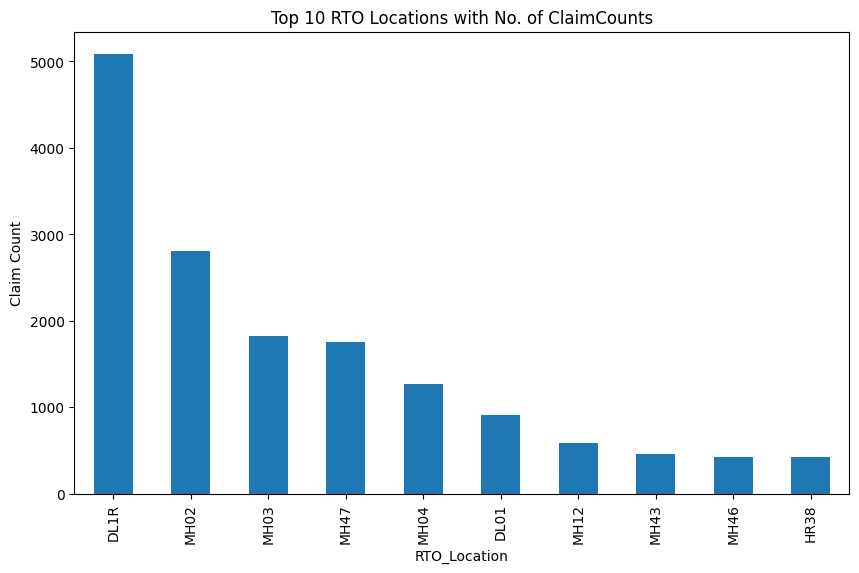

In [87]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('RTO_Location')
plt.ylabel('Claim Count')
plt.title('Top 10 RTO Locations with No. of ClaimCounts')
plt.show()

- OBSERVING SUM_INSURED

In [88]:
bucket_lbl=['<1LAKH','>=1LAKH']
bins=[0,100000,float('inf')]

df['sumInsured_bucket']=pd.cut(df['sum_insured'],bins=bins,labels=bucket_lbl,right=False)

grouped_data=df.groupby('sumInsured_bucket')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [89]:
top_10

sumInsured_bucket
>=1LAKH    19593.0
<1LAKH      4774.0
Name: clm_cnt, dtype: float64

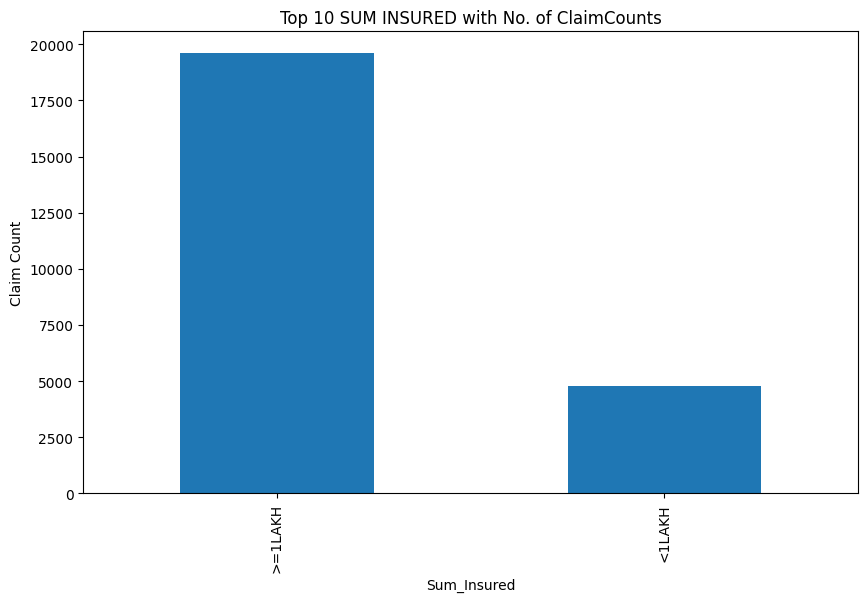

In [91]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Sum_Insured')
plt.ylabel('Claim Count')
plt.title('Top 10 SUM INSURED with No. of ClaimCounts')
plt.show()

- OBSERVING IMD_CODE

In [92]:
grouped_data=df.groupby('imd_code')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [93]:
top_10

imd_code
1000337    3277.0
1001221     404.0
1000573     387.0
1012297     377.0
1001833     321.0
1003358     315.0
1036768     297.0
1038066     263.0
1032238     262.0
1029118     250.0
Name: clm_cnt, dtype: float64

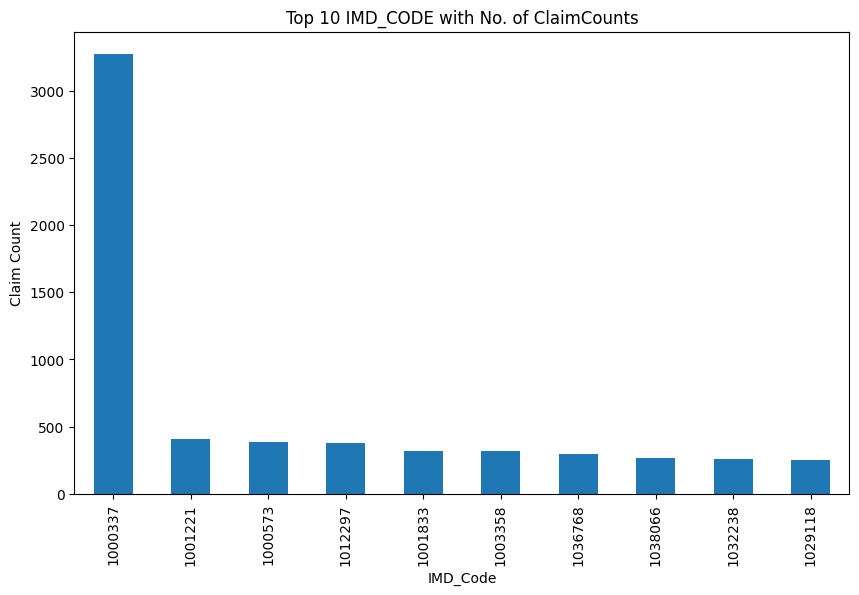

In [94]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('IMD_Code')
plt.ylabel('Claim Count')
plt.title('Top 10 IMD_CODE with No. of ClaimCounts')
plt.show()

- OBSERVING NET_PREMIUM

In [120]:
bucket_lbl=['<6500','>=6500']
bins=[0,6500,float('inf')]

df['netPremium_bucket']=pd.cut(df['net_premium'],bins=bins,labels=bucket_lbl,right=False)

grouped_data=df.groupby('netPremium_bucket')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [121]:
top_10

netPremium_bucket
>=6500    18242.0
<6500      6125.0
Name: clm_cnt, dtype: float64

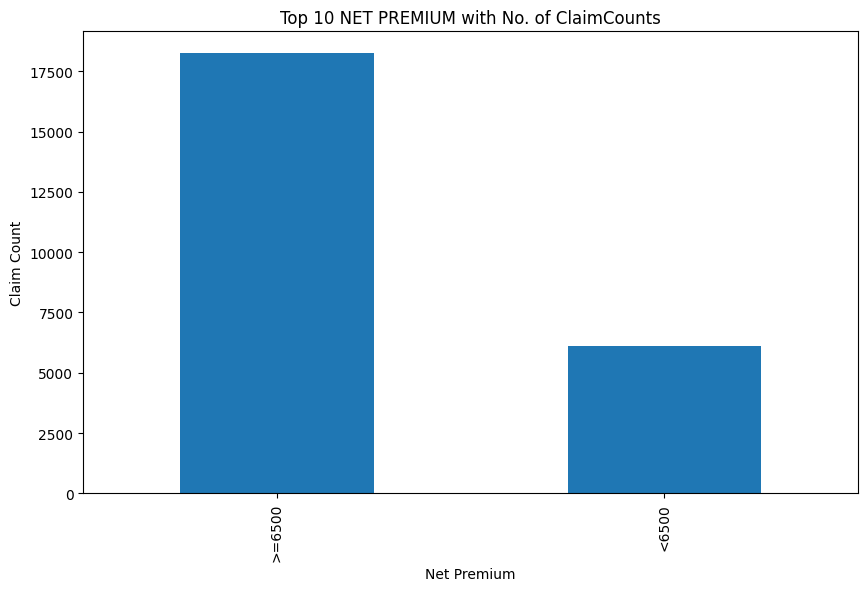

In [122]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Net Premium')
plt.ylabel('Claim Count')
plt.title('Top 10 NET PREMIUM with No. of ClaimCounts')
plt.show()

- OBSERVING OFFICE_CODE

In [119]:
grouped_data=df.groupby('office_code')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [58]:
top_10

office_code
12702    5503.0
10701    5085.0
12709    1661.0
10703    1514.0
10702    1089.0
12401    1067.0
12710     944.0
10902     785.0
12701     740.0
12711     705.0
Name: clm_cnt, dtype: float64

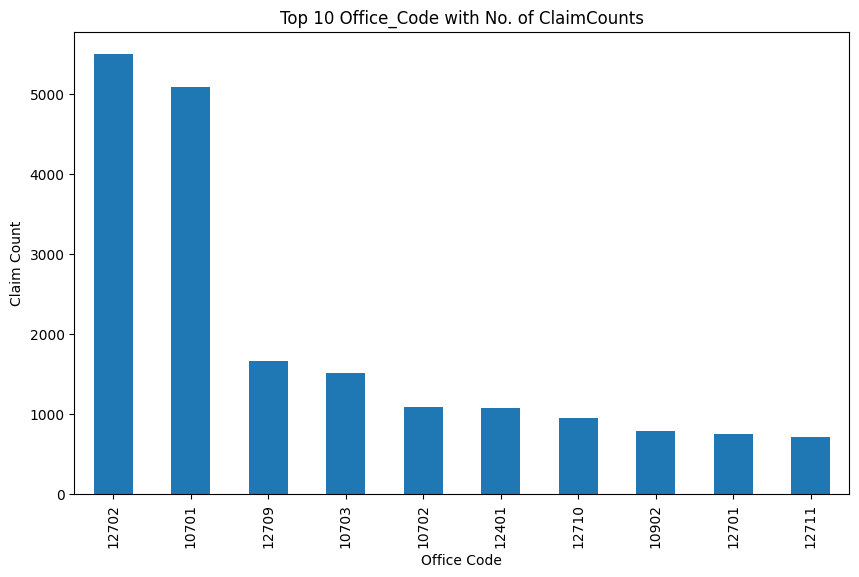

In [59]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Office Code')
plt.ylabel('Claim Count')
plt.title('Top 10 Office_Code with No. of ClaimCounts')
plt.show()

- OBSERVING VEH_AGE

In [82]:
grouped_data=df.groupby('veh_age')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [83]:
top_10

veh_age
0    7349.0
2    3714.0
3    3519.0
1    3485.0
4    2550.0
5    1652.0
6    1089.0
7     620.0
8     169.0
9      87.0
Name: clm_cnt, dtype: float64

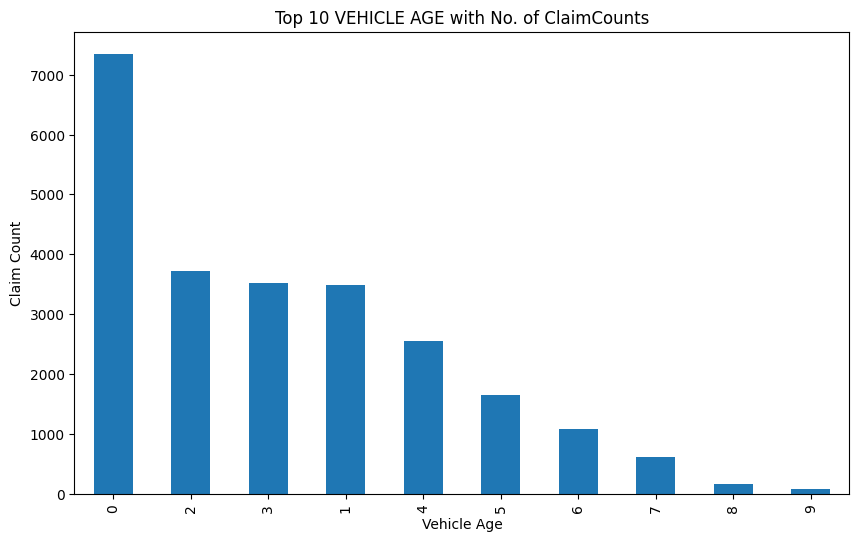

In [84]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Vehicle Age')
plt.ylabel('Claim Count')
plt.title('Top 10 VEHICLE AGE with No. of ClaimCounts')
plt.show()

- OBSERVING HYPO_PARTY

In [202]:
grouped_data=df.groupby('hypo_party')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(20)

In [203]:
top_10

hypo_party
self                                          1286.0
BAJAJ FINANCE LTD                              798.0
BAJAJ FINANCE LTD.                              83.0
BANSAL CREDITS LTD                              69.0
UNION BANK OF INDIA                             69.0
INDUSIND BANK LTD                               59.0
STATE BANK OF INDIA                             45.0
MAHINDRA & MAHINDRA FINANCIAL SERVICES LTD      38.0
BAJAJ FINANCE LIMITED                           37.0
THE GREATER BOMBAY CO OP BANK LTD               34.0
DANDONA FINANCE LTD                             33.0
ARISTO SECURITIES PVT LTD                       32.0
PUNJAB NATIONAL BANK                            26.0
BALDEV FINLEASE PVT LTD                         25.0
BANK OF INDIA                                   23.0
IDBI BANK LTD                                   23.0
INDUSIND BANK                                   23.0
VEE ESS CAPFIN PVT LTD                          21.0
BAJAJ FIN LTD                      

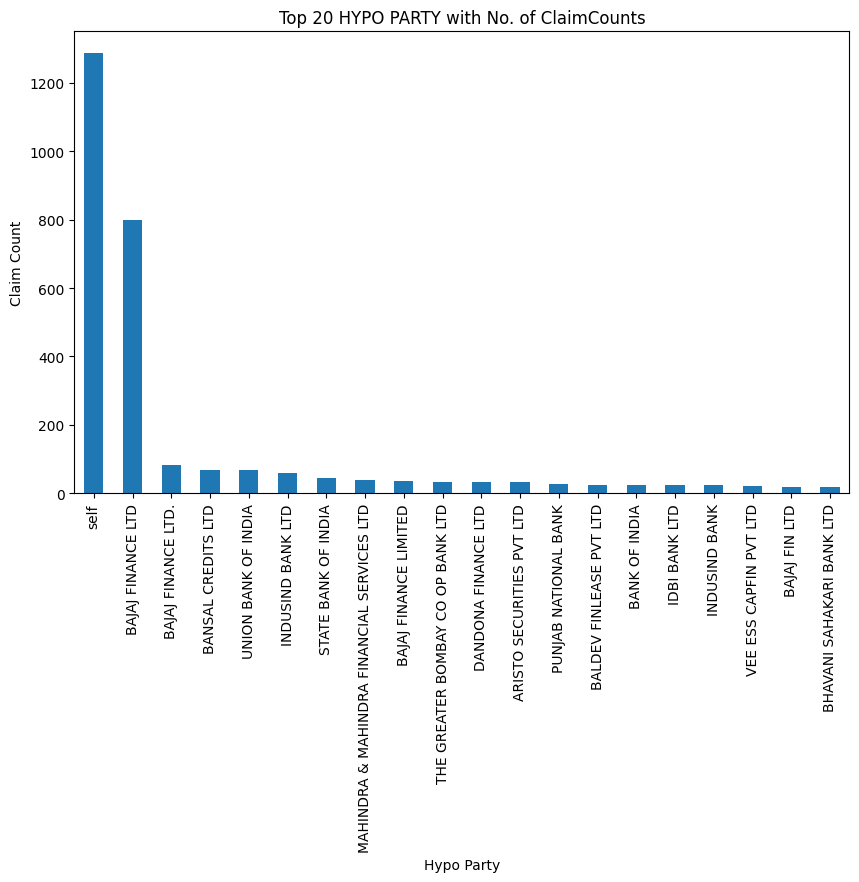

In [204]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Hypo Party')
plt.ylabel('Claim Count')
plt.title('Top 20 HYPO PARTY with No. of ClaimCounts')
plt.show()

- OBSERVING VEH_SUBTYPE

In [100]:
grouped_data=df.groupby('vehicle_subtype')['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [101]:
top_10

vehicle_subtype
CNG                   10280.0
4S CNG                 2930.0
4S CNG BSVI            1671.0
E RICKSHAW              995.0
2S ES                   849.0
4S ES                   792.0
45 BS IV CNG            588.0
AUTORICKSHAW            568.0
STK PETROL CNG BS6      374.0
LPG                     317.0
Name: clm_cnt, dtype: float64

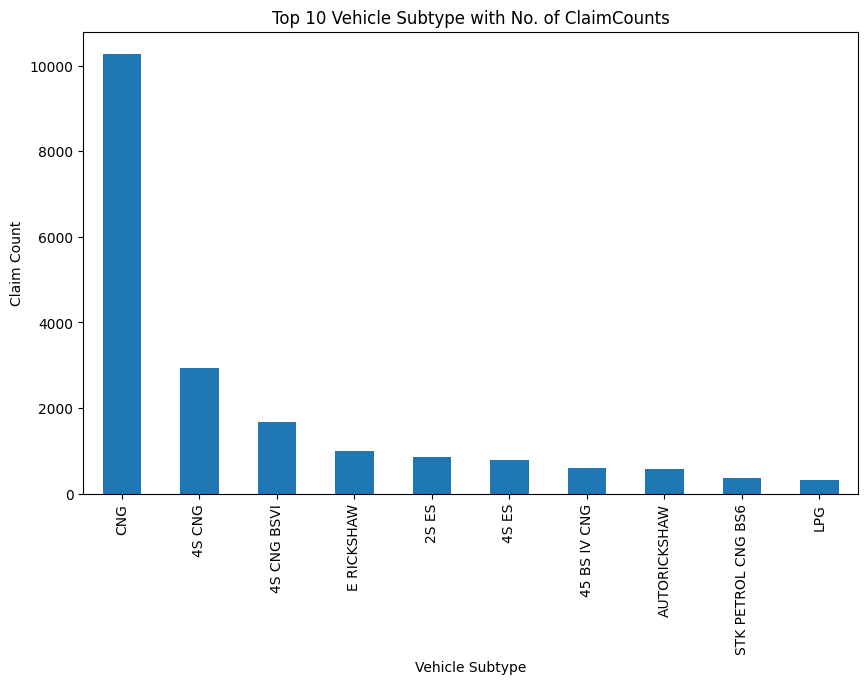

In [102]:
plt.figure(figsize=(10,6))
top_10.plot(kind='bar')
plt.xlabel('Vehicle Subtype')
plt.ylabel('Claim Count')
plt.title('Top 10 Vehicle Subtype with No. of ClaimCounts')
plt.show()

- LOOKING FOR A HELPFUL PATTERN USING FEATURES WITH A LARGE VARIANCE

In [123]:
grouped_data=df.groupby(['imd_code','rto_location'])['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [124]:
top_10

imd_code  rto_location
1000337   DL1R            2223.0
          DL01             647.0
1012297   DL1R             310.0
1001833   DL1R             262.0
1000573   DL1R             258.0
1000337   UP16             240.0
1032238   DL1R             214.0
1017146   MH02             188.0
1038066   MH02             186.0
1029118   DL1R             184.0
Name: clm_cnt, dtype: float64

In [126]:
grouped_data=df.groupby(['office_code','rto_location'])['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [127]:
top_10

office_code  rto_location
10701        DL1R            3112.0
12702        MH02            1650.0
             MH03            1183.0
             MH47            1011.0
10703        DL1R             968.0
10702        DL1R             716.0
12702        MH04             689.0
12709        MH02             636.0
10701        DL01             597.0
12701        MH12             466.0
Name: clm_cnt, dtype: float64

In [129]:
grouped_data=df.groupby(['imd_code','rto_location','office_code'])['clm_cnt'].sum()
filtered_data=grouped_data[grouped_data>=1]
top_10=filtered_data.nlargest(10)

In [130]:
top_10

imd_code  rto_location  office_code
1000337   DL1R          10701          1414.0
                        10703           809.0
          DL01          10701           430.0
1000573   DL1R          10701           246.0
1001833   DL1R          10701           224.0
1000337   DL01          10703           217.0
1012297   DL1R          10701           213.0
1049288   DL1R          10601           182.0
1002679   MH15          12705           181.0
1004137   HR87          10701           158.0
Name: clm_cnt, dtype: float64

# BEST MODEL
- TRAINING ON SLICES OF X_TEST AND X_PRED
    - IMD_CODE
    - OFFICE_CODE
    - VEHICLE_AGE
    - IMD_CHANNEL

In [138]:
model=cb.CatBoostClassifier(learning_rate= 0.01, iterations= 300, depth= 16,class_weights=class_weights)

0:	learn: 0.6858413	total: 11.8s	remaining: 58m 34s
1:	learn: 0.6787271	total: 22.2s	remaining: 55m 11s
2:	learn: 0.6719949	total: 32.7s	remaining: 54m 1s
3:	learn: 0.6651887	total: 44.1s	remaining: 54m 26s
4:	learn: 0.6585016	total: 55s	remaining: 54m 3s
5:	learn: 0.6519651	total: 1m 6s	remaining: 54m 9s
6:	learn: 0.6456152	total: 1m 16s	remaining: 53m 40s
7:	learn: 0.6397011	total: 1m 27s	remaining: 53m 12s
8:	learn: 0.6337927	total: 1m 39s	remaining: 53m 33s
9:	learn: 0.6282394	total: 1m 43s	remaining: 49m 47s
10:	learn: 0.6230022	total: 1m 53s	remaining: 49m 54s
11:	learn: 0.6177225	total: 2m 5s	remaining: 50m 9s
12:	learn: 0.6124346	total: 2m 16s	remaining: 50m 14s
13:	learn: 0.6075127	total: 2m 28s	remaining: 50m 30s
14:	learn: 0.6025561	total: 2m 41s	remaining: 51m 5s
15:	learn: 0.5977671	total: 2m 53s	remaining: 51m 15s
16:	learn: 0.5933016	total: 3m 5s	remaining: 51m 34s
17:	learn: 0.5887508	total: 3m 17s	remaining: 51m 33s
18:	learn: 0.5844006	total: 3m 28s	remaining: 51m 28s

151:	learn: 0.3557616	total: 24m 53s	remaining: 24m 14s
152:	learn: 0.3551085	total: 25m 2s	remaining: 24m 3s
153:	learn: 0.3545583	total: 25m 12s	remaining: 23m 54s
154:	learn: 0.3540107	total: 25m 20s	remaining: 23m 42s
155:	learn: 0.3536938	total: 25m 30s	remaining: 23m 33s
156:	learn: 0.3532034	total: 25m 40s	remaining: 23m 22s
157:	learn: 0.3527815	total: 25m 50s	remaining: 23m 13s
158:	learn: 0.3521490	total: 25m 59s	remaining: 23m 3s
159:	learn: 0.3516636	total: 26m 8s	remaining: 22m 52s
160:	learn: 0.3511106	total: 26m 16s	remaining: 22m 41s
161:	learn: 0.3505039	total: 26m 25s	remaining: 22m 30s
162:	learn: 0.3500875	total: 26m 33s	remaining: 22m 19s
163:	learn: 0.3495608	total: 26m 41s	remaining: 22m 8s
164:	learn: 0.3490339	total: 26m 50s	remaining: 21m 57s
165:	learn: 0.3483849	total: 26m 58s	remaining: 21m 46s
166:	learn: 0.3477727	total: 27m 7s	remaining: 21m 36s
167:	learn: 0.3471697	total: 27m 15s	remaining: 21m 25s
168:	learn: 0.3467820	total: 27m 23s	remaining: 21m 14

In [175]:
cat_features=[3,4,5,7,10]

In [178]:
model.fit(X_trainer, Y_train, cat_features)

0:	learn: 0.6857153	total: 10.1s	remaining: 50m 14s
1:	learn: 0.6789966	total: 21.1s	remaining: 52m 30s
2:	learn: 0.6718481	total: 32.2s	remaining: 53m 7s
3:	learn: 0.6651873	total: 43s	remaining: 53m
4:	learn: 0.6587501	total: 53.1s	remaining: 52m 12s
5:	learn: 0.6527643	total: 1m 4s	remaining: 52m 42s
6:	learn: 0.6464984	total: 1m 16s	remaining: 53m 23s
7:	learn: 0.6404891	total: 1m 28s	remaining: 53m 47s
8:	learn: 0.6350577	total: 1m 38s	remaining: 53m 13s
9:	learn: 0.6289688	total: 1m 49s	remaining: 52m 42s
10:	learn: 0.6236658	total: 2m	remaining: 52m 45s
11:	learn: 0.6180525	total: 2m 12s	remaining: 52m 50s
12:	learn: 0.6130335	total: 2m 23s	remaining: 52m 49s
13:	learn: 0.6078154	total: 2m 35s	remaining: 52m 50s
14:	learn: 0.6029222	total: 2m 46s	remaining: 52m 47s
15:	learn: 0.5983063	total: 2m 48s	remaining: 49m 57s
16:	learn: 0.5936719	total: 2m 59s	remaining: 49m 44s
17:	learn: 0.5889668	total: 3m 10s	remaining: 49m 41s
18:	learn: 0.5843657	total: 3m 21s	remaining: 49m 38s
1

151:	learn: 0.3575781	total: 26m 18s	remaining: 25m 37s
152:	learn: 0.3569881	total: 26m 25s	remaining: 25m 23s
153:	learn: 0.3563687	total: 26m 32s	remaining: 25m 9s
154:	learn: 0.3557689	total: 26m 40s	remaining: 24m 57s
155:	learn: 0.3552082	total: 26m 46s	remaining: 24m 43s
156:	learn: 0.3547091	total: 26m 53s	remaining: 24m 29s
157:	learn: 0.3541873	total: 27m	remaining: 24m 16s
158:	learn: 0.3537123	total: 27m 7s	remaining: 24m 3s
159:	learn: 0.3531694	total: 27m 14s	remaining: 23m 50s
160:	learn: 0.3526591	total: 27m 21s	remaining: 23m 37s
161:	learn: 0.3520982	total: 27m 29s	remaining: 23m 24s
162:	learn: 0.3516611	total: 27m 35s	remaining: 23m 11s
163:	learn: 0.3511413	total: 27m 42s	remaining: 22m 58s
164:	learn: 0.3507144	total: 27m 49s	remaining: 22m 46s
165:	learn: 0.3502852	total: 27m 56s	remaining: 22m 33s
166:	learn: 0.3498745	total: 28m 3s	remaining: 22m 20s
167:	learn: 0.3495105	total: 28m 10s	remaining: 22m 8s
168:	learn: 0.3490574	total: 28m 18s	remaining: 21m 56s
1

In [263]:
def metric_saver(Y_test, Y_pred):
    
    # Evaluate the model
    mse = accuracy_score(Y_test, Y_pred)

    rmse = recall_score(Y_test, Y_pred)

    r2=precision_score(Y_test,Y_pred)

    mae=f1_score(Y_test,Y_pred)
    
    return  round(mse, 4), round(rmse,4), round(r2, 4),  round(mae, 4)


In [264]:
def calculate_confusion_matrix(y_test, y_pred):
    TP = sum((y_test == 1) & (y_pred == 1))
    TN = sum((y_test == 0) & (y_pred == 0))
    FP = sum((y_test == 0) & (y_pred == 1))
    FN = sum((y_test == 1) & (y_pred == 0))

    return TP, TN, FP, FN

- OFFICE CODE

In [265]:
import pandas as pd

# Assuming you have already calculated the metrics and stored them in lists or dictionaries
group_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores=[]
true_neg=[]
true_pos=[]
false_pos=[]
false_neg=[]

In [266]:
import pandas as pd

grouped_data_frames = {}
df = pd.concat([X_tester,Y_test],axis=1)

for group_name, group_data in df.groupby('office_code'):
    grouped_data_frames[group_name] = group_data

In [267]:
for group_name, group_data_frame in grouped_data_frames.items():
    
    X_group = group_data_frame.drop('clm_cnt', axis=1)
    y_group = group_data_frame['clm_cnt']

    Y_pred = predict_test(model,X_group)
    # Model Metrics
    accuracy, recall, precision, f1 = metric_saver(y_group, Y_pred)
    
    TP, TN, FP, FN=calculate_confusion_matrix(y_group, Y_pred)
    
    group_names.append(group_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    true_pos.append(TP)
    false_pos.append(FP)
    true_neg.append(TN)
    false_neg.append(FN)

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

In [268]:
data={
    'Office_Code':group_names,
    'Accuracy':accuracy_scores,
    'Recall':recall_scores,
    'Precision':precision_scores,
    'True_Positive':true_pos,
    'False_Positive':false_pos,
    'False_Negative':false_neg,
    'True_Negative':true_neg,
}

# creating a dataframe
df=pd.DataFrame(data)

In [270]:
#Saving to Excel File
output_file_path='OfficeCode_Metrics.xlsx'
df.to_excel(output_file_path,index=False)

- VEHICLE AGE

In [280]:
import pandas as pd

group_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores=[]
true_neg=[]
true_pos=[]
false_pos=[]
false_neg=[]

In [281]:
import pandas as pd

grouped_data_frames = {}
df = pd.concat([X_tester,Y_test],axis=1)

for group_name, group_data in df.groupby('veh_age'):
    grouped_data_frames[group_name] = group_data

In [282]:
for group_name, group_data_frame in grouped_data_frames.items():
    
    X_group = group_data_frame.drop('clm_cnt', axis=1)
    y_group = group_data_frame['clm_cnt']

    Y_pred = predict_test(model,X_group)
    # Model Metrics
    accuracy, recall, precision, f1 = metric_saver(y_group, Y_pred)
    TP, TN, FP, FN=calculate_confusion_matrix(y_group, Y_pred)
    
    group_names.append(group_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    true_pos.append(TP)
    false_pos.append(FP)
    true_neg.append(TN)
    false_neg.append(FN)

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [283]:
data={
    'Vehicle_Age':group_names,
    'Accuracy':accuracy_scores,
    'Recall':recall_scores,
    'Precision':precision_scores,
    'True_Positive':true_pos,
    'False_Positive':false_pos,
    'False_Negative':false_neg,
    'True_Negative':true_neg,
}

# creating a dataframe
df=pd.DataFrame(data)

In [284]:
#Saving to Excel File
output_file_path='VehicleAge_Metrics.xlsx'
df.to_excel(output_file_path,index=False)

- IMD CODE


In [255]:
import pandas as pd

# Assuming you have already calculated the metrics and stored them in lists or dictionaries
group_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores=[]
true_neg=[]
true_pos=[]
false_pos=[]
false_neg=[]

In [256]:
import pandas as pd

grouped_data_frames = {}
df = pd.concat([X_tester,Y_test],axis=1)

for group_name, group_data in df.groupby('imd_code'):
    grouped_data_frames[group_name] = group_data

In [257]:
for group_name, group_data_frame in grouped_data_frames.items():
    
    X_group = group_data_frame.drop('clm_cnt', axis=1)
    y_group = group_data_frame['clm_cnt']

    Y_pred = predict_test(model,X_group)
    # Model Metrics
    accuracy, recall, precision, f1 = metric_saver(y_group, Y_pred)
    TP, TN, FP, FN=calculate_confusion_matrix(y_group, Y_pred)
    
    group_names.append(group_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    true_pos.append(TP)
    false_pos.append(FP)
    true_neg.append(TN)
    false_neg.append(FN)

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_cl

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: Un

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_cl

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ShivTikoo\envs\CV_ClaimPrediction\lib\site-packages\sklearn\met

In [286]:
data={
    'Office_Code':group_names,
    'Accuracy':accuracy_scores,
    'Recall':recall_scores,
    'Precision':precision_scores,
    'True_Positive':true_pos,
    'False_Positive':false_pos,
    'False_Negative':false_neg,
    'True_Negative':true_neg
    
}

# creating a dataframe
df=pd.DataFrame(data)

In [287]:
#Saving to Excel File
output_file_path='IMDCode_Metrics.xlsx'
df.to_excel(output_file_path,index=False)

#  PUTTING A MODEL FROM THE REGISTRY INTO PRODUCTION

- STEP 01
    - ADDING TOP 10 MODELS TO THE MODEL REGISTRY

In [34]:
import mlflow
run_name="CostSensitive_CatBoost_Classifier"
with mlflow.start_run(run_name=run_name) as run:
    result = mlflow.register_model(
        "runs:/7df0554b6c6c4716b34c4bb9af32c266/model",
        "CostSensitiveClassifier"
    )

Registered model 'CostSensitiveClassifier' already exists. Creating a new version of this model...
2023/07/29 17:22:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CostSensitiveClassifier, version 12
Created version '12' of model 'CostSensitiveClassifier'.


- PUTTING BEST MODEL TO PRODUCTION

In [35]:
import mlflow
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name="CostSensitiveClassifier",
    version=12,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1690631553028, current_stage='Production', description='', last_updated_timestamp=1690631642210, name='CostSensitiveClassifier', run_id='7df0554b6c6c4716b34c4bb9af32c266', run_link='', source='mlflow-artifacts:/531539600600355644/7df0554b6c6c4716b34c4bb9af32c266/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='12'>